## 新しく作った「緯度」「経度」のデータを導入する！

In [17]:
import pandas as pd

In [18]:
df_adachi = pd.read_csv('../data/handmade_data/adachi_latitude_longitude.csv')
df_arakawa = pd.read_csv('../data/handmade_data/arakawa_latitude_longitude.csv')
df_bunkyo = pd.read_csv('../data/handmade_data/bunkyo_latitude_longitude.csv')
df_chiyoda = pd.read_csv('../data/handmade_data/chiyoda_latitude_longitude.csv')
df_chuo = pd.read_csv('../data/handmade_data/chuo_latitude_longitude.csv')
df_edogawa = pd.read_csv('../data/handmade_data/edogawa_latitude_longitude.csv')
df_itabashi = pd.read_csv('../data/handmade_data/itabashi_latitude_longitude.csv')
df_katsushika = pd.read_csv('../data/handmade_data/katsushika_latitude_longitude.csv')
df_kita = pd.read_csv('../data/handmade_data/kita_latitude_longitude.csv')
df_koto = pd.read_csv('../data/handmade_data/koto_latitude_longitude.csv')
df_meguro = pd.read_csv('../data/handmade_data/meguro_latitude_longitude.csv')
df_minato = pd.read_csv('../data/handmade_data/minato_latitude_longitude.csv')
df_nakano = pd.read_csv('../data/handmade_data/nakano_latitude_longitude.csv')
df_nerima = pd.read_csv('../data/handmade_data/nerima_latitude_longitude.csv')
df_ota = pd.read_csv('../data/handmade_data/ota_latitude_longitude.csv')
df_setagaya = pd.read_csv('../data/handmade_data/setagaya_latitude_longitude.csv')
df_shibuya = pd.read_csv('../data/handmade_data/shibuya_latitude_longitude.csv')
df_shinagawa = pd.read_csv('../data/handmade_data/shinagawa_latitude_longitude.csv')
df_shinjuku = pd.read_csv('../data/handmade_data/shinjuku_latitude_longitude.csv')
df_suginami = pd.read_csv('../data/handmade_data/suginami_latitude_longitude.csv')
df_sumida = pd.read_csv('../data/handmade_data/sumida_latitude_longitude.csv')
df_taito = pd.read_csv('../data/handmade_data/taito_latitude_longitude.csv')
df_toshima = pd.read_csv('../data/handmade_data/toshima_latitude_longitude.csv')

In [19]:
df_23wards = pd.concat([
    df_adachi,
    df_arakawa,
    df_bunkyo,
    df_chiyoda,
    df_chuo,
    df_edogawa,
    df_itabashi,
    df_katsushika,
    df_kita,
    df_koto,
    df_meguro,
    df_minato,
    df_nakano,
    df_nerima,
    df_ota,
    df_setagaya,
    df_shibuya,
    df_shinjuku,
    df_shinagawa,
    df_suginami,
    df_sumida,
    df_taito,
    df_toshima
],ignore_index=True)

SIGNATE側から提供されている土地データとマージする

In [20]:
df_23wards

,区町名,平均緯度,平均経度
0,足立区一ツ家,35.781572,139.812957
1,足立区中央本町,35.773638,139.806966
2,足立区中川,35.770379,139.852018
3,足立区伊興,35.794732,139.783771
4,足立区伊興本町,35.799345,139.787836
...,...,...,...
924,豊島区長崎,35.731073,139.687135
925,豊島区雑司が谷,35.720299,139.718327
926,豊島区駒込,35.737936,139.744190
927,豊島区高松,35.738493,139.698601


In [21]:
addresses = pd.read_csv('../data/handmade_data/merge_address.csv')
addresses = addresses['所在地']
addresses = pd.DataFrame(addresses)

address_latlog = pd.merge(addresses, df_23wards, left_on='所在地', right_on='区町名', how='left')
address_latlog = address_latlog[['所在地', '平均緯度', '平均経度']]
address_latlog.columns = [['区町名', '平均緯度', '平均経度']]

In [24]:
df = pd.read_csv('../data/outer_data/train.csv')
train_latlog = address_latlog[:len(df)]
train_latlog.to_csv('../data/handmade_data/latitude_longitude.csv')
test_latlog = address_latlog[len(df):]
test_latlog.to_csv('../data/test_data/test_latitude_longitude.csv')

### この新しく作った特徴量をLightGBMに突っ込んでみる！

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold
import xgboost
from catboost import CatBoostRegressor
from catboost import Pool

###訓練データの読み込み
house_age = pd.read_csv('../data/handmade_data/house_age.csv')
area_size = pd.read_csv('../data/handmade_data/area_size.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
contract_span = pd.read_csv('../data/handmade_data/contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('../data/handmade_data/contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('../data/handmade_data/reg_rent.csv')
floor_scores = pd.read_csv('../data/handmade_data/floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('../data/handmade_data/floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('../data/handmade_data/capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('../data/handmade_data/capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('../data/handmade_data/stations.csv')
minits = pd.read_csv('../data/handmade_data/minits.csv')
addresses = pd.read_csv('../data/handmade_data/addresses.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
building = pd.read_csv('../data/handmade_data/building.csv')
buildings = pd.read_csv('../data/handmade_data/buildings.csv')
land_aveprice = pd.read_csv('../data/handmade_data/land_aveprice.csv')
land_aveprice.columns = ['平均地価']
over100m2 = pd.read_csv('../data/handmade_data/over100m2.csv')
bt75and100m2 = pd.read_csv('../data/handmade_data/bt75and100m2.csv')
bt50and75m2 = pd.read_csv('../data/handmade_data/bt50and75m2.csv')
sepa_bath_toilets = pd.read_csv('../data/handmade_data/sepa_bath_toilets.csv')
sepa_bath_toilets.columns = ['バス・トイレ別']
washlets = pd.read_csv('../data/handmade_data/washlets.csv')
area_per_rooms = pd.read_csv('../data/handmade_data/area_per_rooms.csv')
kitchen_points = pd.read_csv('../data/handmade_data/kitchen_points.csv')
kitchen_points.drop('コンロ3口', axis=1, inplace=True)
equipments = pd.read_csv('../data/handmade_data/equipments.csv')
latitude_longitude = pd.read_csv('../data/handmade_data/latitude_longitude.csv')

rent = pd.read_csv('../data/handmade_data/rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('../data/test_data/test_house_age.csv')
test_area_size = pd.read_csv('../data/test_data/test_area_size.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_contract_span = pd.read_csv('../data/test_data/test_contract_span.csv')
test_contract_span2 = pd.read_csv('../data/test_data/test_contract_span2.csv')
test_contract_span2.columns = ['契約期間']
test_reg_rent = pd.read_csv('../data/test_data/test_reg_rent.csv')
test_floor_scores = pd.read_csv('../data/test_data/test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('../data/test_data/test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('../data/test_data/test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('../data/test_data/test_capital_floor_scores2.csv')
test_stations = pd.read_csv('../data/test_data/test_stations.csv')
test_minits = pd.read_csv('../data/test_data/test_minits.csv')
test_addresses = pd.read_csv('../data/test_data/test_addresses.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_building = pd.read_csv('../data/test_data/test_building.csv')
test_buildings = pd.read_csv('../data/test_data/test_buildings.csv')
test_land_aveprice = pd.read_csv('../data/test_data/test_land_aveprice.csv')
test_land_aveprice.columns = ['平均地価']
test_over100m2 = pd.read_csv('../data/test_data/test_over100m2.csv')
test_bt75and100m2 = pd.read_csv('../data/test_data/test_bt75and100m2.csv')
test_bt50and75m2 = pd.read_csv('../data/test_data/test_bt50and75m2.csv')
test_sepa_bath_toilets = pd.read_csv('../data/test_data/test_sepa_bath_toilets.csv')
test_sepa_bath_toilets.columns = ['バス・トイレ別']
test_washlets = pd.read_csv('../data/test_data/test_washlets.csv')
test_area_per_rooms = pd.read_csv('../data/test_data/test_area_per_rooms.csv')
test_kitchen_points = pd.read_csv('../data/test_data/test_kitchen_points.csv')
test_kitchen_points.drop('コンロ3口', axis=1, inplace=True)
test_equipments = pd.read_csv('../data/test_data/test_equipments.csv')
test_latitude_longitude = pd.read_csv('../data/test_data/test_latitude_longitude.csv')


X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, land_aveprice, addresses, room_arrange[["部屋数","L","D","S"]], sepa_bath_toilets, buildings, over100m2, bt75and100m2, bt50and75m2, area_per_rooms, kitchen_points[['コンロ2口','システムキッチン']], latitude_longitude[['平均緯度', '平均経度']]], axis=1)
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size, test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_land_aveprice, test_addresses, test_room_arrange[["部屋数","L","D",'S']],test_sepa_bath_toilets, test_buildings, test_over100m2, test_bt75and100m2, test_bt50and75m2, test_area_per_rooms, test_kitchen_points[['コンロ2口','システムキッチン']], test_latitude_longitude[['平均緯度','平均経度']]], axis=1)
category_lists = ['定期借家','最寄り駅', '所在地', 'L', 'D', 'S', 'バス・トイレ別','建物構造','100m^2以上', '75m^2以上100m^2未満', '50m^2以上75m^2未満', 'コンロ2口']

Start training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3378
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48773.8	valid_1's rmse: 50054.4


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[20]	training's rmse: 34365.7	valid_1's rmse: 37572.4
[30]	training's rmse: 25830.1	valid_1's rmse: 30675
[40]	training's rmse: 20887.5	valid_1's rmse: 26798.5
[50]	training's rmse: 17710.3	valid_1's rmse: 24488.8
[60]	training's rmse: 15776.1	valid_1's rmse: 23131.1
[70]	training's rmse: 14415.9	valid_1's rmse: 22108.8
[80]	training's rmse: 13477	valid_1's rmse: 21408.3
[90]	training's rmse: 12738	valid_1's rmse: 20863.2
[100]	training's rmse: 12094.6	valid_1's rmse: 20407.9
[110]	training's rmse: 11538.5	valid_1's rmse: 20012.9
[120]	training's rmse: 11101.5	valid_1's rmse: 19729.4
[130]	training's rmse: 10709.1	valid_1's rmse: 19483.6
[140]	training's rmse: 10351.6	valid_1's rmse: 19225.3
[150]	training's rmse: 10048.3	valid_1's rmse: 18988.7
[160]	training's rmse: 9762.05	valid_1's rmse: 18758.3
[170]	training's rmse: 9493.67	valid_1's rmse: 18581.9
[180]	training's rmse: 9238.88	valid_1's rmse: 18380.8
[190]	training's rmse: 8999.4	valid_1's rmse: 18193.1
[200]	training's rmse: 87

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[30]	training's rmse: 26668.4	valid_1's rmse: 27811.2
[40]	training's rmse: 21904.5	valid_1's rmse: 23771.8
[50]	training's rmse: 18981.5	valid_1's rmse: 21260.2
[60]	training's rmse: 17197.4	valid_1's rmse: 20100
[70]	training's rmse: 15859	valid_1's rmse: 19416.5
[80]	training's rmse: 14885.9	valid_1's rmse: 18897.7
[90]	training's rmse: 14045	valid_1's rmse: 18588.3
[100]	training's rmse: 13378.9	valid_1's rmse: 18353.9
[110]	training's rmse: 12820.7	valid_1's rmse: 18270.4
[120]	training's rmse: 12332.3	valid_1's rmse: 18192.6
[130]	training's rmse: 11861.2	valid_1's rmse: 18131
[140]	training's rmse: 11450.2	valid_1's rmse: 18081.6
Early stopping, best iteration is:
[139]	training's rmse: 11495.4	valid_1's rmse: 18073.1
Start training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[20]	training's rmse: 34928.5	valid_1's rmse: 34331.9
[30]	training's rmse: 26554.5	valid_1's rmse: 26495
[40]	training's rmse: 21843	valid_1's rmse: 22462.8
[50]	training's rmse: 18883.4	valid_1's rmse: 20185.3
[60]	training's rmse: 16962.7	valid_1's rmse: 18963.5
[70]	training's rmse: 15699.4	valid_1's rmse: 18417.8
[80]	training's rmse: 14770.8	valid_1's rmse: 18034.7
[90]	training's rmse: 13996.3	valid_1's rmse: 17835.3
[100]	training's rmse: 13373.4	valid_1's rmse: 17626.2
[110]	training's rmse: 12818.6	valid_1's rmse: 17468.5
[120]	training's rmse: 12342.2	valid_1's rmse: 17325.4
[130]	training's rmse: 11936.6	valid_1's rmse: 17213
[140]	training's rmse: 11545.1	valid_1's rmse: 17126.4
[150]	training's rmse: 11188.4	valid_1's rmse: 17079
[160]	training's rmse: 10832.3	valid_1's rmse: 17009
[170]	training's rmse: 10529	valid_1's rmse: 16942.5
[180]	training's rmse: 10250	valid_1's rmse: 16920.7
[190]	training's rmse: 9994.47	valid_1's rmse: 16893.4
[200]	training's rmse: 9758.63	v

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 48971.9	valid_1's rmse: 47929.9
[20]	training's rmse: 34636.3	valid_1's rmse: 35454.3
[30]	training's rmse: 26081.6	valid_1's rmse: 28786.6
[40]	training's rmse: 21223.1	valid_1's rmse: 25227.2
[50]	training's rmse: 18247	valid_1's rmse: 23528.8
[60]	training's rmse: 16433.7	valid_1's rmse: 22564.8
[70]	training's rmse: 15196.4	valid_1's rmse: 22070.3
[80]	training's rmse: 14294.6	valid_1's rmse: 21706.5
[90]	training's rmse: 13618.8	valid_1's rmse: 21489.2
[100]	training's rmse: 13054.8	valid_1's rmse: 21299.6
[110]	training's rmse: 12550.1	valid_1's rmse: 21081
[120]	training's rmse: 12100.4	valid_1's rmse: 20849.6
[130]	training's rmse: 11709.6	valid_1's rmse: 20713
[140]	training's rmse: 11326.4	valid_1's rmse: 20547.7
[150]	training's rmse: 10997.3	valid_1's rmse: 20389.9
[160]	training's rmse: 10696.3	valid_1's rmse: 20262.9
[170]	training's rmse: 10406.6	valid_1's rmse: 20168
[180]	training's rmse: 10167.4	valid_1's rmse: 20094.4
[190]	training's rmse: 9915

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[30]	training's rmse: 26908.9	valid_1's rmse: 28379.1
[40]	training's rmse: 22314	valid_1's rmse: 23500.2
[50]	training's rmse: 19276.3	valid_1's rmse: 20653.9
[60]	training's rmse: 17243.1	valid_1's rmse: 19161.5
[70]	training's rmse: 15919	valid_1's rmse: 18253.3
[80]	training's rmse: 14932.3	valid_1's rmse: 17680.2
[90]	training's rmse: 14167.6	valid_1's rmse: 17305.3
[100]	training's rmse: 13580	valid_1's rmse: 17079
[110]	training's rmse: 13076.6	valid_1's rmse: 16889.9
[120]	training's rmse: 12635.3	valid_1's rmse: 16718.5
[130]	training's rmse: 12260.3	valid_1's rmse: 16568.2
[140]	training's rmse: 11855.4	valid_1's rmse: 16436.9
[150]	training's rmse: 11461.2	valid_1's rmse: 16268
[160]	training's rmse: 11121.2	valid_1's rmse: 16140.1
[170]	training's rmse: 10809.9	valid_1's rmse: 16022.3
[180]	training's rmse: 10534.9	valid_1's rmse: 15909.6
[190]	training's rmse: 10274.6	valid_1's rmse: 15842.5
[200]	training's rmse: 10044	valid_1's rmse: 15759.9
[210]	training's rmse: 9801.7

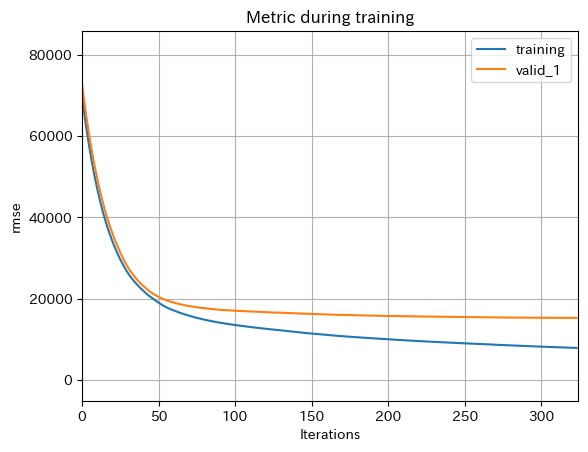

,importance
面積,4.581843e+14
L,3.889303e+14
平均地価,1.992089e+14
最寄り駅,8.795531e+13
築年数,6.614030e+13
所在地,3.263705e+13
全体の階数,2.811729e+13
一部屋あたりの面積,2.231920e+13
平均緯度,1.427482e+13
契約期間,1.300932e+13


In [35]:
n_split = 5
cv = KFold(n_splits=n_split, shuffle=True, random_state=0)
valid_rmses_list = []
valid_GBDT = np.zeros(X_train.shape[0])
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    evals_result = {} 
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

    params = {
        'objective':'regression',
        'boosting_type':'gbdt',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda':  5.009615137983937e-06,
        'max_bin': 346,
        'num_leaves': 91,
    }

    print('Start training...')
    model = lgb.train(
                        params,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=1000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists,
                        evals_result=evals_result,
                        )

    pred_y_val = model.predict(X_val)
    rmse = mean_squared_error(y_val, pred_y_val, squared=False)
    valid_rmses_list.append(rmse)

valid_rmse = np.mean(valid_rmses_list)
print("whole valid rmse:", valid_rmse)

print('Start predicting...')
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
print('Plot metrics during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()
# feature importanceを表示
importance = pd.DataFrame(model.feature_importance(importance_type = "gain"), index=X_train.columns, columns=['importance'])
df_importance = pd.DataFrame(importance)
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

In [43]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)
rmse_scores = []
X_train['KFold'] = -1
#foldはvalidの対象となる値で０から４
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_train.loc[valid_index,'KFold'] = fold_id
    y_train.loc[valid_index,'KFold'] = fold_id

def objective(trial):
    #foldはvalidの対象となる値で０から４
    for fold in range(5):
        X_tr = X_train[X_train['KFold']!=fold].drop('KFold',axis=1)
        X_val = X_train[X_train['KFold']==fold].drop('KFold',axis=1)
        y_tr = y_train[y_train['KFold']!=fold].drop('KFold',axis=1)
        y_val = y_train[y_train['KFold']==fold].drop('KFold',axis=1)

        lgb_train = lgb.Dataset(X_tr, y_tr)
        lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
        params = {
            'objective':'regression',
            'metrics':'rmse',
            'learning_rate':0.05,
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0000001, 0.0001, log=True),
            'max_bin': trial.suggest_int('max_bin', 255, 600),
            'num_leaves': trial.suggest_int('num_leaves', 50, 128),
        }

        model = lgb.train(
                            params,
                            lgb_train, 
                            valid_sets=[lgb_train, lgb_eval], 
                            verbose_eval=10, 
                            num_boost_round=1000, 
                            early_stopping_rounds=10,
                            categorical_feature = category_lists
                            )

        y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)
        rmse_score = mean_squared_error(y_val, y_pred_val, squared=False)
    loss = np.mean(rmse_score)
    return loss

In [44]:
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
study.optimize(objective, n_trials=100)

[I 2022-10-04 23:41:12,867] A new study created in memory with name: no-name-0b34bdea-5d7d-41b1-a5e4-30b5b5891e3f
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verb

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4307
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48723.9	valid_1's rmse: 50100.5
[20]	training's rmse: 34233.5	valid_1's rmse: 37562.9
[30]	training's rmse: 25674.1	valid_1's rmse: 30768.4
[40]	training's rmse: 20628.1	valid_1's rmse: 27042.5
[50]	training's rmse: 17329.9	valid_1's rmse: 24828.1
[60]	training's rmse: 15336.7	valid_1's rmse: 23593.4
[70]	training's rmse: 13954	valid_1's rmse: 22763.3
[80]	training's rmse: 12921.3	valid_1's rmse: 22149.2
[90]	training's rmse: 12134.9	valid_1's rmse: 21675.8
[100]	training's rmse: 11508.9	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4305
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48860.9	valid_1's rmse: 49635.3
[20]	training's rmse: 34807.7	valid_1's rmse: 36022.3
[30]	training's rmse: 26660.7	valid_1's rmse: 28472.2
[40]	training's rmse: 22158	valid_1's rmse: 24335.8
[50]	training's rmse: 19132.4	valid_1's rmse: 21463.6
[60]	training's rmse: 17339.9	valid_1's rmse: 19972.3
[70]	training's rmse: 16176.1	valid_1's rmse: 19037.3
[80]	training's rmse: 15255.7	valid_1's rmse: 18434.8
[90]	training's rmse: 14554.1	valid_1's rmse: 18086.9
[100]	training's rmse: 13951.7	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4311
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48915.2	valid_1's rmse: 48015.9
[20]	training's rmse: 35216	valid_1's rmse: 33458
[30]	training's rmse: 26902.4	valid_1's rmse: 25443.5
[40]	training's rmse: 22118.2	valid_1's rmse: 21358.3
[50]	training's rmse: 19049	valid_1's rmse: 18955.5
[60]	training's rmse: 17166.4	valid_1's rmse: 17943.9
[70]	training's rmse: 16053.4	valid_1's rmse: 17498.5
[80]	training's rmse: 15242.8	valid_1's rmse: 17263.4
[90]	training's rmse: 14514.8	valid_1's rmse: 17085.7
[100]	training's rmse: 13993	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4307
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49188.7	valid_1's rmse: 48069.4
[20]	training's rmse: 34942.6	valid_1's rmse: 34891.1
[30]	training's rmse: 26558.8	valid_1's rmse: 27768.1
[40]	training's rmse: 21781.4	valid_1's rmse: 23900.7
[50]	training's rmse: 18645.2	valid_1's rmse: 22061.4
[60]	training's rmse: 16764.2	valid_1's rmse: 21015.5
[70]	training's rmse: 15649.9	valid_1's rmse: 20462.7
[80]	training's rmse: 14841.6	valid_1's rmse: 20137.8
[90]	training's rmse: 14226.5	valid_1's rmse: 19876.3
[100]	training's rmse: 13714.9	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4310
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48591.9	valid_1's rmse: 50993.6
[20]	training's rmse: 34769.5	valid_1's rmse: 36756
[30]	training's rmse: 26840.1	valid_1's rmse: 28511.4
[40]	training's rmse: 22284.3	valid_1's rmse: 23730.2
[50]	training's rmse: 19137.5	valid_1's rmse: 20849.3
[60]	training's rmse: 17143	valid_1's rmse: 19464.5
[70]	training's rmse: 15950.2	valid_1's rmse: 18613.3
[80]	training's rmse: 15007.5	valid_1's rmse: 18192
[90]	training's rmse: 14332.4	valid_1's rmse: 17921.8
[100]	training's rmse: 13810	valid_1's rmse: 

[I 2022-10-04 23:41:31,118] Trial 0 finished with value: 16210.795505654336 and parameters: {'reg_lambda': 4.430375245218262e-06, 'max_bin': 502, 'num_leaves': 97}. Best is trial 0 with value: 16210.795505654336.


[380]	training's rmse: 8112.45	valid_1's rmse: 16229.2
Early stopping, best iteration is:
[379]	training's rmse: 8132.96	valid_1's rmse: 16210.8


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3707
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48616.3	valid_1's rmse: 49900
[20]	training's rmse: 34061.8	valid_1's rmse: 37477.5
[30]	training's rmse: 25503.2	valid_1's rmse: 30631.2
[40]	training's rmse: 20552	valid_1's rmse: 26835.3
[50]	training's rmse: 17275.8	valid_1's rmse: 24568.8
[60]	training's rmse: 15291.9	valid_1's rmse: 23236.7
[70]	training's rmse: 13865.6	valid_1's rmse: 22272.4
[80]	training's rmse: 12877.6	valid_1's rmse: 21611.6
[90]	training's rmse: 12194.1	valid_1's rmse: 21114.6
[100]	training's rmse: 11597.3	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3706
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48865.3	valid_1's rmse: 49649.2
[20]	training's rmse: 34668.6	valid_1's rmse: 36289.4
[30]	training's rmse: 26323	valid_1's rmse: 28909.1
[40]	training's rmse: 21489.4	valid_1's rmse: 24766.5
[50]	training's rmse: 18501.9	valid_1's rmse: 22014.1
[60]	training's rmse: 16641.9	valid_1's rmse: 20532.4
[70]	training's rmse: 15278	valid_1's rmse: 19637.7
[80]	training's rmse: 14317.2	valid_1's rmse: 19145.5
[90]	training's rmse: 13502.6	valid_1's rmse: 18812.4
[100]	training's rmse: 12875.2	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[20]	training's rmse: 34715.6	valid_1's rmse: 33911.3
[30]	training's rmse: 26357.9	valid_1's rmse: 25984.9
[40]	training's rmse: 21603.4	valid_1's rmse: 21940.1
[50]	training's rmse: 18625.5	valid_1's rmse: 19660.1
[60]	training's rmse: 16736.3	valid_1's rmse: 18457.1
[70]	training's rmse: 15422.2	valid_1's rmse: 17893
[80]	training's rmse: 14464.9	valid_1's rmse: 17520.2
[90]	training's rmse: 13711.8	valid_1's rmse: 17259.5
[100]	training's rmse: 13087.2	valid_1's rmse: 17036
[110]	training's rmse: 12521.1	valid_1's rmse: 16868.2
[120]	training's rmse: 12025.6	valid_1's rmse: 16741.5
[130]	training's rmse: 11628.1	valid_1's rmse: 16687
[140]	training's rmse: 11277	valid_1's rmse: 16664.7
[150]	training's rmse: 10947.2	valid_1's rmse: 16597.4
[160]	training's rmse: 10628.9	valid_1's rmse: 16533.1
[170]	training's rmse: 10347	valid_1's rmse: 16496.4
[180]	training's rmse: 10072.3	valid_1's rmse: 16448.3
[190]	training's rmse: 9804.32	valid_1's rmse: 16406.5
[200]	training's rmse: 9564.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 49116.4	valid_1's rmse: 48009.5
[20]	training's rmse: 34563.5	valid_1's rmse: 35158.6
[30]	training's rmse: 26049.2	valid_1's rmse: 28077.7
[40]	training's rmse: 21125.3	valid_1's rmse: 24252.3
[50]	training's rmse: 18110	valid_1's rmse: 22310
[60]	training's rmse: 16321.9	valid_1's rmse: 21351.5
[70]	training's rmse: 15098.9	valid_1's rmse: 20639.6
[80]	training's rmse: 14185.1	valid_1's rmse: 20178.3
[90]	training's rmse: 13498.1	valid_1's rmse: 19784.3
[100]	training's rmse: 12935.6	valid_1's rmse: 19517.2
[110]	training's rmse: 12496.6	valid_1's rmse: 19353.2
[120]	training's rmse: 12111	valid_1's rmse: 19239.8
[130]	training's rmse: 11754.9	valid_1's rmse: 19111.8
[140]	training's rmse: 11421.8	valid_1's rmse: 19017.7
[150]	training's rmse: 11119.9	valid_1's rmse: 18939.8
[160]	training's rmse: 10835.2	valid_1's rmse: 18919.3
[170]	training's rmse: 10557.1	valid_1's rmse: 18857.1
[180]	training's rmse: 10294.9	valid_1's rmse: 18777.6
[190]	training's rmse: 10

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001913 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3705
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48547.4	valid_1's rmse: 50916.1
[20]	training's rmse: 34722.9	valid_1's rmse: 36651.5
[30]	training's rmse: 26515.4	valid_1's rmse: 28273.2
[40]	training's rmse: 21810.7	valid_1's rmse: 23490
[50]	training's rmse: 18771.6	valid_1's rmse: 20832.9
[60]	training's rmse: 16801.5	valid_1's rmse: 19514.1
[70]	training's rmse: 15485.1	valid_1's rmse: 18840.3
[80]	training's rmse: 14513.3	valid_1's rmse: 18381.7
[90]	training's rmse: 13754	valid_1's rmse: 18151.2
[100]	training's rmse: 13152.9	valid_1's rm

[I 2022-10-04 23:41:43,416] Trial 1 finished with value: 16558.930999035976 and parameters: {'reg_lambda': 4.311710058685494e-06, 'max_bin': 401, 'num_leaves': 101}. Best is trial 0 with value: 16210.795505654336.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsu

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4640
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48256.2	valid_1's rmse: 49861.5
[20]	training's rmse: 33616.1	valid_1's rmse: 37397.8
[30]	training's rmse: 25181.4	valid_1's rmse: 30646.8
[40]	training's rmse: 20257.7	valid_1's rmse: 26951.9
[50]	training's rmse: 17009.4	valid_1's rmse: 24486.5
[60]	training's rmse: 14942.3	valid_1's rmse: 22953.7
[70]	training's rmse: 13475.5	valid_1's rmse: 21846.8
[80]	training's rmse: 12469.6	valid_1's rmse: 21138.9
[90]	training's rmse: 11720.7	valid_1's rmse: 20636
[100]	training's rmse: 11046	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001312 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4644
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48606.2	valid_1's rmse: 49532.1
[20]	training's rmse: 34441.8	valid_1's rmse: 36275
[30]	training's rmse: 26173.5	valid_1's rmse: 28590.4
[40]	training's rmse: 21643.5	valid_1's rmse: 24432.9
[50]	training's rmse: 18749.6	valid_1's rmse: 21500.9
[60]	training's rmse: 16962.6	valid_1's rmse: 19780.6
[70]	training's rmse: 15704.9	valid_1's rmse: 18841
[80]	training's rmse: 14665	valid_1's rmse: 18309
[90]	training's rmse: 13857.8	valid_1's rmse: 17973.4
[100]	training's rmse: 13256.5	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4642
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48637.7	valid_1's rmse: 47979.9
[20]	training's rmse: 34559.4	valid_1's rmse: 33233.6
[30]	training's rmse: 26276.6	valid_1's rmse: 25299.3
[40]	training's rmse: 21504.3	valid_1's rmse: 21298.6
[50]	training's rmse: 18485.1	valid_1's rmse: 19082.8
[60]	training's rmse: 16532.7	valid_1's rmse: 18074
[70]	training's rmse: 15311.3	valid_1's rmse: 17509.6
[80]	training's rmse: 14435	valid_1's rmse: 17270.6
[90]	training's rmse: 13804.6	valid_1's rmse: 17102.7
[100]	training's rmse: 13250.8	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4647
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48732.1	valid_1's rmse: 47840.3
[20]	training's rmse: 34134.1	valid_1's rmse: 35121.5
[30]	training's rmse: 25828.2	valid_1's rmse: 28013.6
[40]	training's rmse: 21006.1	valid_1's rmse: 24343.2
[50]	training's rmse: 17927.6	valid_1's rmse: 22587.6
[60]	training's rmse: 16111.1	valid_1's rmse: 21592.1
[70]	training's rmse: 14952.7	valid_1's rmse: 20985.6
[80]	training's rmse: 14099.2	valid_1's rmse: 20574.7
[90]	training's rmse: 13444.8	valid_1's rmse: 20327.5
[100]	training's rmse: 12919.3	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4639
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48219.4	valid_1's rmse: 50748.6
[20]	training's rmse: 34236.5	valid_1's rmse: 36649.6
[30]	training's rmse: 26097	valid_1's rmse: 28398.9
[40]	training's rmse: 21475	valid_1's rmse: 23699.6
[50]	training's rmse: 18443.8	valid_1's rmse: 20908.4
[60]	training's rmse: 16412.8	valid_1's rmse: 19442.5
[70]	training's rmse: 15257.3	valid_1's rmse: 18705
[80]	training's rmse: 14392.1	valid_1's rmse: 18325.4
[90]	training's rmse: 13749.3	valid_1's rmse: 18114.8
[100]	training's rmse: 13275.4	valid_1's rmse

[I 2022-10-04 23:42:06,515] Trial 2 finished with value: 16310.755629627878 and parameters: {'reg_lambda': 2.054762512591133e-06, 'max_bin': 563, 'num_leaves': 126}. Best is trial 0 with value: 16210.795505654336.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsu

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4450
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48691.8	valid_1's rmse: 50116.2
[20]	training's rmse: 34156	valid_1's rmse: 37719.9
[30]	training's rmse: 25710.1	valid_1's rmse: 30909.8
[40]	training's rmse: 20728	valid_1's rmse: 27180.8
[50]	training's rmse: 17488.9	valid_1's rmse: 24859.9
[60]	training's rmse: 15471.2	valid_1's rmse: 23415.4
[70]	training's rmse: 14050.2	valid_1's rmse: 22414.1
[80]	training's rmse: 13053.1	valid_1's rmse: 21737.4
[90]	training's rmse: 12318.4	valid_1's rmse: 21222.7
[100]	training's rmse: 11651.2	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4453
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48840	valid_1's rmse: 49472.5
[20]	training's rmse: 34760	valid_1's rmse: 36523.4
[30]	training's rmse: 26689.1	valid_1's rmse: 29000.8
[40]	training's rmse: 22026.4	valid_1's rmse: 24622.8
[50]	training's rmse: 19127.2	valid_1's rmse: 21620.4
[60]	training's rmse: 17400.6	valid_1's rmse: 19942.8
[70]	training's rmse: 16168.8	valid_1's rmse: 18844.3
[80]	training's rmse: 15269.6	valid_1's rmse: 18186.7
[90]	training's rmse: 14610.2	valid_1's rmse: 17760
[100]	training's rmse: 14029.2	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4452
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48977.9	valid_1's rmse: 48393.9
[20]	training's rmse: 35052.1	valid_1's rmse: 33722.1
[30]	training's rmse: 26824.4	valid_1's rmse: 25841.9
[40]	training's rmse: 22152.7	valid_1's rmse: 21767.9
[50]	training's rmse: 19174.9	valid_1's rmse: 19245.9
[60]	training's rmse: 17258.5	valid_1's rmse: 18248.8
[70]	training's rmse: 16000.8	valid_1's rmse: 17684.1
[80]	training's rmse: 15011.1	valid_1's rmse: 17411.8
[90]	training's rmse: 14318.2	valid_1's rmse: 17339.3
[100]	training's rmse: 13735.2	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4456
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49184.2	valid_1's rmse: 48130.9
[20]	training's rmse: 34840	valid_1's rmse: 35189.5
[30]	training's rmse: 26548.4	valid_1's rmse: 27973.6
[40]	training's rmse: 21716.8	valid_1's rmse: 24100.9
[50]	training's rmse: 18708.3	valid_1's rmse: 22216.1
[60]	training's rmse: 16821.4	valid_1's rmse: 21107.2
[70]	training's rmse: 15634.9	valid_1's rmse: 20419
[80]	training's rmse: 14781.2	valid_1's rmse: 19969.5
[90]	training's rmse: 14088.5	valid_1's rmse: 19644.7
[100]	training's rmse: 13479.2	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001845 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4453
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48687.9	valid_1's rmse: 51023.4
[20]	training's rmse: 34866.3	valid_1's rmse: 36929.3
[30]	training's rmse: 26903.7	valid_1's rmse: 28683.2
[40]	training's rmse: 22337.3	valid_1's rmse: 24055.8
[50]	training's rmse: 19209.3	valid_1's rmse: 21412.1
[60]	training's rmse: 17313.6	valid_1's rmse: 20011.3
[70]	training's rmse: 16010.7	valid_1's rmse: 19222.1
[80]	training's rmse: 15069.8	valid_1's rmse: 18847.1
[90]	training's rmse: 14400.9	valid_1's rmse: 18661.4
[100]	training's rmse: 13859.4	valid_1'

[I 2022-10-04 23:42:20,742] Trial 3 finished with value: 16812.179819654626 and parameters: {'reg_lambda': 1.4135935551752292e-06, 'max_bin': 528, 'num_leaves': 91}. Best is trial 0 with value: 16210.795505654336.


Early stopping, best iteration is:
[396]	training's rmse: 7830.34	valid_1's rmse: 16812.2
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001671 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4703
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 49261.2	valid_1's rmse: 50752.5
[20]	training's rmse: 35013.3	valid_1's rmse: 38483.7
[30]	training's rmse: 26611.7	valid_1's rmse: 31614.1
[40]	training's rmse: 21631.6	valid_1's rmse: 27696.5
[50]	training's rmse: 18364.9	valid_1's rmse: 25191.9
[60]	training's rmse: 16434.4	valid_1's rmse: 23742.5
[70]	training's rmse: 15009.4	valid_1's rmse: 22674.4
[80]	training's rmse: 14051	valid_1's rmse: 22031.2
[90]	training's rmse: 13353.6	valid_1's rmse: 21600.9
[100]	training's rmse: 12744.1	valid_1's rmse: 21230.3
[110]	training's rmse: 12248.5	valid_1's rmse: 20924.4
[120]	training's rmse: 11786.7	valid_1's rmse: 20627.6
[130]	training's rmse: 11400.9	valid_1's rmse: 20322.4
[140]	training's rmse: 11039.9	valid_1's rmse: 20020.3
[150]	training's rmse: 10710	valid_1's rmse: 19753.8
[160]	training's rmse: 10420.7	valid_1's rmse: 19526
[170]	training's rmse: 10166.5	valid_1's rmse: 19335.3
[180]	training's rmse: 9942.1	valid_1's rmse: 19178
[190]	training's rmse: 9733.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4702
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49429.5	valid_1's rmse: 50120.4
[20]	training's rmse: 35554.4	valid_1's rmse: 36954.9
[30]	training's rmse: 27525.2	valid_1's rmse: 29467.6
[40]	training's rmse: 22834.9	valid_1's rmse: 24983
[50]	training's rmse: 19953.8	valid_1's rmse: 22080.1
[60]	training's rmse: 18122.4	valid_1's rmse: 20310.7
[70]	training's rmse: 16912.9	valid_1's rmse: 19298.7
[80]	training's rmse: 15943.1	valid_1's rmse: 18759.5
[90]	training's rmse: 15104.1	valid_1's rmse: 18398.5
[100]	training's rmse: 14535.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4707
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49441.6	valid_1's rmse: 48936.9
[20]	training's rmse: 35624	valid_1's rmse: 34645.6
[30]	training's rmse: 27574.5	valid_1's rmse: 26737.3
[40]	training's rmse: 22766.2	valid_1's rmse: 22595.3
[50]	training's rmse: 19723.5	valid_1's rmse: 20231.4
[60]	training's rmse: 17835.7	valid_1's rmse: 19061
[70]	training's rmse: 16733.2	valid_1's rmse: 18376.1
[80]	training's rmse: 15799.8	valid_1's rmse: 17949.4
[90]	training's rmse: 15061.7	valid_1's rmse: 17701.8
[100]	training's rmse: 14455.9	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4717
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49473.4	valid_1's rmse: 48551
[20]	training's rmse: 35411.4	valid_1's rmse: 36012.8
[30]	training's rmse: 27092.3	valid_1's rmse: 29000.3
[40]	training's rmse: 22240	valid_1's rmse: 25164.8
[50]	training's rmse: 19261.7	valid_1's rmse: 23117.6
[60]	training's rmse: 17476.3	valid_1's rmse: 21895.9
[70]	training's rmse: 16331.7	valid_1's rmse: 21144.4
[80]	training's rmse: 15508.1	valid_1's rmse: 20644.8
[90]	training's rmse: 14820.6	valid_1's rmse: 20277.7
[100]	training's rmse: 14251.9	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4706
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49137.5	valid_1's rmse: 51595.6
[20]	training's rmse: 35475.9	valid_1's rmse: 37545.3
[30]	training's rmse: 27530.1	valid_1's rmse: 29255.1
[40]	training's rmse: 22838.7	valid_1's rmse: 24346
[50]	training's rmse: 19813.5	valid_1's rmse: 21599.3
[60]	training's rmse: 17770.3	valid_1's rmse: 20093.4
[70]	training's rmse: 16519.3	valid_1's rmse: 19250.2
[80]	training's rmse: 15654.3	valid_1's rmse: 18801.9
[90]	training's rmse: 14978.2	valid_1's rmse: 18579.3
[100]	training's rmse: 14442.8	valid_1's 

[I 2022-10-04 23:42:34,250] Trial 4 finished with value: 16073.435845781825 and parameters: {'reg_lambda': 5.059803874660429e-06, 'max_bin': 575, 'num_leaves': 55}. Best is trial 4 with value: 16073.435845781825.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2880
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48574.7	valid_1's rmse: 50214.3
[20]	training's rmse: 34177.3	valid_1's rmse: 38046.4
[30]	training's rmse: 25612.6	valid_1's rmse: 31158.1
[40]	training's rmse: 20620.1	valid_1's rmse: 27335.4
[50]	training's rmse: 17352.7	valid_1's rmse: 25028.7
[60]	training's rmse: 15294.3	valid_1's rmse: 23502.2
[70]	training's rmse: 13896.7	valid_1's rmse: 22554.3
[80]	training's rmse: 12901.7	valid_1's rmse: 21880.2
[90]	training's rmse: 12126.7	valid_1's rmse: 21394.9
[100]	training's rmse: 11503.3	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2878
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48713.7	valid_1's rmse: 49282.6
[20]	training's rmse: 34695	valid_1's rmse: 35758.1
[30]	training's rmse: 26410.8	valid_1's rmse: 27898
[40]	training's rmse: 21662	valid_1's rmse: 23556.8
[50]	training's rmse: 18582.4	valid_1's rmse: 20898.2
[60]	training's rmse: 16657.1	valid_1's rmse: 19580.5
[70]	training's rmse: 15361.6	valid_1's rmse: 18689.8
[80]	training's rmse: 14355.9	valid_1's rmse: 18169.4
[90]	training's rmse: 13568.4	valid_1's rmse: 17968.3
[100]	training's rmse: 12921.2	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 48791.3	valid_1's rmse: 48496.3
[20]	training's rmse: 34790.7	valid_1's rmse: 34241.4
[30]	training's rmse: 26490.1	valid_1's rmse: 26358.8
[40]	training's rmse: 21763.5	valid_1's rmse: 22307.6
[50]	training's rmse: 18768.6	valid_1's rmse: 19883.9
[60]	training's rmse: 16816.4	valid_1's rmse: 18745.6
[70]	training's rmse: 15495.3	valid_1's rmse: 18075.2
[80]	training's rmse: 14462.8	valid_1's rmse: 17673.1
[90]	training's rmse: 13617.1	valid_1's rmse: 17448.8
[100]	training's rmse: 12898.9	valid_1's rmse: 17229.8
[110]	training's rmse: 12308.8	valid_1's rmse: 17060.1
[120]	training's rmse: 11789.9	valid_1's rmse: 16940.5
[130]	training's rmse: 11362.3	valid_1's rmse: 16850.2
[140]	training's rmse: 10961.2	valid_1's rmse: 16783.3
[150]	training's rmse: 10590.1	valid_1's rmse: 16688.9
[160]	training's rmse: 10258.4	valid_1's rmse: 16629.3
[170]	training's rmse: 9951.55	valid_1's rmse: 16599.5
[180]	training's rmse: 9673.5	valid_1's rmse: 16571.8
Early stopping, best

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[20]	training's rmse: 34766.7	valid_1's rmse: 34777.6
[30]	training's rmse: 26303.5	valid_1's rmse: 27940.3
[40]	training's rmse: 21455.5	valid_1's rmse: 24209.6
[50]	training's rmse: 18231.2	valid_1's rmse: 22256
[60]	training's rmse: 16225.8	valid_1's rmse: 21330.7
[70]	training's rmse: 14908.3	valid_1's rmse: 20718.4
[80]	training's rmse: 13913.7	valid_1's rmse: 20297.4
[90]	training's rmse: 13159.4	valid_1's rmse: 19999
[100]	training's rmse: 12532.1	valid_1's rmse: 19772.2
[110]	training's rmse: 12003.4	valid_1's rmse: 19596.7
[120]	training's rmse: 11535.6	valid_1's rmse: 19426.3
[130]	training's rmse: 11134.8	valid_1's rmse: 19258.8
[140]	training's rmse: 10740.7	valid_1's rmse: 19056.2
[150]	training's rmse: 10380.8	valid_1's rmse: 18914.3
[160]	training's rmse: 10049.9	valid_1's rmse: 18802.8
[170]	training's rmse: 9725.87	valid_1's rmse: 18670.7
[180]	training's rmse: 9460.72	valid_1's rmse: 18605.1
[190]	training's rmse: 9204.88	valid_1's rmse: 18501.3
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2876
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48372.3	valid_1's rmse: 50916
[20]	training's rmse: 34552.9	valid_1's rmse: 36712.6
[30]	training's rmse: 26441.5	valid_1's rmse: 28185
[40]	training's rmse: 21793.3	valid_1's rmse: 23400.6
[50]	training's rmse: 18712.5	valid_1's rmse: 20558
[60]	training's rmse: 16680	valid_1's rmse: 19103.3
[70]	training's rmse: 15309.4	valid_1's rmse: 18179.1
[80]	training's rmse: 14278.3	valid_1's rmse: 17712.6
[90]	training's rmse: 13522.1	valid_1's rmse: 17336.5
[100]	training's rmse: 12906.1	valid_1's rmse: 

[I 2022-10-04 23:42:49,269] Trial 5 finished with value: 15635.25864724739 and parameters: {'reg_lambda': 1.8255254802398994e-07, 'max_bin': 261, 'num_leaves': 115}. Best is trial 5 with value: 15635.25864724739.


[310]	training's rmse: 7484.68	valid_1's rmse: 15644.6
Early stopping, best iteration is:
[305]	training's rmse: 7552.75	valid_1's rmse: 15635.3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4601
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48277.1	valid_1's rmse: 49930.7
[20]	training's rmse: 33621.9	valid_1's rmse: 37363.1
[30]	training's rmse: 25181.1	valid_1's rmse: 30592.9
[40]	training's rmse: 20346	valid_1's rmse: 26917.6
[50]	training's rmse: 17038.4	valid_1's rmse: 24448
[60]	training's rmse: 14998.2	valid_1's rmse: 22935.9
[70]	training's rmse: 13549.9	valid_1's rmse: 21904.1
[80]	training's rmse: 12504.1	valid_1's rmse: 21199.3
[90]	training's rmse: 11718.5	valid_1's rmse: 20712.5
[100]	training's rmse: 11094.3	valid_1's rmse: 20302.7
[110]	training's rmse: 10577.2	valid_1's rmse: 19936.4
[120]	training's rmse: 10177.9	valid_1's rmse: 19670.5
[130]	training's rmse: 9793.91	valid_1's rmse: 19430.3
[140]	training's rmse: 9417.27	valid_1's rmse: 19204.7
[150]	training's rmse: 9094.23	valid_1's rmse: 19109.5
[160]	training's rmse: 8818.66	valid_1's rmse: 18977.4
[170]	training's rmse: 8534.07	valid_1's rmse: 18853.2
[180]	training's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4607
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48600.7	valid_1's rmse: 49507.7
[20]	training's rmse: 34406.7	valid_1's rmse: 36108.4
[30]	training's rmse: 26257.9	valid_1's rmse: 28556.4
[40]	training's rmse: 21633.1	valid_1's rmse: 24227.5
[50]	training's rmse: 18673.9	valid_1's rmse: 21227.7
[60]	training's rmse: 16883	valid_1's rmse: 19625.8
[70]	training's rmse: 15637.5	valid_1's rmse: 18659.4
[80]	training's rmse: 14585.8	valid_1's rmse: 18083.1
[90]	training's rmse: 13803.3	valid_1's rmse: 17724
[100]	training's rmse: 13229.1	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 48622.2	valid_1's rmse: 48003.9
[20]	training's rmse: 34511.5	valid_1's rmse: 33334.9
[30]	training's rmse: 26261	valid_1's rmse: 25350.6
[40]	training's rmse: 21499.2	valid_1's rmse: 21265.2
[50]	training's rmse: 18428.4	valid_1's rmse: 19102.1
[60]	training's rmse: 16613.8	valid_1's rmse: 17960.8
[70]	training's rmse: 15460.8	valid_1's rmse: 17444.1
[80]	training's rmse: 14564.4	valid_1's rmse: 17147.9
[90]	training's rmse: 13860.6	valid_1's rmse: 16999.6
[100]	training's rmse: 13296.3	valid_1's rmse: 16864
[110]	training's rmse: 12819.4	valid_1's rmse: 16748.6
[120]	training's rmse: 12396	valid_1's rmse: 16692.6
[130]	training's rmse: 12000.9	valid_1's rmse: 16639.9
[140]	training's rmse: 11626.4	valid_1's rmse: 16572.1
[150]	training's rmse: 11273	valid_1's rmse: 16524.9
[160]	training's rmse: 10962.7	valid_1's rmse: 16489.8
[170]	training's rmse: 10673.4	valid_1's rmse: 16444.3
[180]	training's rmse: 10390.8	valid_1's rmse: 16437.5
[190]	training's rmse: 1013

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001899 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4606
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48688.4	valid_1's rmse: 47763.6
[20]	training's rmse: 34103.7	valid_1's rmse: 35001.3
[30]	training's rmse: 25831.8	valid_1's rmse: 27858.7
[40]	training's rmse: 20933.6	valid_1's rmse: 24069.8
[50]	training's rmse: 17870.7	valid_1's rmse: 22248.3
[60]	training's rmse: 16046.8	valid_1's rmse: 21363.4
[70]	training's rmse: 14908.5	valid_1's rmse: 20776.1
[80]	training's rmse: 14088.2	valid_1's rmse: 20374.2
[90]	training's rmse: 13486.3	valid_1's rmse: 20127.5
[100]	training's rmse: 12964.4	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001754 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4605
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48211.2	valid_1's rmse: 50744.9
[20]	training's rmse: 34198.3	valid_1's rmse: 36610
[30]	training's rmse: 26131.2	valid_1's rmse: 28355.5
[40]	training's rmse: 21543.6	valid_1's rmse: 23767.1
[50]	training's rmse: 18399.9	valid_1's rmse: 20923.8
[60]	training's rmse: 16472.4	valid_1's rmse: 19538.3
[70]	training's rmse: 15319.2	valid_1's rmse: 18762.9
[80]	training's rmse: 14388.4	valid_1's rmse: 18348.4
[90]	training's rmse: 13760.1	valid_1's rmse: 18143.5
[100]	training's rmse: 13265.9	valid_1's 

[I 2022-10-04 23:43:12,961] Trial 6 finished with value: 16257.775300310743 and parameters: {'reg_lambda': 2.1600820741402023e-05, 'max_bin': 556, 'num_leaves': 127}. Best is trial 5 with value: 15635.25864724739.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsu

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001751 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3797
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48641.6	valid_1's rmse: 50246.5
[20]	training's rmse: 34049.7	valid_1's rmse: 37792.7
[30]	training's rmse: 25391.5	valid_1's rmse: 30808.7
[40]	training's rmse: 20330.5	valid_1's rmse: 26964.9
[50]	training's rmse: 17149.4	valid_1's rmse: 24694.8
[60]	training's rmse: 15147.1	valid_1's rmse: 23280.4
[70]	training's rmse: 13731.8	valid_1's rmse: 22316.4
[80]	training's rmse: 12702.6	valid_1's rmse: 21619.3
[90]	training's rmse: 11926.6	valid_1's rmse: 21066.4
[100]	training's rmse: 11269.4	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3798
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48767.7	valid_1's rmse: 49597.4
[20]	training's rmse: 34445.7	valid_1's rmse: 36009.9
[30]	training's rmse: 26096.9	valid_1's rmse: 28516.4
[40]	training's rmse: 21240.7	valid_1's rmse: 24394.2
[50]	training's rmse: 18138	valid_1's rmse: 21619.7
[60]	training's rmse: 16306.8	valid_1's rmse: 20187.2
[70]	training's rmse: 14995.5	valid_1's rmse: 19370
[80]	training's rmse: 14038.1	valid_1's rmse: 18790.2
[90]	training's rmse: 13256.3	valid_1's rmse: 18424.9
[100]	training's rmse: 12658.2	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3799
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48703.9	valid_1's rmse: 48343.9
[20]	training's rmse: 34568.6	valid_1's rmse: 33778.7
[30]	training's rmse: 26160	valid_1's rmse: 25870.3
[40]	training's rmse: 21481.3	valid_1's rmse: 21961
[50]	training's rmse: 18445.8	valid_1's rmse: 19703.1
[60]	training's rmse: 16604.4	valid_1's rmse: 18405.9
[70]	training's rmse: 15359	valid_1's rmse: 17842.4
[80]	training's rmse: 14396.5	valid_1's rmse: 17370.8
[90]	training's rmse: 13677.1	valid_1's rmse: 17128.7
[100]	training's rmse: 13070.5	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3796
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49118.3	valid_1's rmse: 47838.4
[20]	training's rmse: 34553.5	valid_1's rmse: 34990.6
[30]	training's rmse: 25978.8	valid_1's rmse: 27746
[40]	training's rmse: 21099.5	valid_1's rmse: 23931
[50]	training's rmse: 18052.3	valid_1's rmse: 22026.9
[60]	training's rmse: 16222.7	valid_1's rmse: 21058.3
[70]	training's rmse: 15051.5	valid_1's rmse: 20329.6
[80]	training's rmse: 14208.4	valid_1's rmse: 19754.7
[90]	training's rmse: 13531.7	valid_1's rmse: 19422.1
[100]	training's rmse: 12989.4	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 48512.9	valid_1's rmse: 50828.7
[20]	training's rmse: 34683.8	valid_1's rmse: 36613.3
[30]	training's rmse: 26506.5	valid_1's rmse: 28344.6
[40]	training's rmse: 21777	valid_1's rmse: 23615.5
[50]	training's rmse: 18651.3	valid_1's rmse: 20961.6
[60]	training's rmse: 16633.7	valid_1's rmse: 19424.4
[70]	training's rmse: 15320.2	valid_1's rmse: 18661.5
[80]	training's rmse: 14376.3	valid_1's rmse: 18286.3
[90]	training's rmse: 13628.3	valid_1's rmse: 17961.6
[100]	training's rmse: 13016.2	valid_1's rmse: 17797.8
[110]	training's rmse: 12528.1	valid_1's rmse: 17675.8
[120]	training's rmse: 12119.6	valid_1's rmse: 17588.4
[130]	training's rmse: 11745.3	valid_1's rmse: 17476.7
[140]	training's rmse: 11345.2	valid_1's rmse: 17378.8
[150]	training's rmse: 11012	valid_1's rmse: 17270.1
[160]	training's rmse: 10720.6	valid_1's rmse: 17210.7
[170]	training's rmse: 10436	valid_1's rmse: 17125.8
[180]	training's rmse: 10177.2	valid_1's rmse: 17022.7
[190]	training's rmse: 99

[I 2022-10-04 23:43:31,699] Trial 7 finished with value: 15755.795656640836 and parameters: {'reg_lambda': 2.4973286104060585e-05, 'max_bin': 414, 'num_leaves': 111}. Best is trial 5 with value: 15635.25864724739.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsu

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4159
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49136.5	valid_1's rmse: 50415.9
[20]	training's rmse: 34830.2	valid_1's rmse: 38108.8
[30]	training's rmse: 26591.6	valid_1's rmse: 31428.3
[40]	training's rmse: 21578.6	valid_1's rmse: 27601.7
[50]	training's rmse: 18281.3	valid_1's rmse: 25224
[60]	training's rmse: 16283.4	valid_1's rmse: 23824.9
[70]	training's rmse: 14857.5	valid_1's rmse: 22846.3
[80]	training's rmse: 13842.4	valid_1's rmse: 22202.4
[90]	training's rmse: 13159.7	valid_1's rmse: 21788.5
[100]	training's rmse: 12631	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4165
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49289	valid_1's rmse: 50145.4
[20]	training's rmse: 35502.4	valid_1's rmse: 36925.1
[30]	training's rmse: 27368.1	valid_1's rmse: 29185.9
[40]	training's rmse: 22742.1	valid_1's rmse: 24866.2
[50]	training's rmse: 19769.8	valid_1's rmse: 22088
[60]	training's rmse: 18052.1	valid_1's rmse: 20597.9
[70]	training's rmse: 16841.8	valid_1's rmse: 19665.5
[80]	training's rmse: 15962.8	valid_1's rmse: 19086.8
[90]	training's rmse: 15226.5	valid_1's rmse: 18831
[100]	training's rmse: 14659.7	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[30]	training's rmse: 27581.5	valid_1's rmse: 26584.5
[40]	training's rmse: 22809.3	valid_1's rmse: 22409.6
[50]	training's rmse: 19776.2	valid_1's rmse: 19984.2
[60]	training's rmse: 17903.2	valid_1's rmse: 18702.5
[70]	training's rmse: 16798.6	valid_1's rmse: 18050.8
[80]	training's rmse: 15969.4	valid_1's rmse: 17775.4
[90]	training's rmse: 15267.2	valid_1's rmse: 17547.5
[100]	training's rmse: 14768.5	valid_1's rmse: 17325.5
[110]	training's rmse: 14308.3	valid_1's rmse: 17116.9
[120]	training's rmse: 13903.9	valid_1's rmse: 16989.9
[130]	training's rmse: 13560.6	valid_1's rmse: 16901.8
[140]	training's rmse: 13218.9	valid_1's rmse: 16850.3
[150]	training's rmse: 12905.3	valid_1's rmse: 16771.1
[160]	training's rmse: 12647.2	valid_1's rmse: 16702.6
[170]	training's rmse: 12389.9	valid_1's rmse: 16640.1
[180]	training's rmse: 12176.9	valid_1's rmse: 16598.4
[190]	training's rmse: 11947.7	valid_1's rmse: 16556.8
[200]	training's rmse: 11769.2	valid_1's rmse: 16534.7
[210]	training's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 49579.7	valid_1's rmse: 48534.8
[20]	training's rmse: 35359.3	valid_1's rmse: 35822
[30]	training's rmse: 27351.6	valid_1's rmse: 28778.7
[40]	training's rmse: 22420.1	valid_1's rmse: 25074.3
[50]	training's rmse: 19381.3	valid_1's rmse: 23169.8
[60]	training's rmse: 17578.2	valid_1's rmse: 22059.8
[70]	training's rmse: 16417.4	valid_1's rmse: 21435.6
[80]	training's rmse: 15598.4	valid_1's rmse: 21053
[90]	training's rmse: 14961.4	valid_1's rmse: 20806.9
[100]	training's rmse: 14404.2	valid_1's rmse: 20573
[110]	training's rmse: 13953.1	valid_1's rmse: 20364.9
[120]	training's rmse: 13579.5	valid_1's rmse: 20255.4
[130]	training's rmse: 13234.9	valid_1's rmse: 20170.5
[140]	training's rmse: 12926.6	valid_1's rmse: 20106.6
[150]	training's rmse: 12626.5	valid_1's rmse: 20022.4
[160]	training's rmse: 12312.3	valid_1's rmse: 19915.3
[170]	training's rmse: 12056.4	valid_1's rmse: 19866.8
[180]	training's rmse: 11803.2	valid_1's rmse: 19800.6
[190]	training's rmse: 11

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49127.8	valid_1's rmse: 51536.4
[20]	training's rmse: 35552.7	valid_1's rmse: 37464.1
[30]	training's rmse: 27626.7	valid_1's rmse: 29039.2
[40]	training's rmse: 23118.8	valid_1's rmse: 24278.2
[50]	training's rmse: 19986.4	valid_1's rmse: 21542.6
[60]	training's rmse: 18006.7	valid_1's rmse: 20124.8
[70]	training's rmse: 16842.5	valid_1's rmse: 19330.8
[80]	training's rmse: 15937.2	valid_1's rmse: 18884.1
[90]	training's rmse: 15289.6	valid_1's rmse: 18626.7
[100]	training's rmse: 14739.4	valid_1's rmse: 18434.2
[110]	training's rmse: 14313.4	valid_1's rmse: 18290.9
[120]	training's rmse: 13942.4	valid_1's rmse: 18170.2
[130]	training's rmse: 13618.6	valid_1's rmse: 18049.7
[140]	training's rmse: 13293.9	valid_1's rmse: 17948.5
[150]	training's rmse: 12973	valid_1's rmse: 17844.4
[160]	training's rmse: 12681.2	valid_1's rmse: 17741
[170]	training's rmse: 12432.3	valid_1's rmse: 17701.8
[180]	training's 

[I 2022-10-04 23:43:42,386] Trial 8 finished with value: 17193.296804465535 and parameters: {'reg_lambda': 2.263722969739546e-07, 'max_bin': 476, 'num_leaves': 61}. Best is trial 5 with value: 15635.25864724739.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3937
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48869.6	valid_1's rmse: 50417
[20]	training's rmse: 34420.3	valid_1's rmse: 38041.5
[30]	training's rmse: 25864.5	valid_1's rmse: 31032.4
[40]	training's rmse: 20837.4	valid_1's rmse: 27116.3
[50]	training's rmse: 17581.6	valid_1's rmse: 24809
[60]	training's rmse: 15542.1	valid_1's rmse: 23379.7
[70]	training's rmse: 14145.7	valid_1's rmse: 22414.5
[80]	training's rmse: 13150.3	valid_1's rmse: 21767.9
[90]	training's rmse: 12416.9	valid_1's rmse: 21224.9
[100]	training's rmse: 11803.6	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3942
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49002.9	valid_1's rmse: 49741.5
[20]	training's rmse: 34729.9	valid_1's rmse: 36301
[30]	training's rmse: 26414.5	valid_1's rmse: 28641.4
[40]	training's rmse: 21592	valid_1's rmse: 24578.8
[50]	training's rmse: 18572.6	valid_1's rmse: 21865.7
[60]	training's rmse: 16770.6	valid_1's rmse: 20431.8
[70]	training's rmse: 15516.9	valid_1's rmse: 19584.1
[80]	training's rmse: 14594.8	valid_1's rmse: 19000.8
[90]	training's rmse: 13837.7	valid_1's rmse: 18677.9
[100]	training's rmse: 13268.5	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 49021.2	valid_1's rmse: 48617.7
[20]	training's rmse: 35250.9	valid_1's rmse: 34101
[30]	training's rmse: 27018.6	valid_1's rmse: 26134.7
[40]	training's rmse: 22398.5	valid_1's rmse: 22099.6
[50]	training's rmse: 19407.8	valid_1's rmse: 19636
[60]	training's rmse: 17361.3	valid_1's rmse: 18345
[70]	training's rmse: 16143.8	valid_1's rmse: 17728.6
[80]	training's rmse: 15293	valid_1's rmse: 17406.9
[90]	training's rmse: 14630.1	valid_1's rmse: 17161.2
[100]	training's rmse: 14104.8	valid_1's rmse: 16914.6
[110]	training's rmse: 13555.9	valid_1's rmse: 16745.8
[120]	training's rmse: 13141.6	valid_1's rmse: 16630.7
[130]	training's rmse: 12800.5	valid_1's rmse: 16516.9
[140]	training's rmse: 12487.7	valid_1's rmse: 16451.7
[150]	training's rmse: 12202.5	valid_1's rmse: 16387.1
[160]	training's rmse: 11940	valid_1's rmse: 16346.8
[170]	training's rmse: 11695.9	valid_1's rmse: 16322.5
[180]	training's rmse: 11474.8	valid_1's rmse: 16271.7
[190]	training's rmse: 11250.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001367 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3938
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49395.7	valid_1's rmse: 48061.6
[20]	training's rmse: 34887.2	valid_1's rmse: 35244.8
[30]	training's rmse: 26416.1	valid_1's rmse: 27969.5
[40]	training's rmse: 21453.2	valid_1's rmse: 24137.2
[50]	training's rmse: 18490.1	valid_1's rmse: 22170.8
[60]	training's rmse: 16643.9	valid_1's rmse: 21075
[70]	training's rmse: 15433.3	valid_1's rmse: 20282.4
[80]	training's rmse: 14600.8	valid_1's rmse: 19693.4
[90]	training's rmse: 13931.2	valid_1's rmse: 19350.5
[100]	training's rmse: 13381.7	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3935
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48724.7	valid_1's rmse: 50936.5
[20]	training's rmse: 35060.8	valid_1's rmse: 36726.2
[30]	training's rmse: 26868.7	valid_1's rmse: 28348.8
[40]	training's rmse: 22236.9	valid_1's rmse: 23628.1
[50]	training's rmse: 19140.4	valid_1's rmse: 20989.8
[60]	training's rmse: 17193.9	valid_1's rmse: 19570.7
[70]	training's rmse: 15867.2	valid_1's rmse: 18885.5
[80]	training's rmse: 14920.8	valid_1's rmse: 18453.3
[90]	training's rmse: 14148	valid_1's rmse: 18149.1
[100]	training's rmse: 13590.5	valid_1's 

[I 2022-10-04 23:43:54,662] Trial 9 finished with value: 16577.372373206646 and parameters: {'reg_lambda': 6.823493012435797e-05, 'max_bin': 435, 'num_leaves': 82}. Best is trial 5 with value: 15635.25864724739.


[360]	training's rmse: 8124.46	valid_1's rmse: 16581.2
Early stopping, best iteration is:
[354]	training's rmse: 8190.08	valid_1's rmse: 16577.4
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4418
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 48745.5	valid_1's rmse: 50096.3
[20]	training's rmse: 34286.4	valid_1's rmse: 37712
[30]	training's rmse: 25904.9	valid_1's rmse: 30993.3
[40]	training's rmse: 20866.6	valid_1's rmse: 27256
[50]	training's rmse: 17593.1	valid_1's rmse: 24928.2
[60]	training's rmse: 15562.2	valid_1's rmse: 23480.2
[70]	training's rmse: 14116.6	valid_1's rmse: 22464
[80]	training's rmse: 13104.3	valid_1's rmse: 21820.3
[90]	training's rmse: 12360.2	valid_1's rmse: 21315.2
[100]	training's rmse: 11743.9	valid_1's rmse: 20918.1
[110]	training's rmse: 11202.9	valid_1's rmse: 20576.7
[120]	training's rmse: 10791.1	valid_1's rmse: 20268.5
[130]	training's rmse: 10405.1	valid_1's rmse: 20014.3
[140]	training's rmse: 10041.5	valid_1's rmse: 19831
[150]	training's rmse: 9724.84	valid_1's rmse: 19646
[160]	training's rmse: 9443.42	valid_1's rmse: 19455.4
[170]	training's rmse: 9174.84	valid_1's rmse: 19274.4
[180]	training's rmse: 8918.14	valid_1's rmse: 19135.9
[190]	training's rmse: 8683.5

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4421
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48891.2	valid_1's rmse: 49561.9
[20]	training's rmse: 34784.7	valid_1's rmse: 36545.1
[30]	training's rmse: 26581.6	valid_1's rmse: 28905.9
[40]	training's rmse: 22012.2	valid_1's rmse: 24588
[50]	training's rmse: 19062.4	valid_1's rmse: 21624.5
[60]	training's rmse: 17317.1	valid_1's rmse: 20017.8
[70]	training's rmse: 16112.6	valid_1's rmse: 18949
[80]	training's rmse: 15209.8	valid_1's rmse: 18301.4
[90]	training's rmse: 14478.2	valid_1's rmse: 17854.9
[100]	training's rmse: 13892.2	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4419
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49044.9	valid_1's rmse: 48454.6
[20]	training's rmse: 35117.6	valid_1's rmse: 33811.2
[30]	training's rmse: 26854.7	valid_1's rmse: 25731.9
[40]	training's rmse: 22256.9	valid_1's rmse: 21607.5
[50]	training's rmse: 19330.2	valid_1's rmse: 19205.4
[60]	training's rmse: 17319.4	valid_1's rmse: 18093.1
[70]	training's rmse: 16074.2	valid_1's rmse: 17509.4
[80]	training's rmse: 15141.1	valid_1's rmse: 17244.1
[90]	training's rmse: 14395.2	valid_1's rmse: 17133.8
[100]	training's rmse: 13848.3	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[20]	training's rmse: 34937.3	valid_1's rmse: 35261.5
[30]	training's rmse: 26555	valid_1's rmse: 28052.3
[40]	training's rmse: 21847.2	valid_1's rmse: 24244.6
[50]	training's rmse: 18673	valid_1's rmse: 22360.7
[60]	training's rmse: 16761.3	valid_1's rmse: 21336.9
[70]	training's rmse: 15541	valid_1's rmse: 20686.8
[80]	training's rmse: 14717.2	valid_1's rmse: 20221.7
[90]	training's rmse: 14030	valid_1's rmse: 19859.2
[100]	training's rmse: 13437	valid_1's rmse: 19554.3
[110]	training's rmse: 12922	valid_1's rmse: 19294.6
[120]	training's rmse: 12445.8	valid_1's rmse: 19056
[130]	training's rmse: 12073.3	valid_1's rmse: 18900.1
[140]	training's rmse: 11706.2	valid_1's rmse: 18762.3
[150]	training's rmse: 11408.8	valid_1's rmse: 18723.3
[160]	training's rmse: 11111.3	valid_1's rmse: 18658.3
[170]	training's rmse: 10824.4	valid_1's rmse: 18577.1
[180]	training's rmse: 10579.1	valid_1's rmse: 18501
[190]	training's rmse: 10330.2	valid_1's rmse: 18444.8
[200]	training's rmse: 10122.1	val

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4416
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48735.6	valid_1's rmse: 51082.6
[20]	training's rmse: 34982	valid_1's rmse: 37116.3
[30]	training's rmse: 27063.1	valid_1's rmse: 28800.3
[40]	training's rmse: 22457.6	valid_1's rmse: 24148.2
[50]	training's rmse: 19327.6	valid_1's rmse: 21472
[60]	training's rmse: 17365.8	valid_1's rmse: 20077.4
[70]	training's rmse: 16031.3	valid_1's rmse: 19366.3
[80]	training's rmse: 15162.2	valid_1's rmse: 18973.4
[90]	training's rmse: 14500.6	valid_1's rmse: 18761.7
[100]	training's rmse: 13920.1	valid_1's rm

[I 2022-10-04 23:44:09,011] Trial 10 finished with value: 16813.076708118333 and parameters: {'reg_lambda': 6.218230782016849e-07, 'max_bin': 522, 'num_leaves': 86}. Best is trial 5 with value: 15635.25864724739.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2880
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48733.6	valid_1's rmse: 50347.9
[20]	training's rmse: 34385	valid_1's rmse: 38206.7
[30]	training's rmse: 25810.3	valid_1's rmse: 31405.8
[40]	training's rmse: 20832.5	valid_1's rmse: 27567.9
[50]	training's rmse: 17562.4	valid_1's rmse: 25180.3
[60]	training's rmse: 15534.5	valid_1's rmse: 23712.3
[70]	training's rmse: 14116	valid_1's rmse: 22673.1
[80]	training's rmse: 13114.7	valid_1's rmse: 21944.5
[90]	training's rmse: 12365.7	valid_1's rmse: 21480
[100]	training's rmse: 11726.5	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2878
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48839.5	valid_1's rmse: 49381.1
[20]	training's rmse: 34844.9	valid_1's rmse: 36117.5
[30]	training's rmse: 26607.9	valid_1's rmse: 28246.6
[40]	training's rmse: 21848.6	valid_1's rmse: 23840.9
[50]	training's rmse: 18755.8	valid_1's rmse: 21234.1
[60]	training's rmse: 16861.9	valid_1's rmse: 19771.3
[70]	training's rmse: 15544.7	valid_1's rmse: 18837.9
[80]	training's rmse: 14560.6	valid_1's rmse: 18241.1
[90]	training's rmse: 13739.7	valid_1's rmse: 17786.7
[100]	training's rmse: 13084.1	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[20]	training's rmse: 35011	valid_1's rmse: 34456.4
[30]	training's rmse: 26726.7	valid_1's rmse: 26592.7
[40]	training's rmse: 21987.5	valid_1's rmse: 22511.4
[50]	training's rmse: 18959.8	valid_1's rmse: 20079.6
[60]	training's rmse: 16980.3	valid_1's rmse: 18923.2
[70]	training's rmse: 15669.6	valid_1's rmse: 18313.5
[80]	training's rmse: 14669.8	valid_1's rmse: 17889.5
[90]	training's rmse: 13842.7	valid_1's rmse: 17606.5
[100]	training's rmse: 13167	valid_1's rmse: 17322.3
[110]	training's rmse: 12588.6	valid_1's rmse: 17141.6
[120]	training's rmse: 12086.3	valid_1's rmse: 17023.5
[130]	training's rmse: 11632.2	valid_1's rmse: 16915.7
[140]	training's rmse: 11211.6	valid_1's rmse: 16856.2
[150]	training's rmse: 10834.6	valid_1's rmse: 16744.2
[160]	training's rmse: 10501.5	valid_1's rmse: 16678.4
[170]	training's rmse: 10210.8	valid_1's rmse: 16629.4
[180]	training's rmse: 9930.97	valid_1's rmse: 16579.3
[190]	training's rmse: 9671.78	valid_1's rmse: 16537.1
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49186.7	valid_1's rmse: 47835.7
[20]	training's rmse: 34969.4	valid_1's rmse: 35053.1
[30]	training's rmse: 26547.1	valid_1's rmse: 28134.7
[40]	training's rmse: 21636	valid_1's rmse: 24458.5
[50]	training's rmse: 18449.4	valid_1's rmse: 22575.2
[60]	training's rmse: 16503.9	valid_1's rmse: 21732.4
[70]	training's rmse: 15156.6	valid_1's rmse: 21089.4
[80]	training's rmse: 14188.7	valid_1's rmse: 20693.2
[90]	training's rmse: 13421.8	valid_1's rmse: 20420
[100]	training's rmse: 12802.3	valid_1's rmse: 20181.1
[110]	training's rmse: 12279.9	valid_1's rmse: 20058.3
[120]	training's rmse: 11823.6	valid_1's rmse: 19887.5
[130]	training's rmse: 11422.1	valid_1's rmse: 19724.1
[140]	training's rmse: 11027.8	valid_1's rmse: 19537.5
[150]	training's rmse: 10688.8	valid_1's rmse: 19387.1
[160]	training's rmse: 10363.6	valid_1's rmse: 19252.6
[170]	training's rmse: 10069.9	valid_1's rmse: 19175.9
[180]	training's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2876
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48526	valid_1's rmse: 51039.2
[20]	training's rmse: 34794.1	valid_1's rmse: 36799.9
[30]	training's rmse: 26777.1	valid_1's rmse: 28391
[40]	training's rmse: 22139.3	valid_1's rmse: 23695.2
[50]	training's rmse: 19036.5	valid_1's rmse: 20795.9
[60]	training's rmse: 17015.2	valid_1's rmse: 19361.2
[70]	training's rmse: 15661.2	valid_1's rmse: 18496.5
[80]	training's rmse: 14635.5	valid_1's rmse: 17950.6
[90]	training's rmse: 13873.8	valid_1's rmse: 17652.2
[100]	training's rmse: 13247.3	valid_1's rm

[I 2022-10-04 23:44:21,602] Trial 11 finished with value: 15654.483816362364 and parameters: {'reg_lambda': 5.073432032394335e-06, 'max_bin': 261, 'num_leaves': 98}. Best is trial 5 with value: 15635.25864724739.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4114
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48422.6	valid_1's rmse: 49853.7
[20]	training's rmse: 33839.2	valid_1's rmse: 37356.3
[30]	training's rmse: 25532.6	valid_1's rmse: 30779.2
[40]	training's rmse: 20442.2	valid_1's rmse: 26961.9
[50]	training's rmse: 17104.9	valid_1's rmse: 24665.2
[60]	training's rmse: 15087.3	valid_1's rmse: 23351.8
[70]	training's rmse: 13567	valid_1's rmse: 22354
[80]	training's rmse: 12699.6	valid_1's rmse: 21814.6
[90]	training's rmse: 12013.3	valid_1's rmse: 21429
[100]	training's rmse: 11401.6	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001685 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4119
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48604.4	valid_1's rmse: 49404.8
[20]	training's rmse: 34496	valid_1's rmse: 36134.1
[30]	training's rmse: 26394.7	valid_1's rmse: 28586.3
[40]	training's rmse: 21774	valid_1's rmse: 24339.1
[50]	training's rmse: 18915	valid_1's rmse: 21639.3
[60]	training's rmse: 17258.9	valid_1's rmse: 20221.8
[70]	training's rmse: 16043.6	valid_1's rmse: 19389.5
[80]	training's rmse: 15191.3	valid_1's rmse: 18938.7
[90]	training's rmse: 14453.7	valid_1's rmse: 18699.9
[100]	training's rmse: 13905.9	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4117
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48723.1	valid_1's rmse: 48057.5
[20]	training's rmse: 34880.7	valid_1's rmse: 33391.6
[30]	training's rmse: 26677.5	valid_1's rmse: 25634.3
[40]	training's rmse: 22080.3	valid_1's rmse: 21647.4
[50]	training's rmse: 18889.8	valid_1's rmse: 19159.2
[60]	training's rmse: 17027.2	valid_1's rmse: 17997
[70]	training's rmse: 15973.6	valid_1's rmse: 17507.1
[80]	training's rmse: 15046.5	valid_1's rmse: 17278.3
[90]	training's rmse: 14428.7	valid_1's rmse: 17032.8
[100]	training's rmse: 13922.1	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48956	valid_1's rmse: 47629.4
[20]	training's rmse: 34744.1	valid_1's rmse: 34510.7
[30]	training's rmse: 26137.1	valid_1's rmse: 27304
[40]	training's rmse: 21434.5	valid_1's rmse: 23445
[50]	training's rmse: 18316.7	valid_1's rmse: 21523.6
[60]	training's rmse: 16560	valid_1's rmse: 20563
[70]	training's rmse: 15446.7	valid_1's rmse: 19930
[80]	training's rmse: 14614.7	valid_1's rmse: 19541.7
[90]	training's rmse: 14018.9	valid_1's rmse: 19204.3
[100]	training's rmse: 13505.7	valid_1's rmse: 18998.7
[110]	training's rmse: 13123.1	valid_1's rmse: 18873.3
[120]	training's rmse: 12736.6	valid_1's rmse: 18736.7
[130]	training's rmse: 12405.9	valid_1's rmse: 18657.8
[140]	training's rmse: 12094.8	valid_1's rmse: 18595.2
[150]	training's rmse: 11756.7	valid_1's rmse: 18525.6
[160]	training's rmse: 11455.8	valid_1's rmse: 18509.6
[170]	training's rmse: 11187.4	valid_1's rmse: 18452.6
[180]	training's rmse: 10

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4119
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48386.8	valid_1's rmse: 51018.8
[20]	training's rmse: 34444.7	valid_1's rmse: 36599.9
[30]	training's rmse: 26393.6	valid_1's rmse: 28382
[40]	training's rmse: 21805.1	valid_1's rmse: 23515.8
[50]	training's rmse: 18867.1	valid_1's rmse: 20710.9
[60]	training's rmse: 17065.6	valid_1's rmse: 19212.2
[70]	training's rmse: 15855.3	valid_1's rmse: 18377.3
[80]	training's rmse: 15037.8	valid_1's rmse: 17954
[90]	training's rmse: 14347.8	valid_1's rmse: 17715
[100]	training's rmse: 13796.3	valid_1's rmse

[I 2022-10-04 23:44:41,895] Trial 12 finished with value: 16443.21491704761 and parameters: {'reg_lambda': 6.8594164113286965e-06, 'max_bin': 468, 'num_leaves': 124}. Best is trial 5 with value: 15635.25864724739.


[270]	training's rmse: 9427.54	valid_1's rmse: 16461.4
Early stopping, best iteration is:
[261]	training's rmse: 9596.47	valid_1's rmse: 16443.2
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3575
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 48759.1	valid_1's rmse: 50146.7
[20]	training's rmse: 34360.3	valid_1's rmse: 37824
[30]	training's rmse: 25800.6	valid_1's rmse: 30913.5
[40]	training's rmse: 20882.7	valid_1's rmse: 27023.9
[50]	training's rmse: 17686.2	valid_1's rmse: 24737.1
[60]	training's rmse: 15660.7	valid_1's rmse: 23314.2
[70]	training's rmse: 14211.6	valid_1's rmse: 22348.9
[80]	training's rmse: 13243.1	valid_1's rmse: 21642.1
[90]	training's rmse: 12532	valid_1's rmse: 21125.6
[100]	training's rmse: 11907.3	valid_1's rmse: 20697.7
[110]	training's rmse: 11379.7	valid_1's rmse: 20307.2
[120]	training's rmse: 10918	valid_1's rmse: 19987.8
[130]	training's rmse: 10545.8	valid_1's rmse: 19658.5
[140]	training's rmse: 10221.6	valid_1's rmse: 19377.8
[150]	training's rmse: 9897.31	valid_1's rmse: 19141.1
[160]	training's rmse: 9619.53	valid_1's rmse: 18951.2
[170]	training's rmse: 9344.86	valid_1's rmse: 18763
[180]	training's rmse: 9097.88	valid_1's rmse: 18590.8
[190]	training's rmse: 8878

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49037.9	valid_1's rmse: 49578.8
[20]	training's rmse: 35013.9	valid_1's rmse: 36213.4
[30]	training's rmse: 26689	valid_1's rmse: 28582
[40]	training's rmse: 21881.1	valid_1's rmse: 24494.2
[50]	training's rmse: 18810.5	valid_1's rmse: 21807.7
[60]	training's rmse: 16985.9	valid_1's rmse: 20625.8
[70]	training's rmse: 15677.3	valid_1's rmse: 19913
[80]	training's rmse: 14634.7	valid_1's rmse: 19331.4
[90]	training's rmse: 13853.5	valid_1's rmse: 19049.3
[100]	training's rmse: 13241.5	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[20]	training's rmse: 34934.6	valid_1's rmse: 34147.3
[30]	training's rmse: 26563.2	valid_1's rmse: 26226.1
[40]	training's rmse: 21842.2	valid_1's rmse: 22170.2
[50]	training's rmse: 18937.3	valid_1's rmse: 19865.1
[60]	training's rmse: 17060.3	valid_1's rmse: 18525.5
[70]	training's rmse: 15761.7	valid_1's rmse: 18015.8
[80]	training's rmse: 14770.5	valid_1's rmse: 17691.9
[90]	training's rmse: 14017.5	valid_1's rmse: 17496.6
[100]	training's rmse: 13371.7	valid_1's rmse: 17290.5
[110]	training's rmse: 12848.6	valid_1's rmse: 17127.7
[120]	training's rmse: 12394.7	valid_1's rmse: 17065.6
[130]	training's rmse: 11954.9	valid_1's rmse: 17005.7
[140]	training's rmse: 11568	valid_1's rmse: 16928.6
[150]	training's rmse: 11240.2	valid_1's rmse: 16856.4
[160]	training's rmse: 10925.7	valid_1's rmse: 16810.3
[170]	training's rmse: 10625.5	valid_1's rmse: 16768.2
[180]	training's rmse: 10349.8	valid_1's rmse: 16747.5
[190]	training's rmse: 10096.8	valid_1's rmse: 16701.1
[200]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001835 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3567
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49303.2	valid_1's rmse: 48257.5
[20]	training's rmse: 34887.5	valid_1's rmse: 35423.9
[30]	training's rmse: 26449.1	valid_1's rmse: 28253.5
[40]	training's rmse: 21539.9	valid_1's rmse: 24449.6
[50]	training's rmse: 18539.3	valid_1's rmse: 22461.5
[60]	training's rmse: 16680.7	valid_1's rmse: 21375.3
[70]	training's rmse: 15366.1	valid_1's rmse: 20713.5
[80]	training's rmse: 14443.9	valid_1's rmse: 20206.1
[90]	training's rmse: 13713.1	valid_1's rmse: 19909.3
[100]	training's rmse: 13112.6	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3569
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48802	valid_1's rmse: 51136.3
[20]	training's rmse: 35070.5	valid_1's rmse: 37042.3
[30]	training's rmse: 27001.5	valid_1's rmse: 28431.7
[40]	training's rmse: 22375.8	valid_1's rmse: 23730.8
[50]	training's rmse: 19277.6	valid_1's rmse: 20889.5
[60]	training's rmse: 17207.8	valid_1's rmse: 19455.4
[70]	training's rmse: 15830.1	valid_1's rmse: 18678.2
[80]	training's rmse: 14837.2	valid_1's rmse: 18214.9
[90]	training's rmse: 14072.4	valid_1's rmse: 17856.5
[100]	training's rmse: 13476.6	valid_1's 

[I 2022-10-04 23:44:55,142] Trial 13 finished with value: 16032.31835367365 and parameters: {'reg_lambda': 1.1103525577197591e-05, 'max_bin': 379, 'num_leaves': 84}. Best is trial 5 with value: 15635.25864724739.


[440]	training's rmse: 6684.28	valid_1's rmse: 16047.7
Early stopping, best iteration is:
[430]	training's rmse: 6775.04	valid_1's rmse: 16032.3


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2961
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48622.2	valid_1's rmse: 50135.9
[20]	training's rmse: 34197.3	valid_1's rmse: 37787.1
[30]	training's rmse: 25619.2	valid_1's rmse: 30877.4
[40]	training's rmse: 20570.4	valid_1's rmse: 26969.9
[50]	training's rmse: 17365.2	valid_1's rmse: 24597
[60]	training's rmse: 15412.1	valid_1's rmse: 23300.5
[70]	training's rmse: 14084.7	valid_1's rmse: 22410.5
[80]	training's rmse: 13110.1	valid_1's rmse: 21754.1
[90]	training's rmse: 12332.1	valid_1's rmse: 21228.3
[100]	training's rmse: 11710.5	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2957
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48696	valid_1's rmse: 49368.6
[20]	training's rmse: 34687.7	valid_1's rmse: 36004.8
[30]	training's rmse: 26345.4	valid_1's rmse: 28158.5
[40]	training's rmse: 21569.2	valid_1's rmse: 23950.2
[50]	training's rmse: 18553.3	valid_1's rmse: 21485.8
[60]	training's rmse: 16681.7	valid_1's rmse: 20012.8
[70]	training's rmse: 15419.2	valid_1's rmse: 19153.1
[80]	training's rmse: 14404.5	valid_1's rmse: 18551.1
[90]	training's rmse: 13602.6	valid_1's rmse: 18117.6
[100]	training's rmse: 12963.5	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2963
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48948.3	valid_1's rmse: 48452
[20]	training's rmse: 35057.5	valid_1's rmse: 34092.4
[30]	training's rmse: 26849.1	valid_1's rmse: 26347.9
[40]	training's rmse: 22131.9	valid_1's rmse: 22455.1
[50]	training's rmse: 19254.2	valid_1's rmse: 20192.7
[60]	training's rmse: 17373.5	valid_1's rmse: 19145.9
[70]	training's rmse: 16018.7	valid_1's rmse: 18619.5
[80]	training's rmse: 14958.8	valid_1's rmse: 18398
[90]	training's rmse: 14133.7	valid_1's rmse: 18206.9
[100]	training's rmse: 13429.3	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 49087.2	valid_1's rmse: 48031.6
[20]	training's rmse: 34751.5	valid_1's rmse: 35439.8
[30]	training's rmse: 26368.2	valid_1's rmse: 28614.9
[40]	training's rmse: 21470.7	valid_1's rmse: 24843.2
[50]	training's rmse: 18372.6	valid_1's rmse: 23053.7
[60]	training's rmse: 16460.3	valid_1's rmse: 22069
[70]	training's rmse: 15185.9	valid_1's rmse: 21424.6
[80]	training's rmse: 14224.3	valid_1's rmse: 20999.2
[90]	training's rmse: 13481	valid_1's rmse: 20632.3
[100]	training's rmse: 12868.9	valid_1's rmse: 20359.9
[110]	training's rmse: 12338.3	valid_1's rmse: 20125.3
[120]	training's rmse: 11883.2	valid_1's rmse: 19945.9
[130]	training's rmse: 11500.7	valid_1's rmse: 19797.1
[140]	training's rmse: 11122.2	valid_1's rmse: 19592.1
[150]	training's rmse: 10774.1	valid_1's rmse: 19415.6
[160]	training's rmse: 10479.5	valid_1's rmse: 19352.9
[170]	training's rmse: 10188.5	valid_1's rmse: 19276.6
[180]	training's rmse: 9907.52	valid_1's rmse: 19191.6
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2960
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48448.3	valid_1's rmse: 51003.9
[20]	training's rmse: 34647.6	valid_1's rmse: 36802.4
[30]	training's rmse: 26516	valid_1's rmse: 28365.4
[40]	training's rmse: 21987.9	valid_1's rmse: 23794.7
[50]	training's rmse: 18972.9	valid_1's rmse: 21075.9
[60]	training's rmse: 17086.5	valid_1's rmse: 19739.5
[70]	training's rmse: 15781.2	valid_1's rmse: 19015.4
[80]	training's rmse: 14796.9	valid_1's rmse: 18631.8
[90]	training's rmse: 14067.3	valid_1's rmse: 18290.2
[100]	training's rmse: 13445.5	valid_1's 

[I 2022-10-04 23:45:12,971] Trial 14 finished with value: 16095.701607344869 and parameters: {'reg_lambda': 1.2384930898256412e-05, 'max_bin': 275, 'num_leaves': 102}. Best is trial 5 with value: 15635.25864724739.


Early stopping, best iteration is:
[415]	training's rmse: 6595.12	valid_1's rmse: 16095.7


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002403 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3268
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49071.5	valid_1's rmse: 50407
[20]	training's rmse: 34867.4	valid_1's rmse: 38128.2
[30]	training's rmse: 26425.7	valid_1's rmse: 31091.4
[40]	training's rmse: 21527.2	valid_1's rmse: 27136.4
[50]	training's rmse: 18385.7	valid_1's rmse: 24750.4
[60]	training's rmse: 16448.5	valid_1's rmse: 23280
[70]	training's rmse: 15063.3	valid_1's rmse: 22193.5
[80]	training's rmse: 14103.3	valid_1's rmse: 21503.7
[90]	training's rmse: 13364.5	valid_1's rmse: 20999.1
[100]	training's rmse: 12789.3	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3266
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49293.7	valid_1's rmse: 49845.9
[20]	training's rmse: 35344.5	valid_1's rmse: 36514.2
[30]	training's rmse: 27308	valid_1's rmse: 28981.3
[40]	training's rmse: 22632.4	valid_1's rmse: 25002.3
[50]	training's rmse: 19686.6	valid_1's rmse: 22431.7
[60]	training's rmse: 17790.2	valid_1's rmse: 21219.8
[70]	training's rmse: 16515.7	valid_1's rmse: 20527.2
[80]	training's rmse: 15474.8	valid_1's rmse: 19961.6
[90]	training's rmse: 14673.8	valid_1's rmse: 19636.7
[100]	training's rmse: 14073.7	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001814 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3266
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49400.5	valid_1's rmse: 48898.9
[20]	training's rmse: 35536.2	valid_1's rmse: 34771.6
[30]	training's rmse: 27420.3	valid_1's rmse: 27038.4
[40]	training's rmse: 22754.1	valid_1's rmse: 22948.3
[50]	training's rmse: 19756	valid_1's rmse: 20332.6
[60]	training's rmse: 17864.5	valid_1's rmse: 19069.1
[70]	training's rmse: 16586.8	valid_1's rmse: 18307.2
[80]	training's rmse: 15588.9	valid_1's rmse: 17890.8
[90]	training's rmse: 14791.8	valid_1's rmse: 17600.8
[100]	training's rmse: 14172.9	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 49323.6	valid_1's rmse: 48269.3
[20]	training's rmse: 34932	valid_1's rmse: 35806.9
[30]	training's rmse: 26613.5	valid_1's rmse: 29277.6
[40]	training's rmse: 21913.3	valid_1's rmse: 25819.3
[50]	training's rmse: 18908.1	valid_1's rmse: 24052.8
[60]	training's rmse: 17111	valid_1's rmse: 23040.5
[70]	training's rmse: 15879.8	valid_1's rmse: 22590.8
[80]	training's rmse: 14991.7	valid_1's rmse: 22177.8
[90]	training's rmse: 14296.6	valid_1's rmse: 21897.9
[100]	training's rmse: 13734.9	valid_1's rmse: 21728
[110]	training's rmse: 13253.5	valid_1's rmse: 21526
[120]	training's rmse: 12832.4	valid_1's rmse: 21299.8
[130]	training's rmse: 12446.8	valid_1's rmse: 21136.1
[140]	training's rmse: 12075.4	valid_1's rmse: 20903.4
[150]	training's rmse: 11739.6	valid_1's rmse: 20790.5
[160]	training's rmse: 11405.9	valid_1's rmse: 20628.6
[170]	training's rmse: 11123.5	valid_1's rmse: 20465.7
[180]	training's rmse: 10866.1	valid_1's rmse: 20381
[190]	training's rmse: 10618.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3266
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48920.3	valid_1's rmse: 51615.8
[20]	training's rmse: 35271.1	valid_1's rmse: 37450.2
[30]	training's rmse: 27317.7	valid_1's rmse: 28910.2
[40]	training's rmse: 22745.3	valid_1's rmse: 24146.3
[50]	training's rmse: 19716	valid_1's rmse: 21336.9
[60]	training's rmse: 17684.4	valid_1's rmse: 19761
[70]	training's rmse: 16408.4	valid_1's rmse: 19021.9
[80]	training's rmse: 15411.5	valid_1's rmse: 18442.9
[90]	training's rmse: 14655.4	valid_1's rmse: 18075.1
[100]	training's rmse: 14065.8	valid_1's rm

[I 2022-10-04 23:45:23,858] Trial 15 finished with value: 16064.155848601249 and parameters: {'reg_lambda': 1.0278118224157019e-05, 'max_bin': 327, 'num_leaves': 60}. Best is trial 5 with value: 15635.25864724739.


[390]	training's rmse: 7805.28	valid_1's rmse: 16080.5
[400]	training's rmse: 7705.83	valid_1's rmse: 16067.1
Early stopping, best iteration is:
[398]	training's rmse: 7722.21	valid_1's rmse: 16064.2


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001823 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3581
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48645.5	valid_1's rmse: 50077.6
[20]	training's rmse: 34176	valid_1's rmse: 37761.6
[30]	training's rmse: 25548.5	valid_1's rmse: 30785.3
[40]	training's rmse: 20612.9	valid_1's rmse: 26985.7
[50]	training's rmse: 17436.9	valid_1's rmse: 24692.3
[60]	training's rmse: 15368.4	valid_1's rmse: 23207.8
[70]	training's rmse: 13923.6	valid_1's rmse: 22200.2
[80]	training's rmse: 12979.4	valid_1's rmse: 21535.9
[90]	training's rmse: 12256.2	valid_1's rmse: 21032.6
[100]	training's rmse: 11658.4	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3576
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48914.7	valid_1's rmse: 49459.2
[20]	training's rmse: 34910	valid_1's rmse: 36158.8
[30]	training's rmse: 26534.1	valid_1's rmse: 28499.5
[40]	training's rmse: 21704.2	valid_1's rmse: 24454.4
[50]	training's rmse: 18685.7	valid_1's rmse: 21911.3
[60]	training's rmse: 16859.8	valid_1's rmse: 20653.2
[70]	training's rmse: 15578.9	valid_1's rmse: 19977.4
[80]	training's rmse: 14550.5	valid_1's rmse: 19506.9
[90]	training's rmse: 13749.2	valid_1's rmse: 19206.1
[100]	training's rmse: 13115.2	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 48876.3	valid_1's rmse: 48465.3
[20]	training's rmse: 34869.7	valid_1's rmse: 33972.5
[30]	training's rmse: 26460.1	valid_1's rmse: 25805.8
[40]	training's rmse: 21761.8	valid_1's rmse: 21860.9
[50]	training's rmse: 18803.8	valid_1's rmse: 19585.4
[60]	training's rmse: 16886.3	valid_1's rmse: 18393.3
[70]	training's rmse: 15562.7	valid_1's rmse: 17757.7
[80]	training's rmse: 14570	valid_1's rmse: 17443.4
[90]	training's rmse: 13795.6	valid_1's rmse: 17216.3
[100]	training's rmse: 13180.8	valid_1's rmse: 17020.3
[110]	training's rmse: 12609.3	valid_1's rmse: 16914.7
[120]	training's rmse: 12145.6	valid_1's rmse: 16822.5
[130]	training's rmse: 11713.2	valid_1's rmse: 16742.8
[140]	training's rmse: 11348.3	valid_1's rmse: 16688.2
[150]	training's rmse: 10997.5	valid_1's rmse: 16645.6
[160]	training's rmse: 10689.7	valid_1's rmse: 16598
[170]	training's rmse: 10381	valid_1's rmse: 16549.4
[180]	training's rmse: 10088.5	valid_1's rmse: 16509.5
[190]	training's rmse: 98

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 49166.4	valid_1's rmse: 48136.1
[20]	training's rmse: 34680.7	valid_1's rmse: 35268.1
[30]	training's rmse: 26178.1	valid_1's rmse: 28120.6
[40]	training's rmse: 21261.8	valid_1's rmse: 24159.6
[50]	training's rmse: 18245.8	valid_1's rmse: 22255.4
[60]	training's rmse: 16446.6	valid_1's rmse: 21220.6
[70]	training's rmse: 15128.6	valid_1's rmse: 20569.9
[80]	training's rmse: 14217.4	valid_1's rmse: 20140.6
[90]	training's rmse: 13469.9	valid_1's rmse: 19779.2
[100]	training's rmse: 12871.8	valid_1's rmse: 19494.2
[110]	training's rmse: 12386.4	valid_1's rmse: 19300.3
[120]	training's rmse: 11950.7	valid_1's rmse: 19180.7
[130]	training's rmse: 11580.2	valid_1's rmse: 19094.7
[140]	training's rmse: 11232.4	valid_1's rmse: 18972.7
[150]	training's rmse: 10906.1	valid_1's rmse: 18917.9
[160]	training's rmse: 10585.3	valid_1's rmse: 18801.6
[170]	training's rmse: 10313.6	valid_1's rmse: 18749.1
[180]	training's rmse: 10048.8	valid_1's rmse: 18702.2
[190]	training's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 48676.5	valid_1's rmse: 51090.9
[20]	training's rmse: 34990.2	valid_1's rmse: 37029.3
[30]	training's rmse: 26927.2	valid_1's rmse: 28478.2
[40]	training's rmse: 22272	valid_1's rmse: 23651.9
[50]	training's rmse: 19204.8	valid_1's rmse: 20772
[60]	training's rmse: 17218.4	valid_1's rmse: 19392.5
[70]	training's rmse: 15777.6	valid_1's rmse: 18469.1
[80]	training's rmse: 14792.1	valid_1's rmse: 17959.5
[90]	training's rmse: 14027.8	valid_1's rmse: 17639.6
[100]	training's rmse: 13417.4	valid_1's rmse: 17418.4
[110]	training's rmse: 12911.5	valid_1's rmse: 17236.4
[120]	training's rmse: 12464.9	valid_1's rmse: 17154.4
[130]	training's rmse: 12059.1	valid_1's rmse: 17013.7
[140]	training's rmse: 11684.7	valid_1's rmse: 16901.9
[150]	training's rmse: 11322.3	valid_1's rmse: 16828.3
[160]	training's rmse: 10987.7	valid_1's rmse: 16729
[170]	training's rmse: 10698.9	valid_1's rmse: 16672.2
[180]	training's rmse: 10406.3	valid_1's rmse: 16604.6
[190]	training's rmse: 10

[I 2022-10-04 23:45:38,785] Trial 16 finished with value: 15446.473526299123 and parameters: {'reg_lambda': 8.836597074694347e-07, 'max_bin': 380, 'num_leaves': 95}. Best is trial 16 with value: 15446.473526299123.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatats

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4807
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49190.9	valid_1's rmse: 50595.2
[20]	training's rmse: 34858	valid_1's rmse: 38259.4
[30]	training's rmse: 26441.1	valid_1's rmse: 31402.4
[40]	training's rmse: 21478.6	valid_1's rmse: 27481.1
[50]	training's rmse: 18249.9	valid_1's rmse: 25071.3
[60]	training's rmse: 16186.3	valid_1's rmse: 23564.1
[70]	training's rmse: 14754.6	valid_1's rmse: 22556.5
[80]	training's rmse: 13799.9	valid_1's rmse: 21950.2
[90]	training's rmse: 13110.5	valid_1's rmse: 21524.8
[100]	training's rmse: 12527.1	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4807
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49373.7	valid_1's rmse: 50085.9
[20]	training's rmse: 35414.1	valid_1's rmse: 36828.2
[30]	training's rmse: 27357.9	valid_1's rmse: 29290.9
[40]	training's rmse: 22687	valid_1's rmse: 24833.6
[50]	training's rmse: 19772.2	valid_1's rmse: 21886.8
[60]	training's rmse: 17999.6	valid_1's rmse: 20149.9
[70]	training's rmse: 16748.2	valid_1's rmse: 19108.3
[80]	training's rmse: 15767.5	valid_1's rmse: 18496.9
[90]	training's rmse: 14988.9	valid_1's rmse: 18108.1
[100]	training's rmse: 14380.2	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[20]	training's rmse: 35329.5	valid_1's rmse: 34751.7
[30]	training's rmse: 27221.5	valid_1's rmse: 26752.9
[40]	training's rmse: 22439.9	valid_1's rmse: 22378.2
[50]	training's rmse: 19465	valid_1's rmse: 20080.1
[60]	training's rmse: 17605.9	valid_1's rmse: 18785.6
[70]	training's rmse: 16395.2	valid_1's rmse: 18062
[80]	training's rmse: 15569.2	valid_1's rmse: 17663.7
[90]	training's rmse: 14885.6	valid_1's rmse: 17424.7
[100]	training's rmse: 14341.2	valid_1's rmse: 17209.2
[110]	training's rmse: 13867.4	valid_1's rmse: 17055.8
[120]	training's rmse: 13434.2	valid_1's rmse: 16929.6
[130]	training's rmse: 13033	valid_1's rmse: 16860.9
[140]	training's rmse: 12691.9	valid_1's rmse: 16789
[150]	training's rmse: 12376.7	valid_1's rmse: 16745.3
[160]	training's rmse: 12066.1	valid_1's rmse: 16680.7
[170]	training's rmse: 11813.8	valid_1's rmse: 16629.4
[180]	training's rmse: 11559	valid_1's rmse: 16586.7
[190]	training's rmse: 11334.2	valid_1's rmse: 16564.1
[200]	training's rmse: 11103

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 49282.3	valid_1's rmse: 48334.3
[20]	training's rmse: 34930.9	valid_1's rmse: 35928.8
[30]	training's rmse: 26649.6	valid_1's rmse: 29029.6
[40]	training's rmse: 21899	valid_1's rmse: 25475.9
[50]	training's rmse: 18919	valid_1's rmse: 23630.6
[60]	training's rmse: 17115.3	valid_1's rmse: 22456.8
[70]	training's rmse: 15968.9	valid_1's rmse: 21780.4
[80]	training's rmse: 15131.5	valid_1's rmse: 21285.3
[90]	training's rmse: 14481.7	valid_1's rmse: 20916.2
[100]	training's rmse: 13967.2	valid_1's rmse: 20649.1
[110]	training's rmse: 13492.3	valid_1's rmse: 20431.7
[120]	training's rmse: 13079.3	valid_1's rmse: 20302.3
[130]	training's rmse: 12701.4	valid_1's rmse: 20150.9
[140]	training's rmse: 12367.4	valid_1's rmse: 20051.4
[150]	training's rmse: 12030.2	valid_1's rmse: 19921
[160]	training's rmse: 11750.2	valid_1's rmse: 19843.1
[170]	training's rmse: 11484.9	valid_1's rmse: 19757.7
[180]	training's rmse: 11235.4	valid_1's rmse: 19695.9
[190]	training's rmse: 11

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4808
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49092.5	valid_1's rmse: 51423.3
[20]	training's rmse: 35334.1	valid_1's rmse: 37367.4
[30]	training's rmse: 27336.5	valid_1's rmse: 28953.8
[40]	training's rmse: 22684.3	valid_1's rmse: 24167.4
[50]	training's rmse: 19544.4	valid_1's rmse: 21476.7
[60]	training's rmse: 17582.2	valid_1's rmse: 20011.5
[70]	training's rmse: 16336.4	valid_1's rmse: 19239.5
[80]	training's rmse: 15327.5	valid_1's rmse: 18801.5
[90]	training's rmse: 14665.2	valid_1's rmse: 18505.9
[100]	training's rmse: 14157.5	valid_1'

[I 2022-10-04 23:45:49,578] Trial 17 finished with value: 17366.97926235787 and parameters: {'reg_lambda': 2.0692098656538333e-06, 'max_bin': 596, 'num_leaves': 58}. Best is trial 16 with value: 15446.473526299123.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatats

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3166
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48620.1	valid_1's rmse: 50089.4
[20]	training's rmse: 34215.3	valid_1's rmse: 37642.2
[30]	training's rmse: 25678.6	valid_1's rmse: 30643
[40]	training's rmse: 20740.1	valid_1's rmse: 26792.1
[50]	training's rmse: 17600.8	valid_1's rmse: 24379.3
[60]	training's rmse: 15619.8	valid_1's rmse: 22893.9
[70]	training's rmse: 14289.8	valid_1's rmse: 21914.5
[80]	training's rmse: 13276.3	valid_1's rmse: 21135.3
[90]	training's rmse: 12455.7	valid_1's rmse: 20466.7
[100]	training's rmse: 11815.2	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3169
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48727.6	valid_1's rmse: 49263.7
[20]	training's rmse: 34721.8	valid_1's rmse: 35845.1
[30]	training's rmse: 26451.8	valid_1's rmse: 28021
[40]	training's rmse: 21739.6	valid_1's rmse: 23821
[50]	training's rmse: 18812.2	valid_1's rmse: 21487.5
[60]	training's rmse: 16993.4	valid_1's rmse: 20097.9
[70]	training's rmse: 15669.3	valid_1's rmse: 19365.7
[80]	training's rmse: 14690.1	valid_1's rmse: 18862.3
[90]	training's rmse: 13897.4	valid_1's rmse: 18550
[100]	training's rmse: 13276.8	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 48905.8	valid_1's rmse: 48369.5
[20]	training's rmse: 34973.7	valid_1's rmse: 34020.4
[30]	training's rmse: 26724.2	valid_1's rmse: 26103
[40]	training's rmse: 21976.8	valid_1's rmse: 22251.6
[50]	training's rmse: 19021.3	valid_1's rmse: 19883.2
[60]	training's rmse: 17143.3	valid_1's rmse: 18829.9
[70]	training's rmse: 15857.3	valid_1's rmse: 18379.6
[80]	training's rmse: 14831.1	valid_1's rmse: 18103.1
[90]	training's rmse: 14036	valid_1's rmse: 17901.4
[100]	training's rmse: 13378	valid_1's rmse: 17683.3
[110]	training's rmse: 12800.9	valid_1's rmse: 17591.3
[120]	training's rmse: 12317	valid_1's rmse: 17446.4
[130]	training's rmse: 11842.1	valid_1's rmse: 17335.5
[140]	training's rmse: 11440.6	valid_1's rmse: 17218.8
[150]	training's rmse: 11081.6	valid_1's rmse: 17139.2
[160]	training's rmse: 10730.4	valid_1's rmse: 17080.9
[170]	training's rmse: 10415	valid_1's rmse: 17016.6
[180]	training's rmse: 10127.4	valid_1's rmse: 16945.8
[190]	training's rmse: 9859.3

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3164
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49089.4	valid_1's rmse: 47995.2
[20]	training's rmse: 34727.3	valid_1's rmse: 35375.1
[30]	training's rmse: 26283.6	valid_1's rmse: 28439.3
[40]	training's rmse: 21471.5	valid_1's rmse: 24804.9
[50]	training's rmse: 18479.1	valid_1's rmse: 23014.7
[60]	training's rmse: 16598.4	valid_1's rmse: 22152.1
[70]	training's rmse: 15349.5	valid_1's rmse: 21493.5
[80]	training's rmse: 14413.3	valid_1's rmse: 20989.7
[90]	training's rmse: 13675.6	valid_1's rmse: 20585.3
[100]	training's rmse: 13081	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001414 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3168
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48482.7	valid_1's rmse: 50984.1
[20]	training's rmse: 34681.8	valid_1's rmse: 36753.4
[30]	training's rmse: 26671.3	valid_1's rmse: 28416
[40]	training's rmse: 22103	valid_1's rmse: 23699.9
[50]	training's rmse: 19046.7	valid_1's rmse: 20949.3
[60]	training's rmse: 17140.7	valid_1's rmse: 19500.4
[70]	training's rmse: 15690.1	valid_1's rmse: 18702.7
[80]	training's rmse: 14654.6	valid_1's rmse: 18289.5
[90]	training's rmse: 13906	valid_1's rmse: 17983.9
[100]	training's rmse: 13321.5	valid_1's rmse

[I 2022-10-04 23:46:08,855] Trial 18 finished with value: 15928.11336944002 and parameters: {'reg_lambda': 4.232824558620119e-07, 'max_bin': 310, 'num_leaves': 101}. Best is trial 16 with value: 15446.473526299123.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatats

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3810
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49101.3	valid_1's rmse: 50648.3
[20]	training's rmse: 34709.4	valid_1's rmse: 38138.6
[30]	training's rmse: 26159.2	valid_1's rmse: 31268.6
[40]	training's rmse: 21166.4	valid_1's rmse: 27422.5
[50]	training's rmse: 17947.6	valid_1's rmse: 25052.2
[60]	training's rmse: 15924.6	valid_1's rmse: 23630
[70]	training's rmse: 14489.1	valid_1's rmse: 22699.2
[80]	training's rmse: 13489.5	valid_1's rmse: 22048.2
[90]	training's rmse: 12758.6	valid_1's rmse: 21539.6
[100]	training's rmse: 12149.3	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3810
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49238.8	valid_1's rmse: 50104.5
[20]	training's rmse: 35265.6	valid_1's rmse: 36843
[30]	training's rmse: 26856.3	valid_1's rmse: 29174.6
[40]	training's rmse: 21996.1	valid_1's rmse: 24852.2
[50]	training's rmse: 18957.7	valid_1's rmse: 22040.2
[60]	training's rmse: 17070.3	valid_1's rmse: 20646.4
[70]	training's rmse: 15780.6	valid_1's rmse: 19603.2
[80]	training's rmse: 14807.6	valid_1's rmse: 19030.9
[90]	training's rmse: 14026.1	valid_1's rmse: 18603.3
[100]	training's rmse: 13416.3	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001770 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3812
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49138	valid_1's rmse: 48776.6
[20]	training's rmse: 35075.4	valid_1's rmse: 34470.1
[30]	training's rmse: 26815.9	valid_1's rmse: 26672.5
[40]	training's rmse: 22180.6	valid_1's rmse: 22542.8
[50]	training's rmse: 19257.4	valid_1's rmse: 20223.2
[60]	training's rmse: 17392.5	valid_1's rmse: 18951.4
[70]	training's rmse: 16073	valid_1's rmse: 18152.1
[80]	training's rmse: 15120.9	valid_1's rmse: 17763.7
[90]	training's rmse: 14369	valid_1's rmse: 17410.7
[100]	training's rmse: 13768.2	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001448 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3810
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49539.3	valid_1's rmse: 48209.5
[20]	training's rmse: 35141.1	valid_1's rmse: 35334.8
[30]	training's rmse: 26644.7	valid_1's rmse: 28125.5
[40]	training's rmse: 21776.7	valid_1's rmse: 24291
[50]	training's rmse: 18770.6	valid_1's rmse: 22302.3
[60]	training's rmse: 16949.5	valid_1's rmse: 21185.9
[70]	training's rmse: 15717.1	valid_1's rmse: 20428
[80]	training's rmse: 14847	valid_1's rmse: 19954.1
[90]	training's rmse: 14188	valid_1's rmse: 19688.7
[100]	training's rmse: 13672.5	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3810
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48955.3	valid_1's rmse: 51265.3
[20]	training's rmse: 35393.4	valid_1's rmse: 37228.4
[30]	training's rmse: 27331.2	valid_1's rmse: 28884.9
[40]	training's rmse: 22721.7	valid_1's rmse: 24406.9
[50]	training's rmse: 19562.6	valid_1's rmse: 21610.5
[60]	training's rmse: 17528.8	valid_1's rmse: 20240.7
[70]	training's rmse: 16221.6	valid_1's rmse: 19653.2
[80]	training's rmse: 15299.9	valid_1's rmse: 19329.5
[90]	training's rmse: 14553.3	valid_1's rmse: 19040.2
[100]	training's rmse: 13983.3	valid_1'

[I 2022-10-04 23:46:21,824] Trial 19 finished with value: 17117.087503474664 and parameters: {'reg_lambda': 5.752740814116687e-07, 'max_bin': 416, 'num_leaves': 69}. Best is trial 16 with value: 15446.473526299123.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatats

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3069
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48634.5	valid_1's rmse: 50203.1
[20]	training's rmse: 34217.1	valid_1's rmse: 37855.6
[30]	training's rmse: 25565.6	valid_1's rmse: 30866.2
[40]	training's rmse: 20608.6	valid_1's rmse: 26999.9
[50]	training's rmse: 17455.4	valid_1's rmse: 24661.1
[60]	training's rmse: 15502.9	valid_1's rmse: 23362.6
[70]	training's rmse: 14136.1	valid_1's rmse: 22473.5
[80]	training's rmse: 13132.2	valid_1's rmse: 21877.4
[90]	training's rmse: 12358	valid_1's rmse: 21378.9
[100]	training's rmse: 11706.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48757.9	valid_1's rmse: 49361
[20]	training's rmse: 34750.2	valid_1's rmse: 36005.6
[30]	training's rmse: 26395.4	valid_1's rmse: 28204.5
[40]	training's rmse: 21698.7	valid_1's rmse: 24014.6
[50]	training's rmse: 18615.1	valid_1's rmse: 21637.1
[60]	training's rmse: 16848.2	valid_1's rmse: 20338.9
[70]	training's rmse: 15542.8	valid_1's rmse: 19490.7
[80]	training's rmse: 14504.9	valid_1's rmse: 18907.6
[90]	training's rmse: 13743.3	valid_1's rmse: 18567
[100]	training's rmse: 13121	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3066
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48886.7	valid_1's rmse: 48348.6
[20]	training's rmse: 34917.3	valid_1's rmse: 33888.5
[30]	training's rmse: 26637.2	valid_1's rmse: 26056.1
[40]	training's rmse: 21948.9	valid_1's rmse: 22152.8
[50]	training's rmse: 19055.5	valid_1's rmse: 19950.1
[60]	training's rmse: 17209.1	valid_1's rmse: 18886.9
[70]	training's rmse: 15904.7	valid_1's rmse: 18304.1
[80]	training's rmse: 14901	valid_1's rmse: 17972.6
[90]	training's rmse: 14090.6	valid_1's rmse: 17794.1
[100]	training's rmse: 13471.7	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3065
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49085.3	valid_1's rmse: 47934
[20]	training's rmse: 34781.7	valid_1's rmse: 35432.5
[30]	training's rmse: 26342.1	valid_1's rmse: 28354.1
[40]	training's rmse: 21417.8	valid_1's rmse: 24473.7
[50]	training's rmse: 18379.7	valid_1's rmse: 22782.6
[60]	training's rmse: 16528	valid_1's rmse: 21875.1
[70]	training's rmse: 15296.3	valid_1's rmse: 21197
[80]	training's rmse: 14380.4	valid_1's rmse: 20722
[90]	training's rmse: 13639.8	valid_1's rmse: 20333.3
[100]	training's rmse: 13031.2	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3069
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48536.1	valid_1's rmse: 51036.4
[20]	training's rmse: 34707.5	valid_1's rmse: 36870.2
[30]	training's rmse: 26684	valid_1's rmse: 28487
[40]	training's rmse: 22155.4	valid_1's rmse: 23776.9
[50]	training's rmse: 19251.2	valid_1's rmse: 21157.6
[60]	training's rmse: 17276.9	valid_1's rmse: 19726.4
[70]	training's rmse: 15878.3	valid_1's rmse: 18924
[80]	training's rmse: 14826.3	valid_1's rmse: 18427.4
[90]	training's rmse: 14063.4	valid_1's rmse: 18076.6
[100]	training's rmse: 13456.7	valid_1's rmse

[I 2022-10-04 23:46:42,336] Trial 20 finished with value: 16245.252120822943 and parameters: {'reg_lambda': 2.9985324349454393e-07, 'max_bin': 293, 'num_leaves': 101}. Best is trial 16 with value: 15446.473526299123.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidata

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001932 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3244
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48861.1	valid_1's rmse: 50347.1
[20]	training's rmse: 34529.3	valid_1's rmse: 37906.9
[30]	training's rmse: 26110.8	valid_1's rmse: 30949.2
[40]	training's rmse: 21223.4	valid_1's rmse: 27011.2
[50]	training's rmse: 17970.6	valid_1's rmse: 24577.6
[60]	training's rmse: 16006.8	valid_1's rmse: 23057.2
[70]	training's rmse: 14669.1	valid_1's rmse: 22001.9
[80]	training's rmse: 13748.7	valid_1's rmse: 21305.3
[90]	training's rmse: 12975.5	valid_1's rmse: 20746.9
[100]	training's rmse: 12372.7	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3242
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49109.1	valid_1's rmse: 49799.2
[20]	training's rmse: 35142.4	valid_1's rmse: 36308.3
[30]	training's rmse: 26911.7	valid_1's rmse: 28457.9
[40]	training's rmse: 22199.1	valid_1's rmse: 24417.8
[50]	training's rmse: 19298.2	valid_1's rmse: 21984.1
[60]	training's rmse: 17400.9	valid_1's rmse: 20543.4
[70]	training's rmse: 16096.8	valid_1's rmse: 19643.2
[80]	training's rmse: 15086.8	valid_1's rmse: 19076.8
[90]	training's rmse: 14280.8	valid_1's rmse: 18675.8
[100]	training's rmse: 13619.3	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 49093.4	valid_1's rmse: 48465.5
[20]	training's rmse: 35178.7	valid_1's rmse: 34077.1
[30]	training's rmse: 26944.6	valid_1's rmse: 26283.5
[40]	training's rmse: 22227.6	valid_1's rmse: 22344.3
[50]	training's rmse: 19353.4	valid_1's rmse: 19909.4
[60]	training's rmse: 17440.3	valid_1's rmse: 18709.9
[70]	training's rmse: 16134.8	valid_1's rmse: 18043.5
[80]	training's rmse: 15132.3	valid_1's rmse: 17642.1
[90]	training's rmse: 14356.7	valid_1's rmse: 17379.9
[100]	training's rmse: 13726.3	valid_1's rmse: 17184.8
[110]	training's rmse: 13165.4	valid_1's rmse: 17008.7
[120]	training's rmse: 12695.2	valid_1's rmse: 16893.8
[130]	training's rmse: 12242.5	valid_1's rmse: 16778.3
[140]	training's rmse: 11849.2	valid_1's rmse: 16720.4
[150]	training's rmse: 11497.7	valid_1's rmse: 16655.4
[160]	training's rmse: 11158.2	valid_1's rmse: 16597.8
[170]	training's rmse: 10847.3	valid_1's rmse: 16540.2
[180]	training's rmse: 10547.4	valid_1's rmse: 16467.2
[190]	training's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3241
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49253	valid_1's rmse: 48264
[20]	training's rmse: 34935.7	valid_1's rmse: 35799.8
[30]	training's rmse: 26591.8	valid_1's rmse: 29124.5
[40]	training's rmse: 21768.1	valid_1's rmse: 25416.7
[50]	training's rmse: 18720.8	valid_1's rmse: 23662.2
[60]	training's rmse: 16916.5	valid_1's rmse: 22718.5
[70]	training's rmse: 15668.4	valid_1's rmse: 22109.8
[80]	training's rmse: 14748.2	valid_1's rmse: 21695.6
[90]	training's rmse: 14039.9	valid_1's rmse: 21333.3
[100]	training's rmse: 13425.4	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001776 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3243
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48706.8	valid_1's rmse: 51241.2
[20]	training's rmse: 35017.5	valid_1's rmse: 37149.5
[30]	training's rmse: 26961.8	valid_1's rmse: 28676.2
[40]	training's rmse: 22405.8	valid_1's rmse: 23901.4
[50]	training's rmse: 19357.9	valid_1's rmse: 21163.6
[60]	training's rmse: 17373.8	valid_1's rmse: 19715.8
[70]	training's rmse: 16023.5	valid_1's rmse: 18890.7
[80]	training's rmse: 15026.2	valid_1's rmse: 18436
[90]	training's rmse: 14274.6	valid_1's rmse: 18152.3
[100]	training's rmse: 13671.6	valid_1's 

[I 2022-10-04 23:46:57,126] Trial 21 finished with value: 16104.56961735232 and parameters: {'reg_lambda': 2.5974599147866054e-07, 'max_bin': 323, 'num_leaves': 79}. Best is trial 16 with value: 15446.473526299123.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatats

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3039
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48519.2	valid_1's rmse: 50142.5
[20]	training's rmse: 34042.7	valid_1's rmse: 37709.9
[30]	training's rmse: 25453.1	valid_1's rmse: 30735.3
[40]	training's rmse: 20526.4	valid_1's rmse: 26982.6
[50]	training's rmse: 17319.6	valid_1's rmse: 24659.4
[60]	training's rmse: 15321.3	valid_1's rmse: 23383.4
[70]	training's rmse: 13934.7	valid_1's rmse: 22549.3
[80]	training's rmse: 12934.9	valid_1's rmse: 21952.5
[90]	training's rmse: 12120.2	valid_1's rmse: 21443.5
[100]	training's rmse: 11500.1	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3037
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48601.7	valid_1's rmse: 49267.8
[20]	training's rmse: 34542.2	valid_1's rmse: 35966.1
[30]	training's rmse: 26315.7	valid_1's rmse: 28325.6
[40]	training's rmse: 21540.9	valid_1's rmse: 24122.1
[50]	training's rmse: 18598.1	valid_1's rmse: 21723.5
[60]	training's rmse: 16804.2	valid_1's rmse: 20373.5
[70]	training's rmse: 15514.8	valid_1's rmse: 19381
[80]	training's rmse: 14531	valid_1's rmse: 18851.9
[90]	training's rmse: 13769.1	valid_1's rmse: 18486.2
[100]	training's rmse: 13088.3	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001675 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3038
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48768.5	valid_1's rmse: 48086.5
[20]	training's rmse: 34715.2	valid_1's rmse: 33505.9
[30]	training's rmse: 26485.4	valid_1's rmse: 25727.5
[40]	training's rmse: 21813.6	valid_1's rmse: 21828.4
[50]	training's rmse: 18807	valid_1's rmse: 19636.9
[60]	training's rmse: 16900.6	valid_1's rmse: 18639.8
[70]	training's rmse: 15620.4	valid_1's rmse: 18159
[80]	training's rmse: 14594.6	valid_1's rmse: 17903.1
[90]	training's rmse: 13809.7	valid_1's rmse: 17656
[100]	training's rmse: 13161.7	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3034
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49030.8	valid_1's rmse: 47853
[20]	training's rmse: 34545.2	valid_1's rmse: 35076
[30]	training's rmse: 26062.8	valid_1's rmse: 28037.9
[40]	training's rmse: 21106	valid_1's rmse: 24352.2
[50]	training's rmse: 18070	valid_1's rmse: 22483.2
[60]	training's rmse: 16217.6	valid_1's rmse: 21587.3
[70]	training's rmse: 14943.9	valid_1's rmse: 21002.9
[80]	training's rmse: 14012.6	valid_1's rmse: 20489.7
[90]	training's rmse: 13295.8	valid_1's rmse: 20093.8
[100]	training's rmse: 12714	valid_1's rmse: 19

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3040
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48404.3	valid_1's rmse: 51026.1
[20]	training's rmse: 34556	valid_1's rmse: 36742.1
[30]	training's rmse: 26545.9	valid_1's rmse: 28372
[40]	training's rmse: 21924.5	valid_1's rmse: 23755.5
[50]	training's rmse: 18914.2	valid_1's rmse: 21140.9
[60]	training's rmse: 17040	valid_1's rmse: 19723.6
[70]	training's rmse: 15732.9	valid_1's rmse: 18909.9
[80]	training's rmse: 14699.7	valid_1's rmse: 18452.2
[90]	training's rmse: 13970	valid_1's rmse: 18091.3
[100]	training's rmse: 13360.3	valid_1's rmse: 

[I 2022-10-04 23:47:13,915] Trial 22 finished with value: 16431.29158384695 and parameters: {'reg_lambda': 2.903886846508796e-05, 'max_bin': 288, 'num_leaves': 116}. Best is trial 16 with value: 15446.473526299123.


Early stopping, best iteration is:
[315]	training's rmse: 7686.88	valid_1's rmse: 16431.3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4789
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48744.7	valid_1's rmse: 50299.3
[20]	training's rmse: 34301	valid_1's rmse: 37847.5
[30]	training's rmse: 25816.8	valid_1's rmse: 31054.4
[40]	training's rmse: 20915.2	valid_1's rmse: 27367.6
[50]	training's rmse: 17542.9	valid_1's rmse: 24963.1
[60]	training's rmse: 15513.9	valid_1's rmse: 23527.8
[70]	training's rmse: 14069.7	valid_1's rmse: 22500.4
[80]	training's rmse: 13081.7	valid_1's rmse: 21852.8
[90]	training's rmse: 12354.1	valid_1's rmse: 21412.3
[100]	training's rmse: 11749.2	valid_1's rmse: 21024.9
[110]	training's rmse: 11174.6	valid_1's rmse: 20628.4
[120]	training's rmse: 10718.8	valid_1's rmse: 20298
[130]	training's rmse: 10298.2	valid_1's rmse: 19978.7
[140]	training's rmse: 9936.2	valid_1's rmse: 19680.1
[150]	training's rmse: 9593.42	valid_1's rmse: 19394
[160]	training's rmse: 9289.76	valid_1's rmse: 19193.2
[170]	training's rmse: 9021.28	valid_1's rmse: 19065.1
[180]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4787
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48938.4	valid_1's rmse: 49614.9
[20]	training's rmse: 34879.7	valid_1's rmse: 36462.6
[30]	training's rmse: 26773.2	valid_1's rmse: 28837.6
[40]	training's rmse: 22111.6	valid_1's rmse: 24398.5
[50]	training's rmse: 19134.7	valid_1's rmse: 21405.2
[60]	training's rmse: 17394.5	valid_1's rmse: 19860.6
[70]	training's rmse: 16008.6	valid_1's rmse: 18931.6
[80]	training's rmse: 15072.6	valid_1's rmse: 18381.4
[90]	training's rmse: 14321.3	valid_1's rmse: 18067.9
[100]	training's rmse: 13738.6	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4792
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48751	valid_1's rmse: 48523.6
[20]	training's rmse: 34774.1	valid_1's rmse: 34015.1
[30]	training's rmse: 26497.7	valid_1's rmse: 25977.4
[40]	training's rmse: 21876.5	valid_1's rmse: 21813.7
[50]	training's rmse: 18836.7	valid_1's rmse: 19563.5
[60]	training's rmse: 16926.9	valid_1's rmse: 18430.5
[70]	training's rmse: 15756.7	valid_1's rmse: 17895.5
[80]	training's rmse: 14857.9	valid_1's rmse: 17427.2
[90]	training's rmse: 14179.9	valid_1's rmse: 17277.2
[100]	training's rmse: 13675.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 48876.7	valid_1's rmse: 47977.2
[20]	training's rmse: 34399.7	valid_1's rmse: 35599.3
[30]	training's rmse: 26122.1	valid_1's rmse: 28533.6
[40]	training's rmse: 21290.5	valid_1's rmse: 24933.7
[50]	training's rmse: 18273	valid_1's rmse: 23316
[60]	training's rmse: 16434.7	valid_1's rmse: 22260.8
[70]	training's rmse: 15325.1	valid_1's rmse: 21602.7
[80]	training's rmse: 14507.9	valid_1's rmse: 21143.5
[90]	training's rmse: 13872.8	valid_1's rmse: 20762.7
[100]	training's rmse: 13353.8	valid_1's rmse: 20529.9
[110]	training's rmse: 12919.7	valid_1's rmse: 20375
[120]	training's rmse: 12496.9	valid_1's rmse: 20165.5
[130]	training's rmse: 12130.4	valid_1's rmse: 20025.1
[140]	training's rmse: 11796.5	valid_1's rmse: 19934.6
[150]	training's rmse: 11469.6	valid_1's rmse: 19831.5
[160]	training's rmse: 11177.1	valid_1's rmse: 19726.6
[170]	training's rmse: 10898.1	valid_1's rmse: 19645.8
[180]	training's rmse: 10657.2	valid_1's rmse: 19602.4
[190]	training's rmse: 10

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48558.9	valid_1's rmse: 50850.9
[20]	training's rmse: 34702.1	valid_1's rmse: 36772.9
[30]	training's rmse: 26674.2	valid_1's rmse: 28506.7
[40]	training's rmse: 22131.5	valid_1's rmse: 23878.2
[50]	training's rmse: 18943.9	valid_1's rmse: 21142.9
[60]	training's rmse: 17030.7	valid_1's rmse: 19869.5
[70]	training's rmse: 15839.3	valid_1's rmse: 19073
[80]	training's rmse: 14954.5	valid_1's rmse: 18658.9
[90]	training's rmse: 14317.1	valid_1's rmse: 18465.1
[100]	training's rmse: 13779.5	valid_1's rmse: 18301.7
[110]	training's rmse: 13333.3	valid_1's rmse: 18188.3
[120]	training's rmse: 12906.6	valid_1's rmse: 18089.5
[130]	training's rmse: 12513.7	valid_1's rmse: 17988.2
[140]	training's rmse: 12157.6	valid_1's rmse: 17928.8
[150]	training's rmse: 11843.8	valid_1's rmse: 17820
[160]	training's rmse: 11545.7	valid_1's rmse: 17737.3
[170]	training

[I 2022-10-04 23:47:29,248] Trial 23 finished with value: 17317.95166404138 and parameters: {'reg_lambda': 1.94220569697269e-07, 'max_bin': 592, 'num_leaves': 87}. Best is trial 16 with value: 15446.473526299123.


[270]	training's rmse: 9394.84	valid_1's rmse: 17321.8
[280]	training's rmse: 9215.49	valid_1's rmse: 17323.7
Early stopping, best iteration is:
[271]	training's rmse: 9384.87	valid_1's rmse: 17318


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4091
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48579.5	valid_1's rmse: 49981.3
[20]	training's rmse: 34092.2	valid_1's rmse: 37595.4
[30]	training's rmse: 25933.4	valid_1's rmse: 31135.8
[40]	training's rmse: 20816.1	valid_1's rmse: 27264.3
[50]	training's rmse: 17474.1	valid_1's rmse: 24930.9
[60]	training's rmse: 15469.6	valid_1's rmse: 23617.4
[70]	training's rmse: 14001.1	valid_1's rmse: 22663.8
[80]	training's rmse: 13068.9	valid_1's rmse: 22134.3
[90]	training's rmse: 12369.3	valid_1's rmse: 21727.3
[100]	training's rmse: 11816.3	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4097
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48731.6	valid_1's rmse: 49595.7
[20]	training's rmse: 34697.3	valid_1's rmse: 36358.2
[30]	training's rmse: 26669.7	valid_1's rmse: 28893.7
[40]	training's rmse: 21937.1	valid_1's rmse: 24593.5
[50]	training's rmse: 19019.4	valid_1's rmse: 21823.1
[60]	training's rmse: 17359.4	valid_1's rmse: 20481.7
[70]	training's rmse: 16155.1	valid_1's rmse: 19559.6
[80]	training's rmse: 15273.7	valid_1's rmse: 19073.2
[90]	training's rmse: 14523.4	valid_1's rmse: 18798.9
[100]	training's rmse: 13972.3	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[20]	training's rmse: 34995.1	valid_1's rmse: 33565.5
[30]	training's rmse: 26685.4	valid_1's rmse: 25658.8
[40]	training's rmse: 22024.8	valid_1's rmse: 21663.1
[50]	training's rmse: 18969.9	valid_1's rmse: 19245.8
[60]	training's rmse: 17119.4	valid_1's rmse: 18157.5
[70]	training's rmse: 16076.1	valid_1's rmse: 17632
[80]	training's rmse: 15238.1	valid_1's rmse: 17366.1
[90]	training's rmse: 14594.1	valid_1's rmse: 17199.9
[100]	training's rmse: 14086.4	valid_1's rmse: 17055.4
[110]	training's rmse: 13648.1	valid_1's rmse: 16960.7
[120]	training's rmse: 13202.7	valid_1's rmse: 16853.8
[130]	training's rmse: 12874.7	valid_1's rmse: 16767.6
[140]	training's rmse: 12565.3	valid_1's rmse: 16714.3
[150]	training's rmse: 12227.2	valid_1's rmse: 16654.9
[160]	training's rmse: 11935.5	valid_1's rmse: 16602
[170]	training's rmse: 11672.7	valid_1's rmse: 16562.5
[180]	training's rmse: 11431.2	valid_1's rmse: 16523.8
[190]	training's rmse: 11213.5	valid_1's rmse: 16497.5
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4095
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49067.8	valid_1's rmse: 47718.3
[20]	training's rmse: 34916.6	valid_1's rmse: 34662.2
[30]	training's rmse: 26411.9	valid_1's rmse: 27524.2
[40]	training's rmse: 21673.1	valid_1's rmse: 23634.7
[50]	training's rmse: 18591.6	valid_1's rmse: 21647.3
[60]	training's rmse: 16872.4	valid_1's rmse: 20642.6
[70]	training's rmse: 15728.5	valid_1's rmse: 20094.2
[80]	training's rmse: 14898.3	valid_1's rmse: 19645.5
[90]	training's rmse: 14287.1	valid_1's rmse: 19367
[100]	training's rmse: 13780	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4093
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48520	valid_1's rmse: 50935.1
[20]	training's rmse: 34685.4	valid_1's rmse: 36730.9
[30]	training's rmse: 26697.3	valid_1's rmse: 28522.7
[40]	training's rmse: 22207.8	valid_1's rmse: 23785.5
[50]	training's rmse: 19104.6	valid_1's rmse: 21015.9
[60]	training's rmse: 17208.9	valid_1's rmse: 19650
[70]	training's rmse: 16054.8	valid_1's rmse: 18888.6
[80]	training's rmse: 15267.7	valid_1's rmse: 18577.9
[90]	training's rmse: 14552.9	valid_1's rmse: 18312.1
[100]	training's rmse: 14017.6	valid_1's rm

[I 2022-10-04 23:47:46,139] Trial 24 finished with value: 17067.94594437891 and parameters: {'reg_lambda': 8.516933662232e-05, 'max_bin': 464, 'num_leaves': 108}. Best is trial 16 with value: 15446.473526299123.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3414
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49195.4	valid_1's rmse: 50376.1
[20]	training's rmse: 35022.4	valid_1's rmse: 38155.8
[30]	training's rmse: 26515.7	valid_1's rmse: 31278.7
[40]	training's rmse: 21539	valid_1's rmse: 27403.8
[50]	training's rmse: 18313.4	valid_1's rmse: 25058
[60]	training's rmse: 16320.3	valid_1's rmse: 23624.7
[70]	training's rmse: 14933.9	valid_1's rmse: 22596.2
[80]	training's rmse: 13932.4	valid_1's rmse: 21922.4
[90]	training's rmse: 13162.2	valid_1's rmse: 21397.5
[100]	training's rmse: 12544.3	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3410
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49316.7	valid_1's rmse: 49644.1
[20]	training's rmse: 35340.3	valid_1's rmse: 35960.7
[30]	training's rmse: 27228.4	valid_1's rmse: 28247.2
[40]	training's rmse: 22628.3	valid_1's rmse: 24234.7
[50]	training's rmse: 19681.8	valid_1's rmse: 21676.2
[60]	training's rmse: 17797.2	valid_1's rmse: 20465.3
[70]	training's rmse: 16452.8	valid_1's rmse: 19853.7
[80]	training's rmse: 15443.1	valid_1's rmse: 19363.3
[90]	training's rmse: 14667.1	valid_1's rmse: 19008.9
[100]	training's rmse: 14068	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[20]	training's rmse: 35279.2	valid_1's rmse: 34775.6
[30]	training's rmse: 27146.4	valid_1's rmse: 27095.8
[40]	training's rmse: 22412.6	valid_1's rmse: 23128.5
[50]	training's rmse: 19319.7	valid_1's rmse: 20571.8
[60]	training's rmse: 17451.5	valid_1's rmse: 19169.4
[70]	training's rmse: 16188.5	valid_1's rmse: 18458.2
[80]	training's rmse: 15236.9	valid_1's rmse: 17968.9
[90]	training's rmse: 14462.8	valid_1's rmse: 17628.7
[100]	training's rmse: 13843.5	valid_1's rmse: 17431.5
[110]	training's rmse: 13322.9	valid_1's rmse: 17305.2
[120]	training's rmse: 12861.8	valid_1's rmse: 17179.9
[130]	training's rmse: 12446.2	valid_1's rmse: 17095.6
[140]	training's rmse: 12083.5	valid_1's rmse: 17055.3
[150]	training's rmse: 11728.8	valid_1's rmse: 16986.3
[160]	training's rmse: 11413	valid_1's rmse: 16948.1
[170]	training's rmse: 11126.5	valid_1's rmse: 16865.7
[180]	training's rmse: 10865.5	valid_1's rmse: 16852.9
[190]	training's rmse: 10615.8	valid_1's rmse: 16805.8
[200]	training's rms

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3414
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49423.3	valid_1's rmse: 48347.6
[20]	training's rmse: 35249	valid_1's rmse: 36044.5
[30]	training's rmse: 26930.1	valid_1's rmse: 29191.5
[40]	training's rmse: 22058.2	valid_1's rmse: 25743.8
[50]	training's rmse: 19045.7	valid_1's rmse: 23864.6
[60]	training's rmse: 17243.8	valid_1's rmse: 22874.1
[70]	training's rmse: 15953.1	valid_1's rmse: 22326.3
[80]	training's rmse: 15033.4	valid_1's rmse: 21921.5
[90]	training's rmse: 14324.1	valid_1's rmse: 21579
[100]	training's rmse: 13749.6	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 49108	valid_1's rmse: 51591.9
[20]	training's rmse: 35550.1	valid_1's rmse: 37371.8
[30]	training's rmse: 27631.6	valid_1's rmse: 28925.3
[40]	training's rmse: 22975.5	valid_1's rmse: 24018.8
[50]	training's rmse: 19827.2	valid_1's rmse: 21053.9
[60]	training's rmse: 17822.3	valid_1's rmse: 19664
[70]	training's rmse: 16523.8	valid_1's rmse: 18734
[80]	training's rmse: 15564.4	valid_1's rmse: 18223.7
[90]	training's rmse: 14839.2	valid_1's rmse: 17897.2
[100]	training's rmse: 14234.6	valid_1's rmse: 17629.6
[110]	training's rmse: 13728.6	valid_1's rmse: 17421
[120]	training's rmse: 13293.4	valid_1's rmse: 17287.9
[130]	training's rmse: 12895.5	valid_1's rmse: 17227.2
[140]	training's rmse: 12516.1	valid_1's rmse: 17129.9
[150]	training's rmse: 12134.5	valid_1's rmse: 17032.5
[160]	training's rmse: 11802.7	valid_1's rmse: 16957.7
[170]	training's rmse: 11499.2	valid_1's rmse: 16877.1
[180]	training's rmse: 11205.1	valid_1's rmse: 16845
[190]	training's rmse: 10948.

[I 2022-10-04 23:47:56,942] Trial 25 finished with value: 15860.742367706938 and parameters: {'reg_lambda': 1.3108813258313487e-07, 'max_bin': 352, 'num_leaves': 59}. Best is trial 16 with value: 15446.473526299123.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatat

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3087
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48899.9	valid_1's rmse: 50397.9
[20]	training's rmse: 34519	valid_1's rmse: 38140.4
[30]	training's rmse: 26063.9	valid_1's rmse: 31235.6
[40]	training's rmse: 21108.5	valid_1's rmse: 27312.2
[50]	training's rmse: 17904.6	valid_1's rmse: 24986.8
[60]	training's rmse: 15935.2	valid_1's rmse: 23571.7
[70]	training's rmse: 14625.2	valid_1's rmse: 22692.2
[80]	training's rmse: 13615.5	valid_1's rmse: 22041.2
[90]	training's rmse: 12857.6	valid_1's rmse: 21606.1
[100]	training's rmse: 12247.1	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3086
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49068.4	valid_1's rmse: 49659.2
[20]	training's rmse: 35142.7	valid_1's rmse: 36300.2
[30]	training's rmse: 26984.9	valid_1's rmse: 28528
[40]	training's rmse: 22230.8	valid_1's rmse: 24298
[50]	training's rmse: 19227.7	valid_1's rmse: 21814.5
[60]	training's rmse: 17424.3	valid_1's rmse: 20270.8
[70]	training's rmse: 16109.9	valid_1's rmse: 19523.4
[80]	training's rmse: 15107.3	valid_1's rmse: 18846.5
[90]	training's rmse: 14305.9	valid_1's rmse: 18446.5
[100]	training's rmse: 13683.3	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 49173.4	valid_1's rmse: 48569.2
[20]	training's rmse: 35233.5	valid_1's rmse: 34096.4
[30]	training's rmse: 27044	valid_1's rmse: 26362.5
[40]	training's rmse: 22416.4	valid_1's rmse: 22548.6
[50]	training's rmse: 19472.9	valid_1's rmse: 20165.4
[60]	training's rmse: 17628.9	valid_1's rmse: 18930.5
[70]	training's rmse: 16232.7	valid_1's rmse: 18199.9
[80]	training's rmse: 15141	valid_1's rmse: 17918.7
[90]	training's rmse: 14338.2	valid_1's rmse: 17691.5
[100]	training's rmse: 13698.1	valid_1's rmse: 17493.4
[110]	training's rmse: 13140.9	valid_1's rmse: 17280.6
[120]	training's rmse: 12629	valid_1's rmse: 17112.4
[130]	training's rmse: 12169.5	valid_1's rmse: 17019.1
[140]	training's rmse: 11786	valid_1's rmse: 16904.6
[150]	training's rmse: 11396.7	valid_1's rmse: 16824.3
[160]	training's rmse: 11066.8	valid_1's rmse: 16739.3
[170]	training's rmse: 10755.4	valid_1's rmse: 16688.6
[180]	training's rmse: 10480	valid_1's rmse: 16610.8
[190]	training's rmse: 10225.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3085
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49368.8	valid_1's rmse: 48134.9
[20]	training's rmse: 35142.2	valid_1's rmse: 35729.2
[30]	training's rmse: 26798.2	valid_1's rmse: 28669.9
[40]	training's rmse: 22042.7	valid_1's rmse: 24817
[50]	training's rmse: 18933.6	valid_1's rmse: 23007.4
[60]	training's rmse: 17096.7	valid_1's rmse: 22032.4
[70]	training's rmse: 15820.1	valid_1's rmse: 21461.2
[80]	training's rmse: 14915.5	valid_1's rmse: 20960.4
[90]	training's rmse: 14175.2	valid_1's rmse: 20583.4
[100]	training's rmse: 13572.4	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3088
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48879.8	valid_1's rmse: 51133.3
[20]	training's rmse: 35113.3	valid_1's rmse: 37045.7
[30]	training's rmse: 27127.7	valid_1's rmse: 28736.8
[40]	training's rmse: 22567	valid_1's rmse: 23971.4
[50]	training's rmse: 19566.4	valid_1's rmse: 21329
[60]	training's rmse: 17581	valid_1's rmse: 19880.2
[70]	training's rmse: 16248.5	valid_1's rmse: 19051.6
[80]	training's rmse: 15271.4	valid_1's rmse: 18571.6
[90]	training's rmse: 14510.3	valid_1's rmse: 18209
[100]	training's rmse: 13884.2	valid_1's rmse: 

[I 2022-10-04 23:48:11,733] Trial 26 finished with value: 16265.28563821174 and parameters: {'reg_lambda': 7.73429250206464e-07, 'max_bin': 296, 'num_leaves': 75}. Best is trial 16 with value: 15446.473526299123.


[380]	training's rmse: 7432.96	valid_1's rmse: 16281.6
Early stopping, best iteration is:
[374]	training's rmse: 7504.15	valid_1's rmse: 16265.3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48605.5	valid_1's rmse: 50132.2
[20]	training's rmse: 34174.2	valid_1's rmse: 37795
[30]	training's rmse: 25571.1	valid_1's rmse: 30800.8
[40]	training's rmse: 20538.3	valid_1's rmse: 26942.2
[50]	training's rmse: 17403.2	valid_1's rmse: 24615.9
[60]	training's rmse: 15454.7	valid_1's rmse: 23242
[70]	training's rmse: 14106.8	valid_1's rmse: 22406.8
[80]	training's rmse: 13141.4	valid_1's rmse: 21774.7
[90]	training's rmse: 12385.3	valid_1's rmse: 21269.2
[100]	training's rmse: 11760.5	valid_1's rmse: 20812.5
[110]	training's rmse: 11213.3	valid_1's rmse: 20476
[120]	training's rmse: 10740.3	valid_1's rmse: 20139.7
[130]	training's rmse: 10321.9	valid_1's rmse: 19836.1
[140]	training's rmse: 9982.48	valid_1's rmse: 19531.1
[150]	training's rmse: 9661.22	valid_1's rmse: 19288.9
[160]	training's rmse: 9353.93	valid_1's rmse: 19057.3
[170]	training's rmse: 9068.94	valid_1's rmse: 18863.6
[180]	training's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2969
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48689.7	valid_1's rmse: 49367.9
[20]	training's rmse: 34619.1	valid_1's rmse: 35910.5
[30]	training's rmse: 26223.8	valid_1's rmse: 27940.4
[40]	training's rmse: 21551.9	valid_1's rmse: 23878.5
[50]	training's rmse: 18567.1	valid_1's rmse: 21769
[60]	training's rmse: 16750.4	valid_1's rmse: 20430.5
[70]	training's rmse: 15455.2	valid_1's rmse: 19474.8
[80]	training's rmse: 14410.9	valid_1's rmse: 18835.8
[90]	training's rmse: 13635.2	valid_1's rmse: 18449.5
[100]	training's rmse: 12983.6	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48894.7	valid_1's rmse: 48279.7
[20]	training's rmse: 34957.8	valid_1's rmse: 33832.5
[30]	training's rmse: 26680.2	valid_1's rmse: 25902
[40]	training's rmse: 21995.3	valid_1's rmse: 22060.7
[50]	training's rmse: 19071.2	valid_1's rmse: 19730.9
[60]	training's rmse: 17159.2	valid_1's rmse: 18801.7
[70]	training's rmse: 15825.2	valid_1's rmse: 18384.5
[80]	training's rmse: 14786.1	valid_1's rmse: 18149.9
[90]	training's rmse: 13994.9	valid_1's rmse: 17954.2
[100]	training's rmse: 13320.4	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 49069.4	valid_1's rmse: 48035.9
[20]	training's rmse: 34703.7	valid_1's rmse: 35429.5
[30]	training's rmse: 26263.7	valid_1's rmse: 28621.8
[40]	training's rmse: 21371.6	valid_1's rmse: 24779.9
[50]	training's rmse: 18281.9	valid_1's rmse: 22914.1
[60]	training's rmse: 16397.1	valid_1's rmse: 22080.2
[70]	training's rmse: 15087	valid_1's rmse: 21425.7
[80]	training's rmse: 14115.7	valid_1's rmse: 20965.3
[90]	training's rmse: 13381.4	valid_1's rmse: 20593.8
[100]	training's rmse: 12776	valid_1's rmse: 20341.7
[110]	training's rmse: 12258.4	valid_1's rmse: 20095
[120]	training's rmse: 11802.5	valid_1's rmse: 19875.8
[130]	training's rmse: 11403.5	valid_1's rmse: 19712.7
[140]	training's rmse: 11040.1	valid_1's rmse: 19528.7
[150]	training's rmse: 10690.4	valid_1's rmse: 19382.8
[160]	training's rmse: 10375.6	valid_1's rmse: 19310
[170]	training's rmse: 10069	valid_1's rmse: 19214.6
[180]	training's rmse: 9813.46	valid_1's rmse: 19181.5
[190]	training's rmse: 9540.6

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2971
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48415.1	valid_1's rmse: 50974.8
[20]	training's rmse: 34613.4	valid_1's rmse: 36873.9
[30]	training's rmse: 26558.4	valid_1's rmse: 28617.5
[40]	training's rmse: 21972.9	valid_1's rmse: 23961.5
[50]	training's rmse: 18954.9	valid_1's rmse: 21219.8
[60]	training's rmse: 17022.8	valid_1's rmse: 19804.1
[70]	training's rmse: 15710.6	valid_1's rmse: 19008.7
[80]	training's rmse: 14699.2	valid_1's rmse: 18575.8
[90]	training's rmse: 13954.5	valid_1's rmse: 18254
[100]	training's rmse: 13363.4	valid_1's 

[I 2022-10-04 23:48:27,189] Trial 27 finished with value: 16407.13730070821 and parameters: {'reg_lambda': 1.7489966737814578e-06, 'max_bin': 277, 'num_leaves': 104}. Best is trial 16 with value: 15446.473526299123.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatat

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3378
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48773.8	valid_1's rmse: 50054.4
[20]	training's rmse: 34365.7	valid_1's rmse: 37572.4
[30]	training's rmse: 25830.1	valid_1's rmse: 30675
[40]	training's rmse: 20887.5	valid_1's rmse: 26798.5
[50]	training's rmse: 17710.3	valid_1's rmse: 24488.8
[60]	training's rmse: 15776.1	valid_1's rmse: 23131.1
[70]	training's rmse: 14415.9	valid_1's rmse: 22108.8
[80]	training's rmse: 13477	valid_1's rmse: 21408.3
[90]	training's rmse: 12738	valid_1's rmse: 20863.2
[100]	training's rmse: 12094.6	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001573 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3374
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48830.4	valid_1's rmse: 49186.6
[20]	training's rmse: 34906.3	valid_1's rmse: 35563.8
[30]	training's rmse: 26668.4	valid_1's rmse: 27811.2
[40]	training's rmse: 21904.5	valid_1's rmse: 23771.8
[50]	training's rmse: 18981.5	valid_1's rmse: 21260.2
[60]	training's rmse: 17197.4	valid_1's rmse: 20100
[70]	training's rmse: 15859	valid_1's rmse: 19416.5
[80]	training's rmse: 14885.9	valid_1's rmse: 18897.7
[90]	training's rmse: 14045	valid_1's rmse: 18588.3
[100]	training's rmse: 13378.9	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[20]	training's rmse: 34928.5	valid_1's rmse: 34331.9
[30]	training's rmse: 26554.5	valid_1's rmse: 26495
[40]	training's rmse: 21843	valid_1's rmse: 22462.8
[50]	training's rmse: 18883.4	valid_1's rmse: 20185.3
[60]	training's rmse: 16962.7	valid_1's rmse: 18963.5
[70]	training's rmse: 15699.4	valid_1's rmse: 18417.8
[80]	training's rmse: 14770.8	valid_1's rmse: 18034.7
[90]	training's rmse: 13996.3	valid_1's rmse: 17835.3
[100]	training's rmse: 13373.4	valid_1's rmse: 17626.2
[110]	training's rmse: 12818.6	valid_1's rmse: 17468.5
[120]	training's rmse: 12342.2	valid_1's rmse: 17325.4
[130]	training's rmse: 11936.6	valid_1's rmse: 17213
[140]	training's rmse: 11545.1	valid_1's rmse: 17126.4
[150]	training's rmse: 11188.4	valid_1's rmse: 17079
[160]	training's rmse: 10832.3	valid_1's rmse: 17009
[170]	training's rmse: 10529	valid_1's rmse: 16942.5
[180]	training's rmse: 10250	valid_1's rmse: 16920.7
[190]	training's rmse: 9994.47	valid_1's rmse: 16893.4
[200]	training's rmse: 9758.63	v

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001556 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3377
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48971.9	valid_1's rmse: 47929.9
[20]	training's rmse: 34636.3	valid_1's rmse: 35454.3
[30]	training's rmse: 26081.6	valid_1's rmse: 28786.6
[40]	training's rmse: 21223.1	valid_1's rmse: 25227.2
[50]	training's rmse: 18247	valid_1's rmse: 23528.8
[60]	training's rmse: 16433.7	valid_1's rmse: 22564.8
[70]	training's rmse: 15196.4	valid_1's rmse: 22070.3
[80]	training's rmse: 14294.6	valid_1's rmse: 21706.5
[90]	training's rmse: 13618.8	valid_1's rmse: 21489.2
[100]	training's rmse: 13054.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001417 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3379
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48692.8	valid_1's rmse: 51200.7
[20]	training's rmse: 35003.3	valid_1's rmse: 37004.8
[30]	training's rmse: 26908.9	valid_1's rmse: 28379.1
[40]	training's rmse: 22314	valid_1's rmse: 23500.2
[50]	training's rmse: 19276.3	valid_1's rmse: 20653.9
[60]	training's rmse: 17243.1	valid_1's rmse: 19161.5
[70]	training's rmse: 15919	valid_1's rmse: 18253.3
[80]	training's rmse: 14932.3	valid_1's rmse: 17680.2
[90]	training's rmse: 14167.6	valid_1's rmse: 17305.3
[100]	training's rmse: 13580	valid_1's rmse

[I 2022-10-04 23:48:41,344] Trial 28 finished with value: 15282.946529382372 and parameters: {'reg_lambda': 5.009615137983937e-06, 'max_bin': 346, 'num_leaves': 91}. Best is trial 28 with value: 15282.946529382372.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatats

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4041
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48481.4	valid_1's rmse: 49914.2
[20]	training's rmse: 34042.5	valid_1's rmse: 37549.5
[30]	training's rmse: 25800.3	valid_1's rmse: 31036.9
[40]	training's rmse: 20682.2	valid_1's rmse: 27190.7
[50]	training's rmse: 17412.8	valid_1's rmse: 24912
[60]	training's rmse: 15320.1	valid_1's rmse: 23509.4
[70]	training's rmse: 13805	valid_1's rmse: 22573.2
[80]	training's rmse: 12881	valid_1's rmse: 21987.1
[90]	training's rmse: 12230.3	valid_1's rmse: 21623.8
[100]	training's rmse: 11694.8	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4044
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48647.8	valid_1's rmse: 49538.7
[20]	training's rmse: 34247.8	valid_1's rmse: 35967.5
[30]	training's rmse: 25766.7	valid_1's rmse: 28258.7
[40]	training's rmse: 20927.5	valid_1's rmse: 24065.5
[50]	training's rmse: 18060.2	valid_1's rmse: 21489.1
[60]	training's rmse: 16221.6	valid_1's rmse: 20078.6
[70]	training's rmse: 14974	valid_1's rmse: 19228.9
[80]	training's rmse: 14025.6	valid_1's rmse: 18762.2
[90]	training's rmse: 13344.5	valid_1's rmse: 18507.9
[100]	training's rmse: 12765	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4041
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48693.9	valid_1's rmse: 48389.1
[20]	training's rmse: 34879	valid_1's rmse: 33796.9
[30]	training's rmse: 26686.6	valid_1's rmse: 25945.7
[40]	training's rmse: 21951	valid_1's rmse: 21927.3
[50]	training's rmse: 18949.2	valid_1's rmse: 19492.6
[60]	training's rmse: 17068.7	valid_1's rmse: 18237
[70]	training's rmse: 15902.9	valid_1's rmse: 17758.1
[80]	training's rmse: 15056	valid_1's rmse: 17483.2
[90]	training's rmse: 14398	valid_1's rmse: 17221.8
[100]	training's rmse: 13855.1	valid_1's rmse: 17

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48985.4	valid_1's rmse: 47720.4
[20]	training's rmse: 34312.1	valid_1's rmse: 34890.1
[30]	training's rmse: 25725.6	valid_1's rmse: 27825
[40]	training's rmse: 20766.9	valid_1's rmse: 24007.1
[50]	training's rmse: 17747.9	valid_1's rmse: 22083.5
[60]	training's rmse: 15922.7	valid_1's rmse: 21046.7
[70]	training's rmse: 14788	valid_1's rmse: 20256.9
[80]	training's rmse: 14006.2	valid_1's rmse: 19740.2
[90]	training's rmse: 13391.5	valid_1's rmse: 19257.9
[100]	training's rmse: 12825.1	valid_1's rmse: 18953.9
[110]	training's rmse: 12414.5	valid_1's rmse: 18818.6
[120]	training's rmse: 12102.8	valid_1's rmse: 18674.8
[130]	training's rmse: 11825.6	valid_1's rmse: 18588.1
[140]	training's rmse: 11579.2	valid_1's rmse: 18509.4
[150]	training's rmse: 11308.1	valid_1's rmse: 18404.6
[160]	training's rmse: 11066.9	valid_1's rmse: 18349.2
[170]	training

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001601 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4040
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48399	valid_1's rmse: 50983.7
[20]	training's rmse: 34514.4	valid_1's rmse: 36612.9
[30]	training's rmse: 26530.1	valid_1's rmse: 28328.3
[40]	training's rmse: 22006	valid_1's rmse: 23595.3
[50]	training's rmse: 18944.9	valid_1's rmse: 20709.7
[60]	training's rmse: 17167.2	valid_1's rmse: 19240.4
[70]	training's rmse: 15973.9	valid_1's rmse: 18486.2
[80]	training's rmse: 15075.8	valid_1's rmse: 18032.9
[90]	training's rmse: 14378.3	valid_1's rmse: 17756.3
[100]	training's rmse: 13849	valid_1's rmse

[I 2022-10-04 23:48:58,226] Trial 29 finished with value: 16603.400150046826 and parameters: {'reg_lambda': 1.9134694478070961e-07, 'max_bin': 454, 'num_leaves': 123}. Best is trial 28 with value: 15282.946529382372.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidata

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001775 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4210
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49265.4	valid_1's rmse: 50585.3
[20]	training's rmse: 34998.5	valid_1's rmse: 38310.9
[30]	training's rmse: 26489.9	valid_1's rmse: 31415
[40]	training's rmse: 21497.7	valid_1's rmse: 27592.4
[50]	training's rmse: 18195	valid_1's rmse: 25215.6
[60]	training's rmse: 16204.8	valid_1's rmse: 23857.4
[70]	training's rmse: 14774.2	valid_1's rmse: 22902.4
[80]	training's rmse: 13765.2	valid_1's rmse: 22267.2
[90]	training's rmse: 13004	valid_1's rmse: 21789.3
[100]	training's rmse: 12360.6	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4213
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49333.6	valid_1's rmse: 50179.2
[20]	training's rmse: 35488.7	valid_1's rmse: 36767.1
[30]	training's rmse: 27505	valid_1's rmse: 29217.9
[40]	training's rmse: 22819.4	valid_1's rmse: 24966.3
[50]	training's rmse: 19841.8	valid_1's rmse: 22031.1
[60]	training's rmse: 18192.2	valid_1's rmse: 20752.1
[70]	training's rmse: 17001.7	valid_1's rmse: 19777.1
[80]	training's rmse: 16098.4	valid_1's rmse: 19185.9
[90]	training's rmse: 15411	valid_1's rmse: 18885.1
[100]	training's rmse: 14834.5	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 49428.9	valid_1's rmse: 48986.2
[20]	training's rmse: 35733.1	valid_1's rmse: 34480.6
[30]	training's rmse: 27569.6	valid_1's rmse: 26549.6
[40]	training's rmse: 22822.4	valid_1's rmse: 22437.1
[50]	training's rmse: 19812.3	valid_1's rmse: 20011.6
[60]	training's rmse: 17886.7	valid_1's rmse: 18737.8
[70]	training's rmse: 16677.6	valid_1's rmse: 18114.7
[80]	training's rmse: 15840.9	valid_1's rmse: 17816.3
[90]	training's rmse: 15182.9	valid_1's rmse: 17544.2
[100]	training's rmse: 14676.7	valid_1's rmse: 17355.7
[110]	training's rmse: 14234.7	valid_1's rmse: 17210.5
[120]	training's rmse: 13801.9	valid_1's rmse: 17047
[130]	training's rmse: 13433.5	valid_1's rmse: 16943.5
[140]	training's rmse: 13112.2	valid_1's rmse: 16871.3
[150]	training's rmse: 12813.2	valid_1's rmse: 16799.5
[160]	training's rmse: 12547.7	valid_1's rmse: 16742
[170]	training's rmse: 12313	valid_1's rmse: 16699.4
[180]	training's rmse: 12072.1	valid_1's rmse: 16638.1
[190]	training's rmse: 11

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4205
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49612.4	valid_1's rmse: 48662.4
[20]	training's rmse: 35516	valid_1's rmse: 35929.8
[30]	training's rmse: 27369.8	valid_1's rmse: 28848.4
[40]	training's rmse: 22451.7	valid_1's rmse: 25072.9
[50]	training's rmse: 19450.2	valid_1's rmse: 23045.3
[60]	training's rmse: 17573.5	valid_1's rmse: 21874.2
[70]	training's rmse: 16550	valid_1's rmse: 21186.5
[80]	training's rmse: 15680.2	valid_1's rmse: 20693
[90]	training's rmse: 15074	valid_1's rmse: 20412.7
[100]	training's rmse: 14546.8	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001697 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4211
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49159.6	valid_1's rmse: 51537.5
[20]	training's rmse: 35583.2	valid_1's rmse: 37530.3
[30]	training's rmse: 27697.2	valid_1's rmse: 29194.9
[40]	training's rmse: 23107.2	valid_1's rmse: 24483.6
[50]	training's rmse: 19921.2	valid_1's rmse: 21720.7
[60]	training's rmse: 17835.5	valid_1's rmse: 20323.1
[70]	training's rmse: 16615.4	valid_1's rmse: 19510.7
[80]	training's rmse: 15659.4	valid_1's rmse: 19039.7
[90]	training's rmse: 14994.4	valid_1's rmse: 18688.4
[100]	training's rmse: 14461.7	valid_1'

[I 2022-10-04 23:49:11,380] Trial 30 finished with value: 16905.542045540784 and parameters: {'reg_lambda': 9.030397288885926e-07, 'max_bin': 485, 'num_leaves': 60}. Best is trial 28 with value: 15282.946529382372.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatats

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001738 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3434
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49097.4	valid_1's rmse: 50303.1
[20]	training's rmse: 34868.6	valid_1's rmse: 37984.5
[30]	training's rmse: 26387.9	valid_1's rmse: 31151
[40]	training's rmse: 21417.9	valid_1's rmse: 27277.8
[50]	training's rmse: 18228.3	valid_1's rmse: 24967
[60]	training's rmse: 16213.5	valid_1's rmse: 23521.4
[70]	training's rmse: 14820.8	valid_1's rmse: 22555
[80]	training's rmse: 13801.6	valid_1's rmse: 21894.1
[90]	training's rmse: 13102.5	valid_1's rmse: 21400.1
[100]	training's rmse: 12497.3	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3429
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49200.7	valid_1's rmse: 49535.1
[20]	training's rmse: 35237.5	valid_1's rmse: 35935.3
[30]	training's rmse: 27081.5	valid_1's rmse: 28253.4
[40]	training's rmse: 22319	valid_1's rmse: 24214.4
[50]	training's rmse: 19329.4	valid_1's rmse: 21592
[60]	training's rmse: 17483.7	valid_1's rmse: 20283.1
[70]	training's rmse: 16176.5	valid_1's rmse: 19580.1
[80]	training's rmse: 15176.9	valid_1's rmse: 19032.5
[90]	training's rmse: 14400.2	valid_1's rmse: 18655.4
[100]	training's rmse: 13790.6	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[30]	training's rmse: 27030.4	valid_1's rmse: 26789.4
[40]	training's rmse: 22293.5	valid_1's rmse: 22762
[50]	training's rmse: 19362.6	valid_1's rmse: 20416.3
[60]	training's rmse: 17498.6	valid_1's rmse: 19047.8
[70]	training's rmse: 16238.7	valid_1's rmse: 18382
[80]	training's rmse: 15280.4	valid_1's rmse: 17961.1
[90]	training's rmse: 14529.3	valid_1's rmse: 17710.9
[100]	training's rmse: 13900.4	valid_1's rmse: 17534
[110]	training's rmse: 13341.1	valid_1's rmse: 17387.8
[120]	training's rmse: 12859.2	valid_1's rmse: 17303.8
[130]	training's rmse: 12445.4	valid_1's rmse: 17200.3
[140]	training's rmse: 12042.5	valid_1's rmse: 17116.5
[150]	training's rmse: 11706.9	valid_1's rmse: 17055.5
[160]	training's rmse: 11379.9	valid_1's rmse: 17005.2
[170]	training's rmse: 11089.9	valid_1's rmse: 16961.3
[180]	training's rmse: 10787.9	valid_1's rmse: 16933.3
[190]	training's rmse: 10539.3	valid_1's rmse: 16895.5
[200]	training's rmse: 10290.5	valid_1's rmse: 16822.8
[210]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001689 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3432
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49345	valid_1's rmse: 48364.7
[20]	training's rmse: 35091.4	valid_1's rmse: 35985.5
[30]	training's rmse: 26675.1	valid_1's rmse: 29072.7
[40]	training's rmse: 21854	valid_1's rmse: 25584.6
[50]	training's rmse: 18863.6	valid_1's rmse: 23682.6
[60]	training's rmse: 17055.7	valid_1's rmse: 22686.5
[70]	training's rmse: 15818.7	valid_1's rmse: 22145.2
[80]	training's rmse: 14922.2	valid_1's rmse: 21816.9
[90]	training's rmse: 14196.8	valid_1's rmse: 21486.4
[100]	training's rmse: 13632.2	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 49005.9	valid_1's rmse: 51455
[20]	training's rmse: 35355.9	valid_1's rmse: 37327.1
[30]	training's rmse: 27438.2	valid_1's rmse: 28863
[40]	training's rmse: 22795.5	valid_1's rmse: 24070.4
[50]	training's rmse: 19669.1	valid_1's rmse: 21147.1
[60]	training's rmse: 17659.1	valid_1's rmse: 19689.9
[70]	training's rmse: 16376.2	valid_1's rmse: 18684.8
[80]	training's rmse: 15400	valid_1's rmse: 18167.4
[90]	training's rmse: 14655.8	valid_1's rmse: 17885.6
[100]	training's rmse: 14064.3	valid_1's rmse: 17687.4
[110]	training's rmse: 13562.9	valid_1's rmse: 17468.6
[120]	training's rmse: 13111.1	valid_1's rmse: 17374.8
[130]	training's rmse: 12718	valid_1's rmse: 17250.7
[140]	training's rmse: 12325.1	valid_1's rmse: 17116.8
[150]	training's rmse: 11980.5	valid_1's rmse: 17009.6
[160]	training's rmse: 11659.1	valid_1's rmse: 16894.8
[170]	training's rmse: 11353.7	valid_1's rmse: 16790.1
[180]	training's rmse: 11079.1	valid_1's rmse: 16757.6
[190]	training's rmse: 1082

[I 2022-10-04 23:49:23,394] Trial 31 finished with value: 15593.328600762874 and parameters: {'reg_lambda': 1.4092291316435567e-05, 'max_bin': 355, 'num_leaves': 64}. Best is trial 28 with value: 15282.946529382372.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatat

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2880
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48574.7	valid_1's rmse: 50214.3
[20]	training's rmse: 34177.3	valid_1's rmse: 38046.4
[30]	training's rmse: 25612.6	valid_1's rmse: 31158.1
[40]	training's rmse: 20620.1	valid_1's rmse: 27335.4
[50]	training's rmse: 17352.7	valid_1's rmse: 25028.7
[60]	training's rmse: 15294.3	valid_1's rmse: 23502
[70]	training's rmse: 13896.7	valid_1's rmse: 22554.1
[80]	training's rmse: 12901.7	valid_1's rmse: 21879.9
[90]	training's rmse: 12126.7	valid_1's rmse: 21394.7
[100]	training's rmse: 11503.3	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2878
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48713.7	valid_1's rmse: 49282.6
[20]	training's rmse: 34695	valid_1's rmse: 35758.1
[30]	training's rmse: 26410.8	valid_1's rmse: 27898
[40]	training's rmse: 21662	valid_1's rmse: 23556.8
[50]	training's rmse: 18582.4	valid_1's rmse: 20898.1
[60]	training's rmse: 16657.1	valid_1's rmse: 19580.4
[70]	training's rmse: 15361.6	valid_1's rmse: 18689.7
[80]	training's rmse: 14355.9	valid_1's rmse: 18169.3
[90]	training's rmse: 13568.4	valid_1's rmse: 17968.2
[100]	training's rmse: 12921.2	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 48791.3	valid_1's rmse: 48496.3
[20]	training's rmse: 34790.7	valid_1's rmse: 34241.4
[30]	training's rmse: 26490.1	valid_1's rmse: 26358.8
[40]	training's rmse: 21763.5	valid_1's rmse: 22307.6
[50]	training's rmse: 18768.6	valid_1's rmse: 19883.9
[60]	training's rmse: 16816.4	valid_1's rmse: 18745.6
[70]	training's rmse: 15495.3	valid_1's rmse: 18075.2
[80]	training's rmse: 14462.8	valid_1's rmse: 17673.1
[90]	training's rmse: 13617.1	valid_1's rmse: 17448.8
[100]	training's rmse: 12898.9	valid_1's rmse: 17229.8
[110]	training's rmse: 12308.8	valid_1's rmse: 17060.2
[120]	training's rmse: 11789.9	valid_1's rmse: 16940.6
[130]	training's rmse: 11362.3	valid_1's rmse: 16850.7
[140]	training's rmse: 10961.2	valid_1's rmse: 16783.9
[150]	training's rmse: 10590.1	valid_1's rmse: 16689.5
[160]	training's rmse: 10258.4	valid_1's rmse: 16629.9
[170]	training's rmse: 9951.55	valid_1's rmse: 16600
[180]	training's rmse: 9673.5	valid_1's rmse: 16572.4
Early stopping, best i

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003554 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2878
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49049.6	valid_1's rmse: 47688.2
[20]	training's rmse: 34766.7	valid_1's rmse: 34777.6
[30]	training's rmse: 26303.5	valid_1's rmse: 27940.3
[40]	training's rmse: 21455.5	valid_1's rmse: 24209.6
[50]	training's rmse: 18231.2	valid_1's rmse: 22256
[60]	training's rmse: 16225.8	valid_1's rmse: 21330.7
[70]	training's rmse: 14908.3	valid_1's rmse: 20718.4
[80]	training's rmse: 13913.7	valid_1's rmse: 20297.5
[90]	training's rmse: 13159.4	valid_1's rmse: 19998.9
[100]	training's rmse: 12532.1	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48372.3	valid_1's rmse: 50916.1
[20]	training's rmse: 34552.9	valid_1's rmse: 36712.6
[30]	training's rmse: 26441.5	valid_1's rmse: 28185
[40]	training's rmse: 21793.3	valid_1's rmse: 23400.7
[50]	training's rmse: 18712.5	valid_1's rmse: 20557.9
[60]	training's rmse: 16680	valid_1's rmse: 19103.3
[70]	training's rmse: 15309.4	valid_1's rmse: 18179.1
[80]	training's rmse: 14278.3	valid_1's rmse: 17712.6
[90]	training's rmse: 13522.1	valid_1's rmse: 17336.5
[100]	training's rmse: 12906.1	valid_1's rmse: 17039.3
[110]	training's rmse: 12358.6	valid_1's rmse: 16830.9
[120]	training's rmse: 11880.1	valid_1's rmse: 16673.7
[130]	training's rmse: 11439.9	valid_1's rmse: 16566.4
[140]	training's rmse: 11067.1	valid_1's rmse: 16409.7
[150]	training's rmse: 10719.9	valid_1's rmse: 16263.5
[160]	training's rmse: 10410.4	valid_1's rmse: 16179
[170]	training's

[I 2022-10-04 23:49:44,551] Trial 32 finished with value: 15635.05363108726 and parameters: {'reg_lambda': 5.748291778269802e-06, 'max_bin': 261, 'num_leaves': 115}. Best is trial 28 with value: 15282.946529382372.


[310]	training's rmse: 7484.68	valid_1's rmse: 15644.3
Early stopping, best iteration is:
[305]	training's rmse: 7552.75	valid_1's rmse: 15635.1


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4231
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49059.7	valid_1's rmse: 50381
[20]	training's rmse: 34780.3	valid_1's rmse: 38063.5
[30]	training's rmse: 26438.2	valid_1's rmse: 31397.5
[40]	training's rmse: 21405.1	valid_1's rmse: 27644.2
[50]	training's rmse: 18091.8	valid_1's rmse: 25303
[60]	training's rmse: 16050.8	valid_1's rmse: 23966.7
[70]	training's rmse: 14625.7	valid_1's rmse: 23034.5
[80]	training's rmse: 13594.3	valid_1's rmse: 22439.3
[90]	training's rmse: 12844.5	valid_1's rmse: 22033.7
[100]	training's rmse: 12198.1	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4232
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49120.7	valid_1's rmse: 50045.8
[20]	training's rmse: 35253.7	valid_1's rmse: 36831.9
[30]	training's rmse: 27141.7	valid_1's rmse: 29141.1
[40]	training's rmse: 22500	valid_1's rmse: 24770.6
[50]	training's rmse: 19535.5	valid_1's rmse: 21920.7
[60]	training's rmse: 17898.7	valid_1's rmse: 20544.1
[70]	training's rmse: 16724.5	valid_1's rmse: 19643.8
[80]	training's rmse: 15877.4	valid_1's rmse: 19122.6
[90]	training's rmse: 15172.1	valid_1's rmse: 18869.4
[100]	training's rmse: 14649.1	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4236
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49237.9	valid_1's rmse: 48607.9
[20]	training's rmse: 35512.7	valid_1's rmse: 33972.3
[30]	training's rmse: 27327.1	valid_1's rmse: 26020.8
[40]	training's rmse: 22517.5	valid_1's rmse: 21827.4
[50]	training's rmse: 19453.3	valid_1's rmse: 19402.1
[60]	training's rmse: 17541.3	valid_1's rmse: 18196.1
[70]	training's rmse: 16399.1	valid_1's rmse: 17642.2
[80]	training's rmse: 15509.5	valid_1's rmse: 17299.4
[90]	training's rmse: 14842.4	valid_1's rmse: 17090.1
[100]	training's rmse: 14316.7	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4226
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49436.9	valid_1's rmse: 48387.5
[20]	training's rmse: 35323.6	valid_1's rmse: 35591.8
[30]	training's rmse: 27043.6	valid_1's rmse: 28534.1
[40]	training's rmse: 22149.3	valid_1's rmse: 24797.5
[50]	training's rmse: 19130.5	valid_1's rmse: 22857.6
[60]	training's rmse: 17250.8	valid_1's rmse: 21766
[70]	training's rmse: 16092	valid_1's rmse: 21123.5
[80]	training's rmse: 15227	valid_1's rmse: 20686
[90]	training's rmse: 14605.9	valid_1's rmse: 20397.5
[100]	training's rmse: 14084.4	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4236
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48944.7	valid_1's rmse: 51276.2
[20]	training's rmse: 35295.5	valid_1's rmse: 37315.1
[30]	training's rmse: 27434.7	valid_1's rmse: 29073.2
[40]	training's rmse: 22735.4	valid_1's rmse: 24209.5
[50]	training's rmse: 19580.7	valid_1's rmse: 21486.2
[60]	training's rmse: 17555.8	valid_1's rmse: 20056.5
[70]	training's rmse: 16313.7	valid_1's rmse: 19174.8
[80]	training's rmse: 15398.6	valid_1's rmse: 18661.8
[90]	training's rmse: 14736.2	valid_1's rmse: 18419.6
[100]	training's rmse: 14196.5	valid_1'

[I 2022-10-04 23:49:58,062] Trial 33 finished with value: 16491.275906563373 and parameters: {'reg_lambda': 1.032966955187972e-07, 'max_bin': 489, 'num_leaves': 71}. Best is trial 28 with value: 15282.946529382372.


Early stopping, best iteration is:
[476]	training's rmse: 7619.47	valid_1's rmse: 16491.3


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4766
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48989.8	valid_1's rmse: 50434.9
[20]	training's rmse: 34679.6	valid_1's rmse: 38093.4
[30]	training's rmse: 26283.4	valid_1's rmse: 31292.8
[40]	training's rmse: 21373	valid_1's rmse: 27464.1
[50]	training's rmse: 18017.4	valid_1's rmse: 25005.3
[60]	training's rmse: 15950.7	valid_1's rmse: 23495.9
[70]	training's rmse: 14525.5	valid_1's rmse: 22443.2
[80]	training's rmse: 13534.9	valid_1's rmse: 21816.7
[90]	training's rmse: 12834	valid_1's rmse: 21409.1
[100]	training's rmse: 12231.3	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4763
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49181.1	valid_1's rmse: 49928.8
[20]	training's rmse: 35233.9	valid_1's rmse: 36840.1
[30]	training's rmse: 27106.9	valid_1's rmse: 29202
[40]	training's rmse: 22434.5	valid_1's rmse: 24810.8
[50]	training's rmse: 19534.2	valid_1's rmse: 21888.7
[60]	training's rmse: 17751.6	valid_1's rmse: 20155.2
[70]	training's rmse: 16385.7	valid_1's rmse: 19071.6
[80]	training's rmse: 15380.1	valid_1's rmse: 18558.9
[90]	training's rmse: 14643	valid_1's rmse: 18182.1
[100]	training's rmse: 14058.6	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001554 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4769
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49156.1	valid_1's rmse: 48776.3
[20]	training's rmse: 35111.2	valid_1's rmse: 34120.7
[30]	training's rmse: 27059.9	valid_1's rmse: 26065
[40]	training's rmse: 22413.3	valid_1's rmse: 21964.9
[50]	training's rmse: 19384.1	valid_1's rmse: 19710.5
[60]	training's rmse: 17481.9	valid_1's rmse: 18512.7
[70]	training's rmse: 16322.2	valid_1's rmse: 17913.5
[80]	training's rmse: 15377.9	valid_1's rmse: 17502.1
[90]	training's rmse: 14662.9	valid_1's rmse: 17235.1
[100]	training's rmse: 14084.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4776
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49109.8	valid_1's rmse: 48192.1
[20]	training's rmse: 34735.6	valid_1's rmse: 35706.1
[30]	training's rmse: 26397.5	valid_1's rmse: 28852.2
[40]	training's rmse: 21642.6	valid_1's rmse: 25218.5
[50]	training's rmse: 18674.5	valid_1's rmse: 23470.9
[60]	training's rmse: 16885.3	valid_1's rmse: 22541.5
[70]	training's rmse: 15766	valid_1's rmse: 21867.6
[80]	training's rmse: 14968.7	valid_1's rmse: 21384.3
[90]	training's rmse: 14323	valid_1's rmse: 21006.5
[100]	training's rmse: 13782.3	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 48832	valid_1's rmse: 51016.4
[20]	training's rmse: 35106.5	valid_1's rmse: 36941.5
[30]	training's rmse: 27072.3	valid_1's rmse: 28534.9
[40]	training's rmse: 22563	valid_1's rmse: 23959.2
[50]	training's rmse: 19440.2	valid_1's rmse: 21242.8
[60]	training's rmse: 17353.2	valid_1's rmse: 19836.7
[70]	training's rmse: 16164.2	valid_1's rmse: 19174.7
[80]	training's rmse: 15216.1	valid_1's rmse: 18706.9
[90]	training's rmse: 14525.4	valid_1's rmse: 18454.1
[100]	training's rmse: 14022.3	valid_1's rmse: 18286.1
[110]	training's rmse: 13558.3	valid_1's rmse: 18158.5
[120]	training's rmse: 13185.4	valid_1's rmse: 18085.4
[130]	training's rmse: 12806.5	valid_1's rmse: 18024.5
[140]	training's rmse: 12462.8	valid_1's rmse: 17922.9
[150]	training's rmse: 12145.9	valid_1's rmse: 17849.1
[160]	training's rmse: 11858.3	valid_1's rmse: 17777
[170]	training's rmse: 11619.5	valid_1's rmse: 17724
[180]	training's rmse: 11363	valid_1's rmse: 17676.6
[190]	training's rmse: 11150	

[I 2022-10-04 23:50:08,955] Trial 34 finished with value: 17312.68354696257 and parameters: {'reg_lambda': 1.6053955926854326e-05, 'max_bin': 587, 'num_leaves': 69}. Best is trial 28 with value: 15282.946529382372.


[310]	training's rmse: 9182.11	valid_1's rmse: 17326.2
Early stopping, best iteration is:
[307]	training's rmse: 9231.44	valid_1's rmse: 17312.7


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002145 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4068
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48715	valid_1's rmse: 50112.4
[20]	training's rmse: 34325.4	valid_1's rmse: 37708.7
[30]	training's rmse: 26040.2	valid_1's rmse: 30995.4
[40]	training's rmse: 20990.6	valid_1's rmse: 27207.3
[50]	training's rmse: 17711.2	valid_1's rmse: 24890.2
[60]	training's rmse: 15663.8	valid_1's rmse: 23531.3
[70]	training's rmse: 14230.5	valid_1's rmse: 22631.7
[80]	training's rmse: 13305	valid_1's rmse: 22018.3
[90]	training's rmse: 12641	valid_1's rmse: 21674.3
[100]	training's rmse: 12116.7	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001580 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4069
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48903.4	valid_1's rmse: 49603.2
[20]	training's rmse: 34635.9	valid_1's rmse: 36201.6
[30]	training's rmse: 26238.9	valid_1's rmse: 28470
[40]	training's rmse: 21382.4	valid_1's rmse: 24308.2
[50]	training's rmse: 18302.3	valid_1's rmse: 21734.2
[60]	training's rmse: 16533.8	valid_1's rmse: 20126
[70]	training's rmse: 15271.6	valid_1's rmse: 19243
[80]	training's rmse: 14382.6	valid_1's rmse: 18680.1
[90]	training's rmse: 13679.6	valid_1's rmse: 18313
[100]	training's rmse: 13130.6	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 48966.2	valid_1's rmse: 48198.1
[20]	training's rmse: 35213.2	valid_1's rmse: 33717.6
[30]	training's rmse: 26914.1	valid_1's rmse: 25687.9
[40]	training's rmse: 22278.2	valid_1's rmse: 21730.7
[50]	training's rmse: 19143.6	valid_1's rmse: 19211.1
[60]	training's rmse: 17163.8	valid_1's rmse: 18118.3
[70]	training's rmse: 16070.6	valid_1's rmse: 17598.4
[80]	training's rmse: 15294.3	valid_1's rmse: 17315.3
[90]	training's rmse: 14593	valid_1's rmse: 17126.7
[100]	training's rmse: 14038.7	valid_1's rmse: 16980.3
[110]	training's rmse: 13574.7	valid_1's rmse: 16910.9
[120]	training's rmse: 13167.2	valid_1's rmse: 16787
[130]	training's rmse: 12813.5	valid_1's rmse: 16692.2
[140]	training's rmse: 12509.5	valid_1's rmse: 16656
[150]	training's rmse: 12160.8	valid_1's rmse: 16578.7
[160]	training's rmse: 11915.9	valid_1's rmse: 16550.3
[170]	training's rmse: 11643.3	valid_1's rmse: 16490.6
[180]	training's rmse: 11412.6	valid_1's rmse: 16451.3
[190]	training's rmse: 11

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4072
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49162	valid_1's rmse: 47844.4
[20]	training's rmse: 35013.6	valid_1's rmse: 34899.2
[30]	training's rmse: 26615.5	valid_1's rmse: 27878.2
[40]	training's rmse: 21813.5	valid_1's rmse: 24064.3
[50]	training's rmse: 18711.7	valid_1's rmse: 22041.5
[60]	training's rmse: 16969.1	valid_1's rmse: 20996.5
[70]	training's rmse: 15906	valid_1's rmse: 20302.9
[80]	training's rmse: 15068.7	valid_1's rmse: 19790.1
[90]	training's rmse: 14357.4	valid_1's rmse: 19530.6
[100]	training's rmse: 13849.5	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4069
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48620.7	valid_1's rmse: 51234.2
[20]	training's rmse: 34824.7	valid_1's rmse: 36893.5
[30]	training's rmse: 26878	valid_1's rmse: 28633.5
[40]	training's rmse: 22328.2	valid_1's rmse: 23838.9
[50]	training's rmse: 19219.5	valid_1's rmse: 20919.5
[60]	training's rmse: 17325.3	valid_1's rmse: 19600
[70]	training's rmse: 16209.6	valid_1's rmse: 18822.9
[80]	training's rmse: 15381	valid_1's rmse: 18417.8
[90]	training's rmse: 14680.9	valid_1's rmse: 18229.6
[100]	training's rmse: 14144.9	valid_1's rmse

[I 2022-10-04 23:50:28,670] Trial 35 finished with value: 16742.783101175773 and parameters: {'reg_lambda': 5.351456545529514e-06, 'max_bin': 459, 'num_leaves': 95}. Best is trial 28 with value: 15282.946529382372.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatats

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4753
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48785.3	valid_1's rmse: 50422.9
[20]	training's rmse: 34362.5	valid_1's rmse: 38023.2
[30]	training's rmse: 25874.5	valid_1's rmse: 31264
[40]	training's rmse: 20952	valid_1's rmse: 27488
[50]	training's rmse: 17613.2	valid_1's rmse: 25152
[60]	training's rmse: 15556.3	valid_1's rmse: 23669.7
[70]	training's rmse: 14102.3	valid_1's rmse: 22611.4
[80]	training's rmse: 13089.6	valid_1's rmse: 21985.5
[90]	training's rmse: 12348.3	valid_1's rmse: 21540.2
[100]	training's rmse: 11778.3	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4749
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48941.1	valid_1's rmse: 49787.6
[20]	training's rmse: 34894.3	valid_1's rmse: 36619.7
[30]	training's rmse: 26813.6	valid_1's rmse: 28958.8
[40]	training's rmse: 22124.1	valid_1's rmse: 24644.1
[50]	training's rmse: 19223	valid_1's rmse: 21683.8
[60]	training's rmse: 17482.2	valid_1's rmse: 19933.1
[70]	training's rmse: 16150.7	valid_1's rmse: 18865.5
[80]	training's rmse: 15148.7	valid_1's rmse: 18363.8
[90]	training's rmse: 14406.2	valid_1's rmse: 17992.4
[100]	training's rmse: 13792.1	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[20]	training's rmse: 34945.6	valid_1's rmse: 33849.2
[30]	training's rmse: 26745	valid_1's rmse: 25876.7
[40]	training's rmse: 22067.1	valid_1's rmse: 21904.4
[50]	training's rmse: 18956.6	valid_1's rmse: 19561
[60]	training's rmse: 17036.5	valid_1's rmse: 18311.9
[70]	training's rmse: 15910.1	valid_1's rmse: 17682.1
[80]	training's rmse: 15047.2	valid_1's rmse: 17283.7
[90]	training's rmse: 14284.9	valid_1's rmse: 17061.1
[100]	training's rmse: 13720.6	valid_1's rmse: 16883.8
[110]	training's rmse: 13219.4	valid_1's rmse: 16733.3
[120]	training's rmse: 12780.9	valid_1's rmse: 16668.4
[130]	training's rmse: 12382.8	valid_1's rmse: 16576.9
[140]	training's rmse: 12007.3	valid_1's rmse: 16528.7
[150]	training's rmse: 11679.1	valid_1's rmse: 16492.2
[160]	training's rmse: 11362.1	valid_1's rmse: 16473.1
[170]	training's rmse: 11066.3	valid_1's rmse: 16428.1
[180]	training's rmse: 10802.5	valid_1's rmse: 16408.1
[190]	training's rmse: 10562.8	valid_1's rmse: 16371.9
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 48904.2	valid_1's rmse: 48006.5
[20]	training's rmse: 34458.7	valid_1's rmse: 35538.2
[30]	training's rmse: 26143.8	valid_1's rmse: 28633.6
[40]	training's rmse: 21442.7	valid_1's rmse: 25049
[50]	training's rmse: 18404.6	valid_1's rmse: 23361.4
[60]	training's rmse: 16563.9	valid_1's rmse: 22354.6
[70]	training's rmse: 15443.3	valid_1's rmse: 21728.6
[80]	training's rmse: 14640.5	valid_1's rmse: 21318.5
[90]	training's rmse: 13992.1	valid_1's rmse: 20943.7
[100]	training's rmse: 13461.4	valid_1's rmse: 20649.9
[110]	training's rmse: 13004.9	valid_1's rmse: 20427.8
[120]	training's rmse: 12597.9	valid_1's rmse: 20252.3
[130]	training's rmse: 12203.2	valid_1's rmse: 20083.3
[140]	training's rmse: 11857.3	valid_1's rmse: 20004.6
[150]	training's rmse: 11519.8	valid_1's rmse: 19897.6
[160]	training's rmse: 11249.6	valid_1's rmse: 19857.2
[170]	training's rmse: 10979	valid_1's rmse: 19769.8
[180]	training's rmse: 10718.8	valid_1's rmse: 19676
[190]	training's rmse: 10

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4751
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48642.3	valid_1's rmse: 50830.9
[20]	training's rmse: 34775.8	valid_1's rmse: 36722.7
[30]	training's rmse: 26679.8	valid_1's rmse: 28284.3
[40]	training's rmse: 22137.7	valid_1's rmse: 23720.9
[50]	training's rmse: 19071.8	valid_1's rmse: 20956.1
[60]	training's rmse: 17131.8	valid_1's rmse: 19658.5
[70]	training's rmse: 15886.2	valid_1's rmse: 18881
[80]	training's rmse: 14999.5	valid_1's rmse: 18473.1
[90]	training's rmse: 14266.8	valid_1's rmse: 18175.6
[100]	training's rmse: 13739.4	valid_1's rmse: 17987.4
[110]	training's rmse: 13281.6	valid_1's rmse: 178

[I 2022-10-04 23:50:44,206] Trial 36 finished with value: 17034.61617054672 and parameters: {'reg_lambda': 4.669226029558975e-07, 'max_bin': 584, 'num_leaves': 85}. Best is trial 28 with value: 15282.946529382372.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsu

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4280
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49036.3	valid_1's rmse: 50337.1
[20]	training's rmse: 34739.3	valid_1's rmse: 37995.5
[30]	training's rmse: 26320.8	valid_1's rmse: 31324.8
[40]	training's rmse: 21284.9	valid_1's rmse: 27534.2
[50]	training's rmse: 17995.7	valid_1's rmse: 25166.6
[60]	training's rmse: 15942.8	valid_1's rmse: 23788.5
[70]	training's rmse: 14524.4	valid_1's rmse: 22898.7
[80]	training's rmse: 13497.2	valid_1's rmse: 22264.6
[90]	training's rmse: 12726.4	valid_1's rmse: 21725.2
[100]	training's rmse: 12096.8	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001857 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4276
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49100.1	valid_1's rmse: 49767.8
[20]	training's rmse: 35038.4	valid_1's rmse: 36200.9
[30]	training's rmse: 26995.7	valid_1's rmse: 28810.4
[40]	training's rmse: 22336.4	valid_1's rmse: 24590.1
[50]	training's rmse: 19253.3	valid_1's rmse: 21676.8
[60]	training's rmse: 17569.2	valid_1's rmse: 20255.5
[70]	training's rmse: 16420.2	valid_1's rmse: 19368.4
[80]	training's rmse: 15466.3	valid_1's rmse: 18771.7
[90]	training's rmse: 14791.7	valid_1's rmse: 18429.2
[100]	training's rmse: 14216.8	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 49190.8	valid_1's rmse: 48331.6
[20]	training's rmse: 35480.2	valid_1's rmse: 33894.9
[30]	training's rmse: 27197.2	valid_1's rmse: 26045.1
[40]	training's rmse: 22525.9	valid_1's rmse: 21774.5
[50]	training's rmse: 19437.3	valid_1's rmse: 19313.8
[60]	training's rmse: 17567.8	valid_1's rmse: 18139.3
[70]	training's rmse: 16398.9	valid_1's rmse: 17521.2
[80]	training's rmse: 15525.3	valid_1's rmse: 17232.4
[90]	training's rmse: 14781.7	valid_1's rmse: 17051.7
[100]	training's rmse: 14217.8	valid_1's rmse: 16846.6
[110]	training's rmse: 13781.2	valid_1's rmse: 16690.9
[120]	training's rmse: 13366.1	valid_1's rmse: 16598.5
[130]	training's rmse: 12997.4	valid_1's rmse: 16504.7
[140]	training's rmse: 12674.8	valid_1's rmse: 16407.8
[150]	training's rmse: 12373.4	valid_1's rmse: 16341.6
[160]	training's rmse: 12096.6	valid_1's rmse: 16297.1
[170]	training's rmse: 11829.1	valid_1's rmse: 16231.8
[180]	training's rmse: 11570.2	valid_1's rmse: 16190.7
[190]	training's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4275
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49425.5	valid_1's rmse: 48300.2
[20]	training's rmse: 35227.9	valid_1's rmse: 35318.5
[30]	training's rmse: 26837.5	valid_1's rmse: 28241.6
[40]	training's rmse: 22096.3	valid_1's rmse: 24455.1
[50]	training's rmse: 19079.5	valid_1's rmse: 22442.1
[60]	training's rmse: 17243.6	valid_1's rmse: 21428.2
[70]	training's rmse: 16005.5	valid_1's rmse: 20749.6
[80]	training's rmse: 15201.5	valid_1's rmse: 20411.8
[90]	training's rmse: 14571.3	valid_1's rmse: 20123.1
[100]	training's rmse: 14024.9	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4281
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48861.4	valid_1's rmse: 51208
[20]	training's rmse: 35186.5	valid_1's rmse: 37236.7
[30]	training's rmse: 27204.4	valid_1's rmse: 28819.3
[40]	training's rmse: 22753.6	valid_1's rmse: 24208.5
[50]	training's rmse: 19520.6	valid_1's rmse: 21327.3
[60]	training's rmse: 17456.3	valid_1's rmse: 19981.3
[70]	training's rmse: 16244.3	valid_1's rmse: 19117.8
[80]	training's rmse: 15268.4	valid_1's rmse: 18653
[90]	training's rmse: 14605.9	valid_1's rmse: 18386.8
[100]	training's rmse: 14074	valid_1's rmse

[I 2022-10-04 23:51:03,021] Trial 37 finished with value: 16726.965953797066 and parameters: {'reg_lambda': 3.461194599494402e-05, 'max_bin': 497, 'num_leaves': 73}. Best is trial 28 with value: 15282.946529382372.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatats

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3651
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48451.7	valid_1's rmse: 49790.8
[20]	training's rmse: 33825.8	valid_1's rmse: 37293.9
[30]	training's rmse: 25273	valid_1's rmse: 30374.4
[40]	training's rmse: 20322.2	valid_1's rmse: 26589.8
[50]	training's rmse: 17097	valid_1's rmse: 24299.8
[60]	training's rmse: 15113.1	valid_1's rmse: 22972.1
[70]	training's rmse: 13694.8	valid_1's rmse: 22021.2
[80]	training's rmse: 12721.5	valid_1's rmse: 21358.1
[90]	training's rmse: 11964.5	valid_1's rmse: 20829.7
[100]	training's rmse: 11360.7	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3645
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48775.8	valid_1's rmse: 49776.2
[20]	training's rmse: 34593.6	valid_1's rmse: 36271.1
[30]	training's rmse: 26167.5	valid_1's rmse: 28575
[40]	training's rmse: 21369.3	valid_1's rmse: 24291.2
[50]	training's rmse: 18360	valid_1's rmse: 21589.1
[60]	training's rmse: 16543	valid_1's rmse: 20208.2
[70]	training's rmse: 15195.6	valid_1's rmse: 19307.5
[80]	training's rmse: 14172.9	valid_1's rmse: 18807.9
[90]	training's rmse: 13397	valid_1's rmse: 18372.9
[100]	training's rmse: 12759.3	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3649
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48724.6	valid_1's rmse: 48407.1
[20]	training's rmse: 34508.4	valid_1's rmse: 33720.4
[30]	training's rmse: 26141.5	valid_1's rmse: 25828.8
[40]	training's rmse: 21402.9	valid_1's rmse: 21743.4
[50]	training's rmse: 18478.7	valid_1's rmse: 19400.9
[60]	training's rmse: 16589.9	valid_1's rmse: 18246
[70]	training's rmse: 15239.5	valid_1's rmse: 17680.4
[80]	training's rmse: 14263.2	valid_1's rmse: 17377.7
[90]	training's rmse: 13499.3	valid_1's rmse: 17080
[100]	training's rmse: 12847.8	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3646
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48974.1	valid_1's rmse: 48000.9
[20]	training's rmse: 34429.5	valid_1's rmse: 34977.1
[30]	training's rmse: 25912	valid_1's rmse: 27925.3
[40]	training's rmse: 21032.7	valid_1's rmse: 24107.5
[50]	training's rmse: 18023.3	valid_1's rmse: 22146.8
[60]	training's rmse: 16166.2	valid_1's rmse: 21128.5
[70]	training's rmse: 14881.9	valid_1's rmse: 20555.1
[80]	training's rmse: 13966.8	valid_1's rmse: 20111
[90]	training's rmse: 13281.3	valid_1's rmse: 19779.5
[100]	training's rmse: 12700	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001601 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3646
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48472.5	valid_1's rmse: 50736.2
[20]	training's rmse: 34688.6	valid_1's rmse: 36455.4
[30]	training's rmse: 26400.1	valid_1's rmse: 28034.9
[40]	training's rmse: 21684.3	valid_1's rmse: 23299.4
[50]	training's rmse: 18595.2	valid_1's rmse: 20626.3
[60]	training's rmse: 16603.2	valid_1's rmse: 19235.3
[70]	training's rmse: 15263.4	valid_1's rmse: 18556
[80]	training's rmse: 14297.1	valid_1's rmse: 18210.3
[90]	training's rmse: 13569.9	valid_1's rmse: 18004.5
[100]	training's rmse: 12970.3	valid_1's 

[I 2022-10-04 23:51:17,206] Trial 38 finished with value: 16595.211222827653 and parameters: {'reg_lambda': 2.7630799986965487e-05, 'max_bin': 392, 'num_leaves': 119}. Best is trial 28 with value: 15282.946529382372.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidata

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001681 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4626
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48435.3	valid_1's rmse: 49971.5
[20]	training's rmse: 33898.2	valid_1's rmse: 37523.6
[30]	training's rmse: 25395.4	valid_1's rmse: 30741.3
[40]	training's rmse: 20497.8	valid_1's rmse: 27033.9
[50]	training's rmse: 17307.5	valid_1's rmse: 24656.2
[60]	training's rmse: 15284	valid_1's rmse: 23172.7
[70]	training's rmse: 13827.8	valid_1's rmse: 22108.4
[80]	training's rmse: 12818.3	valid_1's rmse: 21395.4
[90]	training's rmse: 12082.5	valid_1's rmse: 20951.8
[100]	training's rmse: 11443.5	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4631
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48772	valid_1's rmse: 49681.3
[20]	training's rmse: 34631	valid_1's rmse: 36438.3
[30]	training's rmse: 26533.5	valid_1's rmse: 28878.9
[40]	training's rmse: 21943.5	valid_1's rmse: 24578.7
[50]	training's rmse: 19069.3	valid_1's rmse: 21703
[60]	training's rmse: 17259.2	valid_1's rmse: 20067.9
[70]	training's rmse: 15909.8	valid_1's rmse: 19055.7
[80]	training's rmse: 14903.2	valid_1's rmse: 18440.4
[90]	training's rmse: 14077	valid_1's rmse: 18103.9
[100]	training's rmse: 13456.5	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 48814.2	valid_1's rmse: 48251.5
[20]	training's rmse: 34791.2	valid_1's rmse: 33538.4
[30]	training's rmse: 26499.4	valid_1's rmse: 25598.9
[40]	training's rmse: 21841.2	valid_1's rmse: 21524.3
[50]	training's rmse: 18798.1	valid_1's rmse: 19318.6
[60]	training's rmse: 16854.7	valid_1's rmse: 18223.2
[70]	training's rmse: 15685	valid_1's rmse: 17714.5
[80]	training's rmse: 14781.2	valid_1's rmse: 17400.8
[90]	training's rmse: 14107.1	valid_1's rmse: 17238.1
[100]	training's rmse: 13570.2	valid_1's rmse: 17116.6
[110]	training's rmse: 13069.5	valid_1's rmse: 17016.7
[120]	training's rmse: 12653.3	valid_1's rmse: 16914.4
[130]	training's rmse: 12239.7	valid_1's rmse: 16856.5
[140]	training's rmse: 11870.6	valid_1's rmse: 16841.4
[150]	training's rmse: 11518.3	valid_1's rmse: 16794.8
[160]	training's rmse: 11187.1	valid_1's rmse: 16745.9
[170]	training's rmse: 10909.8	valid_1's rmse: 16719.3
[180]	training's rmse: 10627.4	valid_1's rmse: 16715.1
[190]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4632
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48868.3	valid_1's rmse: 47976.6
[20]	training's rmse: 34368.1	valid_1's rmse: 35291.7
[30]	training's rmse: 26161.6	valid_1's rmse: 28132.5
[40]	training's rmse: 21143.7	valid_1's rmse: 24303.7
[50]	training's rmse: 18134.3	valid_1's rmse: 22503.9
[60]	training's rmse: 16313.4	valid_1's rmse: 21492.4
[70]	training's rmse: 15183.8	valid_1's rmse: 20891
[80]	training's rmse: 14359.5	valid_1's rmse: 20436.8
[90]	training's rmse: 13712.4	valid_1's rmse: 20149.2
[100]	training's rmse: 13155.3	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001522 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4625
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48379.1	valid_1's rmse: 50839.3
[20]	training's rmse: 34470.3	valid_1's rmse: 36687.2
[30]	training's rmse: 26386.1	valid_1's rmse: 28324.7
[40]	training's rmse: 21772.4	valid_1's rmse: 23596.5
[50]	training's rmse: 18703.5	valid_1's rmse: 20830.9
[60]	training's rmse: 16717.1	valid_1's rmse: 19449.2
[70]	training's rmse: 15444.8	valid_1's rmse: 18655.5
[80]	training's rmse: 14657.1	valid_1's rmse: 18361.4
[90]	training's rmse: 14004.8	valid_1's rmse: 18121.4
[100]	training's rmse: 13484	valid_1's 

[I 2022-10-04 23:51:39,509] Trial 39 finished with value: 16261.418612842228 and parameters: {'reg_lambda': 5.543941231681784e-06, 'max_bin': 560, 'num_leaves': 104}. Best is trial 28 with value: 15282.946529382372.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatat

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3893
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48447.8	valid_1's rmse: 50113.2
[20]	training's rmse: 33784.2	valid_1's rmse: 37658.8
[30]	training's rmse: 25256.5	valid_1's rmse: 30684.2
[40]	training's rmse: 20221.9	valid_1's rmse: 26815.4
[50]	training's rmse: 17060.2	valid_1's rmse: 24602.7
[60]	training's rmse: 15043.5	valid_1's rmse: 23206.5
[70]	training's rmse: 13596.4	valid_1's rmse: 22206.2
[80]	training's rmse: 12590.3	valid_1's rmse: 21465.4
[90]	training's rmse: 11803.8	valid_1's rmse: 20906
[100]	training's rmse: 11174.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3895
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48633.2	valid_1's rmse: 49562.5
[20]	training's rmse: 34249.2	valid_1's rmse: 36064.3
[30]	training's rmse: 25795.3	valid_1's rmse: 28482.4
[40]	training's rmse: 20980.5	valid_1's rmse: 24424.1
[50]	training's rmse: 18075.5	valid_1's rmse: 21849.9
[60]	training's rmse: 16323	valid_1's rmse: 20401.5
[70]	training's rmse: 14989.9	valid_1's rmse: 19534.1
[80]	training's rmse: 14056.3	valid_1's rmse: 19028.6
[90]	training's rmse: 13315.7	valid_1's rmse: 18734.7
[100]	training's rmse: 12731.7	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3892
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48719.3	valid_1's rmse: 48284.2
[20]	training's rmse: 34467.1	valid_1's rmse: 33656.9
[30]	training's rmse: 26063.7	valid_1's rmse: 25693.9
[40]	training's rmse: 21238.6	valid_1's rmse: 21403.3
[50]	training's rmse: 18258	valid_1's rmse: 19080.3
[60]	training's rmse: 16339.3	valid_1's rmse: 17786.9
[70]	training's rmse: 15059	valid_1's rmse: 17250.5
[80]	training's rmse: 14126.7	valid_1's rmse: 16903.3
[90]	training's rmse: 13437.3	valid_1's rmse: 16619.6
[100]	training's rmse: 12844.7	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3895
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48981.9	valid_1's rmse: 47668.9
[20]	training's rmse: 34309.6	valid_1's rmse: 34662.6
[30]	training's rmse: 25841.3	valid_1's rmse: 27539.2
[40]	training's rmse: 20843.8	valid_1's rmse: 23739.7
[50]	training's rmse: 17790	valid_1's rmse: 21788.7
[60]	training's rmse: 15942.8	valid_1's rmse: 20732.8
[70]	training's rmse: 14778.2	valid_1's rmse: 19942.4
[80]	training's rmse: 13905.7	valid_1's rmse: 19412.1
[90]	training's rmse: 13276.7	valid_1's rmse: 18996.4
[100]	training's rmse: 12759.2	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3888
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48337.4	valid_1's rmse: 50594.5
[20]	training's rmse: 34484.7	valid_1's rmse: 36310.9
[30]	training's rmse: 26309.5	valid_1's rmse: 28028
[40]	training's rmse: 21575.1	valid_1's rmse: 23437
[50]	training's rmse: 18506	valid_1's rmse: 20783.7
[60]	training's rmse: 16558.6	valid_1's rmse: 19496.2
[70]	training's rmse: 15346.8	valid_1's rmse: 18786
[80]	training's rmse: 14389.8	valid_1's rmse: 18402.3
[90]	training's rmse: 13689.5	valid_1's rmse: 18162
[100]	training's rmse: 13136.2	valid_1's rmse: 17

[I 2022-10-04 23:51:58,935] Trial 40 finished with value: 16502.830080807642 and parameters: {'reg_lambda': 1.4988661076850784e-05, 'max_bin': 428, 'num_leaves': 125}. Best is trial 28 with value: 15282.946529382372.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidata

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3707
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48645.2	valid_1's rmse: 49918.6
[20]	training's rmse: 34114.2	valid_1's rmse: 37477.6
[30]	training's rmse: 25544.2	valid_1's rmse: 30665.7
[40]	training's rmse: 20607.3	valid_1's rmse: 26902
[50]	training's rmse: 17400	valid_1's rmse: 24639.3
[60]	training's rmse: 15353.4	valid_1's rmse: 23185.8
[70]	training's rmse: 13964.3	valid_1's rmse: 22234.5
[80]	training's rmse: 12991.4	valid_1's rmse: 21547.9
[90]	training's rmse: 12294.9	valid_1's rmse: 21043.7
[100]	training's rmse: 11706.2	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3706
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48908	valid_1's rmse: 49705.8
[20]	training's rmse: 34707.7	valid_1's rmse: 36312.9
[30]	training's rmse: 26300	valid_1's rmse: 28840.6
[40]	training's rmse: 21461.1	valid_1's rmse: 24635.5
[50]	training's rmse: 18491.4	valid_1's rmse: 21825.7
[60]	training's rmse: 16586.1	valid_1's rmse: 20391.4
[70]	training's rmse: 15257.1	valid_1's rmse: 19539.8
[80]	training's rmse: 14298.4	valid_1's rmse: 18977.8
[90]	training's rmse: 13541.2	valid_1's rmse: 18472.5
[100]	training's rmse: 12903	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3705
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48845.4	valid_1's rmse: 48570.1
[20]	training's rmse: 34747.9	valid_1's rmse: 34001.5
[30]	training's rmse: 26384.3	valid_1's rmse: 26036.9
[40]	training's rmse: 21658.2	valid_1's rmse: 22001.6
[50]	training's rmse: 18714	valid_1's rmse: 19729.7
[60]	training's rmse: 16759.8	valid_1's rmse: 18568.5
[70]	training's rmse: 15422.4	valid_1's rmse: 18046.7
[80]	training's rmse: 14469.5	valid_1's rmse: 17635.6
[90]	training's rmse: 13692.8	valid_1's rmse: 17389.1
[100]	training's rmse: 13079.5	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001707 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3704
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49153.1	valid_1's rmse: 48043.6
[20]	training's rmse: 34666.9	valid_1's rmse: 35190.2
[30]	training's rmse: 26159.6	valid_1's rmse: 28019
[40]	training's rmse: 21236.6	valid_1's rmse: 24128.6
[50]	training's rmse: 18217.1	valid_1's rmse: 22213.2
[60]	training's rmse: 16403.9	valid_1's rmse: 21340.8
[70]	training's rmse: 15162.4	valid_1's rmse: 20609.2
[80]	training's rmse: 14254.8	valid_1's rmse: 20176.3
[90]	training's rmse: 13559	valid_1's rmse: 19790.5
[100]	training's rmse: 12994.9	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3705
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48592	valid_1's rmse: 50990.4
[20]	training's rmse: 34803.2	valid_1's rmse: 36810.4
[30]	training's rmse: 26598.2	valid_1's rmse: 28330.2
[40]	training's rmse: 21900.6	valid_1's rmse: 23639.2
[50]	training's rmse: 18844.4	valid_1's rmse: 21002.3
[60]	training's rmse: 16876.2	valid_1's rmse: 19555.8
[70]	training's rmse: 15547.7	valid_1's rmse: 18818.6
[80]	training's rmse: 14609.8	valid_1's rmse: 18386.8
[90]	training's rmse: 13864.7	valid_1's rmse: 18039.6
[100]	training's rmse: 13280.7	valid_1's 

[I 2022-10-04 23:52:15,918] Trial 41 finished with value: 16303.259253015945 and parameters: {'reg_lambda': 8.550088256963294e-06, 'max_bin': 401, 'num_leaves': 97}. Best is trial 28 with value: 15282.946529382372.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatats

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001805 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3458
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48607.4	valid_1's rmse: 50064.5
[20]	training's rmse: 34106.2	valid_1's rmse: 37665.9
[30]	training's rmse: 25483.5	valid_1's rmse: 30705.4
[40]	training's rmse: 20552.4	valid_1's rmse: 26893.1
[50]	training's rmse: 17351.1	valid_1's rmse: 24560.3
[60]	training's rmse: 15313	valid_1's rmse: 23054.3
[70]	training's rmse: 13909.5	valid_1's rmse: 22084.7
[80]	training's rmse: 12918	valid_1's rmse: 21378.4
[90]	training's rmse: 12184.7	valid_1's rmse: 20816.2
[100]	training's rmse: 11572.3	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3451
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48698.8	valid_1's rmse: 49149.6
[20]	training's rmse: 34659.6	valid_1's rmse: 35520.2
[30]	training's rmse: 26407.3	valid_1's rmse: 27903.6
[40]	training's rmse: 21634.4	valid_1's rmse: 23766
[50]	training's rmse: 18668	valid_1's rmse: 21222
[60]	training's rmse: 16857	valid_1's rmse: 20006.5
[70]	training's rmse: 15542.9	valid_1's rmse: 19271.6
[80]	training's rmse: 14592.4	valid_1's rmse: 18730.2
[90]	training's rmse: 13829.6	valid_1's rmse: 18430.7
[100]	training's rmse: 13192.2	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3449
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48754	valid_1's rmse: 48600.1
[20]	training's rmse: 34682.5	valid_1's rmse: 33985.6
[30]	training's rmse: 26415.3	valid_1's rmse: 26001.8
[40]	training's rmse: 21700.1	valid_1's rmse: 21961.1
[50]	training's rmse: 18680.7	valid_1's rmse: 19620.1
[60]	training's rmse: 16815.9	valid_1's rmse: 18374.5
[70]	training's rmse: 15553.6	valid_1's rmse: 17764.8
[80]	training's rmse: 14598.6	valid_1's rmse: 17405.3
[90]	training's rmse: 13831.3	valid_1's rmse: 17139.5
[100]	training's rmse: 13247	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3453
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48899.9	valid_1's rmse: 47962.1
[20]	training's rmse: 34373.7	valid_1's rmse: 35251.2
[30]	training's rmse: 25822.4	valid_1's rmse: 28484.9
[40]	training's rmse: 20852.8	valid_1's rmse: 24820.8
[50]	training's rmse: 17842.3	valid_1's rmse: 23243.7
[60]	training's rmse: 16029.3	valid_1's rmse: 22344.1
[70]	training's rmse: 14802.3	valid_1's rmse: 21790.1
[80]	training's rmse: 13953	valid_1's rmse: 21438.9
[90]	training's rmse: 13286.7	valid_1's rmse: 21130.4
[100]	training's rmse: 12687.9	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3450
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48611.1	valid_1's rmse: 50911.9
[20]	training's rmse: 34796.7	valid_1's rmse: 36814.3
[30]	training's rmse: 26598.7	valid_1's rmse: 28327.2
[40]	training's rmse: 22011.7	valid_1's rmse: 23558.1
[50]	training's rmse: 18862.4	valid_1's rmse: 20637.2
[60]	training's rmse: 16817	valid_1's rmse: 19228.4
[70]	training's rmse: 15487.5	valid_1's rmse: 18434.9
[80]	training's rmse: 14489.8	valid_1's rmse: 18024.3
[90]	training's rmse: 13736.9	valid_1's rmse: 17735.2
[100]	training's rmse: 13141.2	valid_1's 

[I 2022-10-04 23:52:35,770] Trial 42 finished with value: 16466.812997289388 and parameters: {'reg_lambda': 1.1417725427734146e-07, 'max_bin': 359, 'num_leaves': 102}. Best is trial 28 with value: 15282.946529382372.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidata

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002270 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4114
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48812.9	valid_1's rmse: 50131.2
[20]	training's rmse: 34467.1	valid_1's rmse: 37735.4
[30]	training's rmse: 26193	valid_1's rmse: 31122.7
[40]	training's rmse: 21057.9	valid_1's rmse: 27244.7
[50]	training's rmse: 17743.9	valid_1's rmse: 24941.5
[60]	training's rmse: 15750.8	valid_1's rmse: 23605.5
[70]	training's rmse: 14295	valid_1's rmse: 22625.2
[80]	training's rmse: 13336	valid_1's rmse: 21997.8
[90]	training's rmse: 12665.4	valid_1's rmse: 21631.5
[100]	training's rmse: 12092.4	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4119
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48968.1	valid_1's rmse: 49871.1
[20]	training's rmse: 35019	valid_1's rmse: 36621.4
[30]	training's rmse: 26994.4	valid_1's rmse: 29064.5
[40]	training's rmse: 22402.2	valid_1's rmse: 24828.3
[50]	training's rmse: 19384.1	valid_1's rmse: 21924.4
[60]	training's rmse: 17717	valid_1's rmse: 20615.6
[70]	training's rmse: 16524.6	valid_1's rmse: 19672.2
[80]	training's rmse: 15574.5	valid_1's rmse: 19075.6
[90]	training's rmse: 14873.3	valid_1's rmse: 18668.1
[100]	training's rmse: 14296.6	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001995 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4117
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49085.9	valid_1's rmse: 48425.9
[20]	training's rmse: 35399.7	valid_1's rmse: 33918.9
[30]	training's rmse: 27129.5	valid_1's rmse: 25969.8
[40]	training's rmse: 22467.6	valid_1's rmse: 22016.7
[50]	training's rmse: 19323.1	valid_1's rmse: 19468.8
[60]	training's rmse: 17468.5	valid_1's rmse: 18201.6
[70]	training's rmse: 16346.6	valid_1's rmse: 17629.1
[80]	training's rmse: 15496.3	valid_1's rmse: 17391.8
[90]	training's rmse: 14826.7	valid_1's rmse: 17124.7
[100]	training's rmse: 14311.9	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4117
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49307.3	valid_1's rmse: 47935.7
[20]	training's rmse: 35250.1	valid_1's rmse: 35018.7
[30]	training's rmse: 26989.1	valid_1's rmse: 27912.3
[40]	training's rmse: 22184.4	valid_1's rmse: 23936.1
[50]	training's rmse: 19002.1	valid_1's rmse: 21935.9
[60]	training's rmse: 17289.2	valid_1's rmse: 20915.7
[70]	training's rmse: 16155.3	valid_1's rmse: 20268.6
[80]	training's rmse: 15324.5	valid_1's rmse: 19826.2
[90]	training's rmse: 14685.9	valid_1's rmse: 19531.7
[100]	training's rmse: 14164.8	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4119
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48746	valid_1's rmse: 51253
[20]	training's rmse: 35015	valid_1's rmse: 37008.8
[30]	training's rmse: 26964.4	valid_1's rmse: 28487.5
[40]	training's rmse: 22501.2	valid_1's rmse: 23853.3
[50]	training's rmse: 19409	valid_1's rmse: 21105.3
[60]	training's rmse: 17481.2	valid_1's rmse: 19719.5
[70]	training's rmse: 16325	valid_1's rmse: 18971.4
[80]	training's rmse: 15487.1	valid_1's rmse: 18637.5
[90]	training's rmse: 14841.7	valid_1's rmse: 18383.7
[100]	training's rmse: 14278.8	valid_1's rmse: 18

[I 2022-10-04 23:52:53,151] Trial 43 finished with value: 16849.98716660429 and parameters: {'reg_lambda': 7.417077580505213e-07, 'max_bin': 468, 'num_leaves': 83}. Best is trial 28 with value: 15282.946529382372.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsu

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3449
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48677.4	valid_1's rmse: 50000
[20]	training's rmse: 34290.3	valid_1's rmse: 37610.5
[30]	training's rmse: 25669.6	valid_1's rmse: 30650.5
[40]	training's rmse: 20649.4	valid_1's rmse: 26807.1
[50]	training's rmse: 17457.8	valid_1's rmse: 24577.8
[60]	training's rmse: 15438.8	valid_1's rmse: 23147.2
[70]	training's rmse: 14056.4	valid_1's rmse: 22157.5
[80]	training's rmse: 13151	valid_1's rmse: 21464.4
[90]	training's rmse: 12409.4	valid_1's rmse: 20927.6
[100]	training's rmse: 11782.1	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3446
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48790.4	valid_1's rmse: 49235.5
[20]	training's rmse: 34836.4	valid_1's rmse: 35551.4
[30]	training's rmse: 26559.6	valid_1's rmse: 27833.4
[40]	training's rmse: 21739.3	valid_1's rmse: 23728.9
[50]	training's rmse: 18853.6	valid_1's rmse: 21209.2
[60]	training's rmse: 17031.1	valid_1's rmse: 20067.5
[70]	training's rmse: 15727.3	valid_1's rmse: 19243.2
[80]	training's rmse: 14758.1	valid_1's rmse: 18742.4
[90]	training's rmse: 13957.3	valid_1's rmse: 18440.1
[100]	training's rmse: 13304.6	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[20]	training's rmse: 34756.9	valid_1's rmse: 34073.1
[30]	training's rmse: 26450	valid_1's rmse: 26117.6
[40]	training's rmse: 21769.5	valid_1's rmse: 22059.9
[50]	training's rmse: 18765.6	valid_1's rmse: 19691.2
[60]	training's rmse: 16862.7	valid_1's rmse: 18468.1
[70]	training's rmse: 15611.4	valid_1's rmse: 17882.2
[80]	training's rmse: 14646.4	valid_1's rmse: 17475.2
[90]	training's rmse: 13871.8	valid_1's rmse: 17235.5
[100]	training's rmse: 13268.9	valid_1's rmse: 16986.8
[110]	training's rmse: 12732.3	valid_1's rmse: 16867.3
[120]	training's rmse: 12265.3	valid_1's rmse: 16805.3
[130]	training's rmse: 11829	valid_1's rmse: 16730.9
[140]	training's rmse: 11424.3	valid_1's rmse: 16669.3
[150]	training's rmse: 11046.5	valid_1's rmse: 16593.2
[160]	training's rmse: 10722.3	valid_1's rmse: 16575.2
[170]	training's rmse: 10411.7	valid_1's rmse: 16548.1
[180]	training's rmse: 10133.4	valid_1's rmse: 16519
[190]	training's rmse: 9877.72	valid_1's rmse: 16495
[200]	training's rmse: 965

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002235 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3447
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48962.8	valid_1's rmse: 48021.9
[20]	training's rmse: 34485.5	valid_1's rmse: 35423.5
[30]	training's rmse: 25960.2	valid_1's rmse: 28640.5
[40]	training's rmse: 21067.1	valid_1's rmse: 25087.1
[50]	training's rmse: 17987.8	valid_1's rmse: 23413.8
[60]	training's rmse: 16188.8	valid_1's rmse: 22494.4
[70]	training's rmse: 15000.2	valid_1's rmse: 22016.5
[80]	training's rmse: 14130.1	valid_1's rmse: 21623.8
[90]	training's rmse: 13461.3	valid_1's rmse: 21380.5
[100]	training's rmse: 12887.3	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3444
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48604.7	valid_1's rmse: 51118.2
[20]	training's rmse: 34905.3	valid_1's rmse: 37020
[30]	training's rmse: 26769.5	valid_1's rmse: 28479.1
[40]	training's rmse: 22119.9	valid_1's rmse: 23617.5
[50]	training's rmse: 18926.3	valid_1's rmse: 20768.1
[60]	training's rmse: 16923.6	valid_1's rmse: 19490.6
[70]	training's rmse: 15578.6	valid_1's rmse: 18687.8
[80]	training's rmse: 14624.4	valid_1's rmse: 18307.9
[90]	training's rmse: 13860.3	valid_1's rmse: 17988.5
[100]	training's rmse: 13246.8	valid_1's 

[I 2022-10-04 23:53:10,826] Trial 44 finished with value: 16376.304140070602 and parameters: {'reg_lambda': 2.5493073180721147e-07, 'max_bin': 358, 'num_leaves': 95}. Best is trial 28 with value: 15282.946529382372.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatat

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48646.1	valid_1's rmse: 50046.4
[20]	training's rmse: 34295.1	valid_1's rmse: 37726.3
[30]	training's rmse: 26157.2	valid_1's rmse: 31239.3
[40]	training's rmse: 20940.7	valid_1's rmse: 27296.4
[50]	training's rmse: 17622.9	valid_1's rmse: 24991.8
[60]	training's rmse: 15574.9	valid_1's rmse: 23644.2
[70]	training's rmse: 14079.2	valid_1's rmse: 22641.8
[80]	training's rmse: 13152	valid_1's rmse: 22086.5
[90]	training's rmse: 12501.6	valid_1's rmse: 21736.9
[100]	training's rmse: 11949.9	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48783.2	valid_1's rmse: 49724.1
[20]	training's rmse: 34417.3	valid_1's rmse: 36110.2
[30]	training's rmse: 26001.1	valid_1's rmse: 28492.6
[40]	training's rmse: 21161.1	valid_1's rmse: 24326.7
[50]	training's rmse: 18263.5	valid_1's rmse: 21742.8
[60]	training's rmse: 16504.9	valid_1's rmse: 20352.4
[70]	training's rmse: 15258.5	valid_1's rmse: 19528.3
[80]	training's rmse: 14354.6	valid_1's rmse: 19071
[90]	training's rmse: 13648	valid_1's rmse: 18776.2
[100]	training's rmse: 13048.3	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48859.8	valid_1's rmse: 48586.7
[20]	training's rmse: 35122.5	valid_1's rmse: 34076.5
[30]	training's rmse: 26834.2	valid_1's rmse: 26198.9
[40]	training's rmse: 22212.1	valid_1's rmse: 22185.7
[50]	training's rmse: 19094.2	valid_1's rmse: 19833.9
[60]	training's rmse: 17239.1	valid_1's rmse: 18540.1
[70]	training's rmse: 16083	valid_1's rmse: 17962
[80]	training's rmse: 15271.8	valid_1's rmse: 17673.9
[90]	training's rmse: 14625.3	valid_1's rmse: 17433.4
[100]	training's rmse: 14139.8	valid_1's rmse: 17224.7
[110]	training's rmse: 13731.6	valid_1's rmse: 17104
[120]	training's rmse: 13389.8	valid_1's rmse: 17015.4
[130]	training's rmse: 13039.1	valid_1's rmse: 16930.4
[140]	training's rmse: 12655.1	valid_1's rmse: 16854.9
[150]	training's rmse: 12350.7	valid_1's rmse: 16803.7
[160]	training's rmse: 12112.3	valid_1's rmse: 16774.5
[170]	training's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002339 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4036
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49140.9	valid_1's rmse: 47901.2
[20]	training's rmse: 34492.5	valid_1's rmse: 35059.1
[30]	training's rmse: 25955.8	valid_1's rmse: 27898.4
[40]	training's rmse: 21002.2	valid_1's rmse: 24039.8
[50]	training's rmse: 17999.8	valid_1's rmse: 22124.7
[60]	training's rmse: 16195.4	valid_1's rmse: 21076.7
[70]	training's rmse: 15074.7	valid_1's rmse: 20230.7
[80]	training's rmse: 14280.2	valid_1's rmse: 19646.6
[90]	training's rmse: 13653	valid_1's rmse: 19216.8
[100]	training's rmse: 13098.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4036
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48564.4	valid_1's rmse: 51139.8
[20]	training's rmse: 34730.1	valid_1's rmse: 36746.1
[30]	training's rmse: 26713.7	valid_1's rmse: 28373.1
[40]	training's rmse: 22274.5	valid_1's rmse: 23755.6
[50]	training's rmse: 19147.9	valid_1's rmse: 20951.3
[60]	training's rmse: 17299.3	valid_1's rmse: 19496.1
[70]	training's rmse: 16174.4	valid_1's rmse: 18719.2
[80]	training's rmse: 15363.1	valid_1's rmse: 18309.3
[90]	training's rmse: 14648.9	valid_1's rmse: 18038.9
[100]	training's rmse: 14085	valid_1's 

[I 2022-10-04 23:53:32,591] Trial 45 finished with value: 16673.983426851213 and parameters: {'reg_lambda': 5.924044112159312e-06, 'max_bin': 453, 'num_leaves': 101}. Best is trial 28 with value: 15282.946529382372.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatat

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001768 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3728
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48451.2	valid_1's rmse: 49781.6
[20]	training's rmse: 33846.2	valid_1's rmse: 37357.9
[30]	training's rmse: 25280.7	valid_1's rmse: 30454.7
[40]	training's rmse: 20333.3	valid_1's rmse: 26699.7
[50]	training's rmse: 17091.2	valid_1's rmse: 24464
[60]	training's rmse: 15084.1	valid_1's rmse: 23040.9
[70]	training's rmse: 13656.2	valid_1's rmse: 22097.7
[80]	training's rmse: 12678.5	valid_1's rmse: 21460
[90]	training's rmse: 11969.7	valid_1's rmse: 20963.9
[100]	training's rmse: 11319.8	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3726
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48732.5	valid_1's rmse: 49534.8
[20]	training's rmse: 34443.6	valid_1's rmse: 36108.6
[30]	training's rmse: 26065	valid_1's rmse: 28615.2
[40]	training's rmse: 21210.3	valid_1's rmse: 24464.4
[50]	training's rmse: 18279.5	valid_1's rmse: 21782.4
[60]	training's rmse: 16405.6	valid_1's rmse: 20350.9
[70]	training's rmse: 15085.9	valid_1's rmse: 19445.7
[80]	training's rmse: 14090.7	valid_1's rmse: 18901.8
[90]	training's rmse: 13299.2	valid_1's rmse: 18497.1
[100]	training's rmse: 12667.4	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3726
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48652.4	valid_1's rmse: 48341.3
[20]	training's rmse: 34522.6	valid_1's rmse: 33755.1
[30]	training's rmse: 26119.3	valid_1's rmse: 25851.5
[40]	training's rmse: 21358	valid_1's rmse: 21824.2
[50]	training's rmse: 18434.9	valid_1's rmse: 19694.7
[60]	training's rmse: 16494.2	valid_1's rmse: 18474.7
[70]	training's rmse: 15210.3	valid_1's rmse: 17845.9
[80]	training's rmse: 14236.6	valid_1's rmse: 17542.5
[90]	training's rmse: 13500.2	valid_1's rmse: 17287.6
[100]	training's rmse: 12872.6	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3725
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49073.7	valid_1's rmse: 47768.8
[20]	training's rmse: 34503.6	valid_1's rmse: 34855.1
[30]	training's rmse: 25970.7	valid_1's rmse: 27576.3
[40]	training's rmse: 21071.8	valid_1's rmse: 23713
[50]	training's rmse: 18015.8	valid_1's rmse: 21889.3
[60]	training's rmse: 16162.5	valid_1's rmse: 20921.2
[70]	training's rmse: 14937.6	valid_1's rmse: 20214.7
[80]	training's rmse: 14009.7	valid_1's rmse: 19689.8
[90]	training's rmse: 13322.7	valid_1's rmse: 19258.5
[100]	training's rmse: 12747	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001733 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3727
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48428.1	valid_1's rmse: 50757
[20]	training's rmse: 34610.5	valid_1's rmse: 36479
[30]	training's rmse: 26449	valid_1's rmse: 28120.8
[40]	training's rmse: 21632.8	valid_1's rmse: 23367
[50]	training's rmse: 18606.5	valid_1's rmse: 20752.6
[60]	training's rmse: 16702.5	valid_1's rmse: 19464.4
[70]	training's rmse: 15342.5	valid_1's rmse: 18664
[80]	training's rmse: 14353.8	valid_1's rmse: 18267.7
[90]	training's rmse: 13603	valid_1's rmse: 17942.1
[100]	training's rmse: 12987.1	valid_1's rmse: 1769

[I 2022-10-04 23:53:51,680] Trial 46 finished with value: 15703.755711198195 and parameters: {'reg_lambda': 9.042943346173952e-06, 'max_bin': 404, 'num_leaves': 120}. Best is trial 28 with value: 15282.946529382372.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatat

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002000 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3736
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48456.8	valid_1's rmse: 49788.3
[20]	training's rmse: 33835.1	valid_1's rmse: 37413.6
[30]	training's rmse: 25261.9	valid_1's rmse: 30441.6
[40]	training's rmse: 20303.6	valid_1's rmse: 26712.4
[50]	training's rmse: 17080.8	valid_1's rmse: 24463.8
[60]	training's rmse: 15091.2	valid_1's rmse: 23091.1
[70]	training's rmse: 13647.3	valid_1's rmse: 22125.7
[80]	training's rmse: 12640.6	valid_1's rmse: 21435
[90]	training's rmse: 11874.7	valid_1's rmse: 20904.9
[100]	training's rmse: 11285.6	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001897 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3734
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48732.6	valid_1's rmse: 49535
[20]	training's rmse: 34449.2	valid_1's rmse: 36224.5
[30]	training's rmse: 26033.1	valid_1's rmse: 28700.8
[40]	training's rmse: 21204.8	valid_1's rmse: 24443.3
[50]	training's rmse: 18218.6	valid_1's rmse: 21730.6
[60]	training's rmse: 16358	valid_1's rmse: 20327.5
[70]	training's rmse: 15068.5	valid_1's rmse: 19451.2
[80]	training's rmse: 14058.2	valid_1's rmse: 18961.9
[90]	training's rmse: 13307.2	valid_1's rmse: 18519.7
[100]	training's rmse: 12655.4	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3736
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48651.9	valid_1's rmse: 48348.6
[20]	training's rmse: 34522.7	valid_1's rmse: 33777.4
[30]	training's rmse: 26180	valid_1's rmse: 25878.4
[40]	training's rmse: 21362.8	valid_1's rmse: 21856.1
[50]	training's rmse: 18416	valid_1's rmse: 19614.8
[60]	training's rmse: 16513.5	valid_1's rmse: 18322.2
[70]	training's rmse: 15202.5	valid_1's rmse: 17712.2
[80]	training's rmse: 14238.5	valid_1's rmse: 17358
[90]	training's rmse: 13483.2	valid_1's rmse: 17117.4
[100]	training's rmse: 12855.8	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 49078.8	valid_1's rmse: 47755.2
[20]	training's rmse: 34501	valid_1's rmse: 34920.6
[30]	training's rmse: 25899.9	valid_1's rmse: 27683.1
[40]	training's rmse: 21013	valid_1's rmse: 23848.4
[50]	training's rmse: 17974.1	valid_1's rmse: 21924.8
[60]	training's rmse: 16120.8	valid_1's rmse: 21003.1
[70]	training's rmse: 14867.2	valid_1's rmse: 20343.4
[80]	training's rmse: 13943.4	valid_1's rmse: 19868.5
[90]	training's rmse: 13230.1	valid_1's rmse: 19434.1
[100]	training's rmse: 12667	valid_1's rmse: 19170.5
[110]	training's rmse: 12200.7	valid_1's rmse: 18943.7
[120]	training's rmse: 11814.5	valid_1's rmse: 18859.7
[130]	training's rmse: 11482.3	valid_1's rmse: 18770
[140]	training's rmse: 11161.3	valid_1's rmse: 18708.4
[150]	training's rmse: 10852	valid_1's rmse: 18639.6
[160]	training's rmse: 10569.3	valid_1's rmse: 18550.3
[170]	training's rmse: 10296.7	valid_1's rmse: 18474.3
[180]	training's rmse: 10077.3	valid_1's rmse: 18451.7
[190]	training's rmse: 9817.8

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3734
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48426.8	valid_1's rmse: 50748.4
[20]	training's rmse: 34616.2	valid_1's rmse: 36494.9
[30]	training's rmse: 26429.9	valid_1's rmse: 28193.7
[40]	training's rmse: 21738.8	valid_1's rmse: 23487.4
[50]	training's rmse: 18696	valid_1's rmse: 20702.1
[60]	training's rmse: 16685.5	valid_1's rmse: 19182.6
[70]	training's rmse: 15389.3	valid_1's rmse: 18433.7
[80]	training's rmse: 14388.6	valid_1's rmse: 18016
[90]	training's rmse: 13611.2	valid_1's rmse: 17691.1
[100]	training's rmse: 13005.2	valid_1's rm

[I 2022-10-04 23:54:09,470] Trial 47 finished with value: 15479.116467187514 and parameters: {'reg_lambda': 1.2667345328336822e-06, 'max_bin': 405, 'num_leaves': 120}. Best is trial 28 with value: 15282.946529382372.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidata

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001941 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4286
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49303.4	valid_1's rmse: 50521.4
[20]	training's rmse: 35067.1	valid_1's rmse: 38258.1
[30]	training's rmse: 26732	valid_1's rmse: 31526.7
[40]	training's rmse: 21696.6	valid_1's rmse: 27694.1
[50]	training's rmse: 18430.2	valid_1's rmse: 25366.5
[60]	training's rmse: 16385	valid_1's rmse: 24000.5
[70]	training's rmse: 14969.3	valid_1's rmse: 23061.5
[80]	training's rmse: 13959.1	valid_1's rmse: 22409.1
[90]	training's rmse: 13194.4	valid_1's rmse: 21948.1
[100]	training's rmse: 12592.2	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4281
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49378.7	valid_1's rmse: 50003
[20]	training's rmse: 35355.8	valid_1's rmse: 36472.5
[30]	training's rmse: 27334.8	valid_1's rmse: 29069.4
[40]	training's rmse: 22685.1	valid_1's rmse: 24999.1
[50]	training's rmse: 19651.3	valid_1's rmse: 22142.3
[60]	training's rmse: 17808	valid_1's rmse: 20652.3
[70]	training's rmse: 16654	valid_1's rmse: 19796.8
[80]	training's rmse: 15729.7	valid_1's rmse: 19210.5
[90]	training's rmse: 14988.8	valid_1's rmse: 18901.8
[100]	training's rmse: 14453.4	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4286
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49493.3	valid_1's rmse: 48761.4
[20]	training's rmse: 35757.4	valid_1's rmse: 34222.2
[30]	training's rmse: 27624.1	valid_1's rmse: 26321
[40]	training's rmse: 22852.3	valid_1's rmse: 22135.5
[50]	training's rmse: 19793	valid_1's rmse: 19655.7
[60]	training's rmse: 17896.2	valid_1's rmse: 18467
[70]	training's rmse: 16745.9	valid_1's rmse: 17800.7
[80]	training's rmse: 15871.7	valid_1's rmse: 17444.6
[90]	training's rmse: 15177.9	valid_1's rmse: 17303.7
[100]	training's rmse: 14613.9	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4279
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49659	valid_1's rmse: 48584.1
[20]	training's rmse: 35698.2	valid_1's rmse: 35617.4
[30]	training's rmse: 27327.9	valid_1's rmse: 28587.7
[40]	training's rmse: 22522.3	valid_1's rmse: 24819
[50]	training's rmse: 19561.7	valid_1's rmse: 22791.1
[60]	training's rmse: 17665.7	valid_1's rmse: 21664.2
[70]	training's rmse: 16527.2	valid_1's rmse: 21064.5
[80]	training's rmse: 15648.5	valid_1's rmse: 20564.4
[90]	training's rmse: 15023.5	valid_1's rmse: 20345.2
[100]	training's rmse: 14484.5	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 49128.8	valid_1's rmse: 51513.9
[20]	training's rmse: 35579.6	valid_1's rmse: 37584.8
[30]	training's rmse: 27645.2	valid_1's rmse: 29120.3
[40]	training's rmse: 23164.6	valid_1's rmse: 24495.2
[50]	training's rmse: 19819.2	valid_1's rmse: 21493.5
[60]	training's rmse: 17771.5	valid_1's rmse: 20024.9
[70]	training's rmse: 16503.2	valid_1's rmse: 19230.4
[80]	training's rmse: 15613.9	valid_1's rmse: 18768.1
[90]	training's rmse: 14931.2	valid_1's rmse: 18458.2
[100]	training's rmse: 14425.6	valid_1's rmse: 18181.8
[110]	training's rmse: 13995.7	valid_1's rmse: 18020.1
[120]	training's rmse: 13591.3	valid_1's rmse: 17887.5
[130]	training's rmse: 13249.5	valid_1's rmse: 17793
[140]	training's rmse: 12945.8	valid_1's rmse: 17667.7
[150]	training's rmse: 12613.5	valid_1's rmse: 17574.4
[160]	training's rmse: 12353.1	valid_1's rmse: 17491.3
[170]	training's rmse: 12086.5	valid_1's rmse: 17382.8
[180]	training's rmse: 11838.2	valid_1's rmse: 17294.3
[190]	training's rmse

[I 2022-10-04 23:54:22,180] Trial 48 finished with value: 16511.947030422118 and parameters: {'reg_lambda': 2.62169380075964e-05, 'max_bin': 498, 'num_leaves': 57}. Best is trial 28 with value: 15282.946529382372.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsu

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4307
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48446.1	valid_1's rmse: 49910.3
[20]	training's rmse: 33759.2	valid_1's rmse: 37418
[30]	training's rmse: 25242.8	valid_1's rmse: 30644
[40]	training's rmse: 20075.5	valid_1's rmse: 26804
[50]	training's rmse: 16853.4	valid_1's rmse: 24573.6
[60]	training's rmse: 14855.3	valid_1's rmse: 23303.8
[70]	training's rmse: 13421	valid_1's rmse: 22460.3
[80]	training's rmse: 12392.7	valid_1's rmse: 21837.5
[90]	training's rmse: 11582	valid_1's rmse: 21338.9
[100]	training's rmse: 10950	valid_1's rmse: 2094

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4305
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48645	valid_1's rmse: 49413
[20]	training's rmse: 34491.4	valid_1's rmse: 35788.1
[30]	training's rmse: 26286.6	valid_1's rmse: 28216.9
[40]	training's rmse: 21731.8	valid_1's rmse: 24100.2
[50]	training's rmse: 18787.3	valid_1's rmse: 21352.7
[60]	training's rmse: 17042.6	valid_1's rmse: 19804.7
[70]	training's rmse: 15822.7	valid_1's rmse: 18971.7
[80]	training's rmse: 14893.9	valid_1's rmse: 18336.6
[90]	training's rmse: 14224	valid_1's rmse: 18025.7
[100]	training's rmse: 13641.5	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 48680.9	valid_1's rmse: 47854.4
[20]	training's rmse: 34869.2	valid_1's rmse: 33132.2
[30]	training's rmse: 26696.9	valid_1's rmse: 25281.5
[40]	training's rmse: 21900.2	valid_1's rmse: 21232.7
[50]	training's rmse: 18732.1	valid_1's rmse: 18881.7
[60]	training's rmse: 16932	valid_1's rmse: 17910.7
[70]	training's rmse: 15787.5	valid_1's rmse: 17490.4
[80]	training's rmse: 15002.1	valid_1's rmse: 17161.8
[90]	training's rmse: 14283	valid_1's rmse: 16957.4
[100]	training's rmse: 13761.1	valid_1's rmse: 16846.1
[110]	training's rmse: 13300.2	valid_1's rmse: 16735.3
[120]	training's rmse: 12869.6	valid_1's rmse: 16618
[130]	training's rmse: 12549.3	valid_1's rmse: 16535.6
[140]	training's rmse: 12182.6	valid_1's rmse: 16453.4
[150]	training's rmse: 11798.7	valid_1's rmse: 16348
[160]	training's rmse: 11542	valid_1's rmse: 16303
[170]	training's rmse: 11259	valid_1's rmse: 16255.9
[180]	training's rmse: 11019.6	valid_1's rmse: 16221.9
[190]	training's rmse: 10810.3	va

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4307
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48893	valid_1's rmse: 47898.1
[20]	training's rmse: 34514.7	valid_1's rmse: 34575.1
[30]	training's rmse: 26189.6	valid_1's rmse: 27437.5
[40]	training's rmse: 21281.3	valid_1's rmse: 23615.3
[50]	training's rmse: 18214.6	valid_1's rmse: 21762.7
[60]	training's rmse: 16365.8	valid_1's rmse: 20819.9
[70]	training's rmse: 15264.2	valid_1's rmse: 20314.6
[80]	training's rmse: 14455.9	valid_1's rmse: 19940.9
[90]	training's rmse: 13882.9	valid_1's rmse: 19713.8
[100]	training's rmse: 13348	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4310
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48352.5	valid_1's rmse: 50794.6
[20]	training's rmse: 34369.8	valid_1's rmse: 36444
[30]	training's rmse: 26421.6	valid_1's rmse: 28304.9
[40]	training's rmse: 21759.3	valid_1's rmse: 23576.3
[50]	training's rmse: 18659.7	valid_1's rmse: 20834.5
[60]	training's rmse: 16683.6	valid_1's rmse: 19434.1
[70]	training's rmse: 15422.3	valid_1's rmse: 18584.9
[80]	training's rmse: 14531.2	valid_1's rmse: 18075.8
[90]	training's rmse: 13852.4	valid_1's rmse: 17791.3
[100]	training's rmse: 13352.5	valid_1's 

[I 2022-10-04 23:54:44,813] Trial 49 finished with value: 16108.784380270657 and parameters: {'reg_lambda': 5.7338699863370665e-05, 'max_bin': 502, 'num_leaves': 128}. Best is trial 28 with value: 15282.946529382372.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidata

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002604 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4596
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48972	valid_1's rmse: 50346.9
[20]	training's rmse: 34624.9	valid_1's rmse: 37969
[30]	training's rmse: 26209.4	valid_1's rmse: 31080.3
[40]	training's rmse: 21318.9	valid_1's rmse: 27249.8
[50]	training's rmse: 18128.3	valid_1's rmse: 24796.4
[60]	training's rmse: 16067.2	valid_1's rmse: 23248.8
[70]	training's rmse: 14678.6	valid_1's rmse: 22231.1
[80]	training's rmse: 13692.3	valid_1's rmse: 21548.3
[90]	training's rmse: 12953	valid_1's rmse: 21076
[100]	training's rmse: 12366.7	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4601
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49310.1	valid_1's rmse: 50116.4
[20]	training's rmse: 35325.9	valid_1's rmse: 36813.7
[30]	training's rmse: 27315.6	valid_1's rmse: 29396.1
[40]	training's rmse: 22656.2	valid_1's rmse: 24869.8
[50]	training's rmse: 19636.3	valid_1's rmse: 21755.4
[60]	training's rmse: 17858.2	valid_1's rmse: 19999.9
[70]	training's rmse: 16583.5	valid_1's rmse: 18924.1
[80]	training's rmse: 15687.1	valid_1's rmse: 18417.5
[90]	training's rmse: 14909.4	valid_1's rmse: 18029.1
[100]	training's rmse: 14308.6	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 49308.5	valid_1's rmse: 48785.9
[20]	training's rmse: 35479	valid_1's rmse: 34267.1
[30]	training's rmse: 27269.6	valid_1's rmse: 26303.2
[40]	training's rmse: 22614.5	valid_1's rmse: 22176.3
[50]	training's rmse: 19537.5	valid_1's rmse: 19860.8
[60]	training's rmse: 17604.1	valid_1's rmse: 18713.5
[70]	training's rmse: 16428.4	valid_1's rmse: 18163.3
[80]	training's rmse: 15589.2	valid_1's rmse: 17793.1
[90]	training's rmse: 14878.1	valid_1's rmse: 17543.2
[100]	training's rmse: 14313.9	valid_1's rmse: 17385.7
[110]	training's rmse: 13852.6	valid_1's rmse: 17241.2
[120]	training's rmse: 13420.9	valid_1's rmse: 17137.1
[130]	training's rmse: 13042.9	valid_1's rmse: 17052.4
[140]	training's rmse: 12671.6	valid_1's rmse: 17005.9
[150]	training's rmse: 12334.1	valid_1's rmse: 16980.7
[160]	training's rmse: 12019.2	valid_1's rmse: 16942
[170]	training's rmse: 11751.7	valid_1's rmse: 16917.5
[180]	training's rmse: 11468.6	valid_1's rmse: 16847.5
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49349.7	valid_1's rmse: 48389.9
[20]	training's rmse: 35103.4	valid_1's rmse: 35913.1
[30]	training's rmse: 26795.8	valid_1's rmse: 28852.2
[40]	training's rmse: 22026.7	valid_1's rmse: 25130.6
[50]	training's rmse: 19031.5	valid_1's rmse: 23252.3
[60]	training's rmse: 17219.6	valid_1's rmse: 22124.8
[70]	training's rmse: 16032.8	valid_1's rmse: 21439.1
[80]	training's rmse: 15200.7	valid_1's rmse: 20995.1
[90]	training's rmse: 14551.2	valid_1's rmse: 20633.4
[100]	training's rmse: 14019.3	valid_1's rmse: 20341.6
[110]	training's rmse: 13550.9	valid_1's rmse: 20111.8
[120]	training's rmse: 13127.5	valid_1's rmse: 19921.9
[130]	training's rmse: 12775.3	valid_1's rmse: 19766
[140]	training's rmse: 12405.8	valid_1's rmse: 19620.9
[150]	training's rmse: 12110.7	valid_1's rmse: 19526
[160]	training's rmse: 11804.3	valid_1's rmse: 19440.7
[170]	training's rmse: 11527.7	valid_1's rmse: 19375.4
[180]	training's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4600
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48894	valid_1's rmse: 51314.7
[20]	training's rmse: 35204.5	valid_1's rmse: 37168.3
[30]	training's rmse: 27247.5	valid_1's rmse: 28815.4
[40]	training's rmse: 22596.2	valid_1's rmse: 24016.4
[50]	training's rmse: 19503.4	valid_1's rmse: 21297.5
[60]	training's rmse: 17509.5	valid_1's rmse: 19924.9
[70]	training's rmse: 16246.6	valid_1's rmse: 19198.1
[80]	training's rmse: 15358.6	valid_1's rmse: 18768.2
[90]	training's rmse: 14672	valid_1's rmse: 18534.5
[100]	training's rmse: 14173.1	valid_1's rm

[I 2022-10-04 23:55:03,189] Trial 50 finished with value: 16527.884385422214 and parameters: {'reg_lambda': 2.807662580871878e-07, 'max_bin': 555, 'num_leaves': 62}. Best is trial 28 with value: 15282.946529382372.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatats

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3093
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48464.9	valid_1's rmse: 50039.7
[20]	training's rmse: 34021.7	valid_1's rmse: 37671.3
[30]	training's rmse: 25457.2	valid_1's rmse: 30816.9
[40]	training's rmse: 20459.9	valid_1's rmse: 26948
[50]	training's rmse: 17227.3	valid_1's rmse: 24661.3
[60]	training's rmse: 15291.9	valid_1's rmse: 23347.2
[70]	training's rmse: 13901.8	valid_1's rmse: 22447.1
[80]	training's rmse: 12875.6	valid_1's rmse: 21851
[90]	training's rmse: 12116	valid_1's rmse: 21372
[100]	training's rmse: 11511	valid_1's rmse: 20

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3092
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48620.7	valid_1's rmse: 49172.8
[20]	training's rmse: 34572.3	valid_1's rmse: 35747.4
[30]	training's rmse: 26224.8	valid_1's rmse: 27788.8
[40]	training's rmse: 21415.5	valid_1's rmse: 23544.2
[50]	training's rmse: 18408.1	valid_1's rmse: 21228
[60]	training's rmse: 16601.9	valid_1's rmse: 19889.3
[70]	training's rmse: 15334.2	valid_1's rmse: 19131.1
[80]	training's rmse: 14296.5	valid_1's rmse: 18523.1
[90]	training's rmse: 13546.2	valid_1's rmse: 18228.4
[100]	training's rmse: 12919.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48772.2	valid_1's rmse: 48249.2
[20]	training's rmse: 34724.9	valid_1's rmse: 33675.7
[30]	training's rmse: 26456.3	valid_1's rmse: 25884.4
[40]	training's rmse: 21656.5	valid_1's rmse: 22014.5
[50]	training's rmse: 18793	valid_1's rmse: 19906.3
[60]	training's rmse: 16916.3	valid_1's rmse: 18751.3
[70]	training's rmse: 15597.2	valid_1's rmse: 18220.3
[80]	training's rmse: 14603	valid_1's rmse: 17925.6
[90]	training's rmse: 13796.9	valid_1's rmse: 17769.9
[100]	training's rmse: 13163.4	valid_1's rmse: 17592.1
[110]	training's rmse: 12619.6	valid_1's rmse: 17419.3
[120]	training's rmse: 12115.7	valid_1's rmse: 17309.3
[130]	training's rmse: 11675.4	valid_1's rmse: 17213.6
[140]	training's rmse: 11297.8	valid_1's rmse: 17126.2
[150]	training's rmse: 10914.4	valid_1's rmse: 17040.7
[160]	training's rmse: 10588.5	valid_1's rmse: 16995.4
[170]	training's rmse: 10245.6	valid_1's rmse: 16904.4
[180]	training's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001945 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3091
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48967.4	valid_1's rmse: 47742.2
[20]	training's rmse: 34509.9	valid_1's rmse: 35161.2
[30]	training's rmse: 25978.1	valid_1's rmse: 28063.6
[40]	training's rmse: 21152.7	valid_1's rmse: 24319.8
[50]	training's rmse: 18080.4	valid_1's rmse: 22560.8
[60]	training's rmse: 16260.8	valid_1's rmse: 21609.3
[70]	training's rmse: 15031.9	valid_1's rmse: 20991.6
[80]	training's rmse: 14069	valid_1's rmse: 20510.5
[90]	training's rmse: 13360.6	valid_1's rmse: 20099.3
[100]	training's rmse: 12778	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3093
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48388.7	valid_1's rmse: 50877.6
[20]	training's rmse: 34436.6	valid_1's rmse: 36440.4
[30]	training's rmse: 26335.5	valid_1's rmse: 28080.9
[40]	training's rmse: 21748.1	valid_1's rmse: 23360.6
[50]	training's rmse: 18791.2	valid_1's rmse: 20654.6
[60]	training's rmse: 16874.9	valid_1's rmse: 19170.3
[70]	training's rmse: 15552.8	valid_1's rmse: 18322.8
[80]	training's rmse: 14569.1	valid_1's rmse: 17746.9
[90]	training's rmse: 13817.8	valid_1's rmse: 17452.4
[100]	training's rmse: 13241.7	valid_1'

[I 2022-10-04 23:55:24,436] Trial 51 finished with value: 15414.480897242505 and parameters: {'reg_lambda': 7.025523533015083e-06, 'max_bin': 297, 'num_leaves': 116}. Best is trial 28 with value: 15282.946529382372.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatat

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4026
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48864.4	valid_1's rmse: 50240.7
[20]	training's rmse: 34566.7	valid_1's rmse: 37860.1
[30]	training's rmse: 26248.5	valid_1's rmse: 31192.7
[40]	training's rmse: 21363.7	valid_1's rmse: 27508.2
[50]	training's rmse: 18035.6	valid_1's rmse: 25174.4
[60]	training's rmse: 15971.9	valid_1's rmse: 23832.1
[70]	training's rmse: 14527.6	valid_1's rmse: 22901.3
[80]	training's rmse: 13577.9	valid_1's rmse: 22303
[90]	training's rmse: 12941.4	valid_1's rmse: 21942.6
[100]	training's rmse: 12382.1	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4027
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49019.3	valid_1's rmse: 49753.7
[20]	training's rmse: 34754.7	valid_1's rmse: 36351.1
[30]	training's rmse: 26406.7	valid_1's rmse: 28693.2
[40]	training's rmse: 21536.1	valid_1's rmse: 24425.3
[50]	training's rmse: 18564.9	valid_1's rmse: 21748.1
[60]	training's rmse: 16766	valid_1's rmse: 20291.6
[70]	training's rmse: 15504.2	valid_1's rmse: 19413.4
[80]	training's rmse: 14591.6	valid_1's rmse: 18792
[90]	training's rmse: 13853.5	valid_1's rmse: 18457.7
[100]	training's rmse: 13251.2	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4026
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49049.9	valid_1's rmse: 48699
[20]	training's rmse: 35327.3	valid_1's rmse: 34227.2
[30]	training's rmse: 26961.4	valid_1's rmse: 26339.3
[40]	training's rmse: 22378.5	valid_1's rmse: 22239.4
[50]	training's rmse: 19281.5	valid_1's rmse: 19809
[60]	training's rmse: 17347	valid_1's rmse: 18556.9
[70]	training's rmse: 16199.4	valid_1's rmse: 17875.9
[80]	training's rmse: 15411.9	valid_1's rmse: 17525.9
[90]	training's rmse: 14745	valid_1's rmse: 17264.9
[100]	training's rmse: 14219.7	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001681 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4028
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49335.6	valid_1's rmse: 48009.7
[20]	training's rmse: 34810	valid_1's rmse: 35269.5
[30]	training's rmse: 26336.1	valid_1's rmse: 28131.3
[40]	training's rmse: 21443.6	valid_1's rmse: 24323.6
[50]	training's rmse: 18402.3	valid_1's rmse: 22406.9
[60]	training's rmse: 16590.3	valid_1's rmse: 21317.5
[70]	training's rmse: 15337.9	valid_1's rmse: 20537.2
[80]	training's rmse: 14561.5	valid_1's rmse: 19973.7
[90]	training's rmse: 13896.2	valid_1's rmse: 19580
[100]	training's rmse: 13365.3	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4026
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48795.2	valid_1's rmse: 51295.6
[20]	training's rmse: 35072.7	valid_1's rmse: 36973.6
[30]	training's rmse: 27054.4	valid_1's rmse: 28557.8
[40]	training's rmse: 22666.3	valid_1's rmse: 23967.7
[50]	training's rmse: 19683.7	valid_1's rmse: 21324.9
[60]	training's rmse: 17743	valid_1's rmse: 19868.4
[70]	training's rmse: 16550.8	valid_1's rmse: 19057.5
[80]	training's rmse: 15582.1	valid_1's rmse: 18691.9
[90]	training's rmse: 14873.4	valid_1's rmse: 18479
[100]	training's rmse: 14330.2	valid_1's rm

[I 2022-10-04 23:55:40,480] Trial 52 finished with value: 16835.37180277415 and parameters: {'reg_lambda': 2.6421463889976067e-05, 'max_bin': 451, 'num_leaves': 82}. Best is trial 28 with value: 15282.946529382372.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatats

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4275
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48873	valid_1's rmse: 50225.9
[20]	training's rmse: 34495.9	valid_1's rmse: 37848.4
[30]	training's rmse: 25859.7	valid_1's rmse: 30921.4
[40]	training's rmse: 20846.5	valid_1's rmse: 27135.7
[50]	training's rmse: 17580.4	valid_1's rmse: 24879.7
[60]	training's rmse: 15597.5	valid_1's rmse: 23561.1
[70]	training's rmse: 14193.5	valid_1's rmse: 22708.3
[80]	training's rmse: 13175.3	valid_1's rmse: 22075
[90]	training's rmse: 12384.4	valid_1's rmse: 21657.5
[100]	training's rmse: 11777.4	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4270
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48919.8	valid_1's rmse: 49663
[20]	training's rmse: 34884.7	valid_1's rmse: 36256.6
[30]	training's rmse: 26720.7	valid_1's rmse: 28572.4
[40]	training's rmse: 22165.6	valid_1's rmse: 24529.1
[50]	training's rmse: 19163.3	valid_1's rmse: 21613.1
[60]	training's rmse: 17413.5	valid_1's rmse: 20169.7
[70]	training's rmse: 16248.1	valid_1's rmse: 19272.7
[80]	training's rmse: 15296.1	valid_1's rmse: 18676
[90]	training's rmse: 14595.8	valid_1's rmse: 18354
[100]	training's rmse: 14026.8	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[20]	training's rmse: 35374.3	valid_1's rmse: 33749
[30]	training's rmse: 26987.1	valid_1's rmse: 25649.5
[40]	training's rmse: 22305.5	valid_1's rmse: 21486.3
[50]	training's rmse: 19263.2	valid_1's rmse: 19096.7
[60]	training's rmse: 17289.3	valid_1's rmse: 17981.5
[70]	training's rmse: 16128	valid_1's rmse: 17361.3
[80]	training's rmse: 15234.5	valid_1's rmse: 17033.6
[90]	training's rmse: 14567	valid_1's rmse: 16859.2
[100]	training's rmse: 14041.2	valid_1's rmse: 16663.3
[110]	training's rmse: 13567.3	valid_1's rmse: 16557.5
[120]	training's rmse: 13178.8	valid_1's rmse: 16439
[130]	training's rmse: 12801.3	valid_1's rmse: 16342.8
[140]	training's rmse: 12494.4	valid_1's rmse: 16240
[150]	training's rmse: 12176.7	valid_1's rmse: 16165.5
[160]	training's rmse: 11917.2	valid_1's rmse: 16102.3
[170]	training's rmse: 11632.9	valid_1's rmse: 16054.6
[180]	training's rmse: 11400.8	valid_1's rmse: 15993.3
[190]	training's rmse: 11151.2	valid_1's rmse: 15926.7
[200]	training's rmse: 10964

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001723 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4270
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49256.2	valid_1's rmse: 48210.6
[20]	training's rmse: 35102.1	valid_1's rmse: 35294.1
[30]	training's rmse: 26835.6	valid_1's rmse: 28239.7
[40]	training's rmse: 22048.5	valid_1's rmse: 24370.9
[50]	training's rmse: 18902.3	valid_1's rmse: 22552.4
[60]	training's rmse: 17058.1	valid_1's rmse: 21524.3
[70]	training's rmse: 15893.3	valid_1's rmse: 20918.7
[80]	training's rmse: 15106.8	valid_1's rmse: 20510.9
[90]	training's rmse: 14465.1	valid_1's rmse: 20281.7
[100]	training's rmse: 13899.3	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001682 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4277
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48802.4	valid_1's rmse: 51171.4
[20]	training's rmse: 35118.9	valid_1's rmse: 37202.3
[30]	training's rmse: 27154.9	valid_1's rmse: 28903
[40]	training's rmse: 22589.1	valid_1's rmse: 24209.3
[50]	training's rmse: 19425.7	valid_1's rmse: 21392.9
[60]	training's rmse: 17487.2	valid_1's rmse: 19912.5
[70]	training's rmse: 16213.7	valid_1's rmse: 19076.7
[80]	training's rmse: 15328.1	valid_1's rmse: 18531.5
[90]	training's rmse: 14604.5	valid_1's rmse: 18251
[100]	training's rmse: 14052.5	valid_1's rm

[I 2022-10-04 23:55:57,864] Trial 53 finished with value: 16270.664871817524 and parameters: {'reg_lambda': 1.6125046896385893e-07, 'max_bin': 496, 'num_leaves': 85}. Best is trial 28 with value: 15282.946529382372.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatat

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002678 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4591
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48277.1	valid_1's rmse: 49930.8
[20]	training's rmse: 33621.9	valid_1's rmse: 37362.7
[30]	training's rmse: 25176.5	valid_1's rmse: 30592.1
[40]	training's rmse: 20356.3	valid_1's rmse: 26965
[50]	training's rmse: 17103.7	valid_1's rmse: 24537.2
[60]	training's rmse: 15032.2	valid_1's rmse: 23010.5
[70]	training's rmse: 13571.4	valid_1's rmse: 21966.4
[80]	training's rmse: 12574.2	valid_1's rmse: 21268.6
[90]	training's rmse: 11769.3	valid_1's rmse: 20780.7
[100]	training's rmse: 11127.9	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001784 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4596
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48600.6	valid_1's rmse: 49509.3
[20]	training's rmse: 34408.4	valid_1's rmse: 36189.8
[30]	training's rmse: 26231.1	valid_1's rmse: 28676.7
[40]	training's rmse: 21567.1	valid_1's rmse: 24351.5
[50]	training's rmse: 18702.5	valid_1's rmse: 21481.9
[60]	training's rmse: 16897.8	valid_1's rmse: 19763.9
[70]	training's rmse: 15568.6	valid_1's rmse: 18805
[80]	training's rmse: 14555.7	valid_1's rmse: 18196.5
[90]	training's rmse: 13763.9	valid_1's rmse: 17835.5
[100]	training's rmse: 13196.4	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4595
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48620.5	valid_1's rmse: 47999.9
[20]	training's rmse: 34514	valid_1's rmse: 33339.6
[30]	training's rmse: 26381.6	valid_1's rmse: 25373.7
[40]	training's rmse: 21628.3	valid_1's rmse: 21390.7
[50]	training's rmse: 18486.9	valid_1's rmse: 19203.3
[60]	training's rmse: 16586	valid_1's rmse: 18169
[70]	training's rmse: 15314.4	valid_1's rmse: 17588.2
[80]	training's rmse: 14403.9	valid_1's rmse: 17304.6
[90]	training's rmse: 13750.5	valid_1's rmse: 17161.2
[100]	training's rmse: 13227.5	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001945 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4597
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48703.6	valid_1's rmse: 47751.2
[20]	training's rmse: 34114.3	valid_1's rmse: 34925.2
[30]	training's rmse: 25796	valid_1's rmse: 27817.5
[40]	training's rmse: 20900.7	valid_1's rmse: 23995.9
[50]	training's rmse: 17789.1	valid_1's rmse: 22209
[60]	training's rmse: 15923.8	valid_1's rmse: 21269.7
[70]	training's rmse: 14811.6	valid_1's rmse: 20669.3
[80]	training's rmse: 13965.1	valid_1's rmse: 20221.1
[90]	training's rmse: 13312.5	valid_1's rmse: 19970.1
[100]	training's rmse: 12770.4	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4595
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48196.4	valid_1's rmse: 50761.2
[20]	training's rmse: 34172.5	valid_1's rmse: 36545.3
[30]	training's rmse: 26044.1	valid_1's rmse: 28223.3
[40]	training's rmse: 21511.1	valid_1's rmse: 23594.2
[50]	training's rmse: 18370.6	valid_1's rmse: 20715.5
[60]	training's rmse: 16428.2	valid_1's rmse: 19290.9
[70]	training's rmse: 15221.8	valid_1's rmse: 18537.7
[80]	training's rmse: 14361.8	valid_1's rmse: 18130.6
[90]	training's rmse: 13721.9	valid_1's rmse: 17938.6
[100]	training's rmse: 13238.2	valid_1'

[I 2022-10-04 23:56:24,565] Trial 54 finished with value: 15992.391799303332 and parameters: {'reg_lambda': 1.4661108184060848e-05, 'max_bin': 554, 'num_leaves': 127}. Best is trial 28 with value: 15282.946529382372.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidata

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002852 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2868
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48967.9	valid_1's rmse: 50495.7
[20]	training's rmse: 34763.1	valid_1's rmse: 38374.9
[30]	training's rmse: 26247.3	valid_1's rmse: 31532.5
[40]	training's rmse: 21315.1	valid_1's rmse: 27649.6
[50]	training's rmse: 17992.4	valid_1's rmse: 25174.4
[60]	training's rmse: 15943.1	valid_1's rmse: 23724.1
[70]	training's rmse: 14556.2	valid_1's rmse: 22656.7
[80]	training's rmse: 13575.3	valid_1's rmse: 21984.7
[90]	training's rmse: 12778.9	valid_1's rmse: 21490.3
[100]	training's rmse: 12199.6	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2867
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49068.1	valid_1's rmse: 49864.7
[20]	training's rmse: 35136.5	valid_1's rmse: 36461.1
[30]	training's rmse: 26878.4	valid_1's rmse: 28476.3
[40]	training's rmse: 22222.2	valid_1's rmse: 24314
[50]	training's rmse: 19185.3	valid_1's rmse: 21640.7
[60]	training's rmse: 17286.1	valid_1's rmse: 20137
[70]	training's rmse: 15972.3	valid_1's rmse: 19054.1
[80]	training's rmse: 14927.9	valid_1's rmse: 18441.3
[90]	training's rmse: 14137	valid_1's rmse: 18020.1
[100]	training's rmse: 13483.8	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001942 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2867
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49133.3	valid_1's rmse: 48726.7
[20]	training's rmse: 35205.2	valid_1's rmse: 34541.6
[30]	training's rmse: 27100	valid_1's rmse: 26820
[40]	training's rmse: 22385.3	valid_1's rmse: 22709.3
[50]	training's rmse: 19373.7	valid_1's rmse: 20260
[60]	training's rmse: 17459.1	valid_1's rmse: 19043.4
[70]	training's rmse: 16150	valid_1's rmse: 18316.1
[80]	training's rmse: 15120.9	valid_1's rmse: 17813.4
[90]	training's rmse: 14270	valid_1's rmse: 17459.7
[100]	training's rmse: 13589.3	valid_1's rmse: 17

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2865
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49420	valid_1's rmse: 48083.9
[20]	training's rmse: 35232.2	valid_1's rmse: 35436.6
[30]	training's rmse: 26841.5	valid_1's rmse: 28581.4
[40]	training's rmse: 21941.8	valid_1's rmse: 24820.3
[50]	training's rmse: 18815.5	valid_1's rmse: 22832
[60]	training's rmse: 16869.3	valid_1's rmse: 21866.2
[70]	training's rmse: 15561.9	valid_1's rmse: 21233.5
[80]	training's rmse: 14571.1	valid_1's rmse: 20755.4
[90]	training's rmse: 13774.2	valid_1's rmse: 20360.1
[100]	training's rmse: 13123.7	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2864
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48770.9	valid_1's rmse: 51237.8
[20]	training's rmse: 35104.2	valid_1's rmse: 37156
[30]	training's rmse: 27014.4	valid_1's rmse: 28677.4
[40]	training's rmse: 22419.3	valid_1's rmse: 23780.7
[50]	training's rmse: 19374	valid_1's rmse: 20992.2
[60]	training's rmse: 17336.9	valid_1's rmse: 19440.9
[70]	training's rmse: 15975.2	valid_1's rmse: 18470.5
[80]	training's rmse: 14911.8	valid_1's rmse: 17991.4
[90]	training's rmse: 14143.9	valid_1's rmse: 17569.3
[100]	training's rmse: 13525.4	valid_1's rm

[I 2022-10-04 23:56:40,625] Trial 55 finished with value: 15616.32696022253 and parameters: {'reg_lambda': 3.6932612310996385e-05, 'max_bin': 259, 'num_leaves': 78}. Best is trial 28 with value: 15282.946529382372.


[300]	training's rmse: 8285.37	valid_1's rmse: 15622.7
Early stopping, best iteration is:
[292]	training's rmse: 8396.76	valid_1's rmse: 15616.3
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3189
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 48726.1	valid_1's rmse: 50139.6
[20]	training's rmse: 34366.8	valid_1's rmse: 37690.5
[30]	training's rmse: 25892.9	valid_1's rmse: 30703.2
[40]	training's rmse: 20903.9	valid_1's rmse: 26797.6
[50]	training's rmse: 17792.8	valid_1's rmse: 24415.1
[60]	training's rmse: 15857.3	valid_1's rmse: 22955.1
[70]	training's rmse: 14480.9	valid_1's rmse: 21920.4
[80]	training's rmse: 13465	valid_1's rmse: 21106.8
[90]	training's rmse: 12639.2	valid_1's rmse: 20509.2
[100]	training's rmse: 12028.4	valid_1's rmse: 20023
[110]	training's rmse: 11475.6	valid_1's rmse: 19669.9
[120]	training's rmse: 11001.7	valid_1's rmse: 19267
[130]	training's rmse: 10573	valid_1's rmse: 18913.6
[140]	training's rmse: 10219.2	valid_1's rmse: 18637.2
[150]	training's rmse: 9878.28	valid_1's rmse: 18406.1
[160]	training's rmse: 9515.65	valid_1's rmse: 18158.8
[170]	training's rmse: 9209.82	valid_1's rmse: 17958.3
[180]	training's rmse: 8929.69	valid_1's rmse: 17811.6
[190]	training's rmse: 8699

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3191
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48814.5	valid_1's rmse: 49415.6
[20]	training's rmse: 34790.4	valid_1's rmse: 36076.7
[30]	training's rmse: 26518.7	valid_1's rmse: 28264.8
[40]	training's rmse: 21872.9	valid_1's rmse: 24028.8
[50]	training's rmse: 18877	valid_1's rmse: 21713.5
[60]	training's rmse: 17075.9	valid_1's rmse: 20198.4
[70]	training's rmse: 15764.2	valid_1's rmse: 19443
[80]	training's rmse: 14806.1	valid_1's rmse: 18988.5
[90]	training's rmse: 14014.9	valid_1's rmse: 18613.1
[100]	training's rmse: 13374.9	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001537 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3188
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48929	valid_1's rmse: 48420.2
[20]	training's rmse: 34999.5	valid_1's rmse: 33986.1
[30]	training's rmse: 26702	valid_1's rmse: 26127.5
[40]	training's rmse: 22028.9	valid_1's rmse: 22254.9
[50]	training's rmse: 19112	valid_1's rmse: 20056.6
[60]	training's rmse: 17229.5	valid_1's rmse: 18989.9
[70]	training's rmse: 15951.9	valid_1's rmse: 18376.3
[80]	training's rmse: 14970.3	valid_1's rmse: 18042.1
[90]	training's rmse: 14172.8	valid_1's rmse: 17800.6
[100]	training's rmse: 13546.7	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3188
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49207	valid_1's rmse: 48129.7
[20]	training's rmse: 34898.8	valid_1's rmse: 35663.9
[30]	training's rmse: 26428.9	valid_1's rmse: 28667.1
[40]	training's rmse: 21595	valid_1's rmse: 24931
[50]	training's rmse: 18605.1	valid_1's rmse: 23038.1
[60]	training's rmse: 16777.2	valid_1's rmse: 22103.9
[70]	training's rmse: 15542.3	valid_1's rmse: 21469.8
[80]	training's rmse: 14678.8	valid_1's rmse: 21063.4
[90]	training's rmse: 13955.6	valid_1's rmse: 20744.1
[100]	training's rmse: 13339.2	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001961 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3191
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48572.8	valid_1's rmse: 51053.9
[20]	training's rmse: 34775.7	valid_1's rmse: 36761
[30]	training's rmse: 26781.3	valid_1's rmse: 28528.3
[40]	training's rmse: 22246.1	valid_1's rmse: 23824.8
[50]	training's rmse: 19195.8	valid_1's rmse: 21124.1
[60]	training's rmse: 17169.1	valid_1's rmse: 19739.5
[70]	training's rmse: 15758.4	valid_1's rmse: 18941.9
[80]	training's rmse: 14797.4	valid_1's rmse: 18564.1
[90]	training's rmse: 14061.9	valid_1's rmse: 18310.4
[100]	training's rmse: 13455.5	valid_1's 

[I 2022-10-04 23:57:00,822] Trial 56 finished with value: 16375.124328339733 and parameters: {'reg_lambda': 1.5487156510304177e-05, 'max_bin': 314, 'num_leaves': 91}. Best is trial 28 with value: 15282.946529382372.


Early stopping, best iteration is:
[395]	training's rmse: 7080.73	valid_1's rmse: 16375.1


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3248
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49272.7	valid_1's rmse: 50605.9
[20]	training's rmse: 35058.5	valid_1's rmse: 38335.3
[30]	training's rmse: 26640.1	valid_1's rmse: 31304.5
[40]	training's rmse: 21696.7	valid_1's rmse: 27397.4
[50]	training's rmse: 18573.4	valid_1's rmse: 25010
[60]	training's rmse: 16643.2	valid_1's rmse: 23476.1
[70]	training's rmse: 15348.5	valid_1's rmse: 22533.3
[80]	training's rmse: 14379.5	valid_1's rmse: 21838.2
[90]	training's rmse: 13662.3	valid_1's rmse: 21372.9
[100]	training's rmse: 13095.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3248
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49554.3	valid_1's rmse: 50113.8
[20]	training's rmse: 35643	valid_1's rmse: 36717.3
[30]	training's rmse: 27569.2	valid_1's rmse: 29293.1
[40]	training's rmse: 22862.4	valid_1's rmse: 25181.8
[50]	training's rmse: 19927	valid_1's rmse: 22560.1
[60]	training's rmse: 18081.8	valid_1's rmse: 21201.1
[70]	training's rmse: 16775	valid_1's rmse: 20388.6
[80]	training's rmse: 15738.9	valid_1's rmse: 19780.2
[90]	training's rmse: 14973.2	valid_1's rmse: 19425.4
[100]	training's rmse: 14344.4	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3247
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49575.1	valid_1's rmse: 49059.6
[20]	training's rmse: 35756	valid_1's rmse: 34962.9
[30]	training's rmse: 27687.2	valid_1's rmse: 27212.9
[40]	training's rmse: 22945.5	valid_1's rmse: 23000.8
[50]	training's rmse: 20018.4	valid_1's rmse: 20590.6
[60]	training's rmse: 18184	valid_1's rmse: 19316.6
[70]	training's rmse: 16886.4	valid_1's rmse: 18517.7
[80]	training's rmse: 15894.5	valid_1's rmse: 18142.2
[90]	training's rmse: 15094.5	valid_1's rmse: 17851.1
[100]	training's rmse: 14451.6	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3247
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49737.9	valid_1's rmse: 48684.7
[20]	training's rmse: 35703.5	valid_1's rmse: 36362.4
[30]	training's rmse: 27443.5	valid_1's rmse: 29590.5
[40]	training's rmse: 22659	valid_1's rmse: 25933.3
[50]	training's rmse: 19602.5	valid_1's rmse: 23927.8
[60]	training's rmse: 17698.5	valid_1's rmse: 22818.1
[70]	training's rmse: 16425.9	valid_1's rmse: 22173.7
[80]	training's rmse: 15500.1	valid_1's rmse: 21668.1
[90]	training's rmse: 14767.3	valid_1's rmse: 21346
[100]	training's rmse: 14156.2	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 49117.3	valid_1's rmse: 51741.2
[20]	training's rmse: 35557.6	valid_1's rmse: 37653.2
[30]	training's rmse: 27644.8	valid_1's rmse: 29195.3
[40]	training's rmse: 23025.8	valid_1's rmse: 24404.7
[50]	training's rmse: 19962.3	valid_1's rmse: 21476.9
[60]	training's rmse: 17994.4	valid_1's rmse: 19955.6
[70]	training's rmse: 16667.1	valid_1's rmse: 19191.9
[80]	training's rmse: 15714.7	valid_1's rmse: 18639.6
[90]	training's rmse: 14963.5	valid_1's rmse: 18333.1
[100]	training's rmse: 14373.7	valid_1's rmse: 18078.1
[110]	training's rmse: 13874.2	valid_1's rmse: 17902.4
[120]	training's rmse: 13440.6	valid_1's rmse: 17726.8
[130]	training's rmse: 13023.8	valid_1's rmse: 17610.8
[140]	training's rmse: 12662.3	valid_1's rmse: 17565.6
[150]	training's rmse: 12331.2	valid_1's rmse: 17493.3
[160]	training's rmse: 12045.3	valid_1's rmse: 17399.1
[170]	training's rmse: 11756.6	valid_1's rmse: 17259.5
[180]	training's rmse: 11463.3	valid_1's rmse: 17159
[190]	training's rmse

[I 2022-10-04 23:57:12,825] Trial 57 finished with value: 16448.711727493584 and parameters: {'reg_lambda': 1.4555058825551677e-07, 'max_bin': 324, 'num_leaves': 51}. Best is trial 28 with value: 15282.946529382372.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatat

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3297
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48802.4	valid_1's rmse: 50144.8
[20]	training's rmse: 34441.5	valid_1's rmse: 37782.5
[30]	training's rmse: 25961.3	valid_1's rmse: 30962.1
[40]	training's rmse: 21044	valid_1's rmse: 27139.7
[50]	training's rmse: 17809.5	valid_1's rmse: 24740.8
[60]	training's rmse: 15838.1	valid_1's rmse: 23205.4
[70]	training's rmse: 14522.9	valid_1's rmse: 22174.1
[80]	training's rmse: 13629.6	valid_1's rmse: 21502.5
[90]	training's rmse: 12900.6	valid_1's rmse: 21011.8
[100]	training's rmse: 12324.1	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3296
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49036.8	valid_1's rmse: 49572.2
[20]	training's rmse: 34977.2	valid_1's rmse: 36073.6
[30]	training's rmse: 26872.3	valid_1's rmse: 28588.5
[40]	training's rmse: 22126.9	valid_1's rmse: 24478.2
[50]	training's rmse: 19151.8	valid_1's rmse: 22054.2
[60]	training's rmse: 17264.2	valid_1's rmse: 20740
[70]	training's rmse: 15977.1	valid_1's rmse: 20131.6
[80]	training's rmse: 14985.9	valid_1's rmse: 19586.3
[90]	training's rmse: 14208.7	valid_1's rmse: 19305.1
[100]	training's rmse: 13615.1	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001803 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3294
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49093	valid_1's rmse: 48479.8
[20]	training's rmse: 35230.8	valid_1's rmse: 34357
[30]	training's rmse: 27000.8	valid_1's rmse: 26676
[40]	training's rmse: 22258.5	valid_1's rmse: 22762.7
[50]	training's rmse: 19185.9	valid_1's rmse: 20335.9
[60]	training's rmse: 17312.5	valid_1's rmse: 19225.8
[70]	training's rmse: 16058	valid_1's rmse: 18631.8
[80]	training's rmse: 15058.6	valid_1's rmse: 18231
[90]	training's rmse: 14246.1	valid_1's rmse: 18013.4
[100]	training's rmse: 13635.1	valid_1's rmse: 17

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 49060	valid_1's rmse: 48060.9
[20]	training's rmse: 34607.4	valid_1's rmse: 35561
[30]	training's rmse: 26149.3	valid_1's rmse: 28819
[40]	training's rmse: 21444	valid_1's rmse: 25354.3
[50]	training's rmse: 18464.9	valid_1's rmse: 23712.8
[60]	training's rmse: 16622.3	valid_1's rmse: 22761.6
[70]	training's rmse: 15375.9	valid_1's rmse: 22235.9
[80]	training's rmse: 14520.2	valid_1's rmse: 21893.7
[90]	training's rmse: 13822.9	valid_1's rmse: 21552.1
[100]	training's rmse: 13236	valid_1's rmse: 21299.2
[110]	training's rmse: 12756.6	valid_1's rmse: 21084.4
[120]	training's rmse: 12357.9	valid_1's rmse: 20901.7
[130]	training's rmse: 11964.9	valid_1's rmse: 20699.3
[140]	training's rmse: 11599.4	valid_1's rmse: 20545.1
[150]	training's rmse: 11231.8	valid_1's rmse: 20374.2
[160]	training's rmse: 10910	valid_1's rmse: 20204
[170]	training's rmse: 10635.9	valid_1's rmse: 20122.2
[180]	training's rmse: 10383.6	valid_1's rmse: 20029.6
[190]	training's rmse: 10127.4	va

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3296
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48932.1	valid_1's rmse: 51487.5
[20]	training's rmse: 35160.2	valid_1's rmse: 37244.7
[30]	training's rmse: 27081.5	valid_1's rmse: 28633.5
[40]	training's rmse: 22515	valid_1's rmse: 23714.4
[50]	training's rmse: 19475.9	valid_1's rmse: 20942.7
[60]	training's rmse: 17486.2	valid_1's rmse: 19386
[70]	training's rmse: 16188.9	valid_1's rmse: 18544.1
[80]	training's rmse: 15184.6	valid_1's rmse: 17967.9
[90]	training's rmse: 14415.3	valid_1's rmse: 17564.4
[100]	training's rmse: 13816.3	valid_1's rm

[I 2022-10-04 23:57:26,777] Trial 58 finished with value: 15269.302128118348 and parameters: {'reg_lambda': 2.4048783359009358e-05, 'max_bin': 332, 'num_leaves': 77}. Best is trial 58 with value: 15269.302128118348.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatat

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4286
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49414	valid_1's rmse: 50602.8
[20]	training's rmse: 35307.2	valid_1's rmse: 38399.4
[30]	training's rmse: 26856.9	valid_1's rmse: 31606.3
[40]	training's rmse: 21935.3	valid_1's rmse: 27864.1
[50]	training's rmse: 18698.4	valid_1's rmse: 25528.5
[60]	training's rmse: 16685.7	valid_1's rmse: 24169.6
[70]	training's rmse: 15302.3	valid_1's rmse: 23328.5
[80]	training's rmse: 14311.8	valid_1's rmse: 22689.8
[90]	training's rmse: 13544	valid_1's rmse: 22249
[100]	training's rmse: 12941	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4281
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49450.2	valid_1's rmse: 50099.1
[20]	training's rmse: 35500.3	valid_1's rmse: 36647.6
[30]	training's rmse: 27486.9	valid_1's rmse: 29174.6
[40]	training's rmse: 22910.6	valid_1's rmse: 25094.8
[50]	training's rmse: 19967.1	valid_1's rmse: 22276.2
[60]	training's rmse: 18091.3	valid_1's rmse: 20672.3
[70]	training's rmse: 16962.4	valid_1's rmse: 19768.1
[80]	training's rmse: 16008.4	valid_1's rmse: 19176.6
[90]	training's rmse: 15301	valid_1's rmse: 18816.9
[100]	training's rmse: 14740	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 49572.2	valid_1's rmse: 48674.4
[20]	training's rmse: 35842.4	valid_1's rmse: 34176.3
[30]	training's rmse: 27655.2	valid_1's rmse: 26406
[40]	training's rmse: 22998.6	valid_1's rmse: 22109
[50]	training's rmse: 20008.9	valid_1's rmse: 19590.4
[60]	training's rmse: 18070.1	valid_1's rmse: 18245.7
[70]	training's rmse: 16908.4	valid_1's rmse: 17571.8
[80]	training's rmse: 16134.5	valid_1's rmse: 17177.3
[90]	training's rmse: 15447.9	valid_1's rmse: 16927.8
[100]	training's rmse: 14901.9	valid_1's rmse: 16725.6
[110]	training's rmse: 14449.4	valid_1's rmse: 16556.1
[120]	training's rmse: 14042	valid_1's rmse: 16434.7
[130]	training's rmse: 13688.5	valid_1's rmse: 16325.8
[140]	training's rmse: 13363.4	valid_1's rmse: 16239.6
[150]	training's rmse: 13027.5	valid_1's rmse: 16153.3
[160]	training's rmse: 12777.9	valid_1's rmse: 16092.2
[170]	training's rmse: 12516.8	valid_1's rmse: 16023.9
[180]	training's rmse: 12293.1	valid_1's rmse: 15984.3
[190]	training's rmse: 12

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4279
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49773.3	valid_1's rmse: 48697.6
[20]	training's rmse: 35716.9	valid_1's rmse: 35733.3
[30]	training's rmse: 27411.7	valid_1's rmse: 28685.3
[40]	training's rmse: 22607.7	valid_1's rmse: 24945
[50]	training's rmse: 19591.4	valid_1's rmse: 22898
[60]	training's rmse: 17669.4	valid_1's rmse: 21760.9
[70]	training's rmse: 16539.5	valid_1's rmse: 21076.1
[80]	training's rmse: 15667.8	valid_1's rmse: 20644.4
[90]	training's rmse: 15071.5	valid_1's rmse: 20378.7
[100]	training's rmse: 14483.7	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002230 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4286
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49241.9	valid_1's rmse: 51544.6
[20]	training's rmse: 35722.2	valid_1's rmse: 37556.5
[30]	training's rmse: 27872.5	valid_1's rmse: 29218.8
[40]	training's rmse: 23282.6	valid_1's rmse: 24522.9
[50]	training's rmse: 20040.4	valid_1's rmse: 21684.3
[60]	training's rmse: 18023.2	valid_1's rmse: 20394.4
[70]	training's rmse: 16745.1	valid_1's rmse: 19635.5
[80]	training's rmse: 15838.7	valid_1's rmse: 19187.5
[90]	training's rmse: 15186.9	valid_1's rmse: 18880
[100]	training's rmse: 14650.7	valid_1's 

[I 2022-10-04 23:57:38,181] Trial 59 finished with value: 17140.79643538456 and parameters: {'reg_lambda': 6.084765986559326e-05, 'max_bin': 498, 'num_leaves': 52}. Best is trial 58 with value: 15269.302128118348.


[370]	training's rmse: 9155.19	valid_1's rmse: 17143.4
[380]	training's rmse: 9037.55	valid_1's rmse: 17151.5
Early stopping, best iteration is:
[371]	training's rmse: 9147.29	valid_1's rmse: 17140.8


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4124
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48682.5	valid_1's rmse: 50013
[20]	training's rmse: 34231.1	valid_1's rmse: 37565.4
[30]	training's rmse: 26107.2	valid_1's rmse: 31087.8
[40]	training's rmse: 20913.5	valid_1's rmse: 27143.1
[50]	training's rmse: 17584.6	valid_1's rmse: 24852.7
[60]	training's rmse: 15536.5	valid_1's rmse: 23419.4
[70]	training's rmse: 14069.6	valid_1's rmse: 22416.9
[80]	training's rmse: 13147.5	valid_1's rmse: 21833.8
[90]	training's rmse: 12505.9	valid_1's rmse: 21461.4
[100]	training's rmse: 11946.9	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4131
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48852.5	valid_1's rmse: 49672.2
[20]	training's rmse: 34856.2	valid_1's rmse: 36453.1
[30]	training's rmse: 26675.7	valid_1's rmse: 28712.5
[40]	training's rmse: 22072.4	valid_1's rmse: 24576
[50]	training's rmse: 19231.1	valid_1's rmse: 21916.5
[60]	training's rmse: 17548.8	valid_1's rmse: 20486.7
[70]	training's rmse: 16364	valid_1's rmse: 19673
[80]	training's rmse: 15489.4	valid_1's rmse: 19025.9
[90]	training's rmse: 14736.1	valid_1's rmse: 18774.2
[100]	training's rmse: 14187.1	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 48960.9	valid_1's rmse: 48202.6
[20]	training's rmse: 35189.3	valid_1's rmse: 33787.1
[30]	training's rmse: 26895.1	valid_1's rmse: 25842.5
[40]	training's rmse: 22168.4	valid_1's rmse: 21824
[50]	training's rmse: 19190.6	valid_1's rmse: 19367.6
[60]	training's rmse: 17291.5	valid_1's rmse: 18036.8
[70]	training's rmse: 16189.6	valid_1's rmse: 17587.9
[80]	training's rmse: 15327.5	valid_1's rmse: 17239.4
[90]	training's rmse: 14651.3	valid_1's rmse: 17030.9
[100]	training's rmse: 14166.6	valid_1's rmse: 16912.2
[110]	training's rmse: 13700.2	valid_1's rmse: 16811.1
[120]	training's rmse: 13304.5	valid_1's rmse: 16725.2
[130]	training's rmse: 12893.1	valid_1's rmse: 16644.1
[140]	training's rmse: 12581.2	valid_1's rmse: 16589.5
[150]	training's rmse: 12280.8	valid_1's rmse: 16524.4
[160]	training's rmse: 12011.8	valid_1's rmse: 16467
[170]	training's rmse: 11730.8	valid_1's rmse: 16417.3
[180]	training's rmse: 11490.7	valid_1's rmse: 16366.8
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4128
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49165.3	valid_1's rmse: 48213.4
[20]	training's rmse: 34994.4	valid_1's rmse: 35228.6
[30]	training's rmse: 26643.6	valid_1's rmse: 28079.3
[40]	training's rmse: 21788.8	valid_1's rmse: 24290.2
[50]	training's rmse: 18655	valid_1's rmse: 22413.4
[60]	training's rmse: 16826.1	valid_1's rmse: 21446.5
[70]	training's rmse: 15685.3	valid_1's rmse: 20771.8
[80]	training's rmse: 14865.9	valid_1's rmse: 20275.7
[90]	training's rmse: 14230.5	valid_1's rmse: 20032.8
[100]	training's rmse: 13727.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4128
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48638.9	valid_1's rmse: 51084.8
[20]	training's rmse: 34862.4	valid_1's rmse: 36937
[30]	training's rmse: 26860.3	valid_1's rmse: 28596.6
[40]	training's rmse: 22386.1	valid_1's rmse: 23903.9
[50]	training's rmse: 19345.3	valid_1's rmse: 21139.4
[60]	training's rmse: 17435.2	valid_1's rmse: 19661
[70]	training's rmse: 16248.2	valid_1's rmse: 18890.7
[80]	training's rmse: 15471.8	valid_1's rmse: 18453.8
[90]	training's rmse: 14739.6	valid_1's rmse: 18210.6
[100]	training's rmse: 14180.4	valid_1's rm

[I 2022-10-04 23:57:54,373] Trial 60 finished with value: 16873.6420328731 and parameters: {'reg_lambda': 3.119481895713794e-07, 'max_bin': 470, 'num_leaves': 95}. Best is trial 58 with value: 15269.302128118348.


[270]	training's rmse: 9814.12	valid_1's rmse: 16906.7
Early stopping, best iteration is:
[262]	training's rmse: 9967.13	valid_1's rmse: 16873.6
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002579 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4717
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 48623.6	valid_1's rmse: 50229.5
[20]	training's rmse: 34136.9	valid_1's rmse: 37892.7
[30]	training's rmse: 25663.3	valid_1's rmse: 30974.3
[40]	training's rmse: 20748.2	valid_1's rmse: 27201.8
[50]	training's rmse: 17523.5	valid_1's rmse: 24832.5
[60]	training's rmse: 15483.5	valid_1's rmse: 23362.5
[70]	training's rmse: 13989.5	valid_1's rmse: 22302.4
[80]	training's rmse: 13028.8	valid_1's rmse: 21661.7
[90]	training's rmse: 12294.9	valid_1's rmse: 21235.3
[100]	training's rmse: 11659.8	valid_1's rmse: 20840.5
[110]	training's rmse: 11104.9	valid_1's rmse: 20431.3
[120]	training's rmse: 10622.4	valid_1's rmse: 20065
[130]	training's rmse: 10190.4	valid_1's rmse: 19754.5
[140]	training's rmse: 9807.12	valid_1's rmse: 19447.4
[150]	training's rmse: 9461.43	valid_1's rmse: 19253.6
[160]	training's rmse: 9167.45	valid_1's rmse: 19078
[170]	training's rmse: 8876.29	valid_1's rmse: 18860.2
[180]	training's rmse: 8621.41	valid_1's rmse: 18699.2
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48829.5	valid_1's rmse: 49493.5
[20]	training's rmse: 34706.6	valid_1's rmse: 36313.7
[30]	training's rmse: 26619.6	valid_1's rmse: 28830.3
[40]	training's rmse: 21992.5	valid_1's rmse: 24478.3
[50]	training's rmse: 19103.1	valid_1's rmse: 21541.5
[60]	training's rmse: 17290.4	valid_1's rmse: 19877.6
[70]	training's rmse: 15905	valid_1's rmse: 18919.5
[80]	training's rmse: 14885.9	valid_1's rmse: 18446.1
[90]	training's rmse: 14101.4	valid_1's rmse: 18064.3
[100]	training's rmse: 13543.2	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 48851	valid_1's rmse: 48357.5
[20]	training's rmse: 34859.8	valid_1's rmse: 33678
[30]	training's rmse: 26535.3	valid_1's rmse: 25733.7
[40]	training's rmse: 21910	valid_1's rmse: 21705.5
[50]	training's rmse: 18833.8	valid_1's rmse: 19475
[60]	training's rmse: 16917.6	valid_1's rmse: 18324.8
[70]	training's rmse: 15770.1	valid_1's rmse: 17690.5
[80]	training's rmse: 14841.2	valid_1's rmse: 17326.3
[90]	training's rmse: 14192.4	valid_1's rmse: 17151.3
[100]	training's rmse: 13639.8	valid_1's rmse: 17055
[110]	training's rmse: 13127.1	valid_1's rmse: 16891.5
[120]	training's rmse: 12684.3	valid_1's rmse: 16794.4
[130]	training's rmse: 12270.2	valid_1's rmse: 16729.2
[140]	training's rmse: 11902.6	valid_1's rmse: 16675
[150]	training's rmse: 11543	valid_1's rmse: 16600.5
[160]	training's rmse: 11219.3	valid_1's rmse: 16560.5
[170]	training's rmse: 10924.6	valid_1's rmse: 16500.2
[180]	training's rmse: 10641.9	valid_1's rmse: 16463.3
[190]	training's rmse: 10401.3	va

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 48828.8	valid_1's rmse: 47836.9
[20]	training's rmse: 34284.2	valid_1's rmse: 35189.3
[30]	training's rmse: 25896.4	valid_1's rmse: 28281.1
[40]	training's rmse: 21110.8	valid_1's rmse: 24701.8
[50]	training's rmse: 18125.2	valid_1's rmse: 22934.6
[60]	training's rmse: 16310.7	valid_1's rmse: 21944.1
[70]	training's rmse: 15191.8	valid_1's rmse: 21256.5
[80]	training's rmse: 14337.2	valid_1's rmse: 20791.3
[90]	training's rmse: 13704.6	valid_1's rmse: 20440.6
[100]	training's rmse: 13168.1	valid_1's rmse: 20186.2
[110]	training's rmse: 12738.4	valid_1's rmse: 19995.9
[120]	training's rmse: 12334.2	valid_1's rmse: 19829.1
[130]	training's rmse: 11972.2	valid_1's rmse: 19715.9
[140]	training's rmse: 11614.2	valid_1's rmse: 19579.6
[150]	training's rmse: 11289.9	valid_1's rmse: 19473
[160]	training's rmse: 10994.3	valid_1's rmse: 19372.1
[170]	training's rmse: 10713	valid_1's rmse: 19296.1
[180]	training's rmse: 10478.9	valid_1's rmse: 19240.7
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4718
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48483.9	valid_1's rmse: 50994.9
[20]	training's rmse: 34633	valid_1's rmse: 36982.4
[30]	training's rmse: 26577.1	valid_1's rmse: 28703.3
[40]	training's rmse: 22007.1	valid_1's rmse: 23996.7
[50]	training's rmse: 18849.5	valid_1's rmse: 21141.2
[60]	training's rmse: 16904.2	valid_1's rmse: 19713.8
[70]	training's rmse: 15718.2	valid_1's rmse: 18873
[80]	training's rmse: 14830.8	valid_1's rmse: 18421.1
[90]	training's rmse: 14184.8	valid_1's rmse: 18201.5
[100]	training's rmse: 13638.3	valid_1's rm

[I 2022-10-04 23:58:11,897] Trial 61 finished with value: 17225.769847282434 and parameters: {'reg_lambda': 5.172237564581164e-07, 'max_bin': 578, 'num_leaves': 98}. Best is trial 58 with value: 15269.302128118348.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatats

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4068
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48603.1	valid_1's rmse: 50061.2
[20]	training's rmse: 34202.4	valid_1's rmse: 37656.5
[30]	training's rmse: 25861.9	valid_1's rmse: 30999.8
[40]	training's rmse: 20864.5	valid_1's rmse: 27241.1
[50]	training's rmse: 17552.5	valid_1's rmse: 24839.9
[60]	training's rmse: 15451.9	valid_1's rmse: 23428.8
[70]	training's rmse: 14061.1	valid_1's rmse: 22527.7
[80]	training's rmse: 13120	valid_1's rmse: 21953
[90]	training's rmse: 12430.6	valid_1's rmse: 21580.9
[100]	training's rmse: 11828.9	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4069
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48791.7	valid_1's rmse: 49510.2
[20]	training's rmse: 34395.1	valid_1's rmse: 36023.4
[30]	training's rmse: 25999.6	valid_1's rmse: 28472.9
[40]	training's rmse: 21205.6	valid_1's rmse: 24282.2
[50]	training's rmse: 18080.7	valid_1's rmse: 21600.7
[60]	training's rmse: 16290.8	valid_1's rmse: 20193.5
[70]	training's rmse: 15055.8	valid_1's rmse: 19334.6
[80]	training's rmse: 14096.7	valid_1's rmse: 18787.9
[90]	training's rmse: 13364.4	valid_1's rmse: 18565.8
[100]	training's rmse: 12826	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 48858	valid_1's rmse: 48199.8
[20]	training's rmse: 35047.1	valid_1's rmse: 33602.4
[30]	training's rmse: 26865.8	valid_1's rmse: 25651.4
[40]	training's rmse: 22165.6	valid_1's rmse: 21685.4
[50]	training's rmse: 18999.8	valid_1's rmse: 19261.3
[60]	training's rmse: 17139.6	valid_1's rmse: 18126.3
[70]	training's rmse: 16056.4	valid_1's rmse: 17747.3
[80]	training's rmse: 15200	valid_1's rmse: 17503
[90]	training's rmse: 14517.3	valid_1's rmse: 17288.6
[100]	training's rmse: 14012.8	valid_1's rmse: 17121.7
[110]	training's rmse: 13544.5	valid_1's rmse: 17018.1
[120]	training's rmse: 13130	valid_1's rmse: 16913.5
[130]	training's rmse: 12738.6	valid_1's rmse: 16851.8
[140]	training's rmse: 12440	valid_1's rmse: 16794.4
[150]	training's rmse: 12163.5	valid_1's rmse: 16748.2
[160]	training's rmse: 11862.9	valid_1's rmse: 16692.5
[170]	training's rmse: 11578.3	valid_1's rmse: 16649
[180]	training's rmse: 11347.8	valid_1's rmse: 16615.2
[190]	training's rmse: 11113.4	

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4072
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49084.3	valid_1's rmse: 47777
[20]	training's rmse: 34976.9	valid_1's rmse: 34783.1
[30]	training's rmse: 26534.4	valid_1's rmse: 27717.3
[40]	training's rmse: 21720.7	valid_1's rmse: 23887.5
[50]	training's rmse: 18541.5	valid_1's rmse: 21891
[60]	training's rmse: 16788.8	valid_1's rmse: 20806.8
[70]	training's rmse: 15724.3	valid_1's rmse: 20085.9
[80]	training's rmse: 14864.8	valid_1's rmse: 19569.5
[90]	training's rmse: 14199.1	valid_1's rmse: 19297.3
[100]	training's rmse: 13693.8	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4069
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48506.8	valid_1's rmse: 51119
[20]	training's rmse: 34635.4	valid_1's rmse: 36661.7
[30]	training's rmse: 26629.8	valid_1's rmse: 28210.8
[40]	training's rmse: 22153.3	valid_1's rmse: 23544.7
[50]	training's rmse: 19073.6	valid_1's rmse: 20832.3
[60]	training's rmse: 17194.4	valid_1's rmse: 19416.8
[70]	training's rmse: 16047.7	valid_1's rmse: 18623.5
[80]	training's rmse: 15157.3	valid_1's rmse: 18253.5
[90]	training's rmse: 14486	valid_1's rmse: 18005.1
[100]	training's rmse: 13955.5	valid_1's rm

[I 2022-10-04 23:58:31,921] Trial 62 finished with value: 16574.460769743746 and parameters: {'reg_lambda': 4.044812636651489e-06, 'max_bin': 459, 'num_leaves': 107}. Best is trial 58 with value: 15269.302128118348.


Early stopping, best iteration is:
[318]	training's rmse: 8978.02	valid_1's rmse: 16574.5


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3651
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49025.5	valid_1's rmse: 50236
[20]	training's rmse: 34682.7	valid_1's rmse: 37915.4
[30]	training's rmse: 26184.8	valid_1's rmse: 31081.1
[40]	training's rmse: 21272.4	valid_1's rmse: 27280.5
[50]	training's rmse: 18063.8	valid_1's rmse: 25035.1
[60]	training's rmse: 16093.1	valid_1's rmse: 23625.1
[70]	training's rmse: 14717.7	valid_1's rmse: 22691.6
[80]	training's rmse: 13741.8	valid_1's rmse: 22092.2
[90]	training's rmse: 13017.1	valid_1's rmse: 21634.2
[100]	training's rmse: 12455.6	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3645
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49309	valid_1's rmse: 50210.6
[20]	training's rmse: 35384.4	valid_1's rmse: 36823.4
[30]	training's rmse: 27113.3	valid_1's rmse: 29092.5
[40]	training's rmse: 22288.8	valid_1's rmse: 24689.1
[50]	training's rmse: 19296.1	valid_1's rmse: 21843.8
[60]	training's rmse: 17405.5	valid_1's rmse: 20218.3
[70]	training's rmse: 16086.8	valid_1's rmse: 19351.6
[80]	training's rmse: 15055.7	valid_1's rmse: 18756.6
[90]	training's rmse: 14253.8	valid_1's rmse: 18327.2
[100]	training's rmse: 13615.4	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[20]	training's rmse: 35317.6	valid_1's rmse: 34584.2
[30]	training's rmse: 27151.3	valid_1's rmse: 26633.2
[40]	training's rmse: 22409.6	valid_1's rmse: 22401.3
[50]	training's rmse: 19399.5	valid_1's rmse: 19968.8
[60]	training's rmse: 17469.2	valid_1's rmse: 18715.8
[70]	training's rmse: 16134	valid_1's rmse: 18047.7
[80]	training's rmse: 15139.5	valid_1's rmse: 17640.7
[90]	training's rmse: 14384.9	valid_1's rmse: 17298.4
[100]	training's rmse: 13749.7	valid_1's rmse: 17086.5
[110]	training's rmse: 13197.1	valid_1's rmse: 16888.8
[120]	training's rmse: 12710	valid_1's rmse: 16780.1
[130]	training's rmse: 12299.5	valid_1's rmse: 16710.7
[140]	training's rmse: 11916.3	valid_1's rmse: 16582.8
[150]	training's rmse: 11567.5	valid_1's rmse: 16499.2
[160]	training's rmse: 11260.7	valid_1's rmse: 16405.2
[170]	training's rmse: 10979.8	valid_1's rmse: 16343.2
[180]	training's rmse: 10709.2	valid_1's rmse: 16298.6
[190]	training's rmse: 10467.4	valid_1's rmse: 16275.9
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3646
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49513.1	valid_1's rmse: 48479.5
[20]	training's rmse: 35254	valid_1's rmse: 35872.4
[30]	training's rmse: 26811.6	valid_1's rmse: 28735.9
[40]	training's rmse: 21976.7	valid_1's rmse: 24827.5
[50]	training's rmse: 19024.5	valid_1's rmse: 22814.1
[60]	training's rmse: 17214.7	valid_1's rmse: 21622.7
[70]	training's rmse: 15884.2	valid_1's rmse: 20901.7
[80]	training's rmse: 14964	valid_1's rmse: 20487.2
[90]	training's rmse: 14260.9	valid_1's rmse: 20137.2
[100]	training's rmse: 13663.1	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001704 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3646
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49027.3	valid_1's rmse: 51242.8
[20]	training's rmse: 35324.6	valid_1's rmse: 36930.3
[30]	training's rmse: 27292.1	valid_1's rmse: 28571.2
[40]	training's rmse: 22688.3	valid_1's rmse: 23921.9
[50]	training's rmse: 19427.5	valid_1's rmse: 21113.8
[60]	training's rmse: 17440.4	valid_1's rmse: 19713.6
[70]	training's rmse: 16071.5	valid_1's rmse: 19088.6
[80]	training's rmse: 15091.6	valid_1's rmse: 18718.4
[90]	training's rmse: 14343.4	valid_1's rmse: 18508.4
[100]	training's rmse: 13764.4	valid_1'

[I 2022-10-04 23:58:43,270] Trial 63 finished with value: 17036.491844586428 and parameters: {'reg_lambda': 8.626507146510405e-07, 'max_bin': 392, 'num_leaves': 66}. Best is trial 58 with value: 15269.302128118348.


Early stopping, best iteration is:
[515]	training's rmse: 6704.41	valid_1's rmse: 17036.5


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002596 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4734
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48545.1	valid_1's rmse: 50214
[20]	training's rmse: 34002.2	valid_1's rmse: 37784.6
[30]	training's rmse: 25504.8	valid_1's rmse: 30893.5
[40]	training's rmse: 20516.2	valid_1's rmse: 27112.3
[50]	training's rmse: 17242.6	valid_1's rmse: 24753.2
[60]	training's rmse: 15189.8	valid_1's rmse: 23313.8
[70]	training's rmse: 13785.5	valid_1's rmse: 22284.2
[80]	training's rmse: 12781.3	valid_1's rmse: 21599.7
[90]	training's rmse: 12060	valid_1's rmse: 21196.6
[100]	training's rmse: 11451.7	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4730
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48754.8	valid_1's rmse: 49592.7
[20]	training's rmse: 34596	valid_1's rmse: 36377.4
[30]	training's rmse: 26454.4	valid_1's rmse: 28879.1
[40]	training's rmse: 21777.6	valid_1's rmse: 24475.8
[50]	training's rmse: 18781.2	valid_1's rmse: 21443.3
[60]	training's rmse: 16976.7	valid_1's rmse: 19699.5
[70]	training's rmse: 15616.8	valid_1's rmse: 18829.1
[80]	training's rmse: 14710.7	valid_1's rmse: 18296.2
[90]	training's rmse: 13960.4	valid_1's rmse: 18005.5
[100]	training's rmse: 13337.7	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4736
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48735.2	valid_1's rmse: 48280.9
[20]	training's rmse: 34661.8	valid_1's rmse: 33513.8
[30]	training's rmse: 26397	valid_1's rmse: 25506.2
[40]	training's rmse: 21682.9	valid_1's rmse: 21464.6
[50]	training's rmse: 18696.1	valid_1's rmse: 19316.3
[60]	training's rmse: 16808.5	valid_1's rmse: 18029.2
[70]	training's rmse: 15668.5	valid_1's rmse: 17510
[80]	training's rmse: 14756.2	valid_1's rmse: 17169.5
[90]	training's rmse: 14112.4	valid_1's rmse: 16972.6
[100]	training's rmse: 13491.1	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48729.9	valid_1's rmse: 47720.2
[20]	training's rmse: 34208.1	valid_1's rmse: 35160.6
[30]	training's rmse: 25767.5	valid_1's rmse: 28280.7
[40]	training's rmse: 21015.7	valid_1's rmse: 24766.4
[50]	training's rmse: 18064	valid_1's rmse: 23058.9
[60]	training's rmse: 16248.7	valid_1's rmse: 22083.6
[70]	training's rmse: 15122.4	valid_1's rmse: 21447.4
[80]	training's rmse: 14296.7	valid_1's rmse: 20967.2
[90]	training's rmse: 13652.7	valid_1's rmse: 20674.7
[100]	training's rmse: 13103.1	valid_1's rmse: 20392.2
[110]	training's rmse: 12651.4	valid_1's rmse: 20192.1
[120]	training's rmse: 12260.7	valid_1's rmse: 20017.7
[130]	training's rmse: 11901.4	valid_1's rmse: 19948.1
[140]	training's rmse: 11544.5	valid_1's rmse: 19798.6
[150]	training's rmse: 11194.6	valid_1's rmse: 19704.8
[160]	training's rmse: 10888.5	valid_1's rmse: 19619
[170]	training's rmse: 10602.4	valid_1's rmse: 19528.2
[180]	training's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001654 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4732
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48435	valid_1's rmse: 50651.7
[20]	training's rmse: 34447.9	valid_1's rmse: 36572.4
[30]	training's rmse: 26388.2	valid_1's rmse: 28277.1
[40]	training's rmse: 21813.6	valid_1's rmse: 23626.2
[50]	training's rmse: 18665.6	valid_1's rmse: 20794.8
[60]	training's rmse: 16726.6	valid_1's rmse: 19568.2
[70]	training's rmse: 15492.7	valid_1's rmse: 18858.1
[80]	training's rmse: 14588.1	valid_1's rmse: 18512.9
[90]	training's rmse: 13929	valid_1's rmse: 18305.2
[100]	training's rmse: 13400.8	valid_1's rm

[I 2022-10-04 23:59:01,640] Trial 64 finished with value: 17299.81199426303 and parameters: {'reg_lambda': 3.6189202913092866e-07, 'max_bin': 581, 'num_leaves': 108}. Best is trial 58 with value: 15269.302128118348.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatat

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002665 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3303
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48884.9	valid_1's rmse: 50214.7
[20]	training's rmse: 34589.4	valid_1's rmse: 37902.2
[30]	training's rmse: 26053.2	valid_1's rmse: 30956.7
[40]	training's rmse: 21140	valid_1's rmse: 27062.6
[50]	training's rmse: 17936.5	valid_1's rmse: 24647.5
[60]	training's rmse: 15980.4	valid_1's rmse: 23099.8
[70]	training's rmse: 14616.3	valid_1's rmse: 21997.5
[80]	training's rmse: 13661.7	valid_1's rmse: 21292.1
[90]	training's rmse: 12919.8	valid_1's rmse: 20777.6
[100]	training's rmse: 12310.9	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001678 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3302
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49144.4	valid_1's rmse: 49669.7
[20]	training's rmse: 35126.7	valid_1's rmse: 36258.6
[30]	training's rmse: 27078.5	valid_1's rmse: 28789.9
[40]	training's rmse: 22319.3	valid_1's rmse: 24698.4
[50]	training's rmse: 19346.2	valid_1's rmse: 22130.6
[60]	training's rmse: 17451.9	valid_1's rmse: 20874.5
[70]	training's rmse: 16157.5	valid_1's rmse: 20096.3
[80]	training's rmse: 15146	valid_1's rmse: 19631
[90]	training's rmse: 14354.5	valid_1's rmse: 19255
[100]	training's rmse: 13757.3	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001954 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3300
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49192.2	valid_1's rmse: 48534.7
[20]	training's rmse: 35319.4	valid_1's rmse: 34379
[30]	training's rmse: 27058.6	valid_1's rmse: 26620.2
[40]	training's rmse: 22362.7	valid_1's rmse: 22724.3
[50]	training's rmse: 19358.7	valid_1's rmse: 20221.2
[60]	training's rmse: 17473.6	valid_1's rmse: 19070.7
[70]	training's rmse: 16222.8	valid_1's rmse: 18430.1
[80]	training's rmse: 15262.3	valid_1's rmse: 18124.7
[90]	training's rmse: 14479.9	valid_1's rmse: 17851.6
[100]	training's rmse: 13865.1	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3301
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49136.6	valid_1's rmse: 48085.1
[20]	training's rmse: 34738.2	valid_1's rmse: 35682.4
[30]	training's rmse: 26365.4	valid_1's rmse: 29032.9
[40]	training's rmse: 21675.3	valid_1's rmse: 25650.6
[50]	training's rmse: 18784.1	valid_1's rmse: 23948.8
[60]	training's rmse: 16900.6	valid_1's rmse: 22918.9
[70]	training's rmse: 15656.8	valid_1's rmse: 22462.4
[80]	training's rmse: 14747	valid_1's rmse: 22038.4
[90]	training's rmse: 14054.2	valid_1's rmse: 21785.6
[100]	training's rmse: 13469.1	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002014 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3302
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49001.7	valid_1's rmse: 51557.9
[20]	training's rmse: 35285.5	valid_1's rmse: 37304.9
[30]	training's rmse: 27326	valid_1's rmse: 28909.7
[40]	training's rmse: 22742.6	valid_1's rmse: 23957.2
[50]	training's rmse: 19689.6	valid_1's rmse: 21066.1
[60]	training's rmse: 17737.1	valid_1's rmse: 19438.5
[70]	training's rmse: 16436.7	valid_1's rmse: 18509.2
[80]	training's rmse: 15449	valid_1's rmse: 17922.2
[90]	training's rmse: 14669.2	valid_1's rmse: 17525.8
[100]	training's rmse: 14066.1	valid_1's rm

[I 2022-10-04 23:59:16,983] Trial 65 finished with value: 15054.34365655662 and parameters: {'reg_lambda': 2.960577442860017e-06, 'max_bin': 333, 'num_leaves': 70}. Best is trial 65 with value: 15054.34365655662.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002443 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3736
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48903.8	valid_1's rmse: 50114.3
[20]	training's rmse: 34512.5	valid_1's rmse: 37765.5
[30]	training's rmse: 26006.9	valid_1's rmse: 30951.4
[40]	training's rmse: 20988	valid_1's rmse: 27088.2
[50]	training's rmse: 17804.7	valid_1's rmse: 24796.6
[60]	training's rmse: 15827.8	valid_1's rmse: 23405
[70]	training's rmse: 14444.5	valid_1's rmse: 22489.9
[80]	training's rmse: 13416.2	valid_1's rmse: 21844.7
[90]	training's rmse: 12684.6	valid_1's rmse: 21333.4
[100]	training's rmse: 12090.9	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3734
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49167.4	valid_1's rmse: 49972.2
[20]	training's rmse: 35152.1	valid_1's rmse: 36841.3
[30]	training's rmse: 26794.9	valid_1's rmse: 29318.9
[40]	training's rmse: 21937	valid_1's rmse: 25041.6
[50]	training's rmse: 18999.6	valid_1's rmse: 22223.7
[60]	training's rmse: 17159.6	valid_1's rmse: 20677.6
[70]	training's rmse: 15831.6	valid_1's rmse: 19812
[80]	training's rmse: 14817.7	valid_1's rmse: 19217.6
[90]	training's rmse: 14019.5	valid_1's rmse: 18846.8
[100]	training's rmse: 13388	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 49086.3	valid_1's rmse: 48779
[20]	training's rmse: 35024.3	valid_1's rmse: 34439.3
[30]	training's rmse: 26752.7	valid_1's rmse: 26525
[40]	training's rmse: 22110	valid_1's rmse: 22400.4
[50]	training's rmse: 19087.3	valid_1's rmse: 20020.9
[60]	training's rmse: 17195.6	valid_1's rmse: 18695.9
[70]	training's rmse: 15886.6	valid_1's rmse: 17997.6
[80]	training's rmse: 14940.3	valid_1's rmse: 17635.5
[90]	training's rmse: 14198.1	valid_1's rmse: 17322.4
[100]	training's rmse: 13566.2	valid_1's rmse: 17080.6
[110]	training's rmse: 13027.5	valid_1's rmse: 16928.1
[120]	training's rmse: 12551	valid_1's rmse: 16812.6
[130]	training's rmse: 12153.2	valid_1's rmse: 16750.7
[140]	training's rmse: 11755.3	valid_1's rmse: 16694.5
[150]	training's rmse: 11410.5	valid_1's rmse: 16659.5
[160]	training's rmse: 11107	valid_1's rmse: 16595.6
[170]	training's rmse: 10794.4	valid_1's rmse: 16542
[180]	training's rmse: 10536.8	valid_1's rmse: 16491.9
[190]	training's rmse: 10302.9	

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3736
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49525.1	valid_1's rmse: 48208.1
[20]	training's rmse: 35116.3	valid_1's rmse: 35351
[30]	training's rmse: 26581.1	valid_1's rmse: 28189.8
[40]	training's rmse: 21697.6	valid_1's rmse: 24426.5
[50]	training's rmse: 18698.1	valid_1's rmse: 22422.7
[60]	training's rmse: 16895.9	valid_1's rmse: 21363.3
[70]	training's rmse: 15637.3	valid_1's rmse: 20618.3
[80]	training's rmse: 14758.7	valid_1's rmse: 20084.1
[90]	training's rmse: 14082.2	valid_1's rmse: 19701.6
[100]	training's rmse: 13486.3	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 48882.9	valid_1's rmse: 51161.6
[20]	training's rmse: 35265.5	valid_1's rmse: 36967.1
[30]	training's rmse: 27209.1	valid_1's rmse: 28560.9
[40]	training's rmse: 22522.1	valid_1's rmse: 24099
[50]	training's rmse: 19452.9	valid_1's rmse: 21424
[60]	training's rmse: 17501.6	valid_1's rmse: 20078
[70]	training's rmse: 16105.1	valid_1's rmse: 19396.5
[80]	training's rmse: 15112.8	valid_1's rmse: 19032.2
[90]	training's rmse: 14365.7	valid_1's rmse: 18800.8
[100]	training's rmse: 13747.6	valid_1's rmse: 18570.7
[110]	training's rmse: 13242.6	valid_1's rmse: 18394.5
[120]	training's rmse: 12829.7	valid_1's rmse: 18297.1
[130]	training's rmse: 12432.8	valid_1's rmse: 18227
[140]	training's rmse: 12046.2	valid_1's rmse: 18158
[150]	training's rmse: 11706.8	valid_1's rmse: 18070.6
[160]	training's rmse: 11398.9	valid_1's rmse: 18007.7
[170]	training's rmse: 11121.5	valid_1's rmse: 17893.3
[180]	training's rmse: 10871.4	valid_1's rmse: 17852.7
[190]	training's rmse: 10638.

[I 2022-10-04 23:59:29,337] Trial 66 finished with value: 16737.89684840108 and parameters: {'reg_lambda': 1.493095136998645e-07, 'max_bin': 405, 'num_leaves': 74}. Best is trial 65 with value: 15054.34365655662.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3610
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49060.1	valid_1's rmse: 50277.4
[20]	training's rmse: 34808.9	valid_1's rmse: 38050.5
[30]	training's rmse: 26254.4	valid_1's rmse: 31189.7
[40]	training's rmse: 21408	valid_1's rmse: 27449.5
[50]	training's rmse: 18169.5	valid_1's rmse: 25148.9
[60]	training's rmse: 16151.7	valid_1's rmse: 23682.8
[70]	training's rmse: 14801.8	valid_1's rmse: 22753.4
[80]	training's rmse: 13794.7	valid_1's rmse: 22068.8
[90]	training's rmse: 13073.6	valid_1's rmse: 21565.5
[100]	training's rmse: 12453.7	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3605
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49291.4	valid_1's rmse: 49865.8
[20]	training's rmse: 35341.6	valid_1's rmse: 36413.3
[30]	training's rmse: 27107.5	valid_1's rmse: 28826.8
[40]	training's rmse: 22311.6	valid_1's rmse: 24703.2
[50]	training's rmse: 19284.2	valid_1's rmse: 22080.6
[60]	training's rmse: 17424.9	valid_1's rmse: 20759.5
[70]	training's rmse: 16094.7	valid_1's rmse: 19923.6
[80]	training's rmse: 15065.7	valid_1's rmse: 19368.6
[90]	training's rmse: 14289.6	valid_1's rmse: 18997.5
[100]	training's rmse: 13662.6	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3608
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49217.9	valid_1's rmse: 48789.6
[20]	training's rmse: 35345.8	valid_1's rmse: 34568.7
[30]	training's rmse: 27163	valid_1's rmse: 26621.4
[40]	training's rmse: 22468.9	valid_1's rmse: 22471.1
[50]	training's rmse: 19452.3	valid_1's rmse: 19998.4
[60]	training's rmse: 17567.6	valid_1's rmse: 18734.8
[70]	training's rmse: 16259.1	valid_1's rmse: 18111.3
[80]	training's rmse: 15273.8	valid_1's rmse: 17658.2
[90]	training's rmse: 14440.8	valid_1's rmse: 17317.8
[100]	training's rmse: 13830.6	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 49557	valid_1's rmse: 48481.8
[20]	training's rmse: 35296.4	valid_1's rmse: 35706
[30]	training's rmse: 26862.6	valid_1's rmse: 28542.7
[40]	training's rmse: 22008.1	valid_1's rmse: 24812.6
[50]	training's rmse: 19068.1	valid_1's rmse: 22850
[60]	training's rmse: 17293.6	valid_1's rmse: 21673.1
[70]	training's rmse: 15987.4	valid_1's rmse: 20924.1
[80]	training's rmse: 15057.1	valid_1's rmse: 20471.5
[90]	training's rmse: 14335.7	valid_1's rmse: 20102.8
[100]	training's rmse: 13727.5	valid_1's rmse: 19745.2
[110]	training's rmse: 13232.6	valid_1's rmse: 19522.9
[120]	training's rmse: 12805.3	valid_1's rmse: 19291.1
[130]	training's rmse: 12451.9	valid_1's rmse: 19159.8
[140]	training's rmse: 12073.5	valid_1's rmse: 18988.8
[150]	training's rmse: 11753.2	valid_1's rmse: 18838.9
[160]	training's rmse: 11439.2	valid_1's rmse: 18718.7
[170]	training's rmse: 11190.1	valid_1's rmse: 18640.5
[180]	training's rmse: 10943.1	valid_1's rmse: 18526.6
[190]	training's rmse: 10

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3603
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49064.8	valid_1's rmse: 51313.6
[20]	training's rmse: 35476.9	valid_1's rmse: 37078.7
[30]	training's rmse: 27372.7	valid_1's rmse: 28625
[40]	training's rmse: 22659.2	valid_1's rmse: 23863.5
[50]	training's rmse: 19479.3	valid_1's rmse: 21128.9
[60]	training's rmse: 17464.1	valid_1's rmse: 19704.8
[70]	training's rmse: 16127.3	valid_1's rmse: 19072.1
[80]	training's rmse: 15166.3	valid_1's rmse: 18664.4
[90]	training's rmse: 14412.6	valid_1's rmse: 18436.4
[100]	training's rmse: 13805.4	valid_1's 

[I 2022-10-04 23:59:41,539] Trial 67 finished with value: 17124.529746505486 and parameters: {'reg_lambda': 1.2275253409866283e-05, 'max_bin': 385, 'num_leaves': 64}. Best is trial 65 with value: 15054.34365655662.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatats

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2979
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48622.8	valid_1's rmse: 50153.5
[20]	training's rmse: 34206	valid_1's rmse: 37893.1
[30]	training's rmse: 25616.4	valid_1's rmse: 30859.3
[40]	training's rmse: 20608.6	valid_1's rmse: 26980.6
[50]	training's rmse: 17399.4	valid_1's rmse: 24647.1
[60]	training's rmse: 15426.9	valid_1's rmse: 23236.7
[70]	training's rmse: 14113.4	valid_1's rmse: 22389.2
[80]	training's rmse: 13178.2	valid_1's rmse: 21744
[90]	training's rmse: 12412.4	valid_1's rmse: 21206.7
[100]	training's rmse: 11804.1	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48704	valid_1's rmse: 49398.4
[20]	training's rmse: 34600.9	valid_1's rmse: 36044.6
[30]	training's rmse: 26241.3	valid_1's rmse: 28181.6
[40]	training's rmse: 21545.4	valid_1's rmse: 23915.8
[50]	training's rmse: 18524.2	valid_1's rmse: 21482
[60]	training's rmse: 16693.3	valid_1's rmse: 20037.4
[70]	training's rmse: 15382.4	valid_1's rmse: 19132.6
[80]	training's rmse: 14415.4	valid_1's rmse: 18443.8
[90]	training's rmse: 13622.6	valid_1's rmse: 18082.2
[100]	training's rmse: 12986.8	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 48894.2	valid_1's rmse: 48342.8
[20]	training's rmse: 35028.3	valid_1's rmse: 33947.5
[30]	training's rmse: 26704.7	valid_1's rmse: 26005.2
[40]	training's rmse: 22046.5	valid_1's rmse: 22041.3
[50]	training's rmse: 19057.8	valid_1's rmse: 19827.9
[60]	training's rmse: 17117.5	valid_1's rmse: 18843.8
[70]	training's rmse: 15818.9	valid_1's rmse: 18437.3
[80]	training's rmse: 14783.3	valid_1's rmse: 18268.4
[90]	training's rmse: 13973.8	valid_1's rmse: 18120.5
[100]	training's rmse: 13268.8	valid_1's rmse: 17885
[110]	training's rmse: 12718	valid_1's rmse: 17721.3
[120]	training's rmse: 12220.5	valid_1's rmse: 17632.4
[130]	training's rmse: 11766.8	valid_1's rmse: 17505.1
[140]	training's rmse: 11372.8	valid_1's rmse: 17388
[150]	training's rmse: 11015	valid_1's rmse: 17312.2
[160]	training's rmse: 10655.7	valid_1's rmse: 17215.7
[170]	training's rmse: 10358.8	valid_1's rmse: 17173.1
[180]	training's rmse: 10046.3	valid_1's rmse: 17127.3
[190]	training's rmse: 9748

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2974
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49079.9	valid_1's rmse: 48010.3
[20]	training's rmse: 34776.5	valid_1's rmse: 35459.7
[30]	training's rmse: 26397	valid_1's rmse: 28558.3
[40]	training's rmse: 21503.5	valid_1's rmse: 24759.7
[50]	training's rmse: 18425.7	valid_1's rmse: 23004.1
[60]	training's rmse: 16512.1	valid_1's rmse: 22106.7
[70]	training's rmse: 15186.2	valid_1's rmse: 21385.1
[80]	training's rmse: 14226.2	valid_1's rmse: 20902
[90]	training's rmse: 13463.5	valid_1's rmse: 20510.4
[100]	training's rmse: 12824.1	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2977
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48443.6	valid_1's rmse: 51015.3
[20]	training's rmse: 34598.7	valid_1's rmse: 36798.4
[30]	training's rmse: 26503.7	valid_1's rmse: 28381.4
[40]	training's rmse: 21935.8	valid_1's rmse: 23823.9
[50]	training's rmse: 18914.4	valid_1's rmse: 21104.7
[60]	training's rmse: 17035.9	valid_1's rmse: 19813.5
[70]	training's rmse: 15715.3	valid_1's rmse: 19015.8
[80]	training's rmse: 14734.8	valid_1's rmse: 18614.3
[90]	training's rmse: 13977.8	valid_1's rmse: 18318.2
[100]	training's rmse: 13365.2	valid_1'

[I 2022-10-04 23:59:58,360] Trial 68 finished with value: 16360.847534198148 and parameters: {'reg_lambda': 1.18586754987386e-07, 'max_bin': 278, 'num_leaves': 103}. Best is trial 65 with value: 15054.34365655662.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsu

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3964
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48512.9	valid_1's rmse: 50240.1
[20]	training's rmse: 33835.3	valid_1's rmse: 37749.6
[30]	training's rmse: 25256.5	valid_1's rmse: 30740.8
[40]	training's rmse: 20253	valid_1's rmse: 26871.7
[50]	training's rmse: 16983	valid_1's rmse: 24571.8
[60]	training's rmse: 14962.9	valid_1's rmse: 23159.1
[70]	training's rmse: 13540.1	valid_1's rmse: 22185.1
[80]	training's rmse: 12572.1	valid_1's rmse: 21531.1
[90]	training's rmse: 11800.7	valid_1's rmse: 20991.8
[100]	training's rmse: 11194	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002004 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3969
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48664.2	valid_1's rmse: 49582.2
[20]	training's rmse: 34289.5	valid_1's rmse: 36112.6
[30]	training's rmse: 25865.3	valid_1's rmse: 28615.7
[40]	training's rmse: 21114.3	valid_1's rmse: 24607
[50]	training's rmse: 18140.2	valid_1's rmse: 21958.8
[60]	training's rmse: 16323.8	valid_1's rmse: 20580.6
[70]	training's rmse: 15041.2	valid_1's rmse: 19834.5
[80]	training's rmse: 14107.6	valid_1's rmse: 19331
[90]	training's rmse: 13357.8	valid_1's rmse: 18985.6
[100]	training's rmse: 12787.3	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001689 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3963
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48699.8	valid_1's rmse: 48291.1
[20]	training's rmse: 34800.8	valid_1's rmse: 33654.5
[30]	training's rmse: 26574.3	valid_1's rmse: 25799.6
[40]	training's rmse: 21871.8	valid_1's rmse: 21826.6
[50]	training's rmse: 18774.6	valid_1's rmse: 19294.4
[60]	training's rmse: 16987.2	valid_1's rmse: 18103.6
[70]	training's rmse: 15836.7	valid_1's rmse: 17581.9
[80]	training's rmse: 14935.5	valid_1's rmse: 17273
[90]	training's rmse: 14316.8	valid_1's rmse: 17045.1
[100]	training's rmse: 13787	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3967
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49057.9	valid_1's rmse: 47727.1
[20]	training's rmse: 34345.6	valid_1's rmse: 34764.9
[30]	training's rmse: 25739.2	valid_1's rmse: 27634.3
[40]	training's rmse: 20827.8	valid_1's rmse: 23776.4
[50]	training's rmse: 17800.1	valid_1's rmse: 21821.4
[60]	training's rmse: 15933	valid_1's rmse: 20908.2
[70]	training's rmse: 14777.9	valid_1's rmse: 20203.6
[80]	training's rmse: 14000.9	valid_1's rmse: 19665.9
[90]	training's rmse: 13346	valid_1's rmse: 19260.3
[100]	training's rmse: 12827.7	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3963
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48358.8	valid_1's rmse: 50554.1
[20]	training's rmse: 34540.5	valid_1's rmse: 36401.6
[30]	training's rmse: 26319.8	valid_1's rmse: 28019.1
[40]	training's rmse: 21580.3	valid_1's rmse: 23300.9
[50]	training's rmse: 18525.3	valid_1's rmse: 20642.3
[60]	training's rmse: 16570.5	valid_1's rmse: 19280.2
[70]	training's rmse: 15295.1	valid_1's rmse: 18510.3
[80]	training's rmse: 14360.1	valid_1's rmse: 18028.3
[90]	training's rmse: 13664.1	valid_1's rmse: 17724.7
[100]	training's rmse: 13096.4	valid_1'

[I 2022-10-05 00:00:17,276] Trial 69 finished with value: 15853.329044431317 and parameters: {'reg_lambda': 2.296627356539996e-06, 'max_bin': 440, 'num_leaves': 120}. Best is trial 65 with value: 15054.34365655662.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatats

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3285
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48526.2	valid_1's rmse: 49935.7
[20]	training's rmse: 34051.5	valid_1's rmse: 37641
[30]	training's rmse: 25420.4	valid_1's rmse: 30713.2
[40]	training's rmse: 20435.9	valid_1's rmse: 26833.2
[50]	training's rmse: 17230.8	valid_1's rmse: 24464.8
[60]	training's rmse: 15242.2	valid_1's rmse: 22921.1
[70]	training's rmse: 13886.6	valid_1's rmse: 21893.6
[80]	training's rmse: 12976.1	valid_1's rmse: 21204.9
[90]	training's rmse: 12272.4	valid_1's rmse: 20685.6
[100]	training's rmse: 11677.4	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002008 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3284
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48785.8	valid_1's rmse: 49281.3
[20]	training's rmse: 34732.1	valid_1's rmse: 35834.9
[30]	training's rmse: 26457.4	valid_1's rmse: 28180.9
[40]	training's rmse: 21709.3	valid_1's rmse: 24193.9
[50]	training's rmse: 18744.9	valid_1's rmse: 21748.5
[60]	training's rmse: 16894.3	valid_1's rmse: 20541.8
[70]	training's rmse: 15632	valid_1's rmse: 19903.7
[80]	training's rmse: 14607.6	valid_1's rmse: 19411
[90]	training's rmse: 13833.4	valid_1's rmse: 19170.9
[100]	training's rmse: 13237.9	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 48811.4	valid_1's rmse: 48159
[20]	training's rmse: 34858.6	valid_1's rmse: 33831
[30]	training's rmse: 26524.4	valid_1's rmse: 26050.8
[40]	training's rmse: 21762	valid_1's rmse: 22148
[50]	training's rmse: 18853.4	valid_1's rmse: 19931.5
[60]	training's rmse: 17012.4	valid_1's rmse: 18938.7
[70]	training's rmse: 15752.7	valid_1's rmse: 18437.3
[80]	training's rmse: 14750.1	valid_1's rmse: 18171.3
[90]	training's rmse: 13946.8	valid_1's rmse: 17906.5
[100]	training's rmse: 13338.8	valid_1's rmse: 17825.9
[110]	training's rmse: 12791.5	valid_1's rmse: 17710.8
[120]	training's rmse: 12289.7	valid_1's rmse: 17638.6
[130]	training's rmse: 11858	valid_1's rmse: 17591.5
[140]	training's rmse: 11461.2	valid_1's rmse: 17547.1
[150]	training's rmse: 11085.3	valid_1's rmse: 17507.1
[160]	training's rmse: 10753.3	valid_1's rmse: 17436.6
[170]	training's rmse: 10440.6	valid_1's rmse: 17427.6
Early stopping, best iteration is:
[161]	training's rmse: 10716.2	valid_1's rmse: 17

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3283
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48802.4	valid_1's rmse: 47784.5
[20]	training's rmse: 34233.3	valid_1's rmse: 35271.6
[30]	training's rmse: 25840.5	valid_1's rmse: 28701.4
[40]	training's rmse: 20946.5	valid_1's rmse: 25248
[50]	training's rmse: 17964.2	valid_1's rmse: 23801.5
[60]	training's rmse: 16160.4	valid_1's rmse: 23050.3
[70]	training's rmse: 14859	valid_1's rmse: 22452.5
[80]	training's rmse: 13994.2	valid_1's rmse: 22130.9
[90]	training's rmse: 13309	valid_1's rmse: 21781.5
[100]	training's rmse: 12713.5	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3283
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48406.7	valid_1's rmse: 51033.9
[20]	training's rmse: 34561.3	valid_1's rmse: 36801.1
[30]	training's rmse: 26515.3	valid_1's rmse: 28394.5
[40]	training's rmse: 21941.7	valid_1's rmse: 23540.9
[50]	training's rmse: 18994.7	valid_1's rmse: 20740.2
[60]	training's rmse: 17052.8	valid_1's rmse: 19246.8
[70]	training's rmse: 15753.8	valid_1's rmse: 18303.2
[80]	training's rmse: 14721.4	valid_1's rmse: 17699.3
[90]	training's rmse: 13956.1	valid_1's rmse: 17355.3
[100]	training's rmse: 13355.2	valid_1'

[I 2022-10-05 00:00:36,299] Trial 70 finished with value: 15193.838576243374 and parameters: {'reg_lambda': 9.354419504216876e-05, 'max_bin': 330, 'num_leaves': 102}. Best is trial 65 with value: 15054.34365655662.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatats

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2886
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48634.6	valid_1's rmse: 50252.2
[20]	training's rmse: 34258.4	valid_1's rmse: 38043.5
[30]	training's rmse: 25755.8	valid_1's rmse: 31257.5
[40]	training's rmse: 20745.4	valid_1's rmse: 27438.6
[50]	training's rmse: 17418.4	valid_1's rmse: 25005.8
[60]	training's rmse: 15401.6	valid_1's rmse: 23688.3
[70]	training's rmse: 13949.8	valid_1's rmse: 22621.6
[80]	training's rmse: 12956.8	valid_1's rmse: 21933.9
[90]	training's rmse: 12211.3	valid_1's rmse: 21443.1
[100]	training's rmse: 11580.4	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2884
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48739.1	valid_1's rmse: 49249.8
[20]	training's rmse: 34790.9	valid_1's rmse: 35950.9
[30]	training's rmse: 26540.1	valid_1's rmse: 28087.3
[40]	training's rmse: 21770	valid_1's rmse: 23685.6
[50]	training's rmse: 18701.9	valid_1's rmse: 21158.9
[60]	training's rmse: 16758.9	valid_1's rmse: 19590.6
[70]	training's rmse: 15436.5	valid_1's rmse: 18798.4
[80]	training's rmse: 14430.9	valid_1's rmse: 18150.9
[90]	training's rmse: 13625.2	valid_1's rmse: 17876.9
[100]	training's rmse: 12985.4	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2885
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48832.2	valid_1's rmse: 48469
[20]	training's rmse: 34871.4	valid_1's rmse: 34299.7
[30]	training's rmse: 26639.5	valid_1's rmse: 26523.7
[40]	training's rmse: 21864.6	valid_1's rmse: 22439.2
[50]	training's rmse: 18857.9	valid_1's rmse: 20181
[60]	training's rmse: 16854.7	valid_1's rmse: 18962.3
[70]	training's rmse: 15567.9	valid_1's rmse: 18278.2
[80]	training's rmse: 14530.9	valid_1's rmse: 17886.3
[90]	training's rmse: 13726	valid_1's rmse: 17613.4
[100]	training's rmse: 13035.3	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001851 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2884
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49108.1	valid_1's rmse: 47778.6
[20]	training's rmse: 34790.8	valid_1's rmse: 35012.6
[30]	training's rmse: 26378.6	valid_1's rmse: 28036.8
[40]	training's rmse: 21493.3	valid_1's rmse: 24194.4
[50]	training's rmse: 18267.1	valid_1's rmse: 22191.6
[60]	training's rmse: 16314.9	valid_1's rmse: 21198.7
[70]	training's rmse: 15028.3	valid_1's rmse: 20521.7
[80]	training's rmse: 14037.9	valid_1's rmse: 20065.8
[90]	training's rmse: 13273.4	valid_1's rmse: 19734.8
[100]	training's rmse: 12632.8	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2882
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48436.2	valid_1's rmse: 50956.1
[20]	training's rmse: 34629	valid_1's rmse: 36738.2
[30]	training's rmse: 26611.4	valid_1's rmse: 28289.2
[40]	training's rmse: 21947.9	valid_1's rmse: 23577.3
[50]	training's rmse: 18889.6	valid_1's rmse: 20810.6
[60]	training's rmse: 16862.5	valid_1's rmse: 19347.8
[70]	training's rmse: 15435.3	valid_1's rmse: 18404.2
[80]	training's rmse: 14416.7	valid_1's rmse: 17903.8
[90]	training's rmse: 13661.4	valid_1's rmse: 17570.1
[100]	training's rmse: 13023.5	valid_1's 

[I 2022-10-05 00:00:58,269] Trial 71 finished with value: 15602.949829703915 and parameters: {'reg_lambda': 6.165483363356167e-07, 'max_bin': 262, 'num_leaves': 109}. Best is trial 65 with value: 15054.34365655662.


[360]	training's rmse: 6918.35	valid_1's rmse: 15606.8
Early stopping, best iteration is:
[350]	training's rmse: 7039.97	valid_1's rmse: 15602.9


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3622
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48642.6	valid_1's rmse: 50002.6
[20]	training's rmse: 34196.2	valid_1's rmse: 37582.8
[30]	training's rmse: 25585.3	valid_1's rmse: 30677.9
[40]	training's rmse: 20695.1	valid_1's rmse: 26936.1
[50]	training's rmse: 17405.7	valid_1's rmse: 24674.5
[60]	training's rmse: 15408.9	valid_1's rmse: 23332.1
[70]	training's rmse: 13983.1	valid_1's rmse: 22354.8
[80]	training's rmse: 13003.4	valid_1's rmse: 21677.9
[90]	training's rmse: 12264.9	valid_1's rmse: 21178.1
[100]	training's rmse: 11629.4	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3616
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48950.2	valid_1's rmse: 49836.1
[20]	training's rmse: 34828.5	valid_1's rmse: 36426.7
[30]	training's rmse: 26428.5	valid_1's rmse: 28699.9
[40]	training's rmse: 21575.3	valid_1's rmse: 24368.8
[50]	training's rmse: 18648.6	valid_1's rmse: 21705.5
[60]	training's rmse: 16847.7	valid_1's rmse: 20302.3
[70]	training's rmse: 15512.3	valid_1's rmse: 19350.6
[80]	training's rmse: 14481.4	valid_1's rmse: 18743.9
[90]	training's rmse: 13750.2	valid_1's rmse: 18362.5
[100]	training's rmse: 13103.3	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001862 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3619
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48815	valid_1's rmse: 48395.7
[20]	training's rmse: 34795.6	valid_1's rmse: 33926
[30]	training's rmse: 26390.4	valid_1's rmse: 25901.8
[40]	training's rmse: 21706.9	valid_1's rmse: 21907.9
[50]	training's rmse: 18747.6	valid_1's rmse: 19670.1
[60]	training's rmse: 16856.4	valid_1's rmse: 18478
[70]	training's rmse: 15498.5	valid_1's rmse: 17870.8
[80]	training's rmse: 14518.8	valid_1's rmse: 17546.8
[90]	training's rmse: 13733.8	valid_1's rmse: 17268.7
[100]	training's rmse: 13120.4	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002199 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3618
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49162.9	valid_1's rmse: 48214.5
[20]	training's rmse: 34730.9	valid_1's rmse: 35335.1
[30]	training's rmse: 26154.4	valid_1's rmse: 28048.6
[40]	training's rmse: 21211.5	valid_1's rmse: 24118.1
[50]	training's rmse: 18269.5	valid_1's rmse: 22103.9
[60]	training's rmse: 16485.6	valid_1's rmse: 21013.9
[70]	training's rmse: 15276.1	valid_1's rmse: 20289.4
[80]	training's rmse: 14353.8	valid_1's rmse: 19800.3
[90]	training's rmse: 13624.5	valid_1's rmse: 19404.2
[100]	training's rmse: 13044.1	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3616
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48646.4	valid_1's rmse: 50897.9
[20]	training's rmse: 34916.6	valid_1's rmse: 36782.3
[30]	training's rmse: 26627.6	valid_1's rmse: 28273.3
[40]	training's rmse: 21914.7	valid_1's rmse: 23523.7
[50]	training's rmse: 18854.8	valid_1's rmse: 20795.9
[60]	training's rmse: 16898.2	valid_1's rmse: 19369.4
[70]	training's rmse: 15529.8	valid_1's rmse: 18593.2
[80]	training's rmse: 14576.5	valid_1's rmse: 18202.2
[90]	training's rmse: 13824	valid_1's rmse: 17921
[100]	training's rmse: 13225.9	valid_1's rm

[I 2022-10-05 00:01:13,395] Trial 72 finished with value: 16436.48514500485 and parameters: {'reg_lambda': 9.121188950410492e-07, 'max_bin': 387, 'num_leaves': 96}. Best is trial 65 with value: 15054.34365655662.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4133
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48471	valid_1's rmse: 49902.6
[20]	training's rmse: 33901.6	valid_1's rmse: 37417.5
[30]	training's rmse: 25673.7	valid_1's rmse: 30866.7
[40]	training's rmse: 20465	valid_1's rmse: 26981.4
[50]	training's rmse: 17218.6	valid_1's rmse: 24748.9
[60]	training's rmse: 15167.6	valid_1's rmse: 23367.9
[70]	training's rmse: 13716.9	valid_1's rmse: 22445.6
[80]	training's rmse: 12832.9	valid_1's rmse: 21903.6
[90]	training's rmse: 12186.3	valid_1's rmse: 21553.2
[100]	training's rmse: 11640.5	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4142
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48656.7	valid_1's rmse: 49520.9
[20]	training's rmse: 34585.2	valid_1's rmse: 36251.6
[30]	training's rmse: 26399	valid_1's rmse: 28620.2
[40]	training's rmse: 21697.1	valid_1's rmse: 24332.4
[50]	training's rmse: 18791.9	valid_1's rmse: 21570.6
[60]	training's rmse: 17132.5	valid_1's rmse: 20105.3
[70]	training's rmse: 15959.4	valid_1's rmse: 19255.3
[80]	training's rmse: 15041.1	valid_1's rmse: 18690.3
[90]	training's rmse: 14367.2	valid_1's rmse: 18473
[100]	training's rmse: 13742.4	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 48771.7	valid_1's rmse: 48076.8
[20]	training's rmse: 34956.5	valid_1's rmse: 33517.1
[30]	training's rmse: 26739.4	valid_1's rmse: 25595.9
[40]	training's rmse: 22034.7	valid_1's rmse: 21697.7
[50]	training's rmse: 18930.8	valid_1's rmse: 19182.9
[60]	training's rmse: 17197.1	valid_1's rmse: 18102.1
[70]	training's rmse: 16110.6	valid_1's rmse: 17662.8
[80]	training's rmse: 15289.2	valid_1's rmse: 17402.2
[90]	training's rmse: 14581.9	valid_1's rmse: 17161.1
[100]	training's rmse: 14069.8	valid_1's rmse: 17015.4
[110]	training's rmse: 13631.2	valid_1's rmse: 16924.8
[120]	training's rmse: 13188.4	valid_1's rmse: 16847.1
[130]	training's rmse: 12815.5	valid_1's rmse: 16737.5
[140]	training's rmse: 12470.7	valid_1's rmse: 16660.1
[150]	training's rmse: 12172.8	valid_1's rmse: 16617.3
[160]	training's rmse: 11897.2	valid_1's rmse: 16600.6
[170]	training's rmse: 11669.9	valid_1's rmse: 16585.5
Early stopping, best iteration is:
[164]	training's rmse: 11795.2	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4137
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48981.5	valid_1's rmse: 48019.7
[20]	training's rmse: 34746.6	valid_1's rmse: 35054.2
[30]	training's rmse: 26523.9	valid_1's rmse: 28012.7
[40]	training's rmse: 21667.2	valid_1's rmse: 24203.6
[50]	training's rmse: 18405.4	valid_1's rmse: 22363.1
[60]	training's rmse: 16615.8	valid_1's rmse: 21392.1
[70]	training's rmse: 15500.7	valid_1's rmse: 20760
[80]	training's rmse: 14662.2	valid_1's rmse: 20332.1
[90]	training's rmse: 14047.6	valid_1's rmse: 20068
[100]	training's rmse: 13476.5	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4139
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48450.7	valid_1's rmse: 50903.2
[20]	training's rmse: 34579.8	valid_1's rmse: 36703.6
[30]	training's rmse: 26585.6	valid_1's rmse: 28516.8
[40]	training's rmse: 22013.8	valid_1's rmse: 23911.3
[50]	training's rmse: 18966.1	valid_1's rmse: 21034.7
[60]	training's rmse: 17192.1	valid_1's rmse: 19584
[70]	training's rmse: 15976.8	valid_1's rmse: 18777.7
[80]	training's rmse: 15192	valid_1's rmse: 18414.8
[90]	training's rmse: 14453.6	valid_1's rmse: 18107.7
[100]	training's rmse: 13888.3	valid_1's rm

[I 2022-10-05 00:01:32,431] Trial 73 finished with value: 16740.893036142235 and parameters: {'reg_lambda': 3.112758055525001e-05, 'max_bin': 472, 'num_leaves': 118}. Best is trial 65 with value: 15054.34365655662.


Early stopping, best iteration is:
[306]	training's rmse: 9044.65	valid_1's rmse: 16740.9


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4465
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49037.4	valid_1's rmse: 50381.1
[20]	training's rmse: 34713.6	valid_1's rmse: 38104.1
[30]	training's rmse: 26374.5	valid_1's rmse: 31288.4
[40]	training's rmse: 21366.6	valid_1's rmse: 27499.8
[50]	training's rmse: 18066.4	valid_1's rmse: 25081.3
[60]	training's rmse: 16072.1	valid_1's rmse: 23609.4
[70]	training's rmse: 14642.5	valid_1's rmse: 22610.1
[80]	training's rmse: 13620	valid_1's rmse: 21896.1
[90]	training's rmse: 12887.5	valid_1's rmse: 21357.1
[100]	training's rmse: 12298.9	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4470
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49176.1	valid_1's rmse: 49749.1
[20]	training's rmse: 35237.8	valid_1's rmse: 36774.2
[30]	training's rmse: 27090.1	valid_1's rmse: 29152.2
[40]	training's rmse: 22456.5	valid_1's rmse: 24732.1
[50]	training's rmse: 19475.3	valid_1's rmse: 21638.7
[60]	training's rmse: 17716	valid_1's rmse: 19886.1
[70]	training's rmse: 16476.6	valid_1's rmse: 18731.7
[80]	training's rmse: 15543.3	valid_1's rmse: 18075.3
[90]	training's rmse: 14828	valid_1's rmse: 17576.3
[100]	training's rmse: 14264.4	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 49326.9	valid_1's rmse: 48713.7
[20]	training's rmse: 35416.6	valid_1's rmse: 34064.4
[30]	training's rmse: 27347.5	valid_1's rmse: 26078.2
[40]	training's rmse: 22669.7	valid_1's rmse: 21815.8
[50]	training's rmse: 19688.9	valid_1's rmse: 19442.6
[60]	training's rmse: 17707.8	valid_1's rmse: 18352
[70]	training's rmse: 16449.6	valid_1's rmse: 17826.3
[80]	training's rmse: 15528.7	valid_1's rmse: 17454.9
[90]	training's rmse: 14775.9	valid_1's rmse: 17278.7
[100]	training's rmse: 14200.4	valid_1's rmse: 17117.6
[110]	training's rmse: 13738.2	valid_1's rmse: 17016.2
[120]	training's rmse: 13337.2	valid_1's rmse: 16902.8
[130]	training's rmse: 12968.4	valid_1's rmse: 16818.3
[140]	training's rmse: 12661.1	valid_1's rmse: 16762.6
[150]	training's rmse: 12373	valid_1's rmse: 16719.5
[160]	training's rmse: 12091.1	valid_1's rmse: 16653.4
[170]	training's rmse: 11849.1	valid_1's rmse: 16597.3
[180]	training's rmse: 11607	valid_1's rmse: 16553.6
[190]	training's rmse: 11

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4471
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49498.2	valid_1's rmse: 48256.8
[20]	training's rmse: 35315.1	valid_1's rmse: 35516.9
[30]	training's rmse: 26934.8	valid_1's rmse: 28298.2
[40]	training's rmse: 22152.9	valid_1's rmse: 24513.7
[50]	training's rmse: 19149	valid_1's rmse: 22612.1
[60]	training's rmse: 17277.3	valid_1's rmse: 21586.1
[70]	training's rmse: 16108.5	valid_1's rmse: 20886
[80]	training's rmse: 15279.8	valid_1's rmse: 20391
[90]	training's rmse: 14632	valid_1's rmse: 20067.9
[100]	training's rmse: 14048.1	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4472
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48974.5	valid_1's rmse: 51426.2
[20]	training's rmse: 35322	valid_1's rmse: 37318.2
[30]	training's rmse: 27414.3	valid_1's rmse: 28968.3
[40]	training's rmse: 22936.2	valid_1's rmse: 24422
[50]	training's rmse: 19673	valid_1's rmse: 21483.1
[60]	training's rmse: 17589.7	valid_1's rmse: 20009.1
[70]	training's rmse: 16308.6	valid_1's rmse: 19194.5
[80]	training's rmse: 15366.2	valid_1's rmse: 18742.8
[90]	training's rmse: 14722.5	valid_1's rmse: 18544.3
[100]	training's rmse: 14178.2	valid_1's rmse

[I 2022-10-05 00:01:49,048] Trial 74 finished with value: 16630.263349063407 and parameters: {'reg_lambda': 6.616466294247089e-07, 'max_bin': 531, 'num_leaves': 64}. Best is trial 65 with value: 15054.34365655662.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsu

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002775 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4253
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49107.6	valid_1's rmse: 50386
[20]	training's rmse: 34834.8	valid_1's rmse: 38089.2
[30]	training's rmse: 26309.7	valid_1's rmse: 31298.6
[40]	training's rmse: 21293.2	valid_1's rmse: 27484.3
[50]	training's rmse: 18019.1	valid_1's rmse: 25148.1
[60]	training's rmse: 16032.9	valid_1's rmse: 23818.7
[70]	training's rmse: 14616.3	valid_1's rmse: 22879.3
[80]	training's rmse: 13643.5	valid_1's rmse: 22289.5
[90]	training's rmse: 12833.4	valid_1's rmse: 21808.4
[100]	training's rmse: 12218.9	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4248
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49162.5	valid_1's rmse: 49831.1
[20]	training's rmse: 35174.3	valid_1's rmse: 36319
[30]	training's rmse: 27128.6	valid_1's rmse: 28877.9
[40]	training's rmse: 22524.1	valid_1's rmse: 24697.9
[50]	training's rmse: 19507.5	valid_1's rmse: 21807.3
[60]	training's rmse: 17768.6	valid_1's rmse: 20311.8
[70]	training's rmse: 16614.3	valid_1's rmse: 19453.2
[80]	training's rmse: 15641.5	valid_1's rmse: 18874.5
[90]	training's rmse: 14929.6	valid_1's rmse: 18528.4
[100]	training's rmse: 14376.7	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 49274	valid_1's rmse: 48614.5
[20]	training's rmse: 35589.6	valid_1's rmse: 34005.9
[30]	training's rmse: 27377.4	valid_1's rmse: 26028
[40]	training's rmse: 22669.8	valid_1's rmse: 21902
[50]	training's rmse: 19654.6	valid_1's rmse: 19542.2
[60]	training's rmse: 17653.4	valid_1's rmse: 18422.5
[70]	training's rmse: 16457.1	valid_1's rmse: 17773.4
[80]	training's rmse: 15536.9	valid_1's rmse: 17435.3
[90]	training's rmse: 14898.8	valid_1's rmse: 17150.3
[100]	training's rmse: 14340	valid_1's rmse: 16943.1
[110]	training's rmse: 13835.4	valid_1's rmse: 16798.4
[120]	training's rmse: 13442.2	valid_1's rmse: 16678.4
[130]	training's rmse: 13057.8	valid_1's rmse: 16579.2
[140]	training's rmse: 12733.8	valid_1's rmse: 16492.3
[150]	training's rmse: 12414.9	valid_1's rmse: 16381.1
[160]	training's rmse: 12145.4	valid_1's rmse: 16300.8
[170]	training's rmse: 11887.4	valid_1's rmse: 16250.1
[180]	training's rmse: 11652.5	valid_1's rmse: 16204.3
[190]	training's rmse: 1141

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001733 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4247
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49503.8	valid_1's rmse: 48512
[20]	training's rmse: 35394.1	valid_1's rmse: 35721.8
[30]	training's rmse: 27132.5	valid_1's rmse: 28633.9
[40]	training's rmse: 22304.2	valid_1's rmse: 24715.5
[50]	training's rmse: 19209	valid_1's rmse: 22833.8
[60]	training's rmse: 17358	valid_1's rmse: 21701.1
[70]	training's rmse: 16201.5	valid_1's rmse: 20961.5
[80]	training's rmse: 15330.8	valid_1's rmse: 20566.5
[90]	training's rmse: 14727.4	valid_1's rmse: 20300.3
[100]	training's rmse: 14176	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002551 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4253
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49023.1	valid_1's rmse: 51385.7
[20]	training's rmse: 35381.6	valid_1's rmse: 37430.3
[30]	training's rmse: 27505.3	valid_1's rmse: 29144.7
[40]	training's rmse: 22901.6	valid_1's rmse: 24476.5
[50]	training's rmse: 19784.4	valid_1's rmse: 21669.9
[60]	training's rmse: 17747.8	valid_1's rmse: 20119.4
[70]	training's rmse: 16496.4	valid_1's rmse: 19269
[80]	training's rmse: 15518.1	valid_1's rmse: 18730.8
[90]	training's rmse: 14857.5	valid_1's rmse: 18430.8
[100]	training's rmse: 14276.4	valid_1's 

[I 2022-10-05 00:02:05,566] Trial 75 finished with value: 16521.090853025133 and parameters: {'reg_lambda': 7.217303539978495e-05, 'max_bin': 492, 'num_leaves': 67}. Best is trial 65 with value: 15054.34365655662.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsu

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002754 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4336
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49049.3	valid_1's rmse: 50340.6
[20]	training's rmse: 34755.5	valid_1's rmse: 37925.8
[30]	training's rmse: 26237.7	valid_1's rmse: 31183.7
[40]	training's rmse: 21176.2	valid_1's rmse: 27467.8
[50]	training's rmse: 18005.3	valid_1's rmse: 25248.6
[60]	training's rmse: 15948	valid_1's rmse: 23873.8
[70]	training's rmse: 14555.5	valid_1's rmse: 22980.3
[80]	training's rmse: 13528.8	valid_1's rmse: 22352.3
[90]	training's rmse: 12750.6	valid_1's rmse: 21910.1
[100]	training's rmse: 12138.6	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001658 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4333
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49133	valid_1's rmse: 49691.3
[20]	training's rmse: 35215.2	valid_1's rmse: 36584.4
[30]	training's rmse: 27154.2	valid_1's rmse: 28928.4
[40]	training's rmse: 22574.7	valid_1's rmse: 24768
[50]	training's rmse: 19655.2	valid_1's rmse: 21986.1
[60]	training's rmse: 17928.8	valid_1's rmse: 20519.2
[70]	training's rmse: 16685.8	valid_1's rmse: 19543.3
[80]	training's rmse: 15776.5	valid_1's rmse: 18940.3
[90]	training's rmse: 15076.3	valid_1's rmse: 18477.4
[100]	training's rmse: 14499.2	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002068 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4337
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49262.6	valid_1's rmse: 48524.4
[20]	training's rmse: 35515.9	valid_1's rmse: 34104.3
[30]	training's rmse: 27301.4	valid_1's rmse: 26161
[40]	training's rmse: 22466	valid_1's rmse: 22054
[50]	training's rmse: 19443.9	valid_1's rmse: 19541.5
[60]	training's rmse: 17546.7	valid_1's rmse: 18290.5
[70]	training's rmse: 16424.1	valid_1's rmse: 17728.6
[80]	training's rmse: 15509.9	valid_1's rmse: 17407.8
[90]	training's rmse: 14796.9	valid_1's rmse: 17206.3
[100]	training's rmse: 14298.3	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4336
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49422.8	valid_1's rmse: 48340.5
[20]	training's rmse: 35312.3	valid_1's rmse: 35442.6
[30]	training's rmse: 26989.6	valid_1's rmse: 28299.2
[40]	training's rmse: 22035	valid_1's rmse: 24386.3
[50]	training's rmse: 19033	valid_1's rmse: 22467.7
[60]	training's rmse: 17104.3	valid_1's rmse: 21432.7
[70]	training's rmse: 15953.4	valid_1's rmse: 20781.2
[80]	training's rmse: 15066.4	valid_1's rmse: 20226.3
[90]	training's rmse: 14418.4	valid_1's rmse: 19867.3
[100]	training's rmse: 13810.5	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002330 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4339
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48908.9	valid_1's rmse: 51251.7
[20]	training's rmse: 35228.8	valid_1's rmse: 37151.9
[30]	training's rmse: 27313.9	valid_1's rmse: 28769.3
[40]	training's rmse: 22835.2	valid_1's rmse: 24087
[50]	training's rmse: 19771.5	valid_1's rmse: 21425.8
[60]	training's rmse: 17719.1	valid_1's rmse: 20114.1
[70]	training's rmse: 16406.6	valid_1's rmse: 19234.2
[80]	training's rmse: 15444.2	valid_1's rmse: 18782.7
[90]	training's rmse: 14757.9	valid_1's rmse: 18528.8
[100]	training's rmse: 14208.5	valid_1's 

[I 2022-10-05 00:02:23,001] Trial 76 finished with value: 16755.83395442502 and parameters: {'reg_lambda': 6.952032143696824e-05, 'max_bin': 507, 'num_leaves': 70}. Best is trial 65 with value: 15054.34365655662.


[410]	training's rmse: 8180.44	valid_1's rmse: 16776.2
Early stopping, best iteration is:
[403]	training's rmse: 8259.8	valid_1's rmse: 16755.8


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3932
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49402.5	valid_1's rmse: 50843.3
[20]	training's rmse: 35116.9	valid_1's rmse: 38478.1
[30]	training's rmse: 26657.7	valid_1's rmse: 31522.8
[40]	training's rmse: 21687.9	valid_1's rmse: 27594.9
[50]	training's rmse: 18443	valid_1's rmse: 25195.6
[60]	training's rmse: 16462.9	valid_1's rmse: 23748
[70]	training's rmse: 15057.4	valid_1's rmse: 22742.8
[80]	training's rmse: 14080.8	valid_1's rmse: 22119.6
[90]	training's rmse: 13337.4	valid_1's rmse: 21570.9
[100]	training's rmse: 12747.2	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3937
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49511.1	valid_1's rmse: 50239.1
[20]	training's rmse: 35503.1	valid_1's rmse: 36932.1
[30]	training's rmse: 27244.3	valid_1's rmse: 29325.9
[40]	training's rmse: 22398.4	valid_1's rmse: 25029.1
[50]	training's rmse: 19438	valid_1's rmse: 22502.7
[60]	training's rmse: 17608.4	valid_1's rmse: 20919.2
[70]	training's rmse: 16356.4	valid_1's rmse: 20054
[80]	training's rmse: 15412.7	valid_1's rmse: 19483.4
[90]	training's rmse: 14719.4	valid_1's rmse: 19139
[100]	training's rmse: 14107.4	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 49543.8	valid_1's rmse: 49132.5
[20]	training's rmse: 35704.3	valid_1's rmse: 34601.8
[30]	training's rmse: 27761.6	valid_1's rmse: 26825
[40]	training's rmse: 23055.7	valid_1's rmse: 22718.1
[50]	training's rmse: 20021.1	valid_1's rmse: 20213.3
[60]	training's rmse: 18092.3	valid_1's rmse: 18827
[70]	training's rmse: 16912.5	valid_1's rmse: 18088.7
[80]	training's rmse: 16008.8	valid_1's rmse: 17673.3
[90]	training's rmse: 15367	valid_1's rmse: 17368.1
[100]	training's rmse: 14862.7	valid_1's rmse: 17124.1
[110]	training's rmse: 14402.4	valid_1's rmse: 16933.7
[120]	training's rmse: 13981.9	valid_1's rmse: 16751.6
[130]	training's rmse: 13635.8	valid_1's rmse: 16637.7
[140]	training's rmse: 13321.2	valid_1's rmse: 16579.3
[150]	training's rmse: 13031.9	valid_1's rmse: 16532.5
[160]	training's rmse: 12774.4	valid_1's rmse: 16496.9
[170]	training's rmse: 12534.7	valid_1's rmse: 16454.1
[180]	training's rmse: 12295.3	valid_1's rmse: 16419.9
[190]	training's rmse: 12

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3933
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49840	valid_1's rmse: 48484.5
[20]	training's rmse: 35651.3	valid_1's rmse: 35808.6
[30]	training's rmse: 27171.9	valid_1's rmse: 28663.5
[40]	training's rmse: 22209.4	valid_1's rmse: 24695.2
[50]	training's rmse: 19215.8	valid_1's rmse: 22601.6
[60]	training's rmse: 17379.2	valid_1's rmse: 21358.6
[70]	training's rmse: 16109.7	valid_1's rmse: 20627.2
[80]	training's rmse: 15253.2	valid_1's rmse: 20090.1
[90]	training's rmse: 14560.5	valid_1's rmse: 19763.1
[100]	training's rmse: 14010.7	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 49209	valid_1's rmse: 51384.3
[20]	training's rmse: 35709.9	valid_1's rmse: 37498.3
[30]	training's rmse: 27668.4	valid_1's rmse: 29098.1
[40]	training's rmse: 23066.9	valid_1's rmse: 24519.9
[50]	training's rmse: 19986.5	valid_1's rmse: 21892.5
[60]	training's rmse: 18011.7	valid_1's rmse: 20594.2
[70]	training's rmse: 16727.3	valid_1's rmse: 19963.2
[80]	training's rmse: 15772.8	valid_1's rmse: 19485
[90]	training's rmse: 15047.4	valid_1's rmse: 19148.1
[100]	training's rmse: 14464.4	valid_1's rmse: 18823.4
[110]	training's rmse: 13973.6	valid_1's rmse: 18653.4
[120]	training's rmse: 13567.3	valid_1's rmse: 18505.2
[130]	training's rmse: 13216.1	valid_1's rmse: 18374.8
[140]	training's rmse: 12881.3	valid_1's rmse: 18290
[150]	training's rmse: 12558.2	valid_1's rmse: 18166.1
[160]	training's rmse: 12237.3	valid_1's rmse: 18051.9
[170]	training's rmse: 11965.8	valid_1's rmse: 17951.2
[180]	training's rmse: 11737.6	valid_1's rmse: 17887.3
[190]	training's rmse: 11

[I 2022-10-05 00:02:35,236] Trial 77 finished with value: 17101.675989311887 and parameters: {'reg_lambda': 4.3645144139468597e-07, 'max_bin': 434, 'num_leaves': 52}. Best is trial 65 with value: 15054.34365655662.


[400]	training's rmse: 8604.58	valid_1's rmse: 17111.6
[410]	training's rmse: 8525.19	valid_1's rmse: 17111.4
Early stopping, best iteration is:
[404]	training's rmse: 8570.19	valid_1's rmse: 17101.7


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3707
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48843.8	valid_1's rmse: 50065.1
[20]	training's rmse: 34390.5	valid_1's rmse: 37694.3
[30]	training's rmse: 25849.6	valid_1's rmse: 30821.4
[40]	training's rmse: 20896.6	valid_1's rmse: 26986.2
[50]	training's rmse: 17693.1	valid_1's rmse: 24754.5
[60]	training's rmse: 15709.2	valid_1's rmse: 23369.8
[70]	training's rmse: 14325	valid_1's rmse: 22433.3
[80]	training's rmse: 13317.2	valid_1's rmse: 21782.1
[90]	training's rmse: 12599.1	valid_1's rmse: 21289.5
[100]	training's rmse: 11956.6	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3706
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49100	valid_1's rmse: 49900.1
[20]	training's rmse: 35048.6	valid_1's rmse: 36690
[30]	training's rmse: 26656.8	valid_1's rmse: 29218.6
[40]	training's rmse: 21854.8	valid_1's rmse: 25017.6
[50]	training's rmse: 18890.8	valid_1's rmse: 22217.6
[60]	training's rmse: 17008.4	valid_1's rmse: 20787.9
[70]	training's rmse: 15683.5	valid_1's rmse: 19885.1
[80]	training's rmse: 14696.4	valid_1's rmse: 19319.9
[90]	training's rmse: 13886.8	valid_1's rmse: 18906.6
[100]	training's rmse: 13262.1	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 49030.8	valid_1's rmse: 48717.6
[20]	training's rmse: 34998.3	valid_1's rmse: 34325
[30]	training's rmse: 26689.4	valid_1's rmse: 26365
[40]	training's rmse: 22028.6	valid_1's rmse: 22246
[50]	training's rmse: 19043.2	valid_1's rmse: 19917.1
[60]	training's rmse: 17107.2	valid_1's rmse: 18700
[70]	training's rmse: 15792.4	valid_1's rmse: 18089.9
[80]	training's rmse: 14787.1	valid_1's rmse: 17634.1
[90]	training's rmse: 14024.7	valid_1's rmse: 17329.7
[100]	training's rmse: 13402.5	valid_1's rmse: 17099.1
[110]	training's rmse: 12880.3	valid_1's rmse: 16927.6
[120]	training's rmse: 12398.3	valid_1's rmse: 16807.6
[130]	training's rmse: 11997.4	valid_1's rmse: 16764.1
[140]	training's rmse: 11629.8	valid_1's rmse: 16700.7
[150]	training's rmse: 11282.8	valid_1's rmse: 16622.6
[160]	training's rmse: 10983.6	valid_1's rmse: 16581
[170]	training's rmse: 10687.4	valid_1's rmse: 16530.2
[180]	training's rmse: 10428.1	valid_1's rmse: 16481.8
[190]	training's rmse: 10177.

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 49345.7	valid_1's rmse: 48252.3
[20]	training's rmse: 34932.8	valid_1's rmse: 35464
[30]	training's rmse: 26451.5	valid_1's rmse: 28236.3
[40]	training's rmse: 21538.6	valid_1's rmse: 24346.6
[50]	training's rmse: 18601.9	valid_1's rmse: 22436.6
[60]	training's rmse: 16811.9	valid_1's rmse: 21485.7
[70]	training's rmse: 15511.9	valid_1's rmse: 20758.6
[80]	training's rmse: 14631.5	valid_1's rmse: 20206.4
[90]	training's rmse: 13901.3	valid_1's rmse: 19817.8
[100]	training's rmse: 13346.4	valid_1's rmse: 19565.3
[110]	training's rmse: 12901.2	valid_1's rmse: 19329.7
[120]	training's rmse: 12505.4	valid_1's rmse: 19193.9
[130]	training's rmse: 12161.2	valid_1's rmse: 19102.5
[140]	training's rmse: 11819.3	valid_1's rmse: 18999.5
[150]	training's rmse: 11495.6	valid_1's rmse: 18916.3
[160]	training's rmse: 11200.8	valid_1's rmse: 18850
[170]	training's rmse: 10947.1	valid_1's rmse: 18778.7
[180]	training's rmse: 10692.7	valid_1's rmse: 18740.1
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3705
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48799.7	valid_1's rmse: 51188.4
[20]	training's rmse: 35071.3	valid_1's rmse: 36906.5
[30]	training's rmse: 26908.7	valid_1's rmse: 28366.8
[40]	training's rmse: 22238.5	valid_1's rmse: 23589.6
[50]	training's rmse: 19215.8	valid_1's rmse: 20934.4
[60]	training's rmse: 17232.7	valid_1's rmse: 19654.4
[70]	training's rmse: 15824.2	valid_1's rmse: 18949.7
[80]	training's rmse: 14870.4	valid_1's rmse: 18596.6
[90]	training's rmse: 14122.9	valid_1's rmse: 18393.1
[100]	training's rmse: 13541.3	valid_1'

[I 2022-10-05 00:02:49,453] Trial 78 finished with value: 16699.757677964877 and parameters: {'reg_lambda': 4.191893364591287e-07, 'max_bin': 401, 'num_leaves': 79}. Best is trial 65 with value: 15054.34365655662.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsu

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3408
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48671.4	valid_1's rmse: 50104
[20]	training's rmse: 34231.2	valid_1's rmse: 37727.5
[30]	training's rmse: 25526.9	valid_1's rmse: 30719.5
[40]	training's rmse: 20580.6	valid_1's rmse: 26858
[50]	training's rmse: 17370.4	valid_1's rmse: 24579.3
[60]	training's rmse: 15346.9	valid_1's rmse: 23101.6
[70]	training's rmse: 13916.7	valid_1's rmse: 22067.3
[80]	training's rmse: 12971.6	valid_1's rmse: 21374.7
[90]	training's rmse: 12137.2	valid_1's rmse: 20777.8
[100]	training's rmse: 11484	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3404
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48788	valid_1's rmse: 49210.5
[20]	training's rmse: 34820.1	valid_1's rmse: 35488.9
[30]	training's rmse: 26531.2	valid_1's rmse: 27802.4
[40]	training's rmse: 21752.9	valid_1's rmse: 23801.8
[50]	training's rmse: 18785.7	valid_1's rmse: 21231.7
[60]	training's rmse: 16966.7	valid_1's rmse: 19910.4
[70]	training's rmse: 15642.6	valid_1's rmse: 19165.4
[80]	training's rmse: 14647.7	valid_1's rmse: 18609.2
[90]	training's rmse: 13856.6	valid_1's rmse: 18291.7
[100]	training's rmse: 13224	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3404
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48747.4	valid_1's rmse: 48655.4
[20]	training's rmse: 34630.6	valid_1's rmse: 34160.6
[30]	training's rmse: 26282.5	valid_1's rmse: 26312.8
[40]	training's rmse: 21430.4	valid_1's rmse: 22199
[50]	training's rmse: 18523.4	valid_1's rmse: 19871.7
[60]	training's rmse: 16693.5	valid_1's rmse: 18528.1
[70]	training's rmse: 15423.8	valid_1's rmse: 17933.9
[80]	training's rmse: 14508.4	valid_1's rmse: 17504.2
[90]	training's rmse: 13725.5	valid_1's rmse: 17160.6
[100]	training's rmse: 13097.4	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[20]	training's rmse: 34540.2	valid_1's rmse: 35443.8
[30]	training's rmse: 25938.4	valid_1's rmse: 28709.5
[40]	training's rmse: 21087.7	valid_1's rmse: 25304.3
[50]	training's rmse: 18159.4	valid_1's rmse: 23619.8
[60]	training's rmse: 16332.3	valid_1's rmse: 22814.3
[70]	training's rmse: 15071.6	valid_1's rmse: 22324.6
[80]	training's rmse: 14169.6	valid_1's rmse: 21957.6
[90]	training's rmse: 13471.6	valid_1's rmse: 21580.1
[100]	training's rmse: 12912.7	valid_1's rmse: 21431.7
[110]	training's rmse: 12398.7	valid_1's rmse: 21217
[120]	training's rmse: 11952.3	valid_1's rmse: 21014.9
[130]	training's rmse: 11564	valid_1's rmse: 20813.4
[140]	training's rmse: 11224.3	valid_1's rmse: 20663.7
[150]	training's rmse: 10902.5	valid_1's rmse: 20520.7
[160]	training's rmse: 10602.2	valid_1's rmse: 20419.1
[170]	training's rmse: 10322.6	valid_1's rmse: 20326.5
[180]	training's rmse: 10044.9	valid_1's rmse: 20218.4
[190]	training's rmse: 9807.14	valid_1's rmse: 20141.8
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3406
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48622.4	valid_1's rmse: 51125.7
[20]	training's rmse: 34850.7	valid_1's rmse: 36831.1
[30]	training's rmse: 26702.3	valid_1's rmse: 28216.5
[40]	training's rmse: 22099.1	valid_1's rmse: 23500.8
[50]	training's rmse: 19025.2	valid_1's rmse: 20722.1
[60]	training's rmse: 17015.6	valid_1's rmse: 19225.7
[70]	training's rmse: 15728.5	valid_1's rmse: 18309
[80]	training's rmse: 14760.7	valid_1's rmse: 17750.7
[90]	training's rmse: 13968.5	valid_1's rmse: 17434.4
[100]	training's rmse: 13362	valid_1's rm

[I 2022-10-05 00:03:07,775] Trial 79 finished with value: 15487.167105849254 and parameters: {'reg_lambda': 2.4588173734937985e-06, 'max_bin': 351, 'num_leaves': 96}. Best is trial 65 with value: 15054.34365655662.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatats

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002656 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3081
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48720.2	valid_1's rmse: 50242.1
[20]	training's rmse: 34376.2	valid_1's rmse: 37917.9
[30]	training's rmse: 25811.8	valid_1's rmse: 30956.6
[40]	training's rmse: 20855.9	valid_1's rmse: 27097.6
[50]	training's rmse: 17657.3	valid_1's rmse: 24692.9
[60]	training's rmse: 15728.7	valid_1's rmse: 23381
[70]	training's rmse: 14390.6	valid_1's rmse: 22547.7
[80]	training's rmse: 13456.7	valid_1's rmse: 21971.4
[90]	training's rmse: 12662.4	valid_1's rmse: 21487.8
[100]	training's rmse: 12047.7	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3080
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48888.9	valid_1's rmse: 49512.6
[20]	training's rmse: 34887.5	valid_1's rmse: 36128.4
[30]	training's rmse: 26569.9	valid_1's rmse: 28250.7
[40]	training's rmse: 21888.2	valid_1's rmse: 24103.6
[50]	training's rmse: 18892.6	valid_1's rmse: 21829.2
[60]	training's rmse: 17120.7	valid_1's rmse: 20361
[70]	training's rmse: 15831.9	valid_1's rmse: 19549.4
[80]	training's rmse: 14791.1	valid_1's rmse: 18851.3
[90]	training's rmse: 14037.4	valid_1's rmse: 18538.1
[100]	training's rmse: 13421.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001699 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3078
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48990.7	valid_1's rmse: 48449
[20]	training's rmse: 35048.4	valid_1's rmse: 33956.1
[30]	training's rmse: 26776.1	valid_1's rmse: 26169.8
[40]	training's rmse: 22144.2	valid_1's rmse: 22367
[50]	training's rmse: 19247	valid_1's rmse: 20000.3
[60]	training's rmse: 17369.6	valid_1's rmse: 18872.7
[70]	training's rmse: 16073.3	valid_1's rmse: 18294.2
[80]	training's rmse: 15044	valid_1's rmse: 17927.8
[90]	training's rmse: 14219.8	valid_1's rmse: 17701.3
[100]	training's rmse: 13553.5	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49173.5	valid_1's rmse: 47937.1
[20]	training's rmse: 34839.6	valid_1's rmse: 35422
[30]	training's rmse: 26591.4	valid_1's rmse: 28600.4
[40]	training's rmse: 21739.2	valid_1's rmse: 24813.1
[50]	training's rmse: 18661.6	valid_1's rmse: 23054
[60]	training's rmse: 16854.2	valid_1's rmse: 22143.5
[70]	training's rmse: 15584	valid_1's rmse: 21495.3
[80]	training's rmse: 14648.4	valid_1's rmse: 20965.6
[90]	training's rmse: 13904.7	valid_1's rmse: 20485.7
[100]	training's rmse: 13291.9	valid_1's rmse: 20178.8
[110]	training's rmse: 12802.5	valid_1's rmse: 19922.4
[120]	training's rmse: 12353.8	valid_1's rmse: 19673.3
[130]	training's rmse: 11931.6	valid_1's rmse: 19497.4
[140]	training's rmse: 11520.2	valid_1's rmse: 19290.1
[150]	training's rmse: 11146.8	valid_1's rmse: 19103.5
[160]	training's rmse: 10833.1	valid_1's rmse: 18990.4
[170]	training's rmse: 10512.1	valid_1's rmse: 18859.8
[180]	training's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3082
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48667.3	valid_1's rmse: 51116.4
[20]	training's rmse: 34876.6	valid_1's rmse: 36827.7
[30]	training's rmse: 26854.4	valid_1's rmse: 28391.4
[40]	training's rmse: 22302.8	valid_1's rmse: 23797.9
[50]	training's rmse: 19334.3	valid_1's rmse: 21100.6
[60]	training's rmse: 17415.4	valid_1's rmse: 19776.1
[70]	training's rmse: 16039.7	valid_1's rmse: 18954
[80]	training's rmse: 15026.1	valid_1's rmse: 18457.6
[90]	training's rmse: 14265.9	valid_1's rmse: 18020.4
[100]	training's rmse: 13652.9	valid_1's 

[I 2022-10-05 00:03:27,373] Trial 80 finished with value: 16026.50099174941 and parameters: {'reg_lambda': 3.904512502173698e-05, 'max_bin': 295, 'num_leaves': 90}. Best is trial 65 with value: 15054.34365655662.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4313
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48899.1	valid_1's rmse: 50246.2
[20]	training's rmse: 34506.5	valid_1's rmse: 37815.6
[30]	training's rmse: 26003.5	valid_1's rmse: 31071.1
[40]	training's rmse: 21124.3	valid_1's rmse: 27489.3
[50]	training's rmse: 17828	valid_1's rmse: 25226.7
[60]	training's rmse: 15824.2	valid_1's rmse: 23961.1
[70]	training's rmse: 14438	valid_1's rmse: 23164.9
[80]	training's rmse: 13379.1	valid_1's rmse: 22537.1
[90]	training's rmse: 12575.5	valid_1's rmse: 22021.7
[100]	training's rmse: 11970.9	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4310
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49006.5	valid_1's rmse: 49581.6
[20]	training's rmse: 35038.2	valid_1's rmse: 36407.5
[30]	training's rmse: 26955.2	valid_1's rmse: 28834.8
[40]	training's rmse: 22388.2	valid_1's rmse: 24750.9
[50]	training's rmse: 19474.9	valid_1's rmse: 22054.1
[60]	training's rmse: 17774.6	valid_1's rmse: 20629.5
[70]	training's rmse: 16563.3	valid_1's rmse: 19696.6
[80]	training's rmse: 15661.6	valid_1's rmse: 19058.7
[90]	training's rmse: 14947.6	valid_1's rmse: 18611.6
[100]	training's rmse: 14332.8	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 49088	valid_1's rmse: 48237.8
[20]	training's rmse: 35337.2	valid_1's rmse: 33763.5
[30]	training's rmse: 27082.9	valid_1's rmse: 25741.3
[40]	training's rmse: 22408.3	valid_1's rmse: 21571.6
[50]	training's rmse: 19329.4	valid_1's rmse: 19174.9
[60]	training's rmse: 17463.5	valid_1's rmse: 17957.9
[70]	training's rmse: 16422.8	valid_1's rmse: 17475.5
[80]	training's rmse: 15544.5	valid_1's rmse: 17132.4
[90]	training's rmse: 14807.9	valid_1's rmse: 16943.4
[100]	training's rmse: 14242	valid_1's rmse: 16751.2
[110]	training's rmse: 13737.5	valid_1's rmse: 16728
[120]	training's rmse: 13350.7	valid_1's rmse: 16613.2
[130]	training's rmse: 12980.1	valid_1's rmse: 16523.5
[140]	training's rmse: 12623	valid_1's rmse: 16438.2
[150]	training's rmse: 12320.2	valid_1's rmse: 16382
[160]	training's rmse: 12025.6	valid_1's rmse: 16313.3
[170]	training's rmse: 11741	valid_1's rmse: 16267.9
[180]	training's rmse: 11481.6	valid_1's rmse: 16208.3
[190]	training's rmse: 11256.4	

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4312
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49340.9	valid_1's rmse: 48222.2
[20]	training's rmse: 35182.6	valid_1's rmse: 35122.1
[30]	training's rmse: 26725.6	valid_1's rmse: 28051
[40]	training's rmse: 21941.5	valid_1's rmse: 24239.1
[50]	training's rmse: 18903.4	valid_1's rmse: 22351.8
[60]	training's rmse: 16987	valid_1's rmse: 21277.8
[70]	training's rmse: 15842.3	valid_1's rmse: 20638.1
[80]	training's rmse: 15025.1	valid_1's rmse: 20261.4
[90]	training's rmse: 14403.3	valid_1's rmse: 20026.7
[100]	training's rmse: 13879.9	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4316
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48774.3	valid_1's rmse: 51116.9
[20]	training's rmse: 35029.1	valid_1's rmse: 37045.6
[30]	training's rmse: 27048.5	valid_1's rmse: 28644.8
[40]	training's rmse: 22419.1	valid_1's rmse: 23946.8
[50]	training's rmse: 19271.7	valid_1's rmse: 21108
[60]	training's rmse: 17288.3	valid_1's rmse: 19622.7
[70]	training's rmse: 16065.5	valid_1's rmse: 18815.9
[80]	training's rmse: 15143.2	valid_1's rmse: 18351.8
[90]	training's rmse: 14451.3	valid_1's rmse: 18081.2
[100]	training's rmse: 13923.4	valid_1's 

[I 2022-10-05 00:03:42,872] Trial 81 finished with value: 16359.77582526371 and parameters: {'reg_lambda': 2.490028506465757e-07, 'max_bin': 503, 'num_leaves': 81}. Best is trial 65 with value: 15054.34365655662.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3214
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49153.9	valid_1's rmse: 50505.9
[20]	training's rmse: 35020.7	valid_1's rmse: 38187.3
[30]	training's rmse: 26546.6	valid_1's rmse: 31167.2
[40]	training's rmse: 21575.9	valid_1's rmse: 27104.8
[50]	training's rmse: 18457.9	valid_1's rmse: 24617.7
[60]	training's rmse: 16516.3	valid_1's rmse: 23103.8
[70]	training's rmse: 15155.3	valid_1's rmse: 22031.3
[80]	training's rmse: 14144.1	valid_1's rmse: 21334.6
[90]	training's rmse: 13332.1	valid_1's rmse: 20702.7
[100]	training's rmse: 12697.4	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3212
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49380.8	valid_1's rmse: 49987.8
[20]	training's rmse: 35453.3	valid_1's rmse: 36559.7
[30]	training's rmse: 27356	valid_1's rmse: 28926.5
[40]	training's rmse: 22756	valid_1's rmse: 24747.2
[50]	training's rmse: 19902.4	valid_1's rmse: 22216
[60]	training's rmse: 18088.7	valid_1's rmse: 20799
[70]	training's rmse: 16794.2	valid_1's rmse: 19975.4
[80]	training's rmse: 15764.7	valid_1's rmse: 19288.2
[90]	training's rmse: 14961.5	valid_1's rmse: 18929
[100]	training's rmse: 14308.7	valid_1's rmse: 18

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3212
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49359.8	valid_1's rmse: 48731.9
[20]	training's rmse: 35509.3	valid_1's rmse: 34576.8
[30]	training's rmse: 27349.1	valid_1's rmse: 26732.8
[40]	training's rmse: 22685.1	valid_1's rmse: 22709.3
[50]	training's rmse: 19764.5	valid_1's rmse: 20241
[60]	training's rmse: 17934	valid_1's rmse: 19082.4
[70]	training's rmse: 16667.6	valid_1's rmse: 18325.3
[80]	training's rmse: 15644.1	valid_1's rmse: 17978.3
[90]	training's rmse: 14877.7	valid_1's rmse: 17711.2
[100]	training's rmse: 14233.8	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3211
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49579.5	valid_1's rmse: 48380
[20]	training's rmse: 35481.4	valid_1's rmse: 35860.7
[30]	training's rmse: 27072.2	valid_1's rmse: 28928.3
[40]	training's rmse: 22293.6	valid_1's rmse: 25280.7
[50]	training's rmse: 19296.8	valid_1's rmse: 23292.8
[60]	training's rmse: 17416.1	valid_1's rmse: 22196.8
[70]	training's rmse: 16175.1	valid_1's rmse: 21549.3
[80]	training's rmse: 15288	valid_1's rmse: 21160.2
[90]	training's rmse: 14559.1	valid_1's rmse: 20800.7
[100]	training's rmse: 13942.4	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 48954.2	valid_1's rmse: 51537.1
[20]	training's rmse: 35349.3	valid_1's rmse: 37479.1
[30]	training's rmse: 27414.6	valid_1's rmse: 29038.5
[40]	training's rmse: 22855.2	valid_1's rmse: 24283.3
[50]	training's rmse: 19739.3	valid_1's rmse: 21475.9
[60]	training's rmse: 17752.6	valid_1's rmse: 20145.2
[70]	training's rmse: 16447.5	valid_1's rmse: 19391.8
[80]	training's rmse: 15453.9	valid_1's rmse: 18819.1
[90]	training's rmse: 14675.4	valid_1's rmse: 18466.2
[100]	training's rmse: 14075.7	valid_1's rmse: 18153.7
[110]	training's rmse: 13546.9	valid_1's rmse: 17982.3
[120]	training's rmse: 13106.2	valid_1's rmse: 17860.4
[130]	training's rmse: 12723.4	valid_1's rmse: 17812.1
[140]	training's rmse: 12354.3	valid_1's rmse: 17714.4
[150]	training's rmse: 12024.4	valid_1's rmse: 17643.8
[160]	training's rmse: 11720	valid_1's rmse: 17525.3
[170]	training's rmse: 11423.6	valid_1's rmse: 17363.5
[180]	training's rmse: 11145.5	valid_1's rmse: 17237.5
[190]	training's rmse

[I 2022-10-05 00:03:54,787] Trial 82 finished with value: 16450.693162550226 and parameters: {'reg_lambda': 4.968942092731395e-06, 'max_bin': 318, 'num_leaves': 61}. Best is trial 65 with value: 15054.34365655662.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsu

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3570
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48412.8	valid_1's rmse: 49884.6
[20]	training's rmse: 33825.9	valid_1's rmse: 37495.2
[30]	training's rmse: 25211.6	valid_1's rmse: 30600.4
[40]	training's rmse: 20277.8	valid_1's rmse: 26811.4
[50]	training's rmse: 17070.2	valid_1's rmse: 24554.9
[60]	training's rmse: 15043.1	valid_1's rmse: 23170.8
[70]	training's rmse: 13553.8	valid_1's rmse: 22106.8
[80]	training's rmse: 12538.6	valid_1's rmse: 21472.2
[90]	training's rmse: 11815.2	valid_1's rmse: 20934.7
[100]	training's rmse: 11174.3	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001619 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3564
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48675	valid_1's rmse: 49305
[20]	training's rmse: 34506.4	valid_1's rmse: 35844.5
[30]	training's rmse: 26108.1	valid_1's rmse: 28205.3
[40]	training's rmse: 21236.4	valid_1's rmse: 24258.5
[50]	training's rmse: 18277.3	valid_1's rmse: 21873.9
[60]	training's rmse: 16373	valid_1's rmse: 20524.8
[70]	training's rmse: 15136.8	valid_1's rmse: 19885.3
[80]	training's rmse: 14123	valid_1's rmse: 19382.3
[90]	training's rmse: 13346	valid_1's rmse: 19085.5
[100]	training's rmse: 12705.5	valid_1's rmse: 18

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 48611.1	valid_1's rmse: 48213.7
[20]	training's rmse: 34481.1	valid_1's rmse: 33541.1
[30]	training's rmse: 26096.1	valid_1's rmse: 25870.3
[40]	training's rmse: 21305.1	valid_1's rmse: 21848.7
[50]	training's rmse: 18350.2	valid_1's rmse: 19682.4
[60]	training's rmse: 16451.1	valid_1's rmse: 18502.5
[70]	training's rmse: 15152.6	valid_1's rmse: 17936.7
[80]	training's rmse: 14183.2	valid_1's rmse: 17605.7
[90]	training's rmse: 13422.2	valid_1's rmse: 17364.9
[100]	training's rmse: 12757.5	valid_1's rmse: 17182.9
[110]	training's rmse: 12180.1	valid_1's rmse: 17040.8
[120]	training's rmse: 11750.3	valid_1's rmse: 16951.2
[130]	training's rmse: 11353.7	valid_1's rmse: 16895.8
[140]	training's rmse: 10975.9	valid_1's rmse: 16833.5
[150]	training's rmse: 10640.6	valid_1's rmse: 16795.5
[160]	training's rmse: 10326.3	valid_1's rmse: 16779.4
[170]	training's rmse: 10014	valid_1's rmse: 16721.3
[180]	training's rmse: 9701.82	valid_1's rmse: 16704.2
[190]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48960.6	valid_1's rmse: 47959
[20]	training's rmse: 34449	valid_1's rmse: 35205.5
[30]	training's rmse: 25837.6	valid_1's rmse: 27839.7
[40]	training's rmse: 20894.5	valid_1's rmse: 23928.1
[50]	training's rmse: 17871.6	valid_1's rmse: 22034.5
[60]	training's rmse: 16051.1	valid_1's rmse: 20876.1
[70]	training's rmse: 14793.3	valid_1's rmse: 20172.6
[80]	training's rmse: 13843.9	valid_1's rmse: 19752.7
[90]	training's rmse: 13120.5	valid_1's rmse: 19383.2
[100]	training's rmse: 12523.5	valid_1's rmse: 19119.5
[110]	training's rmse: 11992.3	valid_1's rmse: 18918.2
[120]	training's rmse: 11571.9	valid_1's rmse: 18821.2
[130]	training's rmse: 11178.7	valid_1's rmse: 18748.9
[140]	training's rmse: 10840	valid_1's rmse: 18631
[150]	training's rmse: 10530.7	valid_1's rmse: 18577.2
[160]	training's rmse: 10213.5	valid_1's rmse: 18468.2
[170]	training's r

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001578 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3562
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48477	valid_1's rmse: 50884
[20]	training's rmse: 34643.1	valid_1's rmse: 36670.6
[30]	training's rmse: 26453.6	valid_1's rmse: 28247.6
[40]	training's rmse: 21731.6	valid_1's rmse: 23586
[50]	training's rmse: 18640	valid_1's rmse: 20822.7
[60]	training's rmse: 16656.1	valid_1's rmse: 19444.4
[70]	training's rmse: 15288.3	valid_1's rmse: 18653.9
[80]	training's rmse: 14282	valid_1's rmse: 18360.6
[90]	training's rmse: 13541	valid_1's rmse: 18083.4
[100]	training's rmse: 12934.9	valid_1's rmse: 1788

[I 2022-10-05 00:04:09,356] Trial 83 finished with value: 16313.76796303703 and parameters: {'reg_lambda': 2.9118489461447957e-06, 'max_bin': 378, 'num_leaves': 124}. Best is trial 65 with value: 15054.34365655662.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatats

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4372
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48511	valid_1's rmse: 50070.2
[20]	training's rmse: 33897.1	valid_1's rmse: 37561.9
[30]	training's rmse: 25447.1	valid_1's rmse: 30775.9
[40]	training's rmse: 20261.1	valid_1's rmse: 26960.4
[50]	training's rmse: 17026	valid_1's rmse: 24686.9
[60]	training's rmse: 14989.3	valid_1's rmse: 23397.5
[70]	training's rmse: 13581.9	valid_1's rmse: 22541.9
[80]	training's rmse: 12531.7	valid_1's rmse: 21892.8
[90]	training's rmse: 11778	valid_1's rmse: 21406
[100]	training's rmse: 11084.2	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4376
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48645.5	valid_1's rmse: 49270.3
[20]	training's rmse: 34567.3	valid_1's rmse: 35903.5
[30]	training's rmse: 26477.2	valid_1's rmse: 28395.4
[40]	training's rmse: 21689.4	valid_1's rmse: 24094.3
[50]	training's rmse: 18754.2	valid_1's rmse: 21362.1
[60]	training's rmse: 17015.7	valid_1's rmse: 19973
[70]	training's rmse: 15811.4	valid_1's rmse: 19042.8
[80]	training's rmse: 14920.8	valid_1's rmse: 18374.6
[90]	training's rmse: 14210.8	valid_1's rmse: 18096.5
[100]	training's rmse: 13645.9	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001910 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4374
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48725.6	valid_1's rmse: 48122.9
[20]	training's rmse: 34718.9	valid_1's rmse: 33403.1
[30]	training's rmse: 26467.5	valid_1's rmse: 25325.8
[40]	training's rmse: 21779.6	valid_1's rmse: 21384.4
[50]	training's rmse: 18815.4	valid_1's rmse: 18986.8
[60]	training's rmse: 16844.1	valid_1's rmse: 18052.4
[70]	training's rmse: 15694.3	valid_1's rmse: 17502.7
[80]	training's rmse: 14741.6	valid_1's rmse: 17236.1
[90]	training's rmse: 14063.9	valid_1's rmse: 17098.7
[100]	training's rmse: 13513.5	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001805 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4376
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48920.6	valid_1's rmse: 47878.8
[20]	training's rmse: 34443.6	valid_1's rmse: 34846.9
[30]	training's rmse: 26230.4	valid_1's rmse: 27659.4
[40]	training's rmse: 21287.5	valid_1's rmse: 23768.8
[50]	training's rmse: 18224.1	valid_1's rmse: 21857.6
[60]	training's rmse: 16360.6	valid_1's rmse: 20894.6
[70]	training's rmse: 15147.1	valid_1's rmse: 20227
[80]	training's rmse: 14238.5	valid_1's rmse: 19778.9
[90]	training's rmse: 13520.8	valid_1's rmse: 19447.7
[100]	training's rmse: 12947.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4376
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48417	valid_1's rmse: 50817.3
[20]	training's rmse: 34448.1	valid_1's rmse: 36541.6
[30]	training's rmse: 26519.7	valid_1's rmse: 28399
[40]	training's rmse: 21946.7	valid_1's rmse: 23846
[50]	training's rmse: 18838.8	valid_1's rmse: 21200.3
[60]	training's rmse: 16941.3	valid_1's rmse: 19834.7
[70]	training's rmse: 15665.7	valid_1's rmse: 19110
[80]	training's rmse: 14704.5	valid_1's rmse: 18753
[90]	training's rmse: 14029.9	valid_1's rmse: 18529.6
[100]	training's rmse: 13474.8	valid_1's rmse: 18

[I 2022-10-05 00:04:29,380] Trial 84 finished with value: 16842.240627261865 and parameters: {'reg_lambda': 1.9768593057654267e-05, 'max_bin': 514, 'num_leaves': 121}. Best is trial 65 with value: 15054.34365655662.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatat

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002563 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3992
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48711.8	valid_1's rmse: 50257.7
[20]	training's rmse: 34112.9	valid_1's rmse: 37724
[30]	training's rmse: 25505.5	valid_1's rmse: 30649.9
[40]	training's rmse: 20449.5	valid_1's rmse: 26682.7
[50]	training's rmse: 17119.4	valid_1's rmse: 24276.4
[60]	training's rmse: 15121.2	valid_1's rmse: 22880.6
[70]	training's rmse: 13763.9	valid_1's rmse: 21997.1
[80]	training's rmse: 12786.8	valid_1's rmse: 21320.8
[90]	training's rmse: 12013.8	valid_1's rmse: 20800.6
[100]	training's rmse: 11397.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4001
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48841.5	valid_1's rmse: 49579.3
[20]	training's rmse: 34587.6	valid_1's rmse: 36232.2
[30]	training's rmse: 26194.4	valid_1's rmse: 28587.1
[40]	training's rmse: 21386.8	valid_1's rmse: 24425.4
[50]	training's rmse: 18302.8	valid_1's rmse: 21755.4
[60]	training's rmse: 16545.7	valid_1's rmse: 20218.6
[70]	training's rmse: 15319.9	valid_1's rmse: 19344.8
[80]	training's rmse: 14407.7	valid_1's rmse: 18802.7
[90]	training's rmse: 13690.2	valid_1's rmse: 18543.1
[100]	training's rmse: 13124.4	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 48911.7	valid_1's rmse: 48638.1
[20]	training's rmse: 35042.4	valid_1's rmse: 34050.3
[30]	training's rmse: 26829.5	valid_1's rmse: 26163.3
[40]	training's rmse: 22265.9	valid_1's rmse: 22272
[50]	training's rmse: 19116.4	valid_1's rmse: 19733.7
[60]	training's rmse: 17210.2	valid_1's rmse: 18444.6
[70]	training's rmse: 16146.3	valid_1's rmse: 17885.1
[80]	training's rmse: 15381.9	valid_1's rmse: 17633
[90]	training's rmse: 14643.8	valid_1's rmse: 17359.9
[100]	training's rmse: 14183.8	valid_1's rmse: 17177.9
[110]	training's rmse: 13713.5	valid_1's rmse: 17042.8
[120]	training's rmse: 13326.8	valid_1's rmse: 16930.3
[130]	training's rmse: 12996.4	valid_1's rmse: 16869.7
[140]	training's rmse: 12669.3	valid_1's rmse: 16815.9
[150]	training's rmse: 12373.2	valid_1's rmse: 16788
[160]	training's rmse: 12119.7	valid_1's rmse: 16756.3
[170]	training's rmse: 11865.9	valid_1's rmse: 16708.3
[180]	training's rmse: 11623.5	valid_1's rmse: 16657.5
[190]	training's rmse: 11

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 49229.2	valid_1's rmse: 47926
[20]	training's rmse: 34615.3	valid_1's rmse: 35067.7
[30]	training's rmse: 26195.8	valid_1's rmse: 27988.2
[40]	training's rmse: 21214.1	valid_1's rmse: 24303.2
[50]	training's rmse: 18214	valid_1's rmse: 22348.3
[60]	training's rmse: 16390.1	valid_1's rmse: 21304.3
[70]	training's rmse: 15196.1	valid_1's rmse: 20551.8
[80]	training's rmse: 14378.5	valid_1's rmse: 20036.7
[90]	training's rmse: 13657.9	valid_1's rmse: 19663.3
[100]	training's rmse: 13130.3	valid_1's rmse: 19346.4
[110]	training's rmse: 12668.3	valid_1's rmse: 19182
[120]	training's rmse: 12328.2	valid_1's rmse: 19083.6
[130]	training's rmse: 12043.9	valid_1's rmse: 18949.3
[140]	training's rmse: 11768.3	valid_1's rmse: 18859
[150]	training's rmse: 11521.8	valid_1's rmse: 18773.8
[160]	training's rmse: 11268.4	valid_1's rmse: 18687.2
[170]	training's rmse: 11047.5	valid_1's rmse: 18645.3
[180]	training's rmse: 10802.5	valid_1's rmse: 18608.8
[190]	training's rmse: 1058

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001678 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3996
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48539.7	valid_1's rmse: 51065.8
[20]	training's rmse: 34811.1	valid_1's rmse: 36873.5
[30]	training's rmse: 26634.3	valid_1's rmse: 28411.9
[40]	training's rmse: 21922	valid_1's rmse: 23514.1
[50]	training's rmse: 18864.6	valid_1's rmse: 20627.3
[60]	training's rmse: 16808.4	valid_1's rmse: 19155.1
[70]	training's rmse: 15546.3	valid_1's rmse: 18422.6
[80]	training's rmse: 14569.6	valid_1's rmse: 17870.8
[90]	training's rmse: 13856.6	valid_1's rmse: 17567.5
[100]	training's rmse: 13304.3	valid_1's 

[I 2022-10-05 00:04:42,670] Trial 85 finished with value: 15516.507628801586 and parameters: {'reg_lambda': 1.7793742700293227e-07, 'max_bin': 446, 'num_leaves': 96}. Best is trial 65 with value: 15054.34365655662.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatats

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3439
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49006.5	valid_1's rmse: 50229.2
[20]	training's rmse: 34708.3	valid_1's rmse: 37827.5
[30]	training's rmse: 26278.6	valid_1's rmse: 31119.6
[40]	training's rmse: 21333	valid_1's rmse: 27315.3
[50]	training's rmse: 18107.6	valid_1's rmse: 25001.4
[60]	training's rmse: 16114.6	valid_1's rmse: 23647.3
[70]	training's rmse: 14674.9	valid_1's rmse: 22608.9
[80]	training's rmse: 13686.4	valid_1's rmse: 21941.1
[90]	training's rmse: 12958.9	valid_1's rmse: 21482
[100]	training's rmse: 12356.4	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3435
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49099.6	valid_1's rmse: 49463.4
[20]	training's rmse: 35186.9	valid_1's rmse: 35955.2
[30]	training's rmse: 27075.4	valid_1's rmse: 28187.8
[40]	training's rmse: 22410.6	valid_1's rmse: 24138.1
[50]	training's rmse: 19436.8	valid_1's rmse: 21641.2
[60]	training's rmse: 17593.1	valid_1's rmse: 20439.7
[70]	training's rmse: 16276	valid_1's rmse: 19678
[80]	training's rmse: 15279.6	valid_1's rmse: 19155.2
[90]	training's rmse: 14481.6	valid_1's rmse: 18796
[100]	training's rmse: 13866.3	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[20]	training's rmse: 35045.4	valid_1's rmse: 34521.1
[30]	training's rmse: 26913.2	valid_1's rmse: 26555.1
[40]	training's rmse: 22169.8	valid_1's rmse: 22495.3
[50]	training's rmse: 19172.8	valid_1's rmse: 19984.6
[60]	training's rmse: 17350.2	valid_1's rmse: 18789.7
[70]	training's rmse: 16037.7	valid_1's rmse: 18095.7
[80]	training's rmse: 15094.8	valid_1's rmse: 17627.7
[90]	training's rmse: 14329.1	valid_1's rmse: 17277.8
[100]	training's rmse: 13710.8	valid_1's rmse: 17091.2
[110]	training's rmse: 13142.8	valid_1's rmse: 16979.3
[120]	training's rmse: 12672.7	valid_1's rmse: 16813.3
[130]	training's rmse: 12240.4	valid_1's rmse: 16725.1
[140]	training's rmse: 11858.2	valid_1's rmse: 16649.7
[150]	training's rmse: 11508.4	valid_1's rmse: 16573.3
[160]	training's rmse: 11202.9	valid_1's rmse: 16562.1
[170]	training's rmse: 10905.5	valid_1's rmse: 16516
[180]	training's rmse: 10642.4	valid_1's rmse: 16524.4
Early stopping, best iteration is:
[171]	training's rmse: 10882.6	valid_1's

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[20]	training's rmse: 35021.8	valid_1's rmse: 35865.3
[30]	training's rmse: 26590.2	valid_1's rmse: 29132.5
[40]	training's rmse: 21702.5	valid_1's rmse: 25460.4
[50]	training's rmse: 18759.7	valid_1's rmse: 23596.9
[60]	training's rmse: 16945	valid_1's rmse: 22660.8
[70]	training's rmse: 15708.5	valid_1's rmse: 22114.9
[80]	training's rmse: 14818.4	valid_1's rmse: 21773.1
[90]	training's rmse: 14117.2	valid_1's rmse: 21416.3
[100]	training's rmse: 13527.9	valid_1's rmse: 21193.2
[110]	training's rmse: 13019.4	valid_1's rmse: 20969.6
[120]	training's rmse: 12597.8	valid_1's rmse: 20842.2
[130]	training's rmse: 12220.1	valid_1's rmse: 20647.7
[140]	training's rmse: 11856.3	valid_1's rmse: 20510.4
[150]	training's rmse: 11520.9	valid_1's rmse: 20387.9
[160]	training's rmse: 11222.8	valid_1's rmse: 20265
[170]	training's rmse: 10940.5	valid_1's rmse: 20150.3
[180]	training's rmse: 10680.4	valid_1's rmse: 20055.7
[190]	training's rmse: 10452.9	valid_1's rmse: 19990.2
[200]	training's rmse:

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3433
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48979.7	valid_1's rmse: 51394.5
[20]	training's rmse: 35375.6	valid_1's rmse: 37317
[30]	training's rmse: 27329.3	valid_1's rmse: 28786.5
[40]	training's rmse: 22699.3	valid_1's rmse: 23927.7
[50]	training's rmse: 19608.1	valid_1's rmse: 21062.9
[60]	training's rmse: 17567.9	valid_1's rmse: 19603.4
[70]	training's rmse: 16195.7	valid_1's rmse: 18841.1
[80]	training's rmse: 15217.8	valid_1's rmse: 18395.4
[90]	training's rmse: 14448	valid_1's rmse: 18130.8
[100]	training's rmse: 13801.3	valid_1's rm

[I 2022-10-05 00:04:52,053] Trial 86 finished with value: 16346.398719600626 and parameters: {'reg_lambda': 7.68792496009309e-05, 'max_bin': 356, 'num_leaves': 69}. Best is trial 65 with value: 15054.34365655662.


[350]	training's rmse: 7962.26	valid_1's rmse: 16360.7
Early stopping, best iteration is:
[345]	training's rmse: 8022.89	valid_1's rmse: 16346.4
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002888 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2874
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 48532.7	valid_1's rmse: 50218.9
[20]	training's rmse: 34094.6	valid_1's rmse: 38012
[30]	training's rmse: 25610.8	valid_1's rmse: 31242.6
[40]	training's rmse: 20567.7	valid_1's rmse: 27390.6
[50]	training's rmse: 17235.4	valid_1's rmse: 25064
[60]	training's rmse: 15202.2	valid_1's rmse: 23669
[70]	training's rmse: 13776.9	valid_1's rmse: 22631.7
[80]	training's rmse: 12783.7	valid_1's rmse: 21920.1
[90]	training's rmse: 12037.3	valid_1's rmse: 21395.3
[100]	training's rmse: 11420.1	valid_1's rmse: 20961.4
[110]	training's rmse: 10911	valid_1's rmse: 20546.9
[120]	training's rmse: 10440	valid_1's rmse: 20210.2
[130]	training's rmse: 10021.3	valid_1's rmse: 19871.2
[140]	training's rmse: 9658.89	valid_1's rmse: 19583.8
[150]	training's rmse: 9319.19	valid_1's rmse: 19273.4
[160]	training's rmse: 8993.55	valid_1's rmse: 19025.7
[170]	training's rmse: 8694.97	valid_1's rmse: 18766
[180]	training's rmse: 8412.44	valid_1's rmse: 18562.3
[190]	training's rmse: 8148.58	

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2873
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48661.3	valid_1's rmse: 49154.5
[20]	training's rmse: 34635.5	valid_1's rmse: 35800.1
[30]	training's rmse: 26307.8	valid_1's rmse: 28039.1
[40]	training's rmse: 21491	valid_1's rmse: 23679.3
[50]	training's rmse: 18425.2	valid_1's rmse: 20950.3
[60]	training's rmse: 16510.9	valid_1's rmse: 19599.1
[70]	training's rmse: 15200.7	valid_1's rmse: 18656.9
[80]	training's rmse: 14238.2	valid_1's rmse: 18070.2
[90]	training's rmse: 13436.4	valid_1's rmse: 17731.5
[100]	training's rmse: 12777.1	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2873
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48729.5	valid_1's rmse: 48405.8
[20]	training's rmse: 34742.9	valid_1's rmse: 34173.8
[30]	training's rmse: 26486	valid_1's rmse: 26475.9
[40]	training's rmse: 21727.7	valid_1's rmse: 22418.5
[50]	training's rmse: 18664.6	valid_1's rmse: 20144.1
[60]	training's rmse: 16671.6	valid_1's rmse: 18978.3
[70]	training's rmse: 15384	valid_1's rmse: 18281.5
[80]	training's rmse: 14317.3	valid_1's rmse: 17930.9
[90]	training's rmse: 13493.4	valid_1's rmse: 17711.6
[100]	training's rmse: 12812.1	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2872
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48986.2	valid_1's rmse: 47625.4
[20]	training's rmse: 34659.9	valid_1's rmse: 34782.1
[30]	training's rmse: 26244.2	valid_1's rmse: 27930.9
[40]	training's rmse: 21301	valid_1's rmse: 24137.6
[50]	training's rmse: 18114	valid_1's rmse: 22214
[60]	training's rmse: 16172.6	valid_1's rmse: 21334.5
[70]	training's rmse: 14841.6	valid_1's rmse: 20757.7
[80]	training's rmse: 13851.5	valid_1's rmse: 20322.2
[90]	training's rmse: 13085.7	valid_1's rmse: 20088.7
[100]	training's rmse: 12464.5	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2870
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48318.6	valid_1's rmse: 50859.7
[20]	training's rmse: 34485	valid_1's rmse: 36597.5
[30]	training's rmse: 26424.5	valid_1's rmse: 28325.6
[40]	training's rmse: 21718.1	valid_1's rmse: 23657.1
[50]	training's rmse: 18703.1	valid_1's rmse: 20900.5
[60]	training's rmse: 16678.8	valid_1's rmse: 19415.3
[70]	training's rmse: 15301.2	valid_1's rmse: 18448.1
[80]	training's rmse: 14290.6	valid_1's rmse: 17935.4
[90]	training's rmse: 13542.5	valid_1's rmse: 17605.4
[100]	training's rmse: 12914.6	valid_1's 

[I 2022-10-05 00:05:09,159] Trial 87 finished with value: 15679.766962020389 and parameters: {'reg_lambda': 1.999317773533658e-07, 'max_bin': 260, 'num_leaves': 123}. Best is trial 65 with value: 15054.34365655662.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatats

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4440
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48925.1	valid_1's rmse: 50270.2
[20]	training's rmse: 34521.2	valid_1's rmse: 37914.9
[30]	training's rmse: 26088.8	valid_1's rmse: 31125.2
[40]	training's rmse: 21092.3	valid_1's rmse: 27324.7
[50]	training's rmse: 17867	valid_1's rmse: 24979.3
[60]	training's rmse: 15863.4	valid_1's rmse: 23532.5
[70]	training's rmse: 14472.8	valid_1's rmse: 22571.8
[80]	training's rmse: 13461.4	valid_1's rmse: 21883.9
[90]	training's rmse: 12730.3	valid_1's rmse: 21379.1
[100]	training's rmse: 12129.3	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4441
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49076.5	valid_1's rmse: 49771.1
[20]	training's rmse: 35059	valid_1's rmse: 36784.9
[30]	training's rmse: 26956.2	valid_1's rmse: 29183.6
[40]	training's rmse: 22287	valid_1's rmse: 24809.4
[50]	training's rmse: 19372.6	valid_1's rmse: 21792
[60]	training's rmse: 17670.4	valid_1's rmse: 20119
[70]	training's rmse: 16424.4	valid_1's rmse: 18912.6
[80]	training's rmse: 15511.4	valid_1's rmse: 18180.5
[90]	training's rmse: 14829.1	valid_1's rmse: 17702.3
[100]	training's rmse: 14253.9	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4442
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49207.7	valid_1's rmse: 48568.3
[20]	training's rmse: 35307.7	valid_1's rmse: 33913.8
[30]	training's rmse: 27190.8	valid_1's rmse: 25886.2
[40]	training's rmse: 22687.7	valid_1's rmse: 21851.5
[50]	training's rmse: 19623.4	valid_1's rmse: 19407
[60]	training's rmse: 17593.2	valid_1's rmse: 18297.6
[70]	training's rmse: 16286.5	valid_1's rmse: 17712
[80]	training's rmse: 15372.4	valid_1's rmse: 17382.4
[90]	training's rmse: 14660.1	valid_1's rmse: 17182.5
[100]	training's rmse: 14104.4	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 49409.4	valid_1's rmse: 48425.4
[20]	training's rmse: 35203.1	valid_1's rmse: 35492.4
[30]	training's rmse: 26865.2	valid_1's rmse: 28344
[40]	training's rmse: 22013.2	valid_1's rmse: 24431.1
[50]	training's rmse: 18961.6	valid_1's rmse: 22551.2
[60]	training's rmse: 17019.8	valid_1's rmse: 21511.6
[70]	training's rmse: 15801.7	valid_1's rmse: 20770.3
[80]	training's rmse: 14953.6	valid_1's rmse: 20309.6
[90]	training's rmse: 14272.1	valid_1's rmse: 19974.7
[100]	training's rmse: 13685.3	valid_1's rmse: 19668.7
[110]	training's rmse: 13175	valid_1's rmse: 19396
[120]	training's rmse: 12726.2	valid_1's rmse: 19223.4
[130]	training's rmse: 12321	valid_1's rmse: 19045.1
[140]	training's rmse: 11971.9	valid_1's rmse: 18950.9
[150]	training's rmse: 11656.9	valid_1's rmse: 18856.5
[160]	training's rmse: 11381.9	valid_1's rmse: 18796.1
[170]	training's rmse: 11134.8	valid_1's rmse: 18756
[180]	training's rmse: 10875.1	valid_1's rmse: 18654
[190]	training's rmse: 10630.3	

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4443
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48905	valid_1's rmse: 51246.9
[20]	training's rmse: 35115.2	valid_1's rmse: 37040.7
[30]	training's rmse: 27188.1	valid_1's rmse: 28765.8
[40]	training's rmse: 22603.7	valid_1's rmse: 24111.8
[50]	training's rmse: 19482.8	valid_1's rmse: 21396.1
[60]	training's rmse: 17559.9	valid_1's rmse: 19987
[70]	training's rmse: 16275.4	valid_1's rmse: 19224.3
[80]	training's rmse: 15357.3	valid_1's rmse: 18748.9
[90]	training's rmse: 14706.6	valid_1's rmse: 18523.7
[100]	training's rmse: 14196.5	valid_1's rm

[I 2022-10-05 00:05:22,053] Trial 88 finished with value: 16585.745627109212 and parameters: {'reg_lambda': 1.0227032587087773e-05, 'max_bin': 526, 'num_leaves': 72}. Best is trial 65 with value: 15054.34365655662.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatats

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48779.1	valid_1's rmse: 50286.4
[20]	training's rmse: 34326.4	valid_1's rmse: 37930.5
[30]	training's rmse: 25767.4	valid_1's rmse: 30947.6
[40]	training's rmse: 20779.3	valid_1's rmse: 27011.4
[50]	training's rmse: 17620.3	valid_1's rmse: 24617.3
[60]	training's rmse: 15706.8	valid_1's rmse: 23271.8
[70]	training's rmse: 14373.1	valid_1's rmse: 22487.1
[80]	training's rmse: 13418.6	valid_1's rmse: 21817.8
[90]	training's rmse: 12641.1	valid_1's rmse: 21297.8
[100]	training's rmse: 12038.3	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2969
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48858.5	valid_1's rmse: 49532.4
[20]	training's rmse: 34851.3	valid_1's rmse: 36124.5
[30]	training's rmse: 26585.2	valid_1's rmse: 28271.4
[40]	training's rmse: 21885.4	valid_1's rmse: 24083.3
[50]	training's rmse: 18824.8	valid_1's rmse: 21690.1
[60]	training's rmse: 17021.1	valid_1's rmse: 20328.1
[70]	training's rmse: 15732.5	valid_1's rmse: 19398.8
[80]	training's rmse: 14720	valid_1's rmse: 18699.9
[90]	training's rmse: 13915.5	valid_1's rmse: 18279.4
[100]	training's rmse: 13289	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001619 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2973
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49063.1	valid_1's rmse: 48383.1
[20]	training's rmse: 35136.3	valid_1's rmse: 34074.2
[30]	training's rmse: 26859.3	valid_1's rmse: 26259.3
[40]	training's rmse: 22113.7	valid_1's rmse: 22278.5
[50]	training's rmse: 19235.8	valid_1's rmse: 19991.6
[60]	training's rmse: 17377.4	valid_1's rmse: 18895.8
[70]	training's rmse: 16094.5	valid_1's rmse: 18385.3
[80]	training's rmse: 15057.4	valid_1's rmse: 18099.6
[90]	training's rmse: 14227.9	valid_1's rmse: 17948
[100]	training's rmse: 13556	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2968
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49215	valid_1's rmse: 48152.6
[20]	training's rmse: 34978.4	valid_1's rmse: 35661.2
[30]	training's rmse: 26560	valid_1's rmse: 28812.2
[40]	training's rmse: 21728.6	valid_1's rmse: 24998.7
[50]	training's rmse: 18623.1	valid_1's rmse: 23180.6
[60]	training's rmse: 16693.1	valid_1's rmse: 22220.5
[70]	training's rmse: 15372.9	valid_1's rmse: 21595.8
[80]	training's rmse: 14401.1	valid_1's rmse: 21173.9
[90]	training's rmse: 13657.5	valid_1's rmse: 20784.1
[100]	training's rmse: 13051.1	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2971
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48569.9	valid_1's rmse: 51112.6
[20]	training's rmse: 34868.9	valid_1's rmse: 37022.5
[30]	training's rmse: 26838.5	valid_1's rmse: 28670.9
[40]	training's rmse: 22311.6	valid_1's rmse: 24050.1
[50]	training's rmse: 19255.4	valid_1's rmse: 21311.3
[60]	training's rmse: 17333.7	valid_1's rmse: 20000
[70]	training's rmse: 16063.2	valid_1's rmse: 19192.5
[80]	training's rmse: 15027.8	valid_1's rmse: 18647.1
[90]	training's rmse: 14261.9	valid_1's rmse: 18332.5
[100]	training's rmse: 13629	valid_1's rm

[I 2022-10-05 00:05:35,560] Trial 89 finished with value: 16332.859993883256 and parameters: {'reg_lambda': 5.744212511151687e-06, 'max_bin': 277, 'num_leaves': 88}. Best is trial 65 with value: 15054.34365655662.


[400]	training's rmse: 7018.93	valid_1's rmse: 16347.8
Early stopping, best iteration is:
[393]	training's rmse: 7094.96	valid_1's rmse: 16332.9


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4617
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48768.6	valid_1's rmse: 50237.4
[20]	training's rmse: 34298.8	valid_1's rmse: 37823.3
[30]	training's rmse: 25841.2	valid_1's rmse: 30977.7
[40]	training's rmse: 21024.2	valid_1's rmse: 27171.8
[50]	training's rmse: 17799.3	valid_1's rmse: 24724.8
[60]	training's rmse: 15820.7	valid_1's rmse: 23202.8
[70]	training's rmse: 14361	valid_1's rmse: 22163.2
[80]	training's rmse: 13322.2	valid_1's rmse: 21438.1
[90]	training's rmse: 12595.2	valid_1's rmse: 21007.7
[100]	training's rmse: 11986.5	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001665 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4619
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49065.9	valid_1's rmse: 49906.5
[20]	training's rmse: 35094.5	valid_1's rmse: 36703
[30]	training's rmse: 26948.2	valid_1's rmse: 29058.2
[40]	training's rmse: 22317.2	valid_1's rmse: 24741.4
[50]	training's rmse: 19340.7	valid_1's rmse: 21722.5
[60]	training's rmse: 17610.1	valid_1's rmse: 20057.7
[70]	training's rmse: 16428.7	valid_1's rmse: 19041.8
[80]	training's rmse: 15455.1	valid_1's rmse: 18472.5
[90]	training's rmse: 14662.4	valid_1's rmse: 18132.1
[100]	training's rmse: 14069.6	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[20]	training's rmse: 35135.8	valid_1's rmse: 33853.7
[30]	training's rmse: 26938.9	valid_1's rmse: 25958.9
[40]	training's rmse: 22325	valid_1's rmse: 21901.9
[50]	training's rmse: 19172.1	valid_1's rmse: 19614.6
[60]	training's rmse: 17222.8	valid_1's rmse: 18469
[70]	training's rmse: 15966.9	valid_1's rmse: 17813.6
[80]	training's rmse: 15095.8	valid_1's rmse: 17478.3
[90]	training's rmse: 14450.9	valid_1's rmse: 17281.1
[100]	training's rmse: 13919.1	valid_1's rmse: 17137
[110]	training's rmse: 13439.7	valid_1's rmse: 17059.4
[120]	training's rmse: 13020.9	valid_1's rmse: 16987.3
[130]	training's rmse: 12658.6	valid_1's rmse: 16915.1
[140]	training's rmse: 12274.5	valid_1's rmse: 16828.8
[150]	training's rmse: 11935.9	valid_1's rmse: 16754.2
[160]	training's rmse: 11631.1	valid_1's rmse: 16732.6
[170]	training's rmse: 11345.7	valid_1's rmse: 16703.5
[180]	training's rmse: 11073.8	valid_1's rmse: 16675.1
[190]	training's rmse: 10834.6	valid_1's rmse: 16651
[200]	training's rmse: 106

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4621
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49133.8	valid_1's rmse: 48224.1
[20]	training's rmse: 34782.5	valid_1's rmse: 35678
[30]	training's rmse: 26326.5	valid_1's rmse: 28557.3
[40]	training's rmse: 21607.9	valid_1's rmse: 24758.8
[50]	training's rmse: 18561.3	valid_1's rmse: 22932.3
[60]	training's rmse: 16747.7	valid_1's rmse: 21928.7
[70]	training's rmse: 15629.2	valid_1's rmse: 21266.6
[80]	training's rmse: 14797.2	valid_1's rmse: 20828.3
[90]	training's rmse: 14177.7	valid_1's rmse: 20473.9
[100]	training's rmse: 13643.3	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4617
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48684.5	valid_1's rmse: 51096.2
[20]	training's rmse: 34945.9	valid_1's rmse: 37112.6
[30]	training's rmse: 26920.5	valid_1's rmse: 28652.6
[40]	training's rmse: 22334.9	valid_1's rmse: 23956.7
[50]	training's rmse: 19196.3	valid_1's rmse: 21155.8
[60]	training's rmse: 17185	valid_1's rmse: 19671.4
[70]	training's rmse: 15959.3	valid_1's rmse: 18890.8
[80]	training's rmse: 15089.6	valid_1's rmse: 18529.3
[90]	training's rmse: 14449.7	valid_1's rmse: 18307.8
[100]	training's rmse: 13971.6	valid_1's 

[I 2022-10-05 00:05:53,072] Trial 90 finished with value: 16146.052587164868 and parameters: {'reg_lambda': 8.560229715881115e-05, 'max_bin': 558, 'num_leaves': 76}. Best is trial 65 with value: 15054.34365655662.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsu

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002611 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48346.8	valid_1's rmse: 49805.1
[20]	training's rmse: 33728	valid_1's rmse: 37485.1
[30]	training's rmse: 25125	valid_1's rmse: 30479.7
[40]	training's rmse: 20048	valid_1's rmse: 26461.5
[50]	training's rmse: 16901.9	valid_1's rmse: 24157.4
[60]	training's rmse: 14937.1	valid_1's rmse: 22630.3
[70]	training's rmse: 13580.4	valid_1's rmse: 21561.1
[80]	training's rmse: 12627.7	valid_1's rmse: 20871.1
[90]	training's rmse: 11923.4	valid_1's rmse: 20362.6
[100]	training's rmse: 11347.6	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3312
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48632.4	valid_1's rmse: 49217.8
[20]	training's rmse: 34621.8	valid_1's rmse: 35657.5
[30]	training's rmse: 26306.3	valid_1's rmse: 27900.4
[40]	training's rmse: 21556.2	valid_1's rmse: 23809.1
[50]	training's rmse: 18592.4	valid_1's rmse: 21214.2
[60]	training's rmse: 16826.5	valid_1's rmse: 19899.8
[70]	training's rmse: 15556	valid_1's rmse: 19132.5
[80]	training's rmse: 14544.4	valid_1's rmse: 18667.6
[90]	training's rmse: 13791.9	valid_1's rmse: 18268.1
[100]	training's rmse: 13124.7	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3312
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48653.3	valid_1's rmse: 47977
[20]	training's rmse: 34624	valid_1's rmse: 33546.2
[30]	training's rmse: 26225.4	valid_1's rmse: 25779.9
[40]	training's rmse: 21422.7	valid_1's rmse: 21864.9
[50]	training's rmse: 18501.3	valid_1's rmse: 19707.5
[60]	training's rmse: 16638.6	valid_1's rmse: 18680
[70]	training's rmse: 15415.5	valid_1's rmse: 18223
[80]	training's rmse: 14445.7	valid_1's rmse: 17963.7
[90]	training's rmse: 13654.3	valid_1's rmse: 17717.3
[100]	training's rmse: 13048.8	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001390 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3310
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48622.4	valid_1's rmse: 47634.8
[20]	training's rmse: 34034.7	valid_1's rmse: 35129.2
[30]	training's rmse: 25527.6	valid_1's rmse: 28461.2
[40]	training's rmse: 20684.2	valid_1's rmse: 25038.9
[50]	training's rmse: 17744.5	valid_1's rmse: 23375.8
[60]	training's rmse: 15918.9	valid_1's rmse: 22473.6
[70]	training's rmse: 14711.7	valid_1's rmse: 22031.8
[80]	training's rmse: 13844.2	valid_1's rmse: 21682
[90]	training's rmse: 13143.1	valid_1's rmse: 21394.2
[100]	training's rmse: 12539.4	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3313
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48431.7	valid_1's rmse: 51069.2
[20]	training's rmse: 34525	valid_1's rmse: 36823
[30]	training's rmse: 26422.3	valid_1's rmse: 28324.3
[40]	training's rmse: 21778.9	valid_1's rmse: 23576.1
[50]	training's rmse: 18774.9	valid_1's rmse: 20630.9
[60]	training's rmse: 16930.8	valid_1's rmse: 19184.4
[70]	training's rmse: 15603.8	valid_1's rmse: 18303.4
[80]	training's rmse: 14623.9	valid_1's rmse: 17738.2
[90]	training's rmse: 13871.8	valid_1's rmse: 17361.4
[100]	training's rmse: 13256.4	valid_1's rm

[I 2022-10-05 00:06:09,283] Trial 91 finished with value: 15225.989362867122 and parameters: {'reg_lambda': 7.668500736551171e-05, 'max_bin': 335, 'num_leaves': 124}. Best is trial 65 with value: 15054.34365655662.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatats

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4465
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48580.2	valid_1's rmse: 50033.9
[20]	training's rmse: 34038.1	valid_1's rmse: 37543.3
[30]	training's rmse: 25619.3	valid_1's rmse: 30747.8
[40]	training's rmse: 20617.9	valid_1's rmse: 27013.5
[50]	training's rmse: 17348.5	valid_1's rmse: 24686.5
[60]	training's rmse: 15345.6	valid_1's rmse: 23247.4
[70]	training's rmse: 13875.3	valid_1's rmse: 22204.5
[80]	training's rmse: 12851.1	valid_1's rmse: 21533.5
[90]	training's rmse: 12097	valid_1's rmse: 20984.3
[100]	training's rmse: 11444.2	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001513 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4470
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48770.1	valid_1's rmse: 49418.8
[20]	training's rmse: 34679.2	valid_1's rmse: 36466.8
[30]	training's rmse: 26423.2	valid_1's rmse: 28755.3
[40]	training's rmse: 21823.5	valid_1's rmse: 24442.9
[50]	training's rmse: 18859	valid_1's rmse: 21395.1
[60]	training's rmse: 17055.9	valid_1's rmse: 19690.2
[70]	training's rmse: 15815.4	valid_1's rmse: 18645.1
[80]	training's rmse: 14950.5	valid_1's rmse: 17994
[90]	training's rmse: 14220.3	valid_1's rmse: 17511.9
[100]	training's rmse: 13654.9	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Info] Total Bins 4470
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48905.8	valid_1's rmse: 48330.1
[20]	training's rmse: 34981.1	valid_1's rmse: 33661.6
[30]	training's rmse: 26770	valid_1's rmse: 25598.6
[40]	training's rmse: 22168	valid_1's rmse: 21454.7
[50]	training's rmse: 19194.3	valid_1's rmse: 19099.4
[60]	training's rmse: 17166.6	valid_1's rmse: 18211.8
[70]	training's rmse: 15972.5	valid_1's rmse: 17666.6
[80]	training's rmse: 15049.4	valid_1's rmse: 17448.8
[90]	training's rmse: 14320.8	valid_1's rmse: 17345.9
[100]	training's rmse: 13754.6	valid_1's rmse: 17244.7
[110]	training's rmse: 13261.6	valid_1's rmse: 17127.2
[120]	training's rmse: 12847	valid_1's rmse: 17028.2
[130]	training's rmse: 12456.3	valid_1's rmse: 16960.4
[140]	training's rmse: 12111.7	valid_1's rmse: 16876.9

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001487 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4471
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49087.3	valid_1's rmse: 47977.2
[20]	training's rmse: 34693.7	valid_1's rmse: 34985.4
[30]	training's rmse: 26372.7	valid_1's rmse: 27728.5
[40]	training's rmse: 21606	valid_1's rmse: 23827.3
[50]	training's rmse: 18526.2	valid_1's rmse: 21923.2
[60]	training's rmse: 16628.1	valid_1's rmse: 20886.8
[70]	training's rmse: 15445.7	valid_1's rmse: 20217.4
[80]	training's rmse: 14627.7	valid_1's rmse: 19848.8
[90]	training's rmse: 13855.9	valid_1's rmse: 19477.7
[100]	training's rmse: 13227.4	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4472
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48518.3	valid_1's rmse: 51003.4
[20]	training's rmse: 34693.5	valid_1's rmse: 36838.6
[30]	training's rmse: 26715	valid_1's rmse: 28644.8
[40]	training's rmse: 22193.9	valid_1's rmse: 24025.1
[50]	training's rmse: 19018.2	valid_1's rmse: 21140
[60]	training's rmse: 17089.6	valid_1's rmse: 19730.1
[70]	training's rmse: 15844.5	valid_1's rmse: 18974.5
[80]	training's rmse: 14962.7	valid_1's rmse: 18606
[90]	training's rmse: 14249.1	valid_1's rmse: 18347.5
[100]	training's rmse: 13705.2	valid_1's rmse

[I 2022-10-05 00:06:29,173] Trial 92 finished with value: 16650.3187534334 and parameters: {'reg_lambda': 6.670111812059989e-05, 'max_bin': 531, 'num_leaves': 99}. Best is trial 65 with value: 15054.34365655662.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3439
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48495.3	valid_1's rmse: 49821.9
[20]	training's rmse: 33952.2	valid_1's rmse: 37402.9
[30]	training's rmse: 25341.1	valid_1's rmse: 30454.2
[40]	training's rmse: 20351.5	valid_1's rmse: 26643.9
[50]	training's rmse: 17138.8	valid_1's rmse: 24374.1
[60]	training's rmse: 15127	valid_1's rmse: 22952.2
[70]	training's rmse: 13717.5	valid_1's rmse: 21948.2
[80]	training's rmse: 12765.1	valid_1's rmse: 21257.5
[90]	training's rmse: 12022.2	valid_1's rmse: 20714.2
[100]	training's rmse: 11358	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001517 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3435
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48598.9	valid_1's rmse: 49083.2
[20]	training's rmse: 34512	valid_1's rmse: 35299.7
[30]	training's rmse: 26193.7	valid_1's rmse: 27550.8
[40]	training's rmse: 21417.9	valid_1's rmse: 23458.8
[50]	training's rmse: 18556.4	valid_1's rmse: 21052.7
[60]	training's rmse: 16762.9	valid_1's rmse: 19839.1
[70]	training's rmse: 15467.2	valid_1's rmse: 19139.8
[80]	training's rmse: 14485.7	valid_1's rmse: 18614.5
[90]	training's rmse: 13691.7	valid_1's rmse: 18311.3
[100]	training's rmse: 13029.2	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 48533.3	valid_1's rmse: 48372.8
[20]	training's rmse: 34388.6	valid_1's rmse: 33872.6
[30]	training's rmse: 26097.1	valid_1's rmse: 26155
[40]	training's rmse: 21290.3	valid_1's rmse: 22212.4
[50]	training's rmse: 18394.4	valid_1's rmse: 20044.6
[60]	training's rmse: 16529.3	valid_1's rmse: 18884.3
[70]	training's rmse: 15299.8	valid_1's rmse: 18276.3
[80]	training's rmse: 14344.7	valid_1's rmse: 17845.7
[90]	training's rmse: 13603.1	valid_1's rmse: 17640.2
[100]	training's rmse: 12974.4	valid_1's rmse: 17427.9
[110]	training's rmse: 12436.8	valid_1's rmse: 17334.8
[120]	training's rmse: 11938.4	valid_1's rmse: 17289.5
[130]	training's rmse: 11478.9	valid_1's rmse: 17147.1
[140]	training's rmse: 11093.4	valid_1's rmse: 17117.5
[150]	training's rmse: 10721.6	valid_1's rmse: 17057.4
[160]	training's rmse: 10378.1	valid_1's rmse: 17044
[170]	training's rmse: 10069.1	valid_1's rmse: 17001.9
[180]	training's rmse: 9783.95	valid_1's rmse: 16993.2
Early stopping, best it

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 48770	valid_1's rmse: 47829.3
[20]	training's rmse: 34179.3	valid_1's rmse: 35068.4
[30]	training's rmse: 25659.5	valid_1's rmse: 28427.8
[40]	training's rmse: 20743.3	valid_1's rmse: 24958.6
[50]	training's rmse: 17707.7	valid_1's rmse: 23276.4
[60]	training's rmse: 15846.7	valid_1's rmse: 22491.4
[70]	training's rmse: 14648.5	valid_1's rmse: 21956.9
[80]	training's rmse: 13784.8	valid_1's rmse: 21604.5
[90]	training's rmse: 13125.2	valid_1's rmse: 21389.1
[100]	training's rmse: 12559	valid_1's rmse: 21161.6
[110]	training's rmse: 12073.2	valid_1's rmse: 21008
[120]	training's rmse: 11627.3	valid_1's rmse: 20817.7
[130]	training's rmse: 11280.2	valid_1's rmse: 20723.4
[140]	training's rmse: 10936.4	valid_1's rmse: 20599.8
[150]	training's rmse: 10626.5	valid_1's rmse: 20495.8
[160]	training's rmse: 10326.8	valid_1's rmse: 20416.9
[170]	training's rmse: 10063.3	valid_1's rmse: 20328.4
[180]	training's rmse: 9808.52	valid_1's rmse: 20234.4
[190]	training's rmse: 95

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3433
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48465.5	valid_1's rmse: 50940.2
[20]	training's rmse: 34646.8	valid_1's rmse: 36788
[30]	training's rmse: 26425.9	valid_1's rmse: 28113.3
[40]	training's rmse: 21791	valid_1's rmse: 23370.2
[50]	training's rmse: 18712.1	valid_1's rmse: 20725.3
[60]	training's rmse: 16779.6	valid_1's rmse: 19432.9
[70]	training's rmse: 15457.9	valid_1's rmse: 18652.9
[80]	training's rmse: 14469.2	valid_1's rmse: 18302
[90]	training's rmse: 13703.3	valid_1's rmse: 18019.9
[100]	training's rmse: 13079.8	valid_1's rmse

[I 2022-10-05 00:06:47,163] Trial 93 finished with value: 16120.02793104403 and parameters: {'reg_lambda': 4.196274596407566e-05, 'max_bin': 356, 'num_leaves': 117}. Best is trial 65 with value: 15054.34365655662.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsu

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002657 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2868
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48978	valid_1's rmse: 50488.5
[20]	training's rmse: 34796.7	valid_1's rmse: 38369.5
[30]	training's rmse: 26228.3	valid_1's rmse: 31465
[40]	training's rmse: 21248.7	valid_1's rmse: 27656
[50]	training's rmse: 18001.6	valid_1's rmse: 25286.7
[60]	training's rmse: 15981.1	valid_1's rmse: 23833.7
[70]	training's rmse: 14620.1	valid_1's rmse: 22909.9
[80]	training's rmse: 13631.6	valid_1's rmse: 22235.6
[90]	training's rmse: 12860.6	valid_1's rmse: 21677.4
[100]	training's rmse: 12207.4	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2867
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49094.2	valid_1's rmse: 49813.7
[20]	training's rmse: 35191.8	valid_1's rmse: 36442.5
[30]	training's rmse: 27044.7	valid_1's rmse: 28699.4
[40]	training's rmse: 22360.2	valid_1's rmse: 24377.5
[50]	training's rmse: 19210.8	valid_1's rmse: 21533.4
[60]	training's rmse: 17357	valid_1's rmse: 20060
[70]	training's rmse: 16036.6	valid_1's rmse: 18987
[80]	training's rmse: 15013.6	valid_1's rmse: 18350.8
[90]	training's rmse: 14164.8	valid_1's rmse: 17960.8
[100]	training's rmse: 13525.2	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001378 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2867
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49145.7	valid_1's rmse: 48731.6
[20]	training's rmse: 35159.6	valid_1's rmse: 34572.8
[30]	training's rmse: 27043.2	valid_1's rmse: 26820.9
[40]	training's rmse: 22337.3	valid_1's rmse: 22751.7
[50]	training's rmse: 19374.4	valid_1's rmse: 20246.3
[60]	training's rmse: 17377.8	valid_1's rmse: 19070.7
[70]	training's rmse: 16051.2	valid_1's rmse: 18373.6
[80]	training's rmse: 15051.4	valid_1's rmse: 17962.5
[90]	training's rmse: 14220.7	valid_1's rmse: 17716.1
[100]	training's rmse: 13539.4	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 49445.5	valid_1's rmse: 48114.2
[20]	training's rmse: 35217.9	valid_1's rmse: 35410.8
[30]	training's rmse: 26826.1	valid_1's rmse: 28419.9
[40]	training's rmse: 22029.3	valid_1's rmse: 24707
[50]	training's rmse: 18889.8	valid_1's rmse: 22758.6
[60]	training's rmse: 16924.7	valid_1's rmse: 21754
[70]	training's rmse: 15597.1	valid_1's rmse: 21129.5
[80]	training's rmse: 14624.9	valid_1's rmse: 20695.7
[90]	training's rmse: 13829.2	valid_1's rmse: 20311.2
[100]	training's rmse: 13162	valid_1's rmse: 20032.1
[110]	training's rmse: 12599.6	valid_1's rmse: 19829.9
[120]	training's rmse: 12130.9	valid_1's rmse: 19686.8
[130]	training's rmse: 11716.6	valid_1's rmse: 19533
[140]	training's rmse: 11341.3	valid_1's rmse: 19438.3
[150]	training's rmse: 10999.5	valid_1's rmse: 19285.1
[160]	training's rmse: 10689.2	valid_1's rmse: 19168.7
[170]	training's rmse: 10400.1	valid_1's rmse: 19052.6
[180]	training's rmse: 10122	valid_1's rmse: 18959.6
[190]	training's rmse: 9882.9

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001814 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2864
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48798.8	valid_1's rmse: 51276.7
[20]	training's rmse: 35152.6	valid_1's rmse: 37124.3
[30]	training's rmse: 27024.7	valid_1's rmse: 28651.4
[40]	training's rmse: 22399.1	valid_1's rmse: 23762.5
[50]	training's rmse: 19278.2	valid_1's rmse: 20956.1
[60]	training's rmse: 17253.8	valid_1's rmse: 19535.3
[70]	training's rmse: 15911.3	valid_1's rmse: 18758
[80]	training's rmse: 14892.4	valid_1's rmse: 18209.4
[90]	training's rmse: 14125.8	valid_1's rmse: 17915.1
[100]	training's rmse: 13500.6	valid_1's 

[I 2022-10-05 00:07:04,053] Trial 94 finished with value: 15953.299240078773 and parameters: {'reg_lambda': 7.1388799004633125e-06, 'max_bin': 259, 'num_leaves': 77}. Best is trial 65 with value: 15054.34365655662.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatats

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4799
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48744.8	valid_1's rmse: 50299
[20]	training's rmse: 34294.4	valid_1's rmse: 37836.7
[30]	training's rmse: 25783.2	valid_1's rmse: 31002.4
[40]	training's rmse: 20838.4	valid_1's rmse: 27154.5
[50]	training's rmse: 17531.5	valid_1's rmse: 24751.5
[60]	training's rmse: 15524.1	valid_1's rmse: 23300.6
[70]	training's rmse: 14103.1	valid_1's rmse: 22288.6
[80]	training's rmse: 13128.9	valid_1's rmse: 21664.9
[90]	training's rmse: 12439.9	valid_1's rmse: 21278.6
[100]	training's rmse: 11859.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4797
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48938.4	valid_1's rmse: 49611.2
[20]	training's rmse: 34879.7	valid_1's rmse: 36458.8
[30]	training's rmse: 26725.8	valid_1's rmse: 28822.6
[40]	training's rmse: 22091.6	valid_1's rmse: 24478.8
[50]	training's rmse: 19142.1	valid_1's rmse: 21502.6
[60]	training's rmse: 17408.9	valid_1's rmse: 19843.9
[70]	training's rmse: 16041.2	valid_1's rmse: 18900.5
[80]	training's rmse: 15041.1	valid_1's rmse: 18471.5
[90]	training's rmse: 14295.4	valid_1's rmse: 18121
[100]	training's rmse: 13707.6	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4802
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48782.4	valid_1's rmse: 48720.9
[20]	training's rmse: 34763.1	valid_1's rmse: 34133.6
[30]	training's rmse: 26480	valid_1's rmse: 26113
[40]	training's rmse: 21902.7	valid_1's rmse: 22005.2
[50]	training's rmse: 18877.7	valid_1's rmse: 19715.6
[60]	training's rmse: 16998	valid_1's rmse: 18557.8
[70]	training's rmse: 15753.2	valid_1's rmse: 17973.5
[80]	training's rmse: 14840.3	valid_1's rmse: 17579.4
[90]	training's rmse: 14203.2	valid_1's rmse: 17360.2
[100]	training's rmse: 13700.2	valid_1's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4808
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48876.7	valid_1's rmse: 47977.2
[20]	training's rmse: 34399.4	valid_1's rmse: 35599.2
[30]	training's rmse: 26123	valid_1's rmse: 28531.3
[40]	training's rmse: 21271.4	valid_1's rmse: 24756.5
[50]	training's rmse: 18223.2	valid_1's rmse: 22967.1
[60]	training's rmse: 16401.4	valid_1's rmse: 21977.9
[70]	training's rmse: 15259.6	valid_1's rmse: 21376.6
[80]	training's rmse: 14489.2	valid_1's rmse: 20943.7
[90]	training's rmse: 13871	valid_1's rmse: 20593.2
[100]	training's rmse: 13314.4	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4798
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48568	valid_1's rmse: 50845.5
[20]	training's rmse: 34716	valid_1's rmse: 36759.2
[30]	training's rmse: 26718.6	valid_1's rmse: 28535.5
[40]	training's rmse: 22171.9	valid_1's rmse: 23890.2
[50]	training's rmse: 19031.4	valid_1's rmse: 21097.5
[60]	training's rmse: 17114.8	valid_1's rmse: 19766.3
[70]	training's rmse: 15881.8	valid_1's rmse: 18973.2
[80]	training's rmse: 15014.3	valid_1's rmse: 18632.4
[90]	training's rmse: 14343	valid_1's rmse: 18420.6
[100]	training's rmse: 13815	valid_1's rmse: 

[I 2022-10-05 00:07:18,900] Trial 95 finished with value: 17223.50210928611 and parameters: {'reg_lambda': 2.7824193367170444e-07, 'max_bin': 594, 'num_leaves': 87}. Best is trial 65 with value: 15054.34365655662.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsu

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002718 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4159
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48870.4	valid_1's rmse: 50250.8
[20]	training's rmse: 34570.1	valid_1's rmse: 37890.5
[30]	training's rmse: 26226.2	valid_1's rmse: 31197.2
[40]	training's rmse: 21249.9	valid_1's rmse: 27474.1
[50]	training's rmse: 17902.3	valid_1's rmse: 25142.8
[60]	training's rmse: 15899	valid_1's rmse: 23791.1
[70]	training's rmse: 14433.9	valid_1's rmse: 22835.8
[80]	training's rmse: 13447	valid_1's rmse: 22191.2
[90]	training's rmse: 12753.8	valid_1's rmse: 21815.3
[100]	training's rmse: 12174.8	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001864 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4165
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49029.1	valid_1's rmse: 49743.1
[20]	training's rmse: 35082.2	valid_1's rmse: 36551.6
[30]	training's rmse: 27139.6	valid_1's rmse: 29164.5
[40]	training's rmse: 22391.2	valid_1's rmse: 24802.1
[50]	training's rmse: 19404.1	valid_1's rmse: 22001
[60]	training's rmse: 17776.2	valid_1's rmse: 20655.4
[70]	training's rmse: 16608.1	valid_1's rmse: 19759
[80]	training's rmse: 15677.4	valid_1's rmse: 19116.7
[90]	training's rmse: 14942.5	valid_1's rmse: 18923.3
[100]	training's rmse: 14373.8	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 49117.4	valid_1's rmse: 48611.9
[20]	training's rmse: 35456.4	valid_1's rmse: 34153.9
[30]	training's rmse: 27269.5	valid_1's rmse: 26160.6
[40]	training's rmse: 22562.5	valid_1's rmse: 22192.8
[50]	training's rmse: 19443.7	valid_1's rmse: 19562.9
[60]	training's rmse: 17599.2	valid_1's rmse: 18264.3
[70]	training's rmse: 16482.4	valid_1's rmse: 17740
[80]	training's rmse: 15649.4	valid_1's rmse: 17500.2
[90]	training's rmse: 14978.4	valid_1's rmse: 17289.6
[100]	training's rmse: 14466.3	valid_1's rmse: 17079.6
[110]	training's rmse: 13994.6	valid_1's rmse: 16994
[120]	training's rmse: 13584.2	valid_1's rmse: 16882.7
[130]	training's rmse: 13194.7	valid_1's rmse: 16815.5
[140]	training's rmse: 12850.4	valid_1's rmse: 16716.2
[150]	training's rmse: 12556.2	valid_1's rmse: 16685.9
[160]	training's rmse: 12290.8	valid_1's rmse: 16625.5
[170]	training's rmse: 12039.3	valid_1's rmse: 16580.6
[180]	training's rmse: 11790	valid_1's rmse: 16521.3
[190]	training's rmse: 11

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4159
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49307.3	valid_1's rmse: 48302
[20]	training's rmse: 35201.6	valid_1's rmse: 35437.3
[30]	training's rmse: 26892	valid_1's rmse: 28397.3
[40]	training's rmse: 22135.5	valid_1's rmse: 24585.2
[50]	training's rmse: 18944.1	valid_1's rmse: 22787.1
[60]	training's rmse: 17136.5	valid_1's rmse: 21772.4
[70]	training's rmse: 15991.9	valid_1's rmse: 21171.6
[80]	training's rmse: 15122.4	valid_1's rmse: 20760.6
[90]	training's rmse: 14507.6	valid_1's rmse: 20529.2
[100]	training's rmse: 13956.4	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4162
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48897.6	valid_1's rmse: 51347.2
[20]	training's rmse: 35227.3	valid_1's rmse: 37203.6
[30]	training's rmse: 27244	valid_1's rmse: 28761.7
[40]	training's rmse: 22685.9	valid_1's rmse: 24050.9
[50]	training's rmse: 19560.7	valid_1's rmse: 21286.6
[60]	training's rmse: 17582.5	valid_1's rmse: 19824.6
[70]	training's rmse: 16450.5	valid_1's rmse: 19027.7
[80]	training's rmse: 15555.5	valid_1's rmse: 18563.9
[90]	training's rmse: 14888.9	valid_1's rmse: 18318.8
[100]	training's rmse: 14354.4	valid_1's 

[I 2022-10-05 00:07:34,323] Trial 96 finished with value: 16757.469370567953 and parameters: {'reg_lambda': 3.1058043686105576e-06, 'max_bin': 476, 'num_leaves': 79}. Best is trial 65 with value: 15054.34365655662.


[310]	training's rmse: 9493.55	valid_1's rmse: 16759.7
Early stopping, best iteration is:
[306]	training's rmse: 9541.88	valid_1's rmse: 16757.5
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Info] Total Bins 4507
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49057.5	valid_1's rmse: 50385.1
[20]	training's rmse: 34707	valid_1's rmse: 38033.8
[30]	training's rmse: 26271.2	valid_1's rmse: 31195.9
[40]	training's rmse: 21364.3	valid_1's rmse: 27493.4
[50]	training's rmse: 18091.3	valid_1's rmse: 25087.4
[60]	training's rmse: 16081.6	valid_1's rmse: 23600.5
[70]	training's rmse: 14640.7	valid_1's rmse: 22597.9
[80]	training's rmse: 13608.8	valid_1's rmse: 21929.5
[90]	training's rmse: 12880.2	valid_1's rmse: 21431.6
[100]	training's rmse: 12281.2	valid_1's rmse: 21009.7
[110]	training's rmse: 11744	valid_1's rmse: 20658.3
[120]	training's rmse: 11284.1	valid_1's rmse: 20370.3
[130]	training's rmse: 10903.7	valid_1's rmse: 20085.3
[140]	training's rmse: 10559.8	valid_1's rmse: 19866

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4509
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49309.9	valid_1's rmse: 50082.8
[20]	training's rmse: 35388.3	valid_1's rmse: 36944.5
[30]	training's rmse: 27242.8	valid_1's rmse: 29350.1
[40]	training's rmse: 22571.7	valid_1's rmse: 24824.9
[50]	training's rmse: 19615.1	valid_1's rmse: 21813.5
[60]	training's rmse: 17838.9	valid_1's rmse: 20138
[70]	training's rmse: 16592.3	valid_1's rmse: 19044
[80]	training's rmse: 15687.5	valid_1's rmse: 18501.5
[90]	training's rmse: 14961.9	valid_1's rmse: 18044.3
[100]	training's rmse: 14303.3	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001764 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4515
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 117892.049333
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49318.4	valid_1's rmse: 48938.2
[20]	training's rmse: 35485.9	valid_1's rmse: 34322.9
[30]	training's rmse: 27366.5	valid_1's rmse: 26476.8
[40]	training's rmse: 22697	valid_1's rmse: 22480.1
[50]	training's rmse: 19640.2	valid_1's rmse: 20132.9
[60]	training's rmse: 17661.5	valid_1's rmse: 18943.8
[70]	training's rmse: 16331.4	valid_1's rmse: 18356.3
[80]	training's rmse: 15395.5	valid_1's rmse: 17930.1
[90]	training's rmse: 14689.1	valid_1's rmse: 17707.8
[100]	training's rmse: 14101.8	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4516
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49306.5	valid_1's rmse: 48256
[20]	training's rmse: 34995.8	valid_1's rmse: 35973.6
[30]	training's rmse: 26738.9	valid_1's rmse: 28854
[40]	training's rmse: 21965.3	valid_1's rmse: 25113.9
[50]	training's rmse: 19027.6	valid_1's rmse: 23267.1
[60]	training's rmse: 17237.6	valid_1's rmse: 22219.4
[70]	training's rmse: 16057.4	valid_1's rmse: 21555.7
[80]	training's rmse: 15204.8	valid_1's rmse: 21065.4
[90]	training's rmse: 14561.3	valid_1's rmse: 20737.5
[100]	training's rmse: 13998.4	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4513
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48926.1	valid_1's rmse: 51334.5
[20]	training's rmse: 35224.8	valid_1's rmse: 37378
[30]	training's rmse: 27226.6	valid_1's rmse: 28933.2
[40]	training's rmse: 22661.7	valid_1's rmse: 24157.1
[50]	training's rmse: 19537.9	valid_1's rmse: 21467.8
[60]	training's rmse: 17481.8	valid_1's rmse: 20062.5
[70]	training's rmse: 16257.1	valid_1's rmse: 19263.4
[80]	training's rmse: 15351.4	valid_1's rmse: 18771.1
[90]	training's rmse: 14705.9	valid_1's rmse: 18552.3
[100]	training's rmse: 14228.2	valid_1's 

[I 2022-10-05 00:07:53,713] Trial 97 finished with value: 16596.94314855812 and parameters: {'reg_lambda': 2.5745469436710514e-07, 'max_bin': 539, 'num_leaves': 64}. Best is trial 65 with value: 15054.34365655662.
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsu

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3297
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49127.3	valid_1's rmse: 50366.3
[20]	training's rmse: 34935.9	valid_1's rmse: 38083.3
[30]	training's rmse: 26500.8	valid_1's rmse: 31169.2
[40]	training's rmse: 21545.3	valid_1's rmse: 27247
[50]	training's rmse: 18353	valid_1's rmse: 24822.9
[60]	training's rmse: 16375.2	valid_1's rmse: 23267.5
[70]	training's rmse: 15031.9	valid_1's rmse: 22204.3
[80]	training's rmse: 14047.5	valid_1's rmse: 21501.8
[90]	training's rmse: 13320.4	valid_1's rmse: 21012.4
[100]	training's rmse: 12737.7	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3296
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49331.6	valid_1's rmse: 49969.4
[20]	training's rmse: 35418.6	valid_1's rmse: 36522.1
[30]	training's rmse: 27324.6	valid_1's rmse: 28925.1
[40]	training's rmse: 22665.8	valid_1's rmse: 24989.2
[50]	training's rmse: 19717.5	valid_1's rmse: 22458.3
[60]	training's rmse: 17841.5	valid_1's rmse: 21077.6
[70]	training's rmse: 16550.3	valid_1's rmse: 20298.6
[80]	training's rmse: 15507.2	valid_1's rmse: 19830.1
[90]	training's rmse: 14758.6	valid_1's rmse: 19499.3
[100]	training's rmse: 14140	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 49422	valid_1's rmse: 48711.7
[20]	training's rmse: 35566.2	valid_1's rmse: 34695.8
[30]	training's rmse: 27495.3	valid_1's rmse: 26999.9
[40]	training's rmse: 22775.5	valid_1's rmse: 22924.4
[50]	training's rmse: 19727.5	valid_1's rmse: 20432.4
[60]	training's rmse: 17780.1	valid_1's rmse: 19271
[70]	training's rmse: 16524.7	valid_1's rmse: 18648.3
[80]	training's rmse: 15530.8	valid_1's rmse: 18290
[90]	training's rmse: 14753.5	valid_1's rmse: 18062.7
[100]	training's rmse: 14136.5	valid_1's rmse: 17861.4
[110]	training's rmse: 13600.8	valid_1's rmse: 17698.1
[120]	training's rmse: 13103.5	valid_1's rmse: 17572.6
[130]	training's rmse: 12677.6	valid_1's rmse: 17493.9
[140]	training's rmse: 12306.4	valid_1's rmse: 17429.6
[150]	training's rmse: 11942.2	valid_1's rmse: 17361.9
[160]	training's rmse: 11629.5	valid_1's rmse: 17310.7
[170]	training's rmse: 11329.2	valid_1's rmse: 17248.8
[180]	training's rmse: 11031.1	valid_1's rmse: 17221.9
[190]	training's rmse: 10

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3295
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118280.850532
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49393.3	valid_1's rmse: 48386.2
[20]	training's rmse: 35058.9	valid_1's rmse: 36061.3
[30]	training's rmse: 26683.7	valid_1's rmse: 29365.6
[40]	training's rmse: 21919.9	valid_1's rmse: 25804.3
[50]	training's rmse: 18923.7	valid_1's rmse: 23939.8
[60]	training's rmse: 17098.9	valid_1's rmse: 22933.2
[70]	training's rmse: 15856.1	valid_1's rmse: 22393.7
[80]	training's rmse: 14995.9	valid_1's rmse: 22045.8
[90]	training's rmse: 14309.4	valid_1's rmse: 21790.3
[100]	training's rmse: 13724.7	valid_1'

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3296
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 49161.7	valid_1's rmse: 51717.1
[20]	training's rmse: 35551.7	valid_1's rmse: 37698.5
[30]	training's rmse: 27650.3	valid_1's rmse: 29210.9
[40]	training's rmse: 23052.2	valid_1's rmse: 24389.6
[50]	training's rmse: 19955.6	valid_1's rmse: 21527.7
[60]	training's rmse: 17957.7	valid_1's rmse: 19934.1
[70]	training's rmse: 16655.9	valid_1's rmse: 18895.7
[80]	training's rmse: 15663.7	valid_1's rmse: 18251.9
[90]	training's rmse: 14929.3	valid_1's rmse: 17826.5
[100]	training's rmse: 14312.4	valid_1'

[I 2022-10-05 00:08:05,527] Trial 98 finished with value: 15356.705848531557 and parameters: {'reg_lambda': 3.4194554318234247e-06, 'max_bin': 332, 'num_leaves': 57}. Best is trial 65 with value: 15054.34365655662.


[340]	training's rmse: 8597.76	valid_1's rmse: 15376.6
[350]	training's rmse: 8480.12	valid_1's rmse: 15361.8
Early stopping, best iteration is:
[346]	training's rmse: 8527.22	valid_1's rmse: 15356.7


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002751 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4785
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48398.5	valid_1's rmse: 50029.6
[20]	training's rmse: 33799.8	valid_1's rmse: 37507.3
[30]	training's rmse: 25325.8	valid_1's rmse: 30741.2
[40]	training's rmse: 20351.3	valid_1's rmse: 26975.5
[50]	training's rmse: 16991.9	valid_1's rmse: 24529.1
[60]	training's rmse: 14931	valid_1's rmse: 23056.4
[70]	training's rmse: 13497	valid_1's rmse: 22028.2
[80]	training's rmse: 12501.3	valid_1's rmse: 21424
[90]	training's rmse: 11791.6	valid_1's rmse: 20982.3
[100]	training's rmse: 11134	valid_1's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4781
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118435.786702
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48629.3	valid_1's rmse: 49347.3
[20]	training's rmse: 34402.2	valid_1's rmse: 36122.6
[30]	training's rmse: 26209.9	valid_1's rmse: 28513.3
[40]	training's rmse: 21535.4	valid_1's rmse: 24108.4
[50]	training's rmse: 18568.5	valid_1's rmse: 21191.3
[60]	training's rmse: 16711.6	valid_1's rmse: 19569.7
[70]	training's rmse: 15395	valid_1's rmse: 18582.7
[80]	training's rmse: 14401.8	valid_1's rmse: 18075.5
[90]	training's rmse: 13660.3	valid_1's rmse: 17769.8
[100]	training's rmse: 13116.7	valid_1's 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48422.8	valid_1's rmse: 48177.5
[20]	training's rmse: 34230	valid_1's rmse: 33439.3
[30]	training's rmse: 25941.9	valid_1's rmse: 25416.2
[40]	training's rmse: 21282.2	valid_1's rmse: 21315.2
[50]	training's rmse: 18242.1	valid_1's rmse: 19122.6
[60]	training's rmse: 16298.5	valid_1's rmse: 17906.8
[70]	training's rmse: 15183.8	valid_1's rmse: 17360.5
[80]	training's rmse: 14204.2	valid_1's rmse: 17007.6
[90]	training's rmse: 13534	valid_1's rmse: 16839.6
[100]	training's rmse: 12995.4	valid_1's rmse: 16719.6
[110]	training's rmse: 12513.8	valid_1's rmse: 16626
[120]	training's rmse: 12087.6	valid_1's rmse: 16549.2
[130]	training's rmse: 11700.8	valid_1's rmse: 16535.2
[140]	training's rmse: 11353.6	valid_1's rmse: 16467.3
[150]	training's rmse: 11046.1	valid_1's rmse: 16449.8
[160]	training's rmse: 10750	valid_1's rmse: 16430.4
Early stopping, best iteration is:
[153]	training's rmse: 10958	valid_1's rm

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 48579.5	valid_1's rmse: 47626.3
[20]	training's rmse: 33956	valid_1's rmse: 35119.4
[30]	training's rmse: 25665.9	valid_1's rmse: 28131.7
[40]	training's rmse: 20792.7	valid_1's rmse: 24457
[50]	training's rmse: 17795.6	valid_1's rmse: 22801.2
[60]	training's rmse: 16018	valid_1's rmse: 21936.3
[70]	training's rmse: 14889.5	valid_1's rmse: 21309.7
[80]	training's rmse: 14069.2	valid_1's rmse: 20863
[90]	training's rmse: 13409.5	valid_1's rmse: 20533.1
[100]	training's rmse: 12874.6	valid_1's rmse: 20322.5
[110]	training's rmse: 12439.8	valid_1's rmse: 20157.6
[120]	training's rmse: 12041	valid_1's rmse: 20029.8
[130]	training's rmse: 11656.9	valid_1's rmse: 19894.3
[140]	training's rmse: 11345	valid_1's rmse: 19834.7
[150]	training's rmse: 11027.5	valid_1's rmse: 19736
[160]	training's rmse: 10762.3	valid_1's rmse: 19685.9
[170]	training's rmse: 10479.4	valid_1's rmse: 19569.2
[180]	training's rmse: 10207.4	valid_1's rmse: 19507.5
[190]	training's rmse: 9952.81	va

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001580 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4784
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118154.683071
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48229.7	valid_1's rmse: 50517
[20]	training's rmse: 34253.2	valid_1's rmse: 36384.8
[30]	training's rmse: 26072.9	valid_1's rmse: 27999
[40]	training's rmse: 21507.4	valid_1's rmse: 23341.4
[50]	training's rmse: 18478.8	valid_1's rmse: 20578.6
[60]	training's rmse: 16461	valid_1's rmse: 19145.4
[70]	training's rmse: 15223.6	valid_1's rmse: 18339.2
[80]	training's rmse: 14335.9	valid_1's rmse: 17935.7
[90]	training's rmse: 13710.3	valid_1's rmse: 17730.5
[100]	training's rmse: 13186.3	valid_1's rmse

[I 2022-10-05 00:08:26,838] Trial 99 finished with value: 16842.940223912567 and parameters: {'reg_lambda': 3.859886658547964e-05, 'max_bin': 591, 'num_leaves': 125}. Best is trial 65 with value: 15054.34365655662.


[220]	training's rmse: 9643.61	valid_1's rmse: 16859.5
Early stopping, best iteration is:
[213]	training's rmse: 9794.82	valid_1's rmse: 16842.9


In [45]:
study.best_params

{'reg_lambda': 2.960577442860017e-06, 'max_bin': 333, 'num_leaves': 70}

Start training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006961 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3303
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 24
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48884.9	valid_1's rmse: 50214.7


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[20]	training's rmse: 34589.4	valid_1's rmse: 37902.2
[30]	training's rmse: 26053.2	valid_1's rmse: 30956.7
[40]	training's rmse: 21140	valid_1's rmse: 27062.6
[50]	training's rmse: 17936.5	valid_1's rmse: 24647.5
[60]	training's rmse: 15980.4	valid_1's rmse: 23099.8
[70]	training's rmse: 14616.3	valid_1's rmse: 21997.5
[80]	training's rmse: 13661.7	valid_1's rmse: 21292.1
[90]	training's rmse: 12919.8	valid_1's rmse: 20777.6
[100]	training's rmse: 12310.9	valid_1's rmse: 20364.3
[110]	training's rmse: 11849	valid_1's rmse: 20046
[120]	training's rmse: 11436.7	valid_1's rmse: 19753.9
[130]	training's rmse: 11055.8	valid_1's rmse: 19457.8
[140]	training's rmse: 10713.4	valid_1's rmse: 19175.4
[150]	training's rmse: 10419.2	valid_1's rmse: 18948.7
[160]	training's rmse: 10144.3	valid_1's rmse: 18713.5
[170]	training's rmse: 9903.59	valid_1's rmse: 18537.3
[180]	training's rmse: 9665.92	valid_1's rmse: 18360.4
[190]	training's rmse: 9421.37	valid_1's rmse: 18180.2
[200]	training's rmse: 9

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[40]	training's rmse: 22319.3	valid_1's rmse: 24698.4
[50]	training's rmse: 19346.2	valid_1's rmse: 22130.6
[60]	training's rmse: 17451.9	valid_1's rmse: 20874.5
[70]	training's rmse: 16157.5	valid_1's rmse: 20096.3
[80]	training's rmse: 15146	valid_1's rmse: 19631
[90]	training's rmse: 14354.5	valid_1's rmse: 19255
[100]	training's rmse: 13757.3	valid_1's rmse: 19017.7
[110]	training's rmse: 13247.1	valid_1's rmse: 18902.7
[120]	training's rmse: 12746.2	valid_1's rmse: 18821.3
[130]	training's rmse: 12295.3	valid_1's rmse: 18799.9
[140]	training's rmse: 11902.6	valid_1's rmse: 18747.5
[150]	training's rmse: 11538.9	valid_1's rmse: 18654.9
[160]	training's rmse: 11212.6	valid_1's rmse: 18648.7
[170]	training's rmse: 10899.3	valid_1's rmse: 18565.7
[180]	training's rmse: 10631.6	valid_1's rmse: 18542.3
[190]	training's rmse: 10353.8	valid_1's rmse: 18551.6
Early stopping, best iteration is:
[184]	training's rmse: 10511.2	valid_1's rmse: 18542
Start training...
[LightGBM] [Warning] Auto-

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[40]	training's rmse: 22362.7	valid_1's rmse: 22724.3
[50]	training's rmse: 19358.7	valid_1's rmse: 20221.2
[60]	training's rmse: 17473.6	valid_1's rmse: 19070.7
[70]	training's rmse: 16222.8	valid_1's rmse: 18430.1
[80]	training's rmse: 15262.3	valid_1's rmse: 18124.7
[90]	training's rmse: 14479.9	valid_1's rmse: 17851.6
[100]	training's rmse: 13865.1	valid_1's rmse: 17717.3
[110]	training's rmse: 13304	valid_1's rmse: 17540.6
[120]	training's rmse: 12818.2	valid_1's rmse: 17448
[130]	training's rmse: 12395.4	valid_1's rmse: 17366.2
[140]	training's rmse: 11991.4	valid_1's rmse: 17271.5
[150]	training's rmse: 11621.8	valid_1's rmse: 17234.9
[160]	training's rmse: 11280.6	valid_1's rmse: 17147.6
[170]	training's rmse: 10967.3	valid_1's rmse: 17113.8
Early stopping, best iteration is:
[169]	training's rmse: 10997.2	valid_1's rmse: 17107.2
Start training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001270 seconds.
You can set `force_row_wi

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[10]	training's rmse: 49136.6	valid_1's rmse: 48085.1
[20]	training's rmse: 34738.2	valid_1's rmse: 35682.4
[30]	training's rmse: 26365.4	valid_1's rmse: 29032.9
[40]	training's rmse: 21675.3	valid_1's rmse: 25650.6
[50]	training's rmse: 18784.1	valid_1's rmse: 23948.8
[60]	training's rmse: 16900.6	valid_1's rmse: 22918.9
[70]	training's rmse: 15656.8	valid_1's rmse: 22462.4
[80]	training's rmse: 14747	valid_1's rmse: 22038.4
[90]	training's rmse: 14054.2	valid_1's rmse: 21785.6
[100]	training's rmse: 13469.1	valid_1's rmse: 21594.3
[110]	training's rmse: 12978.3	valid_1's rmse: 21383.3
[120]	training's rmse: 12564.2	valid_1's rmse: 21164.7
[130]	training's rmse: 12150.2	valid_1's rmse: 20952.3
[140]	training's rmse: 11790.2	valid_1's rmse: 20779
[150]	training's rmse: 11450.1	valid_1's rmse: 20600.8
[160]	training's rmse: 11129.4	valid_1's rmse: 20432.6
[170]	training's rmse: 10849.3	valid_1's rmse: 20299.3
[180]	training's rmse: 10559.1	valid_1's rmse: 20177.8
[190]	training's rmse: 

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '50m^2以上75m^2未満', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '所在地', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' call

[40]	training's rmse: 22742.6	valid_1's rmse: 23957.2
[50]	training's rmse: 19689.6	valid_1's rmse: 21066.1
[60]	training's rmse: 17737.1	valid_1's rmse: 19438.5
[70]	training's rmse: 16436.7	valid_1's rmse: 18509.2
[80]	training's rmse: 15449	valid_1's rmse: 17922.2
[90]	training's rmse: 14669.2	valid_1's rmse: 17525.8
[100]	training's rmse: 14066.1	valid_1's rmse: 17237
[110]	training's rmse: 13563.1	valid_1's rmse: 17007.1
[120]	training's rmse: 13103.1	valid_1's rmse: 16833.8
[130]	training's rmse: 12706.7	valid_1's rmse: 16646.6
[140]	training's rmse: 12331.4	valid_1's rmse: 16505.2
[150]	training's rmse: 11957.3	valid_1's rmse: 16367
[160]	training's rmse: 11622.9	valid_1's rmse: 16179.6
[170]	training's rmse: 11315.6	valid_1's rmse: 16070.4
[180]	training's rmse: 11040.8	valid_1's rmse: 15971
[190]	training's rmse: 10778.6	valid_1's rmse: 15864.6
[200]	training's rmse: 10531.7	valid_1's rmse: 15769.2
[210]	training's rmse: 10313.2	valid_1's rmse: 15675.5
[220]	training's rmse: 1

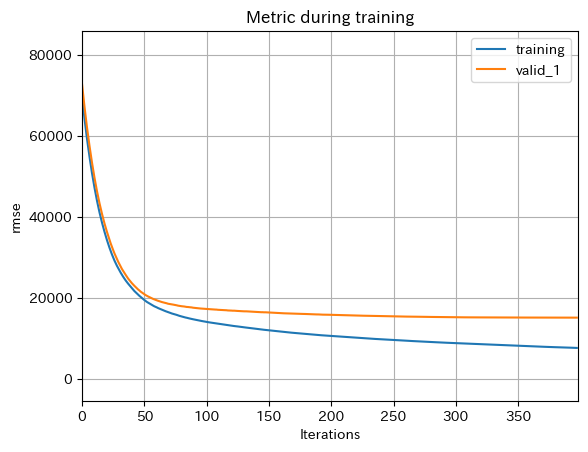

,importance
面積,4.659599e+14
L,3.752047e+14
平均地価,1.952449e+14
最寄り駅,8.894299e+13
築年数,6.593417e+13
所在地,3.796450e+13
全体の階数,3.031322e+13
一部屋あたりの面積,2.422134e+13
平均緯度,1.497248e+13
契約期間,1.460382e+13


In [48]:
n_split = 5
cv = KFold(n_splits=n_split, shuffle=True, random_state=0)
valid_rmses_list = []
valid_GBDT = np.zeros(X_train.shape[0])
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    evals_result = {} 
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

    params = {
        'objective':'regression',
        'boosting_type':'gbdt',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda':  2.960577442860017e-06,
        'max_bin': 333,
        'num_leaves': 70,
    }

    print('Start training...')
    model = lgb.train(
                        params,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=1000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists,
                        evals_result=evals_result,
                        )

    pred_y_val = model.predict(X_val)
    rmse = mean_squared_error(y_val, pred_y_val, squared=False)
    valid_rmses_list.append(rmse)

valid_rmse = np.mean(valid_rmses_list)
print("whole valid rmse:", valid_rmse)

print('Start predicting...')
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
print('Plot metrics during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()
# feature importanceを表示
importance = pd.DataFrame(model.feature_importance(importance_type = "gain"), index=X_train.columns, columns=['importance'])
df_importance = pd.DataFrame(importance)
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy as sp
import lightgbm as lgb
import category_encoders as ce
# import mojimoji
import re
from cmath import nan
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import mean_squared_error
import japanize_matplotlib
from sklearn.model_selection import KFold
import xgboost
from catboost import CatBoostRegressor
from catboost import Pool

###訓練データの読み込み
house_age = pd.read_csv('../data/handmade_data/house_age.csv')
area_size = pd.read_csv('../data/handmade_data/area_size.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
contract_span = pd.read_csv('../data/handmade_data/contract_span.csv')#欠損値をゼロ埋めした契約期間
contract_span2 = pd.read_csv('../data/handmade_data/contract_span2.csv')#欠損値を欠損値のままにした契約期間
reg_rent = pd.read_csv('../data/handmade_data/reg_rent.csv')
floor_scores = pd.read_csv('../data/handmade_data/floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「所在階」
floor_scores2 = pd.read_csv('../data/handmade_data/floor_scores2.csv')#「所在階」と「全体の階数」が独立している「所在階」
Floor_scores = pd.read_csv('../data/handmade_data/capital_floor_scores.csv')#「所在階」と「全体の階数」が連動して欠損値になる場合のある「全体の階数」
Floor_scores2 = pd.read_csv('../data/handmade_data/capital_floor_scores2.csv')#「所在階」と「全体の階数」が独立している「全体の階数」
stations = pd.read_csv('../data/handmade_data/stations.csv')
minits = pd.read_csv('../data/handmade_data/minits.csv')
addresses = pd.read_csv('../data/handmade_data/addresses.csv')
room_arrange = pd.read_csv('../data/handmade_data/room_arrange.csv')
building = pd.read_csv('../data/handmade_data/building.csv')
buildings = pd.read_csv('../data/handmade_data/buildings.csv')
land_aveprice = pd.read_csv('../data/handmade_data/land_aveprice.csv')
land_aveprice.columns = ['平均地価']
over100m2 = pd.read_csv('../data/handmade_data/over100m2.csv')
bt75and100m2 = pd.read_csv('../data/handmade_data/bt75and100m2.csv')
bt50and75m2 = pd.read_csv('../data/handmade_data/bt50and75m2.csv')
sepa_bath_toilets = pd.read_csv('../data/handmade_data/sepa_bath_toilets.csv')
sepa_bath_toilets.columns = ['バス・トイレ別']
washlets = pd.read_csv('../data/handmade_data/washlets.csv')
area_per_rooms = pd.read_csv('../data/handmade_data/area_per_rooms.csv')
kitchen_points = pd.read_csv('../data/handmade_data/kitchen_points.csv')
kitchen_points.drop('コンロ3口', axis=1, inplace=True)
equipments = pd.read_csv('../data/handmade_data/equipments.csv')
latitude_longitude = pd.read_csv('../data/handmade_data/latitude_longitude.csv')

rent = pd.read_csv('../data/handmade_data/rent.csv')


##テストデータの読み込み
test_house_age = pd.read_csv('../data/test_data/test_house_age.csv')
test_area_size = pd.read_csv('../data/test_data/test_area_size.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_contract_span = pd.read_csv('../data/test_data/test_contract_span.csv')
test_contract_span2 = pd.read_csv('../data/test_data/test_contract_span2.csv')
test_contract_span2.columns = ['契約期間']
test_reg_rent = pd.read_csv('../data/test_data/test_reg_rent.csv')
test_floor_scores = pd.read_csv('../data/test_data/test_floor_scores.csv')
test_floor_scores2 = pd.read_csv('../data/test_data/test_floor_scores2.csv')
test_Floor_scores = pd.read_csv('../data/test_data/test_capital_floor_scores.csv')
test_Floor_scores2 = pd.read_csv('../data/test_data/test_capital_floor_scores2.csv')
test_stations = pd.read_csv('../data/test_data/test_stations.csv')
test_minits = pd.read_csv('../data/test_data/test_minits.csv')
test_addresses = pd.read_csv('../data/test_data/test_addresses.csv')
test_room_arrange = pd.read_csv('../data/test_data/test_room_arrange.csv')
test_building = pd.read_csv('../data/test_data/test_building.csv')
test_buildings = pd.read_csv('../data/test_data/test_buildings.csv')
test_land_aveprice = pd.read_csv('../data/test_data/test_land_aveprice.csv')
test_land_aveprice.columns = ['平均地価']
test_over100m2 = pd.read_csv('../data/test_data/test_over100m2.csv')
test_bt75and100m2 = pd.read_csv('../data/test_data/test_bt75and100m2.csv')
test_bt50and75m2 = pd.read_csv('../data/test_data/test_bt50and75m2.csv')
test_sepa_bath_toilets = pd.read_csv('../data/test_data/test_sepa_bath_toilets.csv')
test_sepa_bath_toilets.columns = ['バス・トイレ別']
test_washlets = pd.read_csv('../data/test_data/test_washlets.csv')
test_area_per_rooms = pd.read_csv('../data/test_data/test_area_per_rooms.csv')
test_kitchen_points = pd.read_csv('../data/test_data/test_kitchen_points.csv')
test_kitchen_points.drop('コンロ3口', axis=1, inplace=True)
test_equipments = pd.read_csv('../data/test_data/test_equipments.csv')
test_latitude_longitude = pd.read_csv('../data/test_data/test_latitude_longitude.csv')


X_train = pd.concat([house_age, area_size, contract_span2, reg_rent, floor_scores2, Floor_scores2, stations, minits, land_aveprice, room_arrange[["部屋数","L","D","S"]], sepa_bath_toilets, buildings, over100m2, bt75and100m2, area_per_rooms, 
kitchen_points[['コンロ2口']], latitude_longitude[['平均緯度', '平均経度']]], axis=1)
y_train = pd.read_csv('../data/handmade_data/rent.csv')
y_train.loc[[5775], '賃料'] = y_train.loc[[5775], '賃料']/10
X_test = pd.concat([test_house_age, test_area_size,test_contract_span2, test_reg_rent, test_floor_scores2, test_Floor_scores2, test_stations, test_minits, test_land_aveprice, test_room_arrange[["部屋数","L","D",'S']],test_sepa_bath_toilets,test_buildings, test_over100m2, test_bt75and100m2, test_area_per_rooms, 
test_kitchen_points[['コンロ2口']], test_latitude_longitude[['平均緯度','平均経度']]], axis=1)
category_lists = ['定期借家','最寄り駅', 'L', 'D','S', 'バス・トイレ別','建物構造','100m^2以上', '75m^2以上100m^2未満', 'コンロ2口']

Start training...
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2560
[LightGBM] [Info] Number of data points in the train set: 25176, number of used features: 21
[LightGBM] [Info] Start training from score 118516.069987
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 48920	valid_1's rmse: 50202.3
[20]	training's rmse: 34622.1	valid_1's rmse: 37903.2


/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argu

[30]	training's rmse: 26162.4	valid_1's rmse: 31055.1
[40]	training's rmse: 21317.5	valid_1's rmse: 27254.3
[50]	training's rmse: 18221.7	valid_1's rmse: 24922.1
[60]	training's rmse: 16405.8	valid_1's rmse: 23539.8
[70]	training's rmse: 15155.1	valid_1's rmse: 22562.9
[80]	training's rmse: 14236.4	valid_1's rmse: 21887
[90]	training's rmse: 13518.8	valid_1's rmse: 21412.9
[100]	training's rmse: 12946.5	valid_1's rmse: 21016.7
[110]	training's rmse: 12453.8	valid_1's rmse: 20644.1
[120]	training's rmse: 12040.7	valid_1's rmse: 20323.2
[130]	training's rmse: 11696.7	valid_1's rmse: 20040.6
[140]	training's rmse: 11360.5	valid_1's rmse: 19768.6
[150]	training's rmse: 11056.2	valid_1's rmse: 19549.2
[160]	training's rmse: 10765	valid_1's rmse: 19339.7
[170]	training's rmse: 10508.7	valid_1's rmse: 19161.8
[180]	training's rmse: 10245.9	valid_1's rmse: 18946.7
[190]	training's rmse: 10019.1	valid_1's rmse: 18780.4
[200]	training's rmse: 9777.18	valid_1's rmse: 18581.4
[210]	training's rmse

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argu

[30]	training's rmse: 27060.6	valid_1's rmse: 28618.7
[40]	training's rmse: 22442.1	valid_1's rmse: 24709.2
[50]	training's rmse: 19623.9	valid_1's rmse: 22273.4
[60]	training's rmse: 17872.7	valid_1's rmse: 20908.7
[70]	training's rmse: 16667.4	valid_1's rmse: 20217.3
[80]	training's rmse: 15770	valid_1's rmse: 19695.8
[90]	training's rmse: 15056.2	valid_1's rmse: 19297.8
[100]	training's rmse: 14413.6	valid_1's rmse: 19046.3
[110]	training's rmse: 13865.7	valid_1's rmse: 18826.4
[120]	training's rmse: 13383.5	valid_1's rmse: 18659
[130]	training's rmse: 12935.3	valid_1's rmse: 18562.1
[140]	training's rmse: 12533	valid_1's rmse: 18466.8
[150]	training's rmse: 12152.9	valid_1's rmse: 18405.1
[160]	training's rmse: 11808.7	valid_1's rmse: 18360.7
[170]	training's rmse: 11501	valid_1's rmse: 18256.3
[180]	training's rmse: 11213.1	valid_1's rmse: 18208.1
[190]	training's rmse: 10948.7	valid_1's rmse: 18139.9
[200]	training's rmse: 10699.4	valid_1's rmse: 18059.4
[210]	training's rmse: 10

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argu

[30]	training's rmse: 27208.3	valid_1's rmse: 26578.9
[40]	training's rmse: 22547.3	valid_1's rmse: 22343
[50]	training's rmse: 19594.1	valid_1's rmse: 19904.4
[60]	training's rmse: 17830.5	valid_1's rmse: 18775.9
[70]	training's rmse: 16658.3	valid_1's rmse: 18281
[80]	training's rmse: 15744.1	valid_1's rmse: 17940.2
[90]	training's rmse: 15013.2	valid_1's rmse: 17697.2
[100]	training's rmse: 14374.6	valid_1's rmse: 17471.9
[110]	training's rmse: 13858.4	valid_1's rmse: 17370.1
[120]	training's rmse: 13390.2	valid_1's rmse: 17221.7
[130]	training's rmse: 12956.6	valid_1's rmse: 17118.4
[140]	training's rmse: 12583.7	valid_1's rmse: 17054.8
[150]	training's rmse: 12223.5	valid_1's rmse: 17006.8
[160]	training's rmse: 11901.6	valid_1's rmse: 16958.9
[170]	training's rmse: 11599	valid_1's rmse: 16888.9
[180]	training's rmse: 11321.1	valid_1's rmse: 16864.2
[190]	training's rmse: 11041.2	valid_1's rmse: 16820.8
[200]	training's rmse: 10795.1	valid_1's rmse: 16791
[210]	training's rmse: 10

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argu

[20]	training's rmse: 34791.4	valid_1's rmse: 35687.3
[30]	training's rmse: 26473.5	valid_1's rmse: 29121
[40]	training's rmse: 21737.7	valid_1's rmse: 25661.8
[50]	training's rmse: 18897.5	valid_1's rmse: 23973.8
[60]	training's rmse: 17197.7	valid_1's rmse: 23058.1
[70]	training's rmse: 15996.6	valid_1's rmse: 22553.4
[80]	training's rmse: 15157.6	valid_1's rmse: 22229.4
[90]	training's rmse: 14482.2	valid_1's rmse: 21905.2
[100]	training's rmse: 13909.9	valid_1's rmse: 21708
[110]	training's rmse: 13419.6	valid_1's rmse: 21481.9
[120]	training's rmse: 12958.2	valid_1's rmse: 21209.9
[130]	training's rmse: 12558.4	valid_1's rmse: 20942.5
[140]	training's rmse: 12204.2	valid_1's rmse: 20791.9
[150]	training's rmse: 11871.5	valid_1's rmse: 20636.5
[160]	training's rmse: 11557.5	valid_1's rmse: 20495.2
[170]	training's rmse: 11286.4	valid_1's rmse: 20385.1
[180]	training's rmse: 11015	valid_1's rmse: 20216.1
[190]	training's rmse: 10766.4	valid_1's rmse: 20137
[200]	training's rmse: 105

/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['100m^2以上', '75m^2以上100m^2未満', 'D', 'L', 'S', 'コンロ2口', 'バス・トイレ別', '定期借家', '建物構造', '最寄り駅']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/koshidatatsuo/python/signate/mynabi/venv/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argu

[30]	training's rmse: 27302.5	valid_1's rmse: 28871.8
[40]	training's rmse: 22775.5	valid_1's rmse: 23988.4
[50]	training's rmse: 19872.4	valid_1's rmse: 21210.3
[60]	training's rmse: 17998.5	valid_1's rmse: 19527.1
[70]	training's rmse: 16784.6	valid_1's rmse: 18455.9
[80]	training's rmse: 15910.6	valid_1's rmse: 17761.1
[90]	training's rmse: 15212.2	valid_1's rmse: 17264.7
[100]	training's rmse: 14643.5	valid_1's rmse: 16885.7
[110]	training's rmse: 14136.6	valid_1's rmse: 16602.8
[120]	training's rmse: 13696.8	valid_1's rmse: 16361.1
[130]	training's rmse: 13302.3	valid_1's rmse: 16119.4
[140]	training's rmse: 12928.4	valid_1's rmse: 15929.7
[150]	training's rmse: 12600.9	valid_1's rmse: 15758.1
[160]	training's rmse: 12279.1	valid_1's rmse: 15590.6
[170]	training's rmse: 11991.1	valid_1's rmse: 15443
[180]	training's rmse: 11683.8	valid_1's rmse: 15293.3
[190]	training's rmse: 11416	valid_1's rmse: 15165
[200]	training's rmse: 11172.6	valid_1's rmse: 15039.3
[210]	training's rmse: 

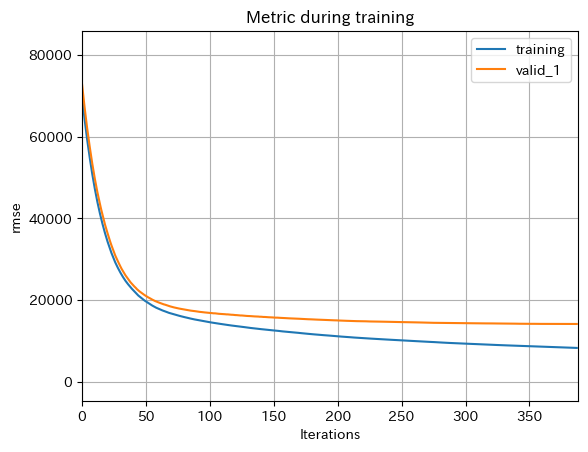

,importance
面積,4.662049e+14
L,3.759353e+14
平均地価,2.048691e+14
最寄り駅,1.079754e+14
築年数,7.210637e+13
全体の階数,3.438335e+13
一部屋あたりの面積,2.236067e+13
平均緯度,1.775630e+13
契約期間,1.429357e+13
所在階,1.047203e+13


In [44]:
n_split = 5
cv = KFold(n_splits=n_split, shuffle=True, random_state=0)
valid_rmses_list = []
valid_GBDT = np.zeros(X_train.shape[0])
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index,:]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train.loc[train_index]
    y_val = y_train.loc[valid_index]

    evals_result = {} 
    lgb_train = lgb.Dataset(X_tr, y_tr)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

    params = {
        'objective':'regression',
        'boosting_type':'gbdt',
        'metrics':'rmse',
        'learning_rate':0.05,
        'reg_lambda':  2.960577442860017e-06,
        'max_bin': 333,
        'num_leaves': 70,
    }

    print('Start training...')
    model = lgb.train(
                        params,
                        lgb_train, 
                        valid_sets=[lgb_train, lgb_eval], 
                        verbose_eval=10, 
                        num_boost_round=1000, 
                        early_stopping_rounds=10,
                        categorical_feature = category_lists,
                        evals_result=evals_result,
                        )

    pred_y_val = model.predict(X_val)
    rmse = mean_squared_error(y_val, pred_y_val, squared=False)
    valid_rmses_list.append(rmse)

valid_rmse = np.mean(valid_rmses_list)
print("whole valid rmse:", valid_rmse)

print('Start predicting...')
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
print('Plot metrics during training...')
ax = lgb.plot_metric(evals_result, metric='rmse')
plt.show()
# feature importanceを表示
importance = pd.DataFrame(model.feature_importance(importance_type = "gain"), index=X_train.columns, columns=['importance'])
df_importance = pd.DataFrame(importance)
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
display(df_importance)

「50m^2以上75m^2未満」「所在地」を除いたら結構上がったぞ・・・！

In [45]:
df = pd.read_csv('../data/outer_data/test.csv')
id = df['id']
y_pred = pd.DataFrame(y_pred)
result = pd.concat([id, y_pred],axis=1)
result.to_csv('../data/result_data/GBDT_cv_result.csv',index=False)